In [1]:
#Description: Code used to train and optimise the models used to predict future electricty consumption

#Author: Katie Roberts
#Date: 26-04-21

In [ ]:
#import all required libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
import statistics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMClassifier
import lightgbm as lgm
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pickle

In [45]:
#load the data sets that will be used for training 
bm=pd.read_csv('bowland_main.csv')
bow_main=bm.drop(columns={'Unnamed: 0'})
bow_main=bow_main.sort_values(by='timestamp')#order the data frame in ascending order of date and time
#create a column with only the date and hour
bow_main['Date_Hour']=bow_main['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d %H'))

lec=pd.read_csv('lec_main_df.csv')
lec_main=lec.drop(columns={'Unnamed: 0'})
lec_main=lec_main.sort_values(by='timestamp')
lec_main['Date_Hour']=lec_main['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d %H'))

occ_df=pd.read_csv('occupancy_dataframe.csv')
bow_tow_occ=occ_df.loc[(occ_df['Building']==' Bowland Twr (Old Bowland Annexe) ')]
bow_tow_occ_total=bow_tow_occ.groupby(["time"])[['Associated Client Count', 'Authenticated Client Count']].sum()
bow_tow_occ_df=pd.DataFrame(data=bow_tow_occ_total).reset_index()
bow_tow_occ_df['Date_Hour']=bow_tow_occ_df['time'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d %H'))
bow_tow_occ_df['min']=bow_tow_occ_df['time'].apply(lambda x:pd.Timestamp(x).strftime('%M'))
bow_tow_occ_df['min']=bow_tow_occ_df['min'].astype(int)
bow_tow_occ_df['min']=round(bow_tow_occ_df['min']/10)*10
bow_tow_occ_df=bow_tow_occ_df.groupby(['Date_Hour','min'], as_index=False)[['Associated Client Count', 'Authenticated Client Count']].mean()
bow_main['min']=bow_main['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M'))
bow_main['min']=bow_main['min'].astype(int)
bow_main['min']=round(bow_main['min']/10)*10
bow_tow_with_occ=pd.merge(bow_tow_occ_df, bow_main, left_on=['Date_Hour','min'], right_on = ['Date_Hour','min'], how='inner')
bow_tow_with_occ=bow_tow_with_occ.sort_values(by='timestamp')
bow_tow_with_occ=bow_tow_with_occ.reset_index(drop=True)


lec_occ=occ_df.loc[(occ_df['Building']==' LEC ')]
lec_occ_total=lec_occ.groupby(["time"])[['Associated Client Count', 'Authenticated Client Count']].sum()
lec_occ_df=pd.DataFrame(data=lec_occ_total).reset_index()
lec_occ_df['Date_Hour']=lec_occ_df['time'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d %H'))
lec_occ_df['min']=lec_occ_df['time'].apply(lambda x:pd.Timestamp(x).strftime('%M'))
lec_occ_df['min']=lec_occ_df['min'].astype(int)
lec_occ_df['min']=round(lec_occ_df['min']/10)*10
lec_occ_df=lec_occ_df.groupby(['Date_Hour','min'], as_index=False)[['Associated Client Count', 'Authenticated Client Count']].mean()
lec_main['min']=lec_main['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M'))
lec_main['min']=lec_main['min'].astype(int)
lec_main['min']=round(lec_main['min']/10)*10
lec_main_with_occ=pd.merge(lec_occ_df, lec_main, left_on=['Date_Hour','min'], right_on = ['Date_Hour','min'], how='inner')
lec_main_with_occ=lec_main_with_occ.sort_values(by='timestamp')
lec_main_with_occ=lec_main_with_occ.reset_index(drop=True)


weather=pd.read_csv('LA14YW.csv')
weather['Date_Hour']=weather['date_time'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d %H'))
bow_tow_with_weather= pd.merge(weather, bow_tow_with_occ, how='right', left_on='Date_Hour', right_on='Date_Hour')
bow_tow_with_weather_no_occ= pd.merge(weather, bow_main, how='right', left_on='Date_Hour', right_on='Date_Hour')

lec_with_weather= pd.merge(weather, lec_main_with_occ, how='right', left_on='Date_Hour', right_on='Date_Hour')
lec_with_weather_no_occ= pd.merge(weather, lec_main, how='right', left_on='Date_Hour', right_on='Date_Hour')

#bow_tow_with_weather=bow_tow_with_weather.append(lec_with_weather)
#bow_tow_with_weather_no_occ=bow_tow_with_weather_no_occ.append(lec_with_weather_no_occ)


bow_tow_with_weather["Year"] = bow_tow_with_weather['Date'].apply(lambda x:pd.Timestamp(x).strftime('%Y')).astype(float)
bow_tow_with_weather["Month"] = bow_tow_with_weather['Date'].apply(lambda x:pd.Timestamp(x).strftime('%m')).astype(float)
bow_tow_with_weather["Day"] = bow_tow_with_weather['Date'].apply(lambda x:pd.Timestamp(x).strftime('%d')).astype(float)

bow_tow_with_weather["hour"] = bow_tow_with_weather['Time'].apply(lambda x:pd.Timestamp(x).strftime('%H')).astype(float)
bow_tow_with_weather["minute"] = bow_tow_with_weather['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M')).astype(float)
bow_tow_with_weather["second"] = bow_tow_with_weather['Time'].apply(lambda x:pd.Timestamp(x).strftime('%S')).astype(float)
bow_tow_with_weather["sunrise"]=pd.to_datetime(bow_tow_with_weather["sunrise"])
bow_tow_with_weather["sunrise_hour"] = bow_tow_with_weather['sunrise'].dt.strftime('%H').astype(float)
bow_tow_with_weather["sunrise_minute"] = bow_tow_with_weather['sunrise'].dt.strftime('%M').astype(float)
bow_tow_with_weather["sunset"]=pd.to_datetime(bow_tow_with_weather["sunset"])
bow_tow_with_weather["sunset_hour"] = bow_tow_with_weather['sunset'].dt.strftime('%H').astype(float)
bow_tow_with_weather["sunset_minute"] = bow_tow_with_weather['sunset'].dt.strftime('%M').astype(float)

bow_tow_with_weather['previous_mintempC'] = bow_tow_with_weather.groupby(['Meter Type'])['mintempC'].ffill()
bow_tow_with_weather['previous_maxtempC'] = bow_tow_with_weather.groupby(['Meter Type'])['maxtempC'].ffill()
bow_tow_with_weather['previous_totalSnow_cm'] = bow_tow_with_weather.groupby(['Meter Type'])['totalSnow_cm'].ffill()
bow_tow_with_weather['previous_sunHour'] = bow_tow_with_weather.groupby(['Meter Type'])['sunHour'].ffill()
bow_tow_with_weather['previous_uvIndex'] = bow_tow_with_weather.groupby(['Meter Type'])['uvIndex'].ffill()
bow_tow_with_weather['previous_moon_illumination'] = bow_tow_with_weather.groupby(['Meter Type'])['moon_illumination'].ffill()
bow_tow_with_weather['previous_sunrise_hour'] = bow_tow_with_weather.groupby(['Meter Type'])['sunrise_hour'].ffill()
bow_tow_with_weather['previous_sunrise_minute'] = bow_tow_with_weather.groupby(['Meter Type'])['sunrise_hour'].ffill()
bow_tow_with_weather['previous_sunset_hour'] = bow_tow_with_weather.groupby(['Meter Type'])['sunset_hour'].ffill()
bow_tow_with_weather['previous_sunset_minute'] = bow_tow_with_weather.groupby(['Meter Type'])['sunset_minute'].ffill()
bow_tow_with_weather['previous_DewPointC'] = bow_tow_with_weather.groupby(['Meter Type'])['DewPointC'].ffill()
bow_tow_with_weather['previous_FeelsLikeC'] = bow_tow_with_weather.groupby(['Meter Type'])['FeelsLikeC'].ffill()
bow_tow_with_weather['previous_HeatIndexC'] = bow_tow_with_weather.groupby(['Meter Type'])['HeatIndexC'].ffill()
bow_tow_with_weather['previous_WindChillC'] = bow_tow_with_weather.groupby(['Meter Type'])['WindChillC'].ffill()
bow_tow_with_weather['previous_WindGustKmph'] = bow_tow_with_weather.groupby(['Meter Type'])['WindGustKmph'].ffill()
bow_tow_with_weather['previous_cloudcover'] = bow_tow_with_weather.groupby(['Meter Type'])['cloudcover'].ffill()
bow_tow_with_weather['previous_humidity'] = bow_tow_with_weather.groupby(['Meter Type'])['humidity'].ffill()
bow_tow_with_weather['previous_precipMM'] = bow_tow_with_weather.groupby(['Meter Type'])['precipMM'].ffill()
bow_tow_with_weather['previous_pressure'] = bow_tow_with_weather.groupby(['Meter Type'])['pressure'].ffill()
bow_tow_with_weather['previous_tempC'] = bow_tow_with_weather.groupby(['Meter Type'])['tempC'].ffill()
bow_tow_with_weather['previous_visibility'] = bow_tow_with_weather.groupby(['Meter Type'])['visibility'].ffill()
bow_tow_with_weather['previous_winddirDegree'] = bow_tow_with_weather.groupby(['Meter Type'])['winddirDegree'].ffill()
bow_tow_with_weather['previous_mintempC'] = bow_tow_with_weather.groupby(['Meter Type'])['mintempC'].ffill()
bow_tow_with_weather['previous_windspeedKmph'] = bow_tow_with_weather.groupby(['Meter Type'])['windspeedKmph'].ffill()
bow_tow_with_weather['previous_Associated Client Count'] = bow_tow_with_weather.groupby(['Meter Type'])['Associated Client Count'].ffill()
bow_tow_with_weather['previous_Authenticated Client Count'] = bow_tow_with_weather.groupby(['Meter Type'])['Authenticated Client Count'].ffill()

bow_tow_with_weather_no_occ["Year"] = bow_tow_with_weather_no_occ['Date'].apply(lambda x:pd.Timestamp(x).strftime('%Y')).astype(float)
bow_tow_with_weather_no_occ["Month"] = bow_tow_with_weather_no_occ['Date'].apply(lambda x:pd.Timestamp(x).strftime('%m')).astype(float)
bow_tow_with_weather_no_occ["Day"] = bow_tow_with_weather_no_occ['Date'].apply(lambda x:pd.Timestamp(x).strftime('%d')).astype(float)

bow_tow_with_weather_no_occ["hour"] = bow_tow_with_weather_no_occ['Time'].apply(lambda x:pd.Timestamp(x).strftime('%H')).astype(float)
bow_tow_with_weather_no_occ["minute"] = bow_tow_with_weather_no_occ['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M')).astype(float)
bow_tow_with_weather_no_occ["second"] = bow_tow_with_weather_no_occ['Time'].apply(lambda x:pd.Timestamp(x).strftime('%S')).astype(float)
bow_tow_with_weather_no_occ["sunrise"]=pd.to_datetime(bow_tow_with_weather_no_occ["sunrise"])
bow_tow_with_weather_no_occ["sunrise_hour"] = bow_tow_with_weather_no_occ['sunrise'].dt.strftime('%H').astype(float)
bow_tow_with_weather_no_occ["sunrise_minute"] = bow_tow_with_weather_no_occ['sunrise'].dt.strftime('%M').astype(float)
bow_tow_with_weather_no_occ["sunset"]=pd.to_datetime(bow_tow_with_weather_no_occ["sunset"])
bow_tow_with_weather_no_occ["sunset_hour"] = bow_tow_with_weather_no_occ['sunset'].dt.strftime('%H').astype(float)
bow_tow_with_weather_no_occ["sunset_minute"] = bow_tow_with_weather_no_occ['sunset'].dt.strftime('%M').astype(float)

bow_tow_with_weather_no_occ['previous_mintempC'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['mintempC'].ffill()
bow_tow_with_weather_no_occ['previous_maxtempC'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['maxtempC'].ffill()
bow_tow_with_weather_no_occ['previous_totalSnow_cm'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['totalSnow_cm'].ffill()
bow_tow_with_weather_no_occ['previous_sunHour'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['sunHour'].ffill()
bow_tow_with_weather_no_occ['previous_uvIndex'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['uvIndex'].ffill()
bow_tow_with_weather_no_occ['previous_moon_illumination'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['moon_illumination'].ffill()
bow_tow_with_weather_no_occ['previous_sunrise_hour'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['sunrise_hour'].ffill()
bow_tow_with_weather_no_occ['previous_sunrise_minute'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['sunrise_hour'].ffill()
bow_tow_with_weather_no_occ['previous_sunset_hour'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['sunset_hour'].ffill()
bow_tow_with_weather_no_occ['previous_sunset_minute'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['sunset_minute'].ffill()
bow_tow_with_weather_no_occ['previous_DewPointC'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['DewPointC'].ffill()
bow_tow_with_weather_no_occ['previous_FeelsLikeC'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['FeelsLikeC'].ffill()
bow_tow_with_weather_no_occ['previous_HeatIndexC'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['HeatIndexC'].ffill()
bow_tow_with_weather_no_occ['previous_WindChillC'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['WindChillC'].ffill()
bow_tow_with_weather_no_occ['previous_WindGustKmph'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['WindGustKmph'].ffill()
bow_tow_with_weather_no_occ['previous_cloudcover'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['cloudcover'].ffill()
bow_tow_with_weather_no_occ['previous_humidity'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['humidity'].ffill()
bow_tow_with_weather_no_occ['previous_precipMM'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['precipMM'].ffill()
bow_tow_with_weather_no_occ['previous_pressure'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['pressure'].ffill()
bow_tow_with_weather_no_occ['previous_tempC'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['tempC'].ffill()
bow_tow_with_weather_no_occ['previous_visibility'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['visibility'].ffill()
bow_tow_with_weather_no_occ['previous_winddirDegree'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['winddirDegree'].ffill()
bow_tow_with_weather_no_occ['previous_mintempC'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['mintempC'].ffill()
bow_tow_with_weather_no_occ['previous_windspeedKmph'] = bow_tow_with_weather_no_occ.groupby(['Meter Type'])['windspeedKmph'].ffill()

bow_tow_with_weather=bow_tow_with_weather.sort_values(by='timestamp')
bow_tow_with_weather.reset_index(drop=True)

bow_tow_with_weather_no_occ=bow_tow_with_weather_no_occ.sort_values(by='timestamp')
bow_tow_with_weather_no_occ.reset_index(drop=True)


lec_with_weather["Year"] = lec_with_weather['Date'].apply(lambda x:pd.Timestamp(x).strftime('%Y')).astype(float)
lec_with_weather["Month"] = lec_with_weather['Date'].apply(lambda x:pd.Timestamp(x).strftime('%m')).astype(float)
lec_with_weather["Day"] = lec_with_weather['Date'].apply(lambda x:pd.Timestamp(x).strftime('%d')).astype(float)

lec_with_weather["hour"] = lec_with_weather['Time'].apply(lambda x:pd.Timestamp(x).strftime('%H')).astype(float)
lec_with_weather["minute"] = lec_with_weather['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M')).astype(float)
lec_with_weather["second"] = lec_with_weather['Time'].apply(lambda x:pd.Timestamp(x).strftime('%S')).astype(float)
lec_with_weather["sunrise"]=pd.to_datetime(lec_with_weather["sunrise"])
lec_with_weather["sunrise_hour"] = lec_with_weather['sunrise'].dt.strftime('%H').astype(float)
lec_with_weather["sunrise_minute"] = lec_with_weather['sunrise'].dt.strftime('%M').astype(float)
lec_with_weather["sunset"]=pd.to_datetime(lec_with_weather["sunset"])
lec_with_weather["sunset_hour"] = lec_with_weather['sunset'].dt.strftime('%H').astype(float)
lec_with_weather["sunset_minute"] = lec_with_weather['sunset'].dt.strftime('%M').astype(float)

lec_with_weather['previous_mintempC'] = lec_with_weather.groupby(['Meter Type'])['mintempC'].ffill()
lec_with_weather['previous_maxtempC'] = lec_with_weather.groupby(['Meter Type'])['maxtempC'].ffill()
lec_with_weather['previous_totalSnow_cm'] = lec_with_weather.groupby(['Meter Type'])['totalSnow_cm'].ffill()
lec_with_weather['previous_sunHour'] = lec_with_weather.groupby(['Meter Type'])['sunHour'].ffill()
lec_with_weather['previous_uvIndex'] = lec_with_weather.groupby(['Meter Type'])['uvIndex'].ffill()
lec_with_weather['previous_moon_illumination'] = lec_with_weather.groupby(['Meter Type'])['moon_illumination'].ffill()
lec_with_weather['previous_sunrise_hour'] = lec_with_weather.groupby(['Meter Type'])['sunrise_hour'].ffill()
lec_with_weather['previous_sunrise_minute'] = lec_with_weather.groupby(['Meter Type'])['sunrise_hour'].ffill()
lec_with_weather['previous_sunset_hour'] = lec_with_weather.groupby(['Meter Type'])['sunset_hour'].ffill()
lec_with_weather['previous_sunset_minute'] = lec_with_weather.groupby(['Meter Type'])['sunset_minute'].ffill()
lec_with_weather['previous_DewPointC'] = lec_with_weather.groupby(['Meter Type'])['DewPointC'].ffill()
lec_with_weather['previous_FeelsLikeC'] = lec_with_weather.groupby(['Meter Type'])['FeelsLikeC'].ffill()
lec_with_weather['previous_HeatIndexC'] = lec_with_weather.groupby(['Meter Type'])['HeatIndexC'].ffill()
lec_with_weather['previous_WindChillC'] = lec_with_weather.groupby(['Meter Type'])['WindChillC'].ffill()
lec_with_weather['previous_WindGustKmph'] = lec_with_weather.groupby(['Meter Type'])['WindGustKmph'].ffill()
lec_with_weather['previous_cloudcover'] = lec_with_weather.groupby(['Meter Type'])['cloudcover'].ffill()
lec_with_weather['previous_humidity'] = lec_with_weather.groupby(['Meter Type'])['humidity'].ffill()
lec_with_weather['previous_precipMM'] = lec_with_weather.groupby(['Meter Type'])['precipMM'].ffill()
lec_with_weather['previous_pressure'] = lec_with_weather.groupby(['Meter Type'])['pressure'].ffill()
lec_with_weather['previous_tempC'] = lec_with_weather.groupby(['Meter Type'])['tempC'].ffill()
lec_with_weather['previous_visibility'] = lec_with_weather.groupby(['Meter Type'])['visibility'].ffill()
lec_with_weather['previous_winddirDegree'] = lec_with_weather.groupby(['Meter Type'])['winddirDegree'].ffill()
lec_with_weather['previous_mintempC'] = lec_with_weather.groupby(['Meter Type'])['mintempC'].ffill()
lec_with_weather['previous_windspeedKmph'] = lec_with_weather.groupby(['Meter Type'])['windspeedKmph'].ffill()
lec_with_weather['previous_Associated Client Count'] = lec_with_weather.groupby(['Meter Type'])['Associated Client Count'].ffill()
lec_with_weather['previous_Authenticated Client Count'] = lec_with_weather.groupby(['Meter Type'])['Authenticated Client Count'].ffill()

lec_with_weather_no_occ["Year"] = lec_with_weather_no_occ['Date'].apply(lambda x:pd.Timestamp(x).strftime('%Y')).astype(float)
lec_with_weather_no_occ["Month"] = lec_with_weather_no_occ['Date'].apply(lambda x:pd.Timestamp(x).strftime('%m')).astype(float)
lec_with_weather_no_occ["Day"] = lec_with_weather_no_occ['Date'].apply(lambda x:pd.Timestamp(x).strftime('%d')).astype(float)

lec_with_weather_no_occ["hour"] =lec_with_weather_no_occ['Time'].apply(lambda x:pd.Timestamp(x).strftime('%H')).astype(float)
lec_with_weather_no_occ["minute"] = lec_with_weather_no_occ['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M')).astype(float)
lec_with_weather_no_occ["second"] = lec_with_weather_no_occ['Time'].apply(lambda x:pd.Timestamp(x).strftime('%S')).astype(float)
lec_with_weather_no_occ["sunrise"]=pd.to_datetime(lec_with_weather_no_occ["sunrise"])
lec_with_weather_no_occ["sunrise_hour"] = lec_with_weather_no_occ['sunrise'].dt.strftime('%H').astype(float)
lec_with_weather_no_occ["sunrise_minute"] = lec_with_weather_no_occ['sunrise'].dt.strftime('%M').astype(float)
lec_with_weather_no_occ["sunset"]=pd.to_datetime(lec_with_weather_no_occ["sunset"])
lec_with_weather_no_occ["sunset_hour"] = lec_with_weather_no_occ['sunset'].dt.strftime('%H').astype(float)
lec_with_weather_no_occ["sunset_minute"] = lec_with_weather_no_occ['sunset'].dt.strftime('%M').astype(float)

lec_with_weather_no_occ['previous_mintempC'] = lec_with_weather_no_occ.groupby(['Meter Type'])['mintempC'].ffill()
lec_with_weather_no_occ['previous_maxtempC'] = lec_with_weather_no_occ.groupby(['Meter Type'])['maxtempC'].ffill()
lec_with_weather_no_occ['previous_totalSnow_cm'] = lec_with_weather_no_occ.groupby(['Meter Type'])['totalSnow_cm'].ffill()
lec_with_weather_no_occ['previous_sunHour'] = lec_with_weather_no_occ.groupby(['Meter Type'])['sunHour'].ffill()
lec_with_weather_no_occ['previous_uvIndex'] = lec_with_weather_no_occ.groupby(['Meter Type'])['uvIndex'].ffill()
lec_with_weather_no_occ['previous_moon_illumination'] = lec_with_weather_no_occ.groupby(['Meter Type'])['moon_illumination'].ffill()
lec_with_weather_no_occ['previous_sunrise_hour'] = lec_with_weather_no_occ.groupby(['Meter Type'])['sunrise_hour'].ffill()
lec_with_weather_no_occ['previous_sunrise_minute'] = lec_with_weather_no_occ.groupby(['Meter Type'])['sunrise_hour'].ffill()
lec_with_weather_no_occ['previous_sunset_hour'] = lec_with_weather_no_occ.groupby(['Meter Type'])['sunset_hour'].ffill()
lec_with_weather_no_occ['previous_sunset_minute'] = lec_with_weather_no_occ.groupby(['Meter Type'])['sunset_minute'].ffill()
lec_with_weather_no_occ['previous_DewPointC'] = lec_with_weather_no_occ.groupby(['Meter Type'])['DewPointC'].ffill()
lec_with_weather_no_occ['previous_FeelsLikeC'] = lec_with_weather_no_occ.groupby(['Meter Type'])['FeelsLikeC'].ffill()
lec_with_weather_no_occ['previous_HeatIndexC'] = lec_with_weather_no_occ.groupby(['Meter Type'])['HeatIndexC'].ffill()
lec_with_weather_no_occ['previous_WindChillC'] = lec_with_weather_no_occ.groupby(['Meter Type'])['WindChillC'].ffill()
lec_with_weather_no_occ['previous_WindGustKmph'] = lec_with_weather_no_occ.groupby(['Meter Type'])['WindGustKmph'].ffill()
lec_with_weather_no_occ['previous_cloudcover'] = lec_with_weather_no_occ.groupby(['Meter Type'])['cloudcover'].ffill()
lec_with_weather_no_occ['previous_humidity'] = lec_with_weather_no_occ.groupby(['Meter Type'])['humidity'].ffill()
lec_with_weather_no_occ['previous_precipMM'] = lec_with_weather_no_occ.groupby(['Meter Type'])['precipMM'].ffill()
lec_with_weather_no_occ['previous_pressure'] = lec_with_weather_no_occ.groupby(['Meter Type'])['pressure'].ffill()
lec_with_weather_no_occ['previous_tempC'] = lec_with_weather_no_occ.groupby(['Meter Type'])['tempC'].ffill()
lec_with_weather_no_occ['previous_visibility'] = lec_with_weather_no_occ.groupby(['Meter Type'])['visibility'].ffill()
lec_with_weather_no_occ['previous_winddirDegree'] = lec_with_weather_no_occ.groupby(['Meter Type'])['winddirDegree'].ffill()
lec_with_weather_no_occ['previous_mintempC'] = lec_with_weather_no_occ.groupby(['Meter Type'])['mintempC'].ffill()
lec_with_weather_no_occ['previous_windspeedKmph'] = lec_with_weather_no_occ.groupby(['Meter Type'])['windspeedKmph'].ffill()

lec_with_weather=lec_with_weather.sort_values(by='timestamp')
lec_with_weather.reset_index(drop=True)

lec_with_weather_no_occ=lec_with_weather_no_occ.sort_values(by='timestamp')
lec_with_weather_no_occ.reset_index(drop=True)


train_data_bow=bow_tow_with_weather
train_data_bow_no_occ=bow_tow_with_weather_no_occ

train_data_lec=lec_with_weather
train_data_lec_no_occ=lec_with_weather_no_occ




train_features=['reading','previous_maxtempC','previous_mintempC','previous_totalSnow_cm',
          'previous_sunHour','previous_uvIndex','previous_moon_illumination','previous_sunrise_hour','previous_sunrise_minute',
          'previous_sunset_hour','previous_sunset_minute','previous_DewPointC','previous_FeelsLikeC','previous_HeatIndexC','previous_WindChillC',
          'previous_WindGustKmph','previous_cloudcover','previous_humidity','previous_precipMM','previous_pressure',
          'previous_tempC','previous_visibility','previous_winddirDegree','previous_windspeedKmph',
          'previous_Associated Client Count','previous_Authenticated Client Count', 'Day_type_as_int', 'Year',
          'Month', 'Day','hour','minute', 'Term_as_int']
train_data_bow=train_data_bow[train_features]

bow_day_avg_reading=[]
bow_day_avg_maxtemp=[]
bow_day_avg_mintemp=[]
bow_day_avg_snow=[]
bow_day_avg_sunhour=[]
bow_day_avg_uvindex=[]
bow_day_avg_moonillumination=[]
bow_day_avg_sunrise_hr=[]
bow_day_avg_sunrise_min=[]
bow_day_avg_sunset_hr=[]
bow_day_avg_sunset_min=[]
bow_day_avg_dewpoint=[]
bow_day_avg_feelslike=[]
bow_day_avg_heatindex=[]
bow_day_avg_windchill=[]
bow_day_avg_windgust=[]
bow_day_avg_cloud=[]
bow_day_avg_humidity=[]
bow_day_avg_precip=[]
bow_day_avg_pressure=[]
bow_day_avg_temp=[]
bow_day_avg_visibility=[]
bow_day_avg_winddir=[]
bow_day_avg_windspeed=[]
bow_day_avg_as_client=[]
bow_day_avg_auth_client=[]
for  i in range(train_data_bow.index.min(), (train_data_bow.index.max()+1)):
    if i-144 < 0:
        bow_day_avg_reading.append(train_data_bow.reading[i])
        bow_day_avg_maxtemp.append(train_data_bow.previous_maxtempC[i])
        bow_day_avg_mintemp.append(train_data_bow.previous_mintempC[i])
        bow_day_avg_snow.append(train_data_bow.previous_totalSnow_cm[i])
        bow_day_avg_sunhour.append(train_data_bow.previous_sunHour[i])
        bow_day_avg_uvindex.append(train_data_bow.previous_uvIndex[i])
        bow_day_avg_moonillumination.append(train_data_bow.previous_moon_illumination[i])
        bow_day_avg_sunrise_hr.append(train_data_bow.previous_sunrise_hour[i])
        bow_day_avg_sunrise_min.append(train_data_bow.previous_sunrise_minute[i])
        bow_day_avg_sunset_hr.append(train_data_bow.previous_sunset_hour[i])
        bow_day_avg_sunset_min.append(train_data_bow.previous_sunset_minute[i])
        bow_day_avg_dewpoint.append(train_data_bow.previous_DewPointC[i])
        bow_day_avg_feelslike.append(train_data_bow.previous_FeelsLikeC[i])
        bow_day_avg_heatindex.append(train_data_bow.previous_HeatIndexC[i])
        bow_day_avg_windchill.append(train_data_bow.previous_WindChillC[i])
        bow_day_avg_windgust.append(train_data_bow.previous_WindGustKmph[i])
        bow_day_avg_cloud.append(train_data_bow.previous_cloudcover[i])
        bow_day_avg_humidity.append(train_data_bow.previous_humidity[i])
        bow_day_avg_precip.append(train_data_bow.previous_precipMM[i])
        bow_day_avg_pressure.append(train_data_bow.previous_pressure[i])
        bow_day_avg_temp.append(train_data_bow.previous_tempC[i])
        bow_day_avg_visibility.append(train_data_bow.previous_visibility[i])
        bow_day_avg_winddir.append(train_data_bow.previous_winddirDegree[i])
        bow_day_avg_windspeed.append(train_data_bow.previous_windspeedKmph[i])
        bow_day_avg_as_client.append(train_data_bow['previous_Associated Client Count'][i])
        bow_day_avg_auth_client.append(train_data_bow['previous_Authenticated Client Count'][i])
    else:
        bow_day_avg_reading.append(statistics.mean(train_data_bow.reading[(i-144):(i-1)]))
        bow_day_avg_maxtemp.append(statistics.mean(train_data_bow.previous_maxtempC[(i-144):(i-1)]))
        bow_day_avg_mintemp.append(statistics.mean(train_data_bow.previous_mintempC[(i-144):(i-1)]))
        bow_day_avg_snow.append(statistics.mean(train_data_bow.previous_totalSnow_cm[(i-144):(i-1)]))
        bow_day_avg_sunhour.append(statistics.mean(train_data_bow.previous_sunHour[(i-144):(i-1)]))
        bow_day_avg_uvindex.append(statistics.mean(train_data_bow.previous_uvIndex[(i-144):(i-1)]))
        bow_day_avg_moonillumination.append(statistics.mean(train_data_bow.previous_moon_illumination[(i-144):(i-1)]))
        bow_day_avg_sunrise_hr.append(statistics.mean(train_data_bow.previous_sunrise_hour[(i-144):(i-1)]))
        bow_day_avg_sunrise_min.append(statistics.mean(train_data_bow.previous_sunrise_minute[(i-144):(i-1)]))
        bow_day_avg_sunset_hr.append(statistics.mean(train_data_bow.previous_sunset_hour[(i-144):(i-1)]))
        bow_day_avg_sunset_min.append(statistics.mean(train_data_bow.previous_sunset_minute[(i-144):(i-1)]))
        bow_day_avg_dewpoint.append(statistics.mean(train_data_bow.previous_DewPointC[(i-144):(i-1)]))
        bow_day_avg_feelslike.append(statistics.mean(train_data_bow.previous_FeelsLikeC[(i-144):(i-1)]))
        bow_day_avg_heatindex.append(statistics.mean(train_data_bow.previous_HeatIndexC[(i-144):(i-1)]))
        bow_day_avg_windchill.append(statistics.mean(train_data_bow.previous_WindChillC[(i-144):(i-1)]))
        bow_day_avg_windgust.append(statistics.mean(train_data_bow.previous_WindGustKmph[(i-144):(i-1)]))
        bow_day_avg_cloud.append(statistics.mean(train_data_bow.previous_cloudcover[(i-144):(i-1)]))
        bow_day_avg_humidity.append(statistics.mean(train_data_bow.previous_humidity[(i-144):(i-1)]))
        bow_day_avg_precip.append(statistics.mean(train_data_bow.previous_precipMM[(i-144):(i-1)]))
        bow_day_avg_pressure.append(statistics.mean(train_data_bow.previous_pressure[(i-144):(i-1)]))
        bow_day_avg_temp.append(statistics.mean(train_data_bow.previous_tempC[(i-144):(i-1)]))
        bow_day_avg_visibility.append(statistics.mean(train_data_bow.previous_visibility[(i-144):(i-1)]))
        bow_day_avg_winddir.append(statistics.mean(train_data_bow.previous_winddirDegree[(i-144):(i-1)]))
        bow_day_avg_windspeed.append(statistics.mean(train_data_bow.previous_windspeedKmph[(i-144):(i-1)]))
        bow_day_avg_as_client.append(statistics.mean(train_data_bow['previous_Associated Client Count'][(i-144):(i-1)]))
        bow_day_avg_auth_client.append(statistics.mean(train_data_bow['previous_Authenticated Client Count'][(i-144):(i-1)]))

train_data_bow['day_avg_reading']=bow_day_avg_reading
train_data_bow['day_avg_maxtemp']=bow_day_avg_maxtemp
train_data_bow['day_avg_mintemp']=bow_day_avg_mintemp
train_data_bow['day_avg_snow']=bow_day_avg_snow
train_data_bow['day_avg_sunhour']=bow_day_avg_sunhour
train_data_bow['day_avg_uvindex']=bow_day_avg_uvindex
train_data_bow['day_avg_moonillumination']=bow_day_avg_moonillumination
train_data_bow['day_avg_sunrise_hr']=bow_day_avg_sunrise_hr
train_data_bow['day_avg_sunrise_min']=bow_day_avg_sunrise_min
train_data_bow['day_avg_sunset_hr']=bow_day_avg_sunset_hr
train_data_bow['day_avg_sunset_min']=bow_day_avg_sunset_min
train_data_bow['day_avg_dewpoint']=bow_day_avg_dewpoint
train_data_bow['day_avg_feelslike']=bow_day_avg_feelslike
train_data_bow['day_avg_heatindex']=bow_day_avg_heatindex
train_data_bow['day_avg_windchill']=bow_day_avg_windchill
train_data_bow['day_avg_windgust']=bow_day_avg_windgust
train_data_bow['day_avg_cloud']=bow_day_avg_cloud
train_data_bow['day_avg_humidity']=bow_day_avg_humidity
train_data_bow['day_avg_precip']=bow_day_avg_precip
train_data_bow['day_avg_pressure']=bow_day_avg_pressure
train_data_bow['day_avg_temp']=bow_day_avg_temp
train_data_bow['day_avg_visibility']=bow_day_avg_visibility
train_data_bow['day_avg_winddir']=bow_day_avg_winddir
train_data_bow['day_avg_windspeed']=bow_day_avg_windspeed
train_data_bow['day_avg_as_client']=bow_day_avg_as_client
train_data_bow['day_avg_auth_client']=bow_day_avg_auth_client

train_data_lec=train_data_lec[train_features]

l_day_avg_reading=[]
l_day_avg_maxtemp=[]
l_day_avg_mintemp=[]
l_day_avg_snow=[]
l_day_avg_sunhour=[]
l_day_avg_uvindex=[]
l_day_avg_moonillumination=[]
l_day_avg_sunrise_hr=[]
l_day_avg_sunrise_min=[]
l_day_avg_sunset_hr=[]
l_day_avg_sunset_min=[]
l_day_avg_dewpoint=[]
l_day_avg_feelslike=[]
l_day_avg_heatindex=[]
l_day_avg_windchill=[]
l_day_avg_windgust=[]
l_day_avg_cloud=[]
l_day_avg_humidity=[]
l_day_avg_precip=[]
l_day_avg_pressure=[]
l_day_avg_temp=[]
l_day_avg_visibility=[]
l_day_avg_winddir=[]
l_day_avg_windspeed=[]
l_day_avg_as_client=[]
l_day_avg_auth_client=[]
for  i in range(train_data_lec.index.min(), (train_data_lec.index.max()+1)):
    if i-144 < 0:
        l_day_avg_reading.append(train_data_lec.reading[i])
        l_day_avg_maxtemp.append(train_data_lec.previous_maxtempC[i])
        l_day_avg_mintemp.append(train_data_lec.previous_mintempC[i])
        l_day_avg_snow.append(train_data_lec.previous_totalSnow_cm[i])
        l_day_avg_sunhour.append(train_data_lec.previous_sunHour[i])
        l_day_avg_uvindex.append(train_data_lec.previous_uvIndex[i])
        l_day_avg_moonillumination.append(train_data_lec.previous_moon_illumination[i])
        l_day_avg_sunrise_hr.append(train_data_lec.previous_sunrise_hour[i])
        l_day_avg_sunrise_min.append(train_data_lec.previous_sunrise_minute[i])
        l_day_avg_sunset_hr.append(train_data_lec.previous_sunset_hour[i])
        l_day_avg_sunset_min.append(train_data_lec.previous_sunset_minute[i])
        l_day_avg_dewpoint.append(train_data_lec.previous_DewPointC[i])
        l_day_avg_feelslike.append(train_data_lec.previous_FeelsLikeC[i])
        l_day_avg_heatindex.append(train_data_lec.previous_HeatIndexC[i])
        l_day_avg_windchill.append(train_data_lec.previous_WindChillC[i])
        l_day_avg_windgust.append(train_data_lec.previous_WindGustKmph[i])
        l_day_avg_cloud.append(train_data_lec.previous_cloudcover[i])
        l_day_avg_humidity.append(train_data_lec.previous_humidity[i])
        l_day_avg_precip.append(train_data_lec.previous_precipMM[i])
        l_day_avg_pressure.append(train_data_lec.previous_pressure[i])
        l_day_avg_temp.append(train_data_lec.previous_tempC[i])
        l_day_avg_visibility.append(train_data_lec.previous_visibility[i])
        l_day_avg_winddir.append(train_data_lec.previous_winddirDegree[i])
        l_day_avg_windspeed.append(train_data_lec.previous_windspeedKmph[i])
        l_day_avg_as_client.append(train_data_lec['previous_Associated Client Count'][i])
        l_day_avg_auth_client.append(train_data_lec['previous_Authenticated Client Count'][i])
    else:
        l_day_avg_reading.append(statistics.mean(train_data_lec.reading[(i-144):(i-1)]))
        l_day_avg_maxtemp.append(statistics.mean(train_data_lec.previous_maxtempC[(i-144):(i-1)]))
        l_day_avg_mintemp.append(statistics.mean(train_data_lec.previous_mintempC[(i-144):(i-1)]))
        l_day_avg_snow.append(statistics.mean(train_data_lec.previous_totalSnow_cm[(i-144):(i-1)]))
        l_day_avg_sunhour.append(statistics.mean(train_data_lec.previous_sunHour[(i-144):(i-1)]))
        l_day_avg_uvindex.append(statistics.mean(train_data_lec.previous_uvIndex[(i-144):(i-1)]))
        l_day_avg_moonillumination.append(statistics.mean(train_data_lec.previous_moon_illumination[(i-144):(i-1)]))
        l_day_avg_sunrise_hr.append(statistics.mean(train_data_lec.previous_sunrise_hour[(i-144):(i-1)]))
        l_day_avg_sunrise_min.append(statistics.mean(train_data_lec.previous_sunrise_minute[(i-144):(i-1)]))
        l_day_avg_sunset_hr.append(statistics.mean(train_data_lec.previous_sunset_hour[(i-144):(i-1)]))
        l_day_avg_sunset_min.append(statistics.mean(train_data_lec.previous_sunset_minute[(i-144):(i-1)]))
        l_day_avg_dewpoint.append(statistics.mean(train_data_lec.previous_DewPointC[(i-144):(i-1)]))
        l_day_avg_feelslike.append(statistics.mean(train_data_lec.previous_FeelsLikeC[(i-144):(i-1)]))
        l_day_avg_heatindex.append(statistics.mean(train_data_lec.previous_HeatIndexC[(i-144):(i-1)]))
        l_day_avg_windchill.append(statistics.mean(train_data_lec.previous_WindChillC[(i-144):(i-1)]))
        l_day_avg_windgust.append(statistics.mean(train_data_lec.previous_WindGustKmph[(i-144):(i-1)]))
        l_day_avg_cloud.append(statistics.mean(train_data_lec.previous_cloudcover[(i-144):(i-1)]))
        l_day_avg_humidity.append(statistics.mean(train_data_lec.previous_humidity[(i-144):(i-1)]))
        l_day_avg_precip.append(statistics.mean(train_data_lec.previous_precipMM[(i-144):(i-1)]))
        l_day_avg_pressure.append(statistics.mean(train_data_lec.previous_pressure[(i-144):(i-1)]))
        l_day_avg_temp.append(statistics.mean(train_data_lec.previous_tempC[(i-144):(i-1)]))
        l_day_avg_visibility.append(statistics.mean(train_data_lec.previous_visibility[(i-144):(i-1)]))
        l_day_avg_winddir.append(statistics.mean(train_data_lec.previous_winddirDegree[(i-144):(i-1)]))
        l_day_avg_windspeed.append(statistics.mean(train_data_lec.previous_windspeedKmph[(i-144):(i-1)]))
        l_day_avg_as_client.append(statistics.mean(train_data_lec['previous_Associated Client Count'][(i-144):(i-1)]))
        l_day_avg_auth_client.append(statistics.mean(train_data_lec['previous_Authenticated Client Count'][(i-144):(i-1)]))

train_data_lec['day_avg_reading']=l_day_avg_reading
train_data_lec['day_avg_maxtemp']=l_day_avg_maxtemp
train_data_lec['day_avg_mintemp']=l_day_avg_mintemp
train_data_lec['day_avg_snow']=l_day_avg_snow
train_data_lec['day_avg_sunhour']=l_day_avg_sunhour
train_data_lec['day_avg_uvindex']=l_day_avg_uvindex
train_data_lec['day_avg_moonillumination']=l_day_avg_moonillumination
train_data_lec['day_avg_sunrise_hr']=l_day_avg_sunrise_hr
train_data_lec['day_avg_sunrise_min']=l_day_avg_sunrise_min
train_data_lec['day_avg_sunset_hr']=l_day_avg_sunset_hr
train_data_lec['day_avg_sunset_min']=l_day_avg_sunset_min
train_data_lec['day_avg_dewpoint']=l_day_avg_dewpoint
train_data_lec['day_avg_feelslike']=l_day_avg_feelslike
train_data_lec['day_avg_heatindex']=l_day_avg_heatindex
train_data_lec['day_avg_windchill']=l_day_avg_windchill
train_data_lec['day_avg_windgust']=l_day_avg_windgust
train_data_lec['day_avg_cloud']=l_day_avg_cloud
train_data_lec['day_avg_humidity']=l_day_avg_humidity
train_data_lec['day_avg_precip']=l_day_avg_precip
train_data_lec['day_avg_pressure']=l_day_avg_pressure
train_data_lec['day_avg_temp']=l_day_avg_temp
train_data_lec['day_avg_visibility']=l_day_avg_visibility
train_data_lec['day_avg_winddir']=l_day_avg_winddir
train_data_lec['day_avg_windspeed']=l_day_avg_windspeed
train_data_lec['day_avg_as_client']=l_day_avg_as_client
train_data_lec['day_avg_auth_client']=l_day_avg_auth_client

train_features_no_occ=['reading','previous_maxtempC','previous_mintempC','previous_totalSnow_cm',
          'previous_sunHour','previous_uvIndex','previous_moon_illumination','previous_sunrise_hour','previous_sunrise_minute',
          'previous_sunset_hour','previous_sunset_minute','previous_DewPointC','previous_FeelsLikeC','previous_HeatIndexC','previous_WindChillC',
          'previous_WindGustKmph','previous_cloudcover','previous_humidity','previous_precipMM','previous_pressure',
          'previous_tempC','previous_visibility','previous_winddirDegree','previous_windspeedKmph', 'Day_type_as_int', 'Year',
          'Month', 'Day','hour','minute', 'Term_as_int']
train_data_no_occ=train_data_bow_no_occ[train_features_no_occ]

day_avg_reading_no_occ=[]
day_avg_maxtemp_no_occ=[]
day_avg_mintemp_no_occ=[]
day_avg_snow_no_occ=[]
day_avg_sunhour_no_occ=[]
day_avg_uvindex_no_occ=[]
day_avg_moonillumination_no_occ=[]
day_avg_sunrise_hr_no_occ=[]
day_avg_sunrise_min_no_occ=[]
day_avg_sunset_hr_no_occ=[]
day_avg_sunset_min_no_occ=[]
day_avg_dewpoint_no_occ=[]
day_avg_feelslike_no_occ=[]
day_avg_heatindex_no_occ=[]
day_avg_windchill_no_occ=[]
day_avg_windgust_no_occ=[]
day_avg_cloud_no_occ=[]
day_avg_humidity_no_occ=[]
day_avg_precip_no_occ=[]
day_avg_pressure_no_occ=[]
day_avg_temp_no_occ=[]
day_avg_visibility_no_occ=[]
day_avg_winddir_no_occ=[]
day_avg_windspeed_no_occ=[]

for  i in range(train_data_no_occ.index.min(), (train_data_no_occ.index.max()+1)):
    if i-144 < 0:
        day_avg_reading_no_occ.append(train_data_no_occ.reading[i])
        day_avg_maxtemp_no_occ.append(train_data_no_occ.previous_maxtempC[i])
        day_avg_mintemp_no_occ.append(train_data_no_occ.previous_mintempC[i])
        day_avg_snow_no_occ.append(train_data_no_occ.previous_totalSnow_cm[i])
        day_avg_sunhour_no_occ.append(train_data_no_occ.previous_sunHour[i])
        day_avg_uvindex_no_occ.append(train_data_no_occ.previous_uvIndex[i])
        day_avg_moonillumination_no_occ.append(train_data_no_occ.previous_moon_illumination[i])
        day_avg_sunrise_hr_no_occ.append(train_data_no_occ.previous_sunrise_hour[i])
        day_avg_sunrise_min_no_occ.append(train_data_no_occ.previous_sunrise_minute[i])
        day_avg_sunset_hr_no_occ.append(train_data_no_occ.previous_sunset_hour[i])
        day_avg_sunset_min_no_occ.append(train_data_no_occ.previous_sunset_minute[i])
        day_avg_dewpoint_no_occ.append(train_data_no_occ.previous_DewPointC[i])
        day_avg_feelslike_no_occ.append(train_data_no_occ.previous_FeelsLikeC[i])
        day_avg_heatindex_no_occ.append(train_data_no_occ.previous_HeatIndexC[i])
        day_avg_windchill_no_occ.append(train_data_no_occ.previous_WindChillC[i])
        day_avg_windgust_no_occ.append(train_data_no_occ.previous_WindGustKmph[i])
        day_avg_cloud_no_occ.append(train_data_no_occ.previous_cloudcover[i])
        day_avg_humidity_no_occ.append(train_data_no_occ.previous_humidity[i])
        day_avg_precip_no_occ.append(train_data_no_occ.previous_precipMM[i])
        day_avg_pressure_no_occ.append(train_data_no_occ.previous_pressure[i])
        day_avg_temp_no_occ.append(train_data_no_occ.previous_tempC[i])
        day_avg_visibility_no_occ.append(train_data_no_occ.previous_visibility[i])
        day_avg_winddir_no_occ.append(train_data_no_occ.previous_winddirDegree[i])
        day_avg_windspeed_no_occ.append(train_data_no_occ.previous_windspeedKmph[i])
       
    else:
        day_avg_reading_no_occ.append(statistics.mean(train_data_no_occ.reading[(i-144):(i-1)]))
        day_avg_maxtemp_no_occ.append(statistics.mean(train_data_no_occ.previous_maxtempC[(i-144):(i-1)]))
        day_avg_mintemp_no_occ.append(statistics.mean(train_data_no_occ.previous_mintempC[(i-144):(i-1)]))
        day_avg_snow_no_occ.append(statistics.mean(train_data_no_occ.previous_totalSnow_cm[(i-144):(i-1)]))
        day_avg_sunhour_no_occ.append(statistics.mean(train_data_no_occ.previous_sunHour[(i-144):(i-1)]))
        day_avg_uvindex_no_occ.append(statistics.mean(train_data_no_occ.previous_uvIndex[(i-144):(i-1)]))
        day_avg_moonillumination_no_occ.append(statistics.mean(train_data_no_occ.previous_moon_illumination[(i-144):(i-1)]))
        day_avg_sunrise_hr_no_occ.append(statistics.mean(train_data_no_occ.previous_sunrise_hour[(i-144):(i-1)]))
        day_avg_sunrise_min_no_occ.append(statistics.mean(train_data_no_occ.previous_sunrise_minute[(i-144):(i-1)]))
        day_avg_sunset_hr_no_occ.append(statistics.mean(train_data_no_occ.previous_sunset_hour[(i-144):(i-1)]))
        day_avg_sunset_min_no_occ.append(statistics.mean(train_data_no_occ.previous_sunset_minute[(i-144):(i-1)]))
        day_avg_dewpoint_no_occ.append(statistics.mean(train_data_no_occ.previous_DewPointC[(i-144):(i-1)]))
        day_avg_feelslike_no_occ.append(statistics.mean(train_data_no_occ.previous_FeelsLikeC[(i-144):(i-1)]))
        day_avg_heatindex_no_occ.append(statistics.mean(train_data_no_occ.previous_HeatIndexC[(i-144):(i-1)]))
        day_avg_windchill_no_occ.append(statistics.mean(train_data_no_occ.previous_WindChillC[(i-144):(i-1)]))
        day_avg_windgust_no_occ.append(statistics.mean(train_data_no_occ.previous_WindGustKmph[(i-144):(i-1)]))
        day_avg_cloud_no_occ.append(statistics.mean(train_data_no_occ.previous_cloudcover[(i-144):(i-1)]))
        day_avg_humidity_no_occ.append(statistics.mean(train_data_no_occ.previous_humidity[(i-144):(i-1)]))
        day_avg_precip_no_occ.append(statistics.mean(train_data_no_occ.previous_precipMM[(i-144):(i-1)]))
        day_avg_pressure_no_occ.append(statistics.mean(train_data_no_occ.previous_pressure[(i-144):(i-1)]))
        day_avg_temp_no_occ.append(statistics.mean(train_data_no_occ.previous_tempC[(i-144):(i-1)]))
        day_avg_visibility_no_occ.append(statistics.mean(train_data_no_occ.previous_visibility[(i-144):(i-1)]))
        day_avg_winddir_no_occ.append(statistics.mean(train_data_no_occ.previous_winddirDegree[(i-144):(i-1)]))
        day_avg_windspeed_no_occ.append(statistics.mean(train_data_no_occ.previous_windspeedKmph[(i-144):(i-1)]))
        

train_data_no_occ['day_avg_reading']=day_avg_reading_no_occ
train_data_no_occ['day_avg_maxtemp']=day_avg_maxtemp_no_occ
train_data_no_occ['day_avg_mintemp']=day_avg_mintemp_no_occ
train_data_no_occ['day_avg_snow']=day_avg_snow_no_occ
train_data_no_occ['day_avg_sunhour']=day_avg_sunhour_no_occ
train_data_no_occ['day_avg_uvindex']=day_avg_uvindex_no_occ
train_data_no_occ['day_avg_moonillumination']=day_avg_moonillumination_no_occ
train_data_no_occ['day_avg_sunrise_hr']=day_avg_sunrise_hr_no_occ
train_data_no_occ['day_avg_sunrise_min']=day_avg_sunrise_min_no_occ
train_data_no_occ['day_avg_sunset_hr']=day_avg_sunset_hr_no_occ
train_data_no_occ['day_avg_sunset_min']=day_avg_sunset_min_no_occ
train_data_no_occ['day_avg_dewpoint']=day_avg_dewpoint_no_occ
train_data_no_occ['day_avg_feelslike']=day_avg_feelslike_no_occ
train_data_no_occ['day_avg_heatindex']=day_avg_heatindex_no_occ
train_data_no_occ['day_avg_windchill']=day_avg_windchill_no_occ
train_data_no_occ['day_avg_windgust']=day_avg_windgust_no_occ
train_data_no_occ['day_avg_cloud']=day_avg_cloud_no_occ
train_data_no_occ['day_avg_humidity']=day_avg_humidity_no_occ
train_data_no_occ['day_avg_precip']=day_avg_precip_no_occ
train_data_no_occ['day_avg_pressure']=day_avg_pressure_no_occ
train_data_no_occ['day_avg_temp']=day_avg_temp_no_occ
train_data_no_occ['day_avg_visibility']=day_avg_visibility_no_occ
train_data_no_occ['day_avg_winddir']=day_avg_winddir_no_occ
train_data_no_occ['day_avg_windspeed']=day_avg_windspeed_no_occ

ltrain_data_no_occ=train_data_lec_no_occ[train_features_no_occ]

lday_avg_reading_no_occ=[]
lday_avg_maxtemp_no_occ=[]
lday_avg_mintemp_no_occ=[]
lday_avg_snow_no_occ=[]
lday_avg_sunhour_no_occ=[]
lday_avg_uvindex_no_occ=[]
lday_avg_moonillumination_no_occ=[]
lday_avg_sunrise_hr_no_occ=[]
lday_avg_sunrise_min_no_occ=[]
lday_avg_sunset_hr_no_occ=[]
lday_avg_sunset_min_no_occ=[]
lday_avg_dewpoint_no_occ=[]
lday_avg_feelslike_no_occ=[]
lday_avg_heatindex_no_occ=[]
lday_avg_windchill_no_occ=[]
lday_avg_windgust_no_occ=[]
lday_avg_cloud_no_occ=[]
lday_avg_humidity_no_occ=[]
lday_avg_precip_no_occ=[]
lday_avg_pressure_no_occ=[]
lday_avg_temp_no_occ=[]
lday_avg_visibility_no_occ=[]
lday_avg_winddir_no_occ=[]
lday_avg_windspeed_no_occ=[]

for  i in range(ltrain_data_no_occ.index.min(), (ltrain_data_no_occ.index.max()+1)):
    if i-144 < 0:
        lday_avg_reading_no_occ.append(ltrain_data_no_occ.reading[i])
        lday_avg_maxtemp_no_occ.append(ltrain_data_no_occ.previous_maxtempC[i])
        lday_avg_mintemp_no_occ.append(ltrain_data_no_occ.previous_mintempC[i])
        lday_avg_snow_no_occ.append(ltrain_data_no_occ.previous_totalSnow_cm[i])
        lday_avg_sunhour_no_occ.append(ltrain_data_no_occ.previous_sunHour[i])
        lday_avg_uvindex_no_occ.append(ltrain_data_no_occ.previous_uvIndex[i])
        lday_avg_moonillumination_no_occ.append(ltrain_data_no_occ.previous_moon_illumination[i])
        lday_avg_sunrise_hr_no_occ.append(ltrain_data_no_occ.previous_sunrise_hour[i])
        lday_avg_sunrise_min_no_occ.append(ltrain_data_no_occ.previous_sunrise_minute[i])
        lday_avg_sunset_hr_no_occ.append(ltrain_data_no_occ.previous_sunset_hour[i])
        lday_avg_sunset_min_no_occ.append(ltrain_data_no_occ.previous_sunset_minute[i])
        lday_avg_dewpoint_no_occ.append(ltrain_data_no_occ.previous_DewPointC[i])
        lday_avg_feelslike_no_occ.append(ltrain_data_no_occ.previous_FeelsLikeC[i])
        lday_avg_heatindex_no_occ.append(ltrain_data_no_occ.previous_HeatIndexC[i])
        lday_avg_windchill_no_occ.append(ltrain_data_no_occ.previous_WindChillC[i])
        lday_avg_windgust_no_occ.append(ltrain_data_no_occ.previous_WindGustKmph[i])
        lday_avg_cloud_no_occ.append(ltrain_data_no_occ.previous_cloudcover[i])
        lday_avg_humidity_no_occ.append(ltrain_data_no_occ.previous_humidity[i])
        lday_avg_precip_no_occ.append(ltrain_data_no_occ.previous_precipMM[i])
        lday_avg_pressure_no_occ.append(ltrain_data_no_occ.previous_pressure[i])
        lday_avg_temp_no_occ.append(ltrain_data_no_occ.previous_tempC[i])
        lday_avg_visibility_no_occ.append(ltrain_data_no_occ.previous_visibility[i])
        lday_avg_winddir_no_occ.append(ltrain_data_no_occ.previous_winddirDegree[i])
        lday_avg_windspeed_no_occ.append(ltrain_data_no_occ.previous_windspeedKmph[i])
       
    else:
        lday_avg_reading_no_occ.append(statistics.mean(ltrain_data_no_occ.reading[(i-144):(i-1)]))
        lday_avg_maxtemp_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_maxtempC[(i-144):(i-1)]))
        lday_avg_mintemp_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_mintempC[(i-144):(i-1)]))
        lday_avg_snow_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_totalSnow_cm[(i-144):(i-1)]))
        lday_avg_sunhour_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_sunHour[(i-144):(i-1)]))
        lday_avg_uvindex_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_uvIndex[(i-144):(i-1)]))
        lday_avg_moonillumination_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_moon_illumination[(i-144):(i-1)]))
        lday_avg_sunrise_hr_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_sunrise_hour[(i-144):(i-1)]))
        lday_avg_sunrise_min_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_sunrise_minute[(i-144):(i-1)]))
        lday_avg_sunset_hr_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_sunset_hour[(i-144):(i-1)]))
        lday_avg_sunset_min_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_sunset_minute[(i-144):(i-1)]))
        lday_avg_dewpoint_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_DewPointC[(i-144):(i-1)]))
        lday_avg_feelslike_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_FeelsLikeC[(i-144):(i-1)]))
        lday_avg_heatindex_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_HeatIndexC[(i-144):(i-1)]))
        lday_avg_windchill_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_WindChillC[(i-144):(i-1)]))
        lday_avg_windgust_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_WindGustKmph[(i-144):(i-1)]))
        lday_avg_cloud_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_cloudcover[(i-144):(i-1)]))
        lday_avg_humidity_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_humidity[(i-144):(i-1)]))
        lday_avg_precip_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_precipMM[(i-144):(i-1)]))
        lday_avg_pressure_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_pressure[(i-144):(i-1)]))
        lday_avg_temp_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_tempC[(i-144):(i-1)]))
        lday_avg_visibility_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_visibility[(i-144):(i-1)]))
        lday_avg_winddir_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_winddirDegree[(i-144):(i-1)]))
        lday_avg_windspeed_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_windspeedKmph[(i-144):(i-1)]))
        

ltrain_data_no_occ['day_avg_reading']=lday_avg_reading_no_occ
ltrain_data_no_occ['day_avg_maxtemp']=lday_avg_maxtemp_no_occ
ltrain_data_no_occ['day_avg_mintemp']=lday_avg_mintemp_no_occ
ltrain_data_no_occ['day_avg_snow']=lday_avg_snow_no_occ
ltrain_data_no_occ['day_avg_sunhour']=lday_avg_sunhour_no_occ
ltrain_data_no_occ['day_avg_uvindex']=lday_avg_uvindex_no_occ
ltrain_data_no_occ['day_avg_moonillumination']=lday_avg_moonillumination_no_occ
ltrain_data_no_occ['day_avg_sunrise_hr']=lday_avg_sunrise_hr_no_occ
ltrain_data_no_occ['day_avg_sunrise_min']=lday_avg_sunrise_min_no_occ
ltrain_data_no_occ['day_avg_sunset_hr']=lday_avg_sunset_hr_no_occ
ltrain_data_no_occ['day_avg_sunset_min']=lday_avg_sunset_min_no_occ
ltrain_data_no_occ['day_avg_dewpoint']=lday_avg_dewpoint_no_occ
ltrain_data_no_occ['day_avg_feelslike']=lday_avg_feelslike_no_occ
ltrain_data_no_occ['day_avg_heatindex']=lday_avg_heatindex_no_occ
ltrain_data_no_occ['day_avg_windchill']=lday_avg_windchill_no_occ
ltrain_data_no_occ['day_avg_windgust']=lday_avg_windgust_no_occ
ltrain_data_no_occ['day_avg_cloud']=lday_avg_cloud_no_occ
ltrain_data_no_occ['day_avg_humidity']=lday_avg_humidity_no_occ
ltrain_data_no_occ['day_avg_precip']=lday_avg_precip_no_occ
ltrain_data_no_occ['day_avg_pressure']=lday_avg_pressure_no_occ
ltrain_data_no_occ['day_avg_temp']=lday_avg_temp_no_occ
ltrain_data_no_occ['day_avg_visibility']=lday_avg_visibility_no_occ
ltrain_data_no_occ['day_avg_winddir']=lday_avg_winddir_no_occ
ltrain_data_no_occ['day_avg_windspeed']=lday_avg_windspeed_no_occ

week_avg_reading=[]
week_avg_maxtemp=[]
week_avg_mintemp=[]
week_avg_snow=[]
week_avg_sunhour=[]
week_avg_uvindex=[]
week_avg_moonillumination=[]
week_avg_sunrise_hr=[]
week_avg_sunrise_min=[]
week_avg_sunset_hr=[]
week_avg_sunset_min=[]
week_avg_dewpoint=[]
week_avg_feelslike=[]
week_avg_heatindex=[]
week_avg_windchill=[]
week_avg_windgust=[]
week_avg_cloud=[]
week_avg_humidity=[]
week_avg_precip=[]
week_avg_pressure=[]
week_avg_temp=[]
week_avg_visibility=[]
week_avg_winddir=[]
week_avg_windspeed=[]
week_avg_as_client=[]
week_avg_auth_client=[]
for  i in range(train_data_bow.index.min(), (train_data_bow.index.max()+1)):
    if i-1008 < 0:
        week_avg_reading.append(train_data_bow.reading[i])
        week_avg_maxtemp.append(train_data_bow.previous_maxtempC[i])
        week_avg_mintemp.append(train_data_bow.previous_mintempC[i])
        week_avg_snow.append(train_data_bow.previous_totalSnow_cm[i])
        week_avg_sunhour.append(train_data_bow.previous_sunHour[i])
        week_avg_uvindex.append(train_data_bow.previous_uvIndex[i])
        week_avg_moonillumination.append(train_data_bow.previous_moon_illumination[i])
        week_avg_sunrise_hr.append(train_data_bow.previous_sunrise_hour[i])
        week_avg_sunrise_min.append(train_data_bow.previous_sunrise_minute[i])
        week_avg_sunset_hr.append(train_data_bow.previous_sunset_hour[i])
        week_avg_sunset_min.append(train_data_bow.previous_sunset_minute[i])
        week_avg_dewpoint.append(train_data_bow.previous_DewPointC[i])
        week_avg_feelslike.append(train_data_bow.previous_FeelsLikeC[i])
        week_avg_heatindex.append(train_data_bow.previous_HeatIndexC[i])
        week_avg_windchill.append(train_data_bow.previous_WindChillC[i])
        week_avg_windgust.append(train_data_bow.previous_WindGustKmph[i])
        week_avg_cloud.append(train_data_bow.previous_cloudcover[i])
        week_avg_humidity.append(train_data_bow.previous_humidity[i])
        week_avg_precip.append(train_data_bow.previous_precipMM[i])
        week_avg_pressure.append(train_data_bow.previous_pressure[i])
        week_avg_temp.append(train_data_bow.previous_tempC[i])
        week_avg_visibility.append(train_data_bow.previous_visibility[i])
        week_avg_winddir.append(train_data_bow.previous_winddirDegree[i])
        week_avg_windspeed.append(train_data_bow.previous_windspeedKmph[i])
        week_avg_as_client.append(train_data_bow['previous_Associated Client Count'][i])
        week_avg_auth_client.append(train_data_bow['previous_Authenticated Client Count'][i])
    else:
        week_avg_reading.append(statistics.mean(train_data_bow.reading[(i-1008):(i-1)]))
        week_avg_maxtemp.append(statistics.mean(train_data_bow.previous_maxtempC[(i-1008):(i-1)]))
        week_avg_mintemp.append(statistics.mean(train_data_bow.previous_mintempC[(i-1008):(i-1)]))
        week_avg_snow.append(statistics.mean(train_data_bow.previous_totalSnow_cm[(i-1008):(i-1)]))
        week_avg_sunhour.append(statistics.mean(train_data_bow.previous_sunHour[(i-1008):(i-1)]))
        week_avg_uvindex.append(statistics.mean(train_data_bow.previous_uvIndex[(i-1008):(i-1)]))
        week_avg_moonillumination.append(statistics.mean(train_data_bow.previous_moon_illumination[(i-1008):(i-1)]))
        week_avg_sunrise_hr.append(statistics.mean(train_data_bow.previous_sunrise_hour[(i-1008):(i-1)]))
        week_avg_sunrise_min.append(statistics.mean(train_data_bow.previous_sunrise_minute[(i-1008):(i-1)]))
        week_avg_sunset_hr.append(statistics.mean(train_data_bow.previous_sunset_hour[(i-1008):(i-1)]))
        week_avg_sunset_min.append(statistics.mean(train_data_bow.previous_sunset_minute[(i-1008):(i-1)]))
        week_avg_dewpoint.append(statistics.mean(train_data_bow.previous_DewPointC[(i-1008):(i-1)]))
        week_avg_feelslike.append(statistics.mean(train_data_bow.previous_FeelsLikeC[(i-1008):(i-1)]))
        week_avg_heatindex.append(statistics.mean(train_data_bow.previous_HeatIndexC[(i-1008):(i-1)]))
        week_avg_windchill.append(statistics.mean(train_data_bow.previous_WindChillC[(i-1008):(i-1)]))
        week_avg_windgust.append(statistics.mean(train_data_bow.previous_WindGustKmph[(i-1008):(i-1)]))
        week_avg_cloud.append(statistics.mean(train_data_bow.previous_cloudcover[(i-1008):(i-1)]))
        week_avg_humidity.append(statistics.mean(train_data_bow.previous_humidity[(i-1008):(i-1)]))
        week_avg_precip.append(statistics.mean(train_data_bow.previous_precipMM[(i-1008):(i-1)]))
        week_avg_pressure.append(statistics.mean(train_data_bow.previous_pressure[(i-1008):(i-1)]))
        week_avg_temp.append(statistics.mean(train_data_bow.previous_tempC[(i-1008):(i-1)]))
        week_avg_visibility.append(statistics.mean(train_data_bow.previous_visibility[(i-1008):(i-1)]))
        week_avg_winddir.append(statistics.mean(train_data_bow.previous_winddirDegree[(i-1008):(i-1)]))
        week_avg_windspeed.append(statistics.mean(train_data_bow.previous_windspeedKmph[(i-1008):(i-1)]))
        week_avg_as_client.append(statistics.mean(train_data_bow['previous_Associated Client Count'][(i-1008):(i-1)]))
        week_avg_auth_client.append(statistics.mean(train_data_bow['previous_Authenticated Client Count'][(i-1008):(i-1)]))

train_data_bow['week_avg_reading']=week_avg_reading
train_data_bow['week_avg_maxtemp']=week_avg_maxtemp
train_data_bow['week_avg_mintemp']=week_avg_mintemp
train_data_bow['week_avg_snow']=week_avg_snow
train_data_bow['week_avg_sunhour']=week_avg_sunhour
train_data_bow['week_avg_uvindex']=week_avg_uvindex
train_data_bow['week_avg_moonillumination']=week_avg_moonillumination
train_data_bow['week_avg_sunrise_hr']=week_avg_sunrise_hr
train_data_bow['week_avg_sunrise_min']=week_avg_sunrise_min
train_data_bow['week_avg_sunset_hr']=week_avg_sunset_hr
train_data_bow['week_avg_sunset_min']=week_avg_sunset_min
train_data_bow['week_avg_dewpoint']=week_avg_dewpoint
train_data_bow['week_avg_feelslike']=week_avg_feelslike
train_data_bow['week_avg_heatindex']=week_avg_heatindex
train_data_bow['week_avg_windchill']=week_avg_windchill
train_data_bow['week_avg_windgust']=week_avg_windgust
train_data_bow['week_avg_cloud']=week_avg_cloud
train_data_bow['week_avg_humidity']=week_avg_humidity
train_data_bow['week_avg_precip']=week_avg_precip
train_data_bow['week_avg_pressure']=week_avg_pressure
train_data_bow['week_avg_temp']=week_avg_temp
train_data_bow['week_avg_visibility']=week_avg_visibility
train_data_bow['week_avg_winddir']=week_avg_winddir
train_data_bow['week_avg_windspeed']=week_avg_windspeed
train_data_bow['week_avg_as_client']=week_avg_as_client
train_data_bow['week_avg_auth_client']=week_avg_auth_client

lweek_avg_reading=[]
lweek_avg_maxtemp=[]
lweek_avg_mintemp=[]
lweek_avg_snow=[]
lweek_avg_sunhour=[]
lweek_avg_uvindex=[]
lweek_avg_moonillumination=[]
lweek_avg_sunrise_hr=[]
lweek_avg_sunrise_min=[]
lweek_avg_sunset_hr=[]
lweek_avg_sunset_min=[]
lweek_avg_dewpoint=[]
lweek_avg_feelslike=[]
lweek_avg_heatindex=[]
lweek_avg_windchill=[]
lweek_avg_windgust=[]
lweek_avg_cloud=[]
lweek_avg_humidity=[]
lweek_avg_precip=[]
lweek_avg_pressure=[]
lweek_avg_temp=[]
lweek_avg_visibility=[]
lweek_avg_winddir=[]
lweek_avg_windspeed=[]
lweek_avg_as_client=[]
lweek_avg_auth_client=[]
for  i in range(train_data_lec.index.min(), (train_data_lec.index.max()+1)):
    if i-1008 < 0:
        lweek_avg_reading.append(train_data_lec.reading[i])
        lweek_avg_maxtemp.append(train_data_lec.previous_maxtempC[i])
        lweek_avg_mintemp.append(train_data_lec.previous_mintempC[i])
        lweek_avg_snow.append(train_data_lec.previous_totalSnow_cm[i])
        lweek_avg_sunhour.append(train_data_lec.previous_sunHour[i])
        lweek_avg_uvindex.append(train_data_lec.previous_uvIndex[i])
        lweek_avg_moonillumination.append(train_data_lec.previous_moon_illumination[i])
        lweek_avg_sunrise_hr.append(train_data_lec.previous_sunrise_hour[i])
        lweek_avg_sunrise_min.append(train_data_lec.previous_sunrise_minute[i])
        lweek_avg_sunset_hr.append(train_data_lec.previous_sunset_hour[i])
        lweek_avg_sunset_min.append(train_data_lec.previous_sunset_minute[i])
        lweek_avg_dewpoint.append(train_data_lec.previous_DewPointC[i])
        lweek_avg_feelslike.append(train_data_lec.previous_FeelsLikeC[i])
        lweek_avg_heatindex.append(train_data_lec.previous_HeatIndexC[i])
        lweek_avg_windchill.append(train_data_lec.previous_WindChillC[i])
        lweek_avg_windgust.append(train_data_lec.previous_WindGustKmph[i])
        lweek_avg_cloud.append(train_data_lec.previous_cloudcover[i])
        lweek_avg_humidity.append(train_data_lec.previous_humidity[i])
        lweek_avg_precip.append(train_data_lec.previous_precipMM[i])
        lweek_avg_pressure.append(train_data_lec.previous_pressure[i])
        lweek_avg_temp.append(train_data_lec.previous_tempC[i])
        lweek_avg_visibility.append(train_data_lec.previous_visibility[i])
        lweek_avg_winddir.append(train_data_lec.previous_winddirDegree[i])
        lweek_avg_windspeed.append(train_data_lec.previous_windspeedKmph[i])
        lweek_avg_as_client.append(train_data_lec['previous_Associated Client Count'][i])
        lweek_avg_auth_client.append(train_data_lec['previous_Authenticated Client Count'][i])
    else:
        lweek_avg_reading.append(statistics.mean(train_data_lec.reading[(i-1008):(i-1)]))
        lweek_avg_maxtemp.append(statistics.mean(train_data_lec.previous_maxtempC[(i-1008):(i-1)]))
        lweek_avg_mintemp.append(statistics.mean(train_data_lec.previous_mintempC[(i-1008):(i-1)]))
        lweek_avg_snow.append(statistics.mean(train_data_lec.previous_totalSnow_cm[(i-1008):(i-1)]))
        lweek_avg_sunhour.append(statistics.mean(train_data_lec.previous_sunHour[(i-1008):(i-1)]))
        lweek_avg_uvindex.append(statistics.mean(train_data_lec.previous_uvIndex[(i-1008):(i-1)]))
        lweek_avg_moonillumination.append(statistics.mean(train_data_lec.previous_moon_illumination[(i-1008):(i-1)]))
        lweek_avg_sunrise_hr.append(statistics.mean(train_data_lec.previous_sunrise_hour[(i-1008):(i-1)]))
        lweek_avg_sunrise_min.append(statistics.mean(train_data_lec.previous_sunrise_minute[(i-1008):(i-1)]))
        lweek_avg_sunset_hr.append(statistics.mean(train_data_lec.previous_sunset_hour[(i-1008):(i-1)]))
        lweek_avg_sunset_min.append(statistics.mean(train_data_lec.previous_sunset_minute[(i-1008):(i-1)]))
        lweek_avg_dewpoint.append(statistics.mean(train_data_lec.previous_DewPointC[(i-1008):(i-1)]))
        lweek_avg_feelslike.append(statistics.mean(train_data_lec.previous_FeelsLikeC[(i-1008):(i-1)]))
        lweek_avg_heatindex.append(statistics.mean(train_data_lec.previous_HeatIndexC[(i-1008):(i-1)]))
        lweek_avg_windchill.append(statistics.mean(train_data_lec.previous_WindChillC[(i-1008):(i-1)]))
        lweek_avg_windgust.append(statistics.mean(train_data_lec.previous_WindGustKmph[(i-1008):(i-1)]))
        lweek_avg_cloud.append(statistics.mean(train_data_lec.previous_cloudcover[(i-1008):(i-1)]))
        lweek_avg_humidity.append(statistics.mean(train_data_lec.previous_humidity[(i-1008):(i-1)]))
        lweek_avg_precip.append(statistics.mean(train_data_lec.previous_precipMM[(i-1008):(i-1)]))
        lweek_avg_pressure.append(statistics.mean(train_data_lec.previous_pressure[(i-1008):(i-1)]))
        lweek_avg_temp.append(statistics.mean(train_data_lec.previous_tempC[(i-1008):(i-1)]))
        lweek_avg_visibility.append(statistics.mean(train_data_lec.previous_visibility[(i-1008):(i-1)]))
        lweek_avg_winddir.append(statistics.mean(train_data_lec.previous_winddirDegree[(i-1008):(i-1)]))
        lweek_avg_windspeed.append(statistics.mean(train_data_lec.previous_windspeedKmph[(i-1008):(i-1)]))
        lweek_avg_as_client.append(statistics.mean(train_data_lec['previous_Associated Client Count'][(i-1008):(i-1)]))
        lweek_avg_auth_client.append(statistics.mean(train_data_lec['previous_Authenticated Client Count'][(i-1008):(i-1)]))

train_data_lec['week_avg_reading']=lweek_avg_reading
train_data_lec['week_avg_maxtemp']=lweek_avg_maxtemp
train_data_lec['week_avg_mintemp']=lweek_avg_mintemp
train_data_lec['week_avg_snow']=lweek_avg_snow
train_data_lec['week_avg_sunhour']=lweek_avg_sunhour
train_data_lec['week_avg_uvindex']=lweek_avg_uvindex
train_data_lec['week_avg_moonillumination']=lweek_avg_moonillumination
train_data_lec['week_avg_sunrise_hr']=lweek_avg_sunrise_hr
train_data_lec['week_avg_sunrise_min']=lweek_avg_sunrise_min
train_data_lec['week_avg_sunset_hr']=lweek_avg_sunset_hr
train_data_lec['week_avg_sunset_min']=lweek_avg_sunset_min
train_data_lec['week_avg_dewpoint']=lweek_avg_dewpoint
train_data_lec['week_avg_feelslike']=lweek_avg_feelslike
train_data_lec['week_avg_heatindex']=lweek_avg_heatindex
train_data_lec['week_avg_windchill']=lweek_avg_windchill
train_data_lec['week_avg_windgust']=lweek_avg_windgust
train_data_lec['week_avg_cloud']=lweek_avg_cloud
train_data_lec['week_avg_humidity']=lweek_avg_humidity
train_data_lec['week_avg_precip']=lweek_avg_precip
train_data_lec['week_avg_pressure']=lweek_avg_pressure
train_data_lec['week_avg_temp']=lweek_avg_temp
train_data_lec['week_avg_visibility']=lweek_avg_visibility
train_data_lec['week_avg_winddir']=lweek_avg_winddir
train_data_lec['week_avg_windspeed']=lweek_avg_windspeed
train_data_lec['week_avg_as_client']=lweek_avg_as_client
train_data_lec['week_avg_auth_client']=lweek_avg_auth_client

week_avg_reading_no_occ=[]
week_avg_maxtemp_no_occ=[]
week_avg_mintemp_no_occ=[]
week_avg_snow_no_occ=[]
week_avg_sunhour_no_occ=[]
week_avg_uvindex_no_occ=[]
week_avg_moonillumination_no_occ=[]
week_avg_sunrise_hr_no_occ=[]
week_avg_sunrise_min_no_occ=[]
week_avg_sunset_hr_no_occ=[]
week_avg_sunset_min_no_occ=[]
week_avg_dewpoint_no_occ=[]
week_avg_feelslike_no_occ=[]
week_avg_heatindex_no_occ=[]
week_avg_windchill_no_occ=[]
week_avg_windgust_no_occ=[]
week_avg_cloud_no_occ=[]
week_avg_humidity_no_occ=[]
week_avg_precip_no_occ=[]
week_avg_pressure_no_occ=[]
week_avg_temp_no_occ=[]
week_avg_visibility_no_occ=[]
week_avg_winddir_no_occ=[]
week_avg_windspeed_no_occ=[]

for  i in range(train_data_no_occ.index.min(), (train_data_no_occ.index.max()+1)):
    if i-1008 < 0:
        week_avg_reading_no_occ.append(train_data_no_occ.reading[i])
        week_avg_maxtemp_no_occ.append(train_data_no_occ.previous_maxtempC[i])
        week_avg_mintemp_no_occ.append(train_data_no_occ.previous_mintempC[i])
        week_avg_snow_no_occ.append(train_data_no_occ.previous_totalSnow_cm[i])
        week_avg_sunhour_no_occ.append(train_data_no_occ.previous_sunHour[i])
        week_avg_uvindex_no_occ.append(train_data_no_occ.previous_uvIndex[i])
        week_avg_moonillumination_no_occ.append(train_data_no_occ.previous_moon_illumination[i])
        week_avg_sunrise_hr_no_occ.append(train_data_no_occ.previous_sunrise_hour[i])
        week_avg_sunrise_min_no_occ.append(train_data_no_occ.previous_sunrise_minute[i])
        week_avg_sunset_hr_no_occ.append(train_data_no_occ.previous_sunset_hour[i])
        week_avg_sunset_min_no_occ.append(train_data_no_occ.previous_sunset_minute[i])
        week_avg_dewpoint_no_occ.append(train_data_no_occ.previous_DewPointC[i])
        week_avg_feelslike_no_occ.append(train_data_no_occ.previous_FeelsLikeC[i])
        week_avg_heatindex_no_occ.append(train_data_no_occ.previous_HeatIndexC[i])
        week_avg_windchill_no_occ.append(train_data_no_occ.previous_WindChillC[i])
        week_avg_windgust_no_occ.append(train_data_no_occ.previous_WindGustKmph[i])
        week_avg_cloud_no_occ.append(train_data_no_occ.previous_cloudcover[i])
        week_avg_humidity_no_occ.append(train_data_no_occ.previous_humidity[i])
        week_avg_precip_no_occ.append(train_data_no_occ.previous_precipMM[i])
        week_avg_pressure_no_occ.append(train_data_no_occ.previous_pressure[i])
        week_avg_temp_no_occ.append(train_data_no_occ.previous_tempC[i])
        week_avg_visibility_no_occ.append(train_data_no_occ.previous_visibility[i])
        week_avg_winddir_no_occ.append(train_data_no_occ.previous_winddirDegree[i])
        week_avg_windspeed_no_occ.append(train_data_no_occ.previous_windspeedKmph[i])

    else:
        week_avg_reading_no_occ.append(statistics.mean(train_data_no_occ.reading[(i-1008):(i-1)]))
        week_avg_maxtemp_no_occ.append(statistics.mean(train_data_no_occ.previous_maxtempC[(i-1008):(i-1)]))
        week_avg_mintemp_no_occ.append(statistics.mean(train_data_no_occ.previous_mintempC[(i-1008):(i-1)]))
        week_avg_snow_no_occ.append(statistics.mean(train_data_no_occ.previous_totalSnow_cm[(i-1008):(i-1)]))
        week_avg_sunhour_no_occ.append(statistics.mean(train_data_no_occ.previous_sunHour[(i-1008):(i-1)]))
        week_avg_uvindex_no_occ.append(statistics.mean(train_data_no_occ.previous_uvIndex[(i-1008):(i-1)]))
        week_avg_moonillumination_no_occ.append(statistics.mean(train_data_no_occ.previous_moon_illumination[(i-1008):(i-1)]))
        week_avg_sunrise_hr_no_occ.append(statistics.mean(train_data_no_occ.previous_sunrise_hour[(i-1008):(i-1)]))
        week_avg_sunrise_min_no_occ.append(statistics.mean(train_data_no_occ.previous_sunrise_minute[(i-1008):(i-1)]))
        week_avg_sunset_hr_no_occ.append(statistics.mean(train_data_no_occ.previous_sunset_hour[(i-1008):(i-1)]))
        week_avg_sunset_min_no_occ.append(statistics.mean(train_data_no_occ.previous_sunset_minute[(i-1008):(i-1)]))
        week_avg_dewpoint_no_occ.append(statistics.mean(train_data_no_occ.previous_DewPointC[(i-1008):(i-1)]))
        week_avg_feelslike_no_occ.append(statistics.mean(train_data_no_occ.previous_FeelsLikeC[(i-1008):(i-1)]))
        week_avg_heatindex_no_occ.append(statistics.mean(train_data_no_occ.previous_HeatIndexC[(i-1008):(i-1)]))
        week_avg_windchill_no_occ.append(statistics.mean(train_data_no_occ.previous_WindChillC[(i-1008):(i-1)]))
        week_avg_windgust_no_occ.append(statistics.mean(train_data_no_occ.previous_WindGustKmph[(i-1008):(i-1)]))
        week_avg_cloud_no_occ.append(statistics.mean(train_data_no_occ.previous_cloudcover[(i-1008):(i-1)]))
        week_avg_humidity_no_occ.append(statistics.mean(train_data_no_occ.previous_humidity[(i-1008):(i-1)]))
        week_avg_precip_no_occ.append(statistics.mean(train_data_no_occ.previous_precipMM[(i-1008):(i-1)]))
        week_avg_pressure_no_occ.append(statistics.mean(train_data_no_occ.previous_pressure[(i-1008):(i-1)]))
        week_avg_temp_no_occ.append(statistics.mean(train_data_no_occ.previous_tempC[(i-1008):(i-1)]))
        week_avg_visibility_no_occ.append(statistics.mean(train_data_no_occ.previous_visibility[(i-1008):(i-1)]))
        week_avg_winddir_no_occ.append(statistics.mean(train_data_no_occ.previous_winddirDegree[(i-1008):(i-1)]))
        week_avg_windspeed_no_occ.append(statistics.mean(train_data_no_occ.previous_windspeedKmph[(i-1008):(i-1)]))
        

train_data_no_occ['week_avg_reading']=week_avg_reading_no_occ
train_data_no_occ['week_avg_maxtemp']=week_avg_maxtemp_no_occ
train_data_no_occ['week_avg_mintemp']=week_avg_mintemp_no_occ
train_data_no_occ['week_avg_snow']=week_avg_snow_no_occ
train_data_no_occ['week_avg_sunhour']=week_avg_sunhour_no_occ
train_data_no_occ['week_avg_uvindex']=week_avg_uvindex_no_occ
train_data_no_occ['week_avg_moonillumination']=week_avg_moonillumination_no_occ
train_data_no_occ['week_avg_sunrise_hr']=week_avg_sunrise_hr_no_occ
train_data_no_occ['week_avg_sunrise_min']=week_avg_sunrise_min_no_occ
train_data_no_occ['week_avg_sunset_hr']=week_avg_sunset_hr_no_occ
train_data_no_occ['week_avg_sunset_min']=week_avg_sunset_min_no_occ
train_data_no_occ['week_avg_dewpoint']=week_avg_dewpoint_no_occ
train_data_no_occ['week_avg_feelslike']=week_avg_feelslike_no_occ
train_data_no_occ['week_avg_heatindex']=week_avg_heatindex_no_occ
train_data_no_occ['week_avg_windchill']=week_avg_windchill_no_occ
train_data_no_occ['week_avg_windgust']=week_avg_windgust_no_occ
train_data_no_occ['week_avg_cloud']=week_avg_cloud_no_occ
train_data_no_occ['week_avg_humidity']=week_avg_humidity_no_occ
train_data_no_occ['week_avg_precip']=week_avg_precip_no_occ
train_data_no_occ['week_avg_pressure']=week_avg_pressure_no_occ
train_data_no_occ['week_avg_temp']=week_avg_temp_no_occ
train_data_no_occ['week_avg_visibility']=week_avg_visibility_no_occ
train_data_no_occ['week_avg_winddir']=week_avg_winddir_no_occ
train_data_no_occ['week_avg_windspeed']=week_avg_windspeed_no_occ

lweek_avg_reading_no_occ=[]
lweek_avg_maxtemp_no_occ=[]
lweek_avg_mintemp_no_occ=[]
lweek_avg_snow_no_occ=[]
lweek_avg_sunhour_no_occ=[]
lweek_avg_uvindex_no_occ=[]
lweek_avg_moonillumination_no_occ=[]
lweek_avg_sunrise_hr_no_occ=[]
lweek_avg_sunrise_min_no_occ=[]
lweek_avg_sunset_hr_no_occ=[]
lweek_avg_sunset_min_no_occ=[]
lweek_avg_dewpoint_no_occ=[]
lweek_avg_feelslike_no_occ=[]
lweek_avg_heatindex_no_occ=[]
lweek_avg_windchill_no_occ=[]
lweek_avg_windgust_no_occ=[]
lweek_avg_cloud_no_occ=[]
lweek_avg_humidity_no_occ=[]
lweek_avg_precip_no_occ=[]
lweek_avg_pressure_no_occ=[]
lweek_avg_temp_no_occ=[]
lweek_avg_visibility_no_occ=[]
lweek_avg_winddir_no_occ=[]
lweek_avg_windspeed_no_occ=[]

for  i in range(ltrain_data_no_occ.index.min(), (ltrain_data_no_occ.index.max()+1)):
    if i-1008 < 0:
        lweek_avg_reading_no_occ.append(ltrain_data_no_occ.reading[i])
        lweek_avg_maxtemp_no_occ.append(ltrain_data_no_occ.previous_maxtempC[i])
        lweek_avg_mintemp_no_occ.append(ltrain_data_no_occ.previous_mintempC[i])
        lweek_avg_snow_no_occ.append(ltrain_data_no_occ.previous_totalSnow_cm[i])
        lweek_avg_sunhour_no_occ.append(ltrain_data_no_occ.previous_sunHour[i])
        lweek_avg_uvindex_no_occ.append(ltrain_data_no_occ.previous_uvIndex[i])
        lweek_avg_moonillumination_no_occ.append(ltrain_data_no_occ.previous_moon_illumination[i])
        lweek_avg_sunrise_hr_no_occ.append(ltrain_data_no_occ.previous_sunrise_hour[i])
        lweek_avg_sunrise_min_no_occ.append(ltrain_data_no_occ.previous_sunrise_minute[i])
        lweek_avg_sunset_hr_no_occ.append(ltrain_data_no_occ.previous_sunset_hour[i])
        lweek_avg_sunset_min_no_occ.append(ltrain_data_no_occ.previous_sunset_minute[i])
        lweek_avg_dewpoint_no_occ.append(ltrain_data_no_occ.previous_DewPointC[i])
        lweek_avg_feelslike_no_occ.append(ltrain_data_no_occ.previous_FeelsLikeC[i])
        lweek_avg_heatindex_no_occ.append(ltrain_data_no_occ.previous_HeatIndexC[i])
        lweek_avg_windchill_no_occ.append(ltrain_data_no_occ.previous_WindChillC[i])
        lweek_avg_windgust_no_occ.append(ltrain_data_no_occ.previous_WindGustKmph[i])
        lweek_avg_cloud_no_occ.append(ltrain_data_no_occ.previous_cloudcover[i])
        lweek_avg_humidity_no_occ.append(ltrain_data_no_occ.previous_humidity[i])
        lweek_avg_precip_no_occ.append(ltrain_data_no_occ.previous_precipMM[i])
        lweek_avg_pressure_no_occ.append(ltrain_data_no_occ.previous_pressure[i])
        lweek_avg_temp_no_occ.append(ltrain_data_no_occ.previous_tempC[i])
        lweek_avg_visibility_no_occ.append(ltrain_data_no_occ.previous_visibility[i])
        lweek_avg_winddir_no_occ.append(ltrain_data_no_occ.previous_winddirDegree[i])
        lweek_avg_windspeed_no_occ.append(ltrain_data_no_occ.previous_windspeedKmph[i])

    else:
        lweek_avg_reading_no_occ.append(statistics.mean(ltrain_data_no_occ.reading[(i-1008):(i-1)]))
        lweek_avg_maxtemp_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_maxtempC[(i-1008):(i-1)]))
        lweek_avg_mintemp_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_mintempC[(i-1008):(i-1)]))
        lweek_avg_snow_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_totalSnow_cm[(i-1008):(i-1)]))
        lweek_avg_sunhour_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_sunHour[(i-1008):(i-1)]))
        lweek_avg_uvindex_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_uvIndex[(i-1008):(i-1)]))
        lweek_avg_moonillumination_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_moon_illumination[(i-1008):(i-1)]))
        lweek_avg_sunrise_hr_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_sunrise_hour[(i-1008):(i-1)]))
        lweek_avg_sunrise_min_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_sunrise_minute[(i-1008):(i-1)]))
        lweek_avg_sunset_hr_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_sunset_hour[(i-1008):(i-1)]))
        lweek_avg_sunset_min_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_sunset_minute[(i-1008):(i-1)]))
        lweek_avg_dewpoint_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_DewPointC[(i-1008):(i-1)]))
        lweek_avg_feelslike_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_FeelsLikeC[(i-1008):(i-1)]))
        lweek_avg_heatindex_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_HeatIndexC[(i-1008):(i-1)]))
        lweek_avg_windchill_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_WindChillC[(i-1008):(i-1)]))
        lweek_avg_windgust_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_WindGustKmph[(i-1008):(i-1)]))
        lweek_avg_cloud_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_cloudcover[(i-1008):(i-1)]))
        lweek_avg_humidity_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_humidity[(i-1008):(i-1)]))
        lweek_avg_precip_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_precipMM[(i-1008):(i-1)]))
        lweek_avg_pressure_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_pressure[(i-1008):(i-1)]))
        lweek_avg_temp_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_tempC[(i-1008):(i-1)]))
        lweek_avg_visibility_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_visibility[(i-1008):(i-1)]))
        lweek_avg_winddir_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_winddirDegree[(i-1008):(i-1)]))
        lweek_avg_windspeed_no_occ.append(statistics.mean(ltrain_data_no_occ.previous_windspeedKmph[(i-1008):(i-1)]))
        

ltrain_data_no_occ['week_avg_reading']=lweek_avg_reading_no_occ
ltrain_data_no_occ['week_avg_maxtemp']=lweek_avg_maxtemp_no_occ
ltrain_data_no_occ['week_avg_mintemp']=lweek_avg_mintemp_no_occ
ltrain_data_no_occ['week_avg_snow']=lweek_avg_snow_no_occ
ltrain_data_no_occ['week_avg_sunhour']=lweek_avg_sunhour_no_occ
ltrain_data_no_occ['week_avg_uvindex']=lweek_avg_uvindex_no_occ
ltrain_data_no_occ['week_avg_moonillumination']=lweek_avg_moonillumination_no_occ
ltrain_data_no_occ['week_avg_sunrise_hr']=lweek_avg_sunrise_hr_no_occ
ltrain_data_no_occ['week_avg_sunrise_min']=lweek_avg_sunrise_min_no_occ
ltrain_data_no_occ['week_avg_sunset_hr']=lweek_avg_sunset_hr_no_occ
ltrain_data_no_occ['week_avg_sunset_min']=lweek_avg_sunset_min_no_occ
ltrain_data_no_occ['week_avg_dewpoint']=lweek_avg_dewpoint_no_occ
ltrain_data_no_occ['week_avg_feelslike']=lweek_avg_feelslike_no_occ
ltrain_data_no_occ['week_avg_heatindex']=lweek_avg_heatindex_no_occ
ltrain_data_no_occ['week_avg_windchill']=lweek_avg_windchill_no_occ
ltrain_data_no_occ['week_avg_windgust']=lweek_avg_windgust_no_occ
ltrain_data_no_occ['week_avg_cloud']=lweek_avg_cloud_no_occ
ltrain_data_no_occ['week_avg_humidity']=lweek_avg_humidity_no_occ
ltrain_data_no_occ['week_avg_precip']=lweek_avg_precip_no_occ
ltrain_data_no_occ['week_avg_pressure']=lweek_avg_pressure_no_occ
ltrain_data_no_occ['week_avg_temp']=lweek_avg_temp_no_occ
ltrain_data_no_occ['week_avg_visibility']=lweek_avg_visibility_no_occ
ltrain_data_no_occ['week_avg_winddir']=lweek_avg_winddir_no_occ
ltrain_data_no_occ['week_avg_windspeed']=lweek_avg_windspeed_no_occ






<ipython-input-45-e4819816757b>:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_bow['day_avg_reading']=bow_day_avg_reading
<ipython-input-45-e4819816757b>:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_bow['day_avg_maxtemp']=bow_day_avg_maxtemp
<ipython-input-45-e4819816757b>:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

<ipython-input-45-e4819816757b>:444: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_lec['day_avg_reading']=l_day_avg_reading
<ipython-input-45-e4819816757b>:445: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_lec['day_avg_maxtemp']=l_day_avg_maxtemp
<ipython-input-45-e4819816757b>:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

<ipython-input-45-e4819816757b>:558: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_no_occ['day_avg_reading']=day_avg_reading_no_occ
<ipython-input-45-e4819816757b>:559: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_no_occ['day_avg_maxtemp']=day_avg_maxtemp_no_occ
<ipython-input-45-e4819816757b>:560: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

<ipython-input-45-e4819816757b>:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ltrain_data_no_occ['day_avg_reading']=lday_avg_reading_no_occ
<ipython-input-45-e4819816757b>:665: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ltrain_data_no_occ['day_avg_maxtemp']=lday_avg_maxtemp_no_occ
<ipython-input-45-e4819816757b>:666: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

<ipython-input-45-e4819816757b>:686: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ltrain_data_no_occ['day_avg_winddir']=lday_avg_winddir_no_occ
<ipython-input-45-e4819816757b>:687: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ltrain_data_no_occ['day_avg_windspeed']=lday_avg_windspeed_no_occ
<ipython-input-45-e4819816757b>:771: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

<ipython-input-45-e4819816757b>:894: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_lec['week_avg_windchill']=lweek_avg_windchill
<ipython-input-45-e4819816757b>:895: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_lec['week_avg_windgust']=lweek_avg_windgust
<ipython-input-45-e4819816757b>:896: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

<ipython-input-45-e4819816757b>:1090: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ltrain_data_no_occ['week_avg_reading']=lweek_avg_reading_no_occ
<ipython-input-45-e4819816757b>:1091: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ltrain_data_no_occ['week_avg_maxtemp']=lweek_avg_maxtemp_no_occ
<ipython-input-45-e4819816757b>:1092: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [56]:
features=['reading','day_avg_reading','week_avg_reading', 'day_avg_maxtemp', 'week_avg_maxtemp', 'day_avg_mintemp', 
          'week_avg_mintemp','day_avg_snow','week_avg_snow','day_avg_sunhour','week_avg_sunhour', 'day_avg_uvindex','week_avg_uvindex',
          'day_avg_moonillumination','week_avg_moonillumination','day_avg_sunrise_hr','week_avg_sunrise_hr', 'day_avg_sunrise_min','week_avg_sunrise_min',
          'day_avg_sunset_hr','week_avg_sunset_hr','day_avg_sunset_min','week_avg_sunset_min',
          'day_avg_dewpoint','week_avg_dewpoint','day_avg_feelslike','week_avg_feelslike',
          'day_avg_heatindex','week_avg_heatindex','day_avg_windchill','week_avg_windchill',
          'day_avg_windgust','week_avg_windgust','day_avg_cloud','week_avg_cloud',
          'day_avg_humidity','week_avg_humidity','day_avg_precip','week_avg_precip',
          'day_avg_pressure','week_avg_pressure','day_avg_temp','week_avg_temp',
          'day_avg_visibility','week_avg_visibility','day_avg_winddir','week_avg_winddir',
          'day_avg_windspeed','week_avg_windspeed','day_avg_as_client','week_avg_as_client',
          'day_avg_auth_client','week_avg_auth_client','Day_type_as_int', 'Year',
          'Month', 'Day','hour','minute', 'Term_as_int']

bowcorr=train_data_bow[features]
corrmat = bowcorr.corr()

see_correlation_values=False
if see_correlation_values==True:
    corrmat.style.background_gradient(cmap='coolwarm')
else:
    f, ax = plt.subplots(figsize =(10, 6))
    sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)
    ax = sns.heatmap(corrmat, vmin=-1, vmax=1, center=0,cmap="YlGnBu",square=False)
    ax.set_xticklabels( ax.get_xticklabels(),rotation=45,horizontalalignment='right');

,reading,day_avg_reading,week_avg_reading,day_avg_maxtemp,week_avg_maxtemp,day_avg_mintemp,week_avg_mintemp,day_avg_snow,week_avg_snow,day_avg_sunhour,week_avg_sunhour,day_avg_uvindex,week_avg_uvindex,day_avg_moonillumination,week_avg_moonillumination,day_avg_sunrise_hr,week_avg_sunrise_hr,day_avg_sunrise_min,week_avg_sunrise_min,day_avg_sunset_hr,week_avg_sunset_hr,day_avg_sunset_min,week_avg_sunset_min,day_avg_dewpoint,week_avg_dewpoint,day_avg_feelslike,week_avg_feelslike,day_avg_heatindex,week_avg_heatindex,day_avg_windchill,week_avg_windchill,day_avg_windgust,week_avg_windgust,day_avg_cloud,week_avg_cloud,day_avg_humidity,week_avg_humidity,day_avg_precip,week_avg_precip,day_avg_pressure,week_avg_pressure,day_avg_temp,week_avg_temp,day_avg_visibility,week_avg_visibility,day_avg_winddir,week_avg_winddir,day_avg_windspeed,week_avg_windspeed,day_avg_as_client,week_avg_as_client,day_avg_auth_client,week_avg_auth_client,Day_type_as_int,Year,Month,Day,hour,minute,Term_as_int
reading,1.000000,0.567473,0.537752,0.204917,0.223379,0.226490,0.234687,0.023012,0.028832,0.188191,0.205086,0.193354,0.218208,-0.021305,-0.040266,-0.293742,-0.306035,-0.293742,-0.306035,0.280387,0.289345,0.064767,0.062920,0.206195,0.241993,0.212822,0.239393,0.210423,0.238363,0.213159,0.239797,-0.061662,-0.088989,-0.001699,0.028084,0.049246,0.063068,0.053676,0.085062,-0.043682,-0.053315,0.210208,0.236778,0.075453,0.109228,0.007677,0.045745,-0.051985,-0.076518,-0.001067,-0.010859,-0.002215,-0.011734,-0.189202,0.131888,-0.019445,-0.033681,0.335348,-0.006055,-0.081390
day_avg_reading,0.567473,1.000000,0.869261,0.338584,0.367994,0.379066,0.391613,0.024919,0.049471,0.309826,0.336090,0.329526,0.360649,-0.032049,-0.063445,-0.480405,-0.501050,-0.480405,-0.501050,0.457473,0.474407,0.122808,0.110279,0.349859,0.397084,0.360822,0.387338,0.358737,0.386917,0.361364,0.387978,-0.093435,-0.135137,0.007287,0.049880,0.078898,0.129756,0.105743,0.151275,-0.083046,-0.093552,0.359164,0.385581,0.120612,0.179000,-0.003040,0.062250,-0.074133,-0.118409,-0.002856,-0.022856,-0.005689,-0.023453,-0.262337,0.212361,-0.024544,-0.048043,0.016805,-0.000519,-0.120569
week_avg_reading,0.537752,0.869261,1.000000,0.381207,0.404759,0.432498,0.461932,0.001840,0.029085,0.311138,0.349772,0.350469,0.395077,0.000936,-0.037898,-0.501881,-0.524205,-0.501881,-0.524205,0.473132,0.496088,0.181016,0.161922,0.399792,0.445747,0.408125,0.436000,0.413228,0.441748,0.408468,0.436514,-0.053038,-0.109000,0.034025,0.064772,0.076198,0.110884,0.150654,0.201830,-0.121718,-0.134745,0.415279,0.442421,0.102404,0.182091,0.011296,0.038451,-0.037762,-0.085098,-0.099896,-0.056166,-0.101264,-0.058036,-0.106484,0.193533,0.024376,0.005952,0.020632,-0.000964,-0.073634
day_avg_maxtemp,0.204917,0.338584,0.381207,1.000000,0.884754,0.861605,0.776365,-0.173640,-0.276800,0.606229,0.694063,0.874621,0.845870,-0.011558,0.043751,-0.722733,-0.739911,-0.722733,-0.739911,0.715190,0.740185,-0.020457,-0.028389,0.899765,0.807294,0.962176,0.855454,0.961054,0.846157,0.961953,0.855587,-0.165842,-0.346365,-0.079127,-0.187650,0.127885,0.035357,0.077244,0.072691,0.083486,0.150299,0.960877,0.847666,0.021373,0.082141,-0.016343,-0.047302,-0.180583,-0.343910,-0.485997,-0.502095,-0.487376,-0.502675,0.024258,0.258379,0.112700,0.137701,0.001300,-0.000883,0.402953
week_avg_maxtemp,0.223379,0.367994,0.404759,0.884754,1.000000,0.781017,0.902945,-0.136741,-0.318507,0.616277,0.714330,0.781366,0.949715,-0.072718,-0.015772,-0.769977,-0.787543,-0.769977,-0.787543,0.743256,0.776557,-0.012632,-0.045283,0.807959,0.934835,0.881185,0.975984,0.872039,0.971681,0.881796,0.976085,-0.191524,-0.341449,-0.076762,-0.180175,0.062376,0.086222,0.117555,0.111240,0.033323,0.110985,0.869199,0.973018,0.041430,0.070536,0.031729,-0.010975,-0.181055,-0.339537,-0.510482,-0.540220,-0.511816,-0.541194,-0.005796,0.275693,0.155964,0.126849,0.002295,-0.000850,0.421848
day_avg_mintemp,0.226490,0.379066,0.432498,0.861605,0.781017,1.000000,0.837436,-0.160403,-0.279830,0.328401,0.445027,0.733839,0.747

In [60]:
correlations = train_data_bow[features].corr().sort_values(by=['reading'], ascending=False)
correlations.head(85)


,reading,day_avg_reading,week_avg_reading,day_avg_maxtemp,week_avg_maxtemp,day_avg_mintemp,week_avg_mintemp,day_avg_snow,week_avg_snow,day_avg_sunhour,...,week_avg_as_client,day_avg_auth_client,week_avg_auth_client,Day_type_as_int,Year,Month,Day,hour,minute,Term_as_int
reading,1.000000,0.567473,0.537752,0.204917,0.223379,0.226490,0.234687,0.023012,0.028832,0.188191,...,-0.010859,-0.002215,-0.011734,-0.189202,0.131888,-0.019445,-0.033681,0.335348,-6.055139e-03,-0.081390
day_avg_reading,0.567473,1.000000,0.869261,0.338584,0.367994,0.379066,0.391613,0.024919,0.049471,0.309826,...,-0.022856,-0.005689,-0.023453,-0.262337,0.212361,-0.024544,-0.048043,0.016805,-5.190164e-04,-0.120569
week_avg_reading,0.537752,0.869261,1.000000,0.381207,0.404759,0.432498,0.461932,0.001840,0.029085,0.311138,...,-0.056166,-0.101264,-0.058036,-0.106484,0.193533,0.024376,0.005952,0.020632,-9.636967e-04,-0.073634
hour,0.335348,0.016805,0.020632,0.001300,0.002295,-0.000512,0.001658,-0.000502,0.003806,0.000337,...,0.001408,-0.001594,0.001186,-0.000580,-0.001351,-0.000135,-0.003489,1.000000,-3.142976e-04,0.000537
week_avg_sunset_hr,0.289345,0.474407,0.496088,0.740185,0.776557,0.530093,0.560914,-0.067602,-0.130147,0.823043,...,-0.370882,-0.364725,-0.370186,-0.012323,0.554331,-0.244357,0.059472,0.000677,2.297488e-04,0.285200
day_avg_sunset_hr,0.280387,0.457473,0.473132,0.715190,0.743256,0.493586,0.517201,-0.058424,-0.119625,0.828893,...,-0.357407,-0.355260,-0.356601,-0.010841,0.571146,-0.290125,0.033062,0.000705,3.096417e-04,0.283898
week_avg_dewpoint,0.241993,0.397084,0.445747,0.807294,0.934835,0.822502,0.974610,-0.142405,-0.343206,0.419947,...,-0.557556,-0.529398,-0.558937,-0.002401,0.138944,0.290586,0.111854,0.003419,-1.107102e-03,0.384429
week_avg_windchill,0.239797,0.387978,0.436514,0.855587,0.976085,0.809055,0.947995,-0.134871,-0.324467,0.532424,...,-0.576238,-0.547587,-0.577732,-0.007420,0.212323,0.219631,0.130534,0.006261,-1.059031e-03,0.426308
week_avg_feelslike,0.239393,0.387338,0.436000,0.855454,0.975984,0.809178,0.948215,-0.134624,-0.323827,0.532105,...,-0.576847,-0.548243,-0.578340,-0.007236,0.212412,0.219271,0.131433,0.006258,-1.059748e-03,0.426903
week_avg_heatindex,0.238363,0.386917,0.441748,0.846157,0.971681,0.818924,0.964164,-0.139292,-0.327886,0.503759,...,-0.559063,-0.531371,-0.560527,-0.003697,0.174012,0.261408,0.130497,0.005948,-9.908636e-04,0.407384


In [64]:
correlations.reading=correlations.reading.abs()
correlations.reading.mean()
read_correlations=correlations[correlations['reading']>0.16]
read_correlations.head(60)

,reading,day_avg_reading,week_avg_reading,day_avg_maxtemp,week_avg_maxtemp,day_avg_mintemp,week_avg_mintemp,day_avg_snow,week_avg_snow,day_avg_sunhour,...,week_avg_as_client,day_avg_auth_client,week_avg_auth_client,Day_type_as_int,Year,Month,Day,hour,minute,Term_as_int
reading,1.000000,0.567473,0.537752,0.204917,0.223379,0.226490,0.234687,0.023012,0.028832,0.188191,...,-0.010859,-0.002215,-0.011734,-0.189202,0.131888,-0.019445,-0.033681,0.335348,-0.006055,-0.081390
day_avg_reading,0.567473,1.000000,0.869261,0.338584,0.367994,0.379066,0.391613,0.024919,0.049471,0.309826,...,-0.022856,-0.005689,-0.023453,-0.262337,0.212361,-0.024544,-0.048043,0.016805,-0.000519,-0.120569
week_avg_reading,0.537752,0.869261,1.000000,0.381207,0.404759,0.432498,0.461932,0.001840,0.029085,0.311138,...,-0.056166,-0.101264,-0.058036,-0.106484,0.193533,0.024376,0.005952,0.020632,-0.000964,-0.073634
hour,0.335348,0.016805,0.020632,0.001300,0.002295,-0.000512,0.001658,-0.000502,0.003806,0.000337,...,0.001408,-0.001594,0.001186,-0.000580,-0.001351,-0.000135,-0.003489,1.000000,-0.000314,0.000537
week_avg_sunset_hr,0.289345,0.474407,0.496088,0.740185,0.776557,0.530093,0.560914,-0.067602,-0.130147,0.823043,...,-0.370882,-0.364725,-0.370186,-0.012323,0.554331,-0.244357,0.059472,0.000677,0.000230,0.285200
day_avg_sunset_hr,0.280387,0.457473,0.473132,0.715190,0.743256,0.493586,0.517201,-0.058424,-0.119625,0.828893,...,-0.357407,-0.355260,-0.356601,-0.010841,0.571146,-0.290125,0.033062,0.000705,0.000310,0.283898
week_avg_dewpoint,0.241993,0.397084,0.445747,0.807294,0.934835,0.822502,0.974610,-0.142405,-0.343206,0.419947,...,-0.557556,-0.529398,-0.558937,-0.002401,0.138944,0.290586,0.111854,0.003419,-0.001107,0.384429
week_avg_windchill,0.239797,0.387978,0.436514,0.855587,0.976085,0.809055,0.947995,-0.134871,-0.324467,0.532424,...,-0.576238,-0.547587,-0.577732,-0.007420,0.212323,0.219631,0.130534,0.006261,-0.001059,0.426308
week_avg_feelslike,0.239393,0.387338,0.436000,0.855454,0.975984,0.809178,0.948215,-0.134624,-0.323827,0.532105,...,-0.576847,-0.548243,-0.578340,-0.007236,0.212412,0.219271,0.131433,0.006258,-0.001060,0.426903
week_avg_heatindex,0.238363,0.386917,0.441748,0.846157,0.971681,0.818924,0.964164,-0.139292,-0.327886,0.503759,...,-0.559063,-0.531371,-0.560527,-0.003697,0.174012,0.261408,0.130497,0.005948,-0.000991,0.407384


In [66]:
print(read_correlations.index)

Index(['reading', 'day_avg_reading', 'week_avg_reading', 'hour',
       'week_avg_sunset_hr', 'day_avg_sunset_hr', 'week_avg_dewpoint',
       'week_avg_windchill', 'week_avg_feelslike', 'week_avg_heatindex',
       'week_avg_temp', 'week_avg_mintemp', 'day_avg_mintemp',
       'week_avg_maxtemp', 'week_avg_uvindex', 'day_avg_windchill',
       'day_avg_feelslike', 'day_avg_heatindex', 'day_avg_temp',
       'day_avg_dewpoint', 'week_avg_sunhour', 'day_avg_maxtemp',
       'day_avg_uvindex', 'day_avg_sunhour', 'Day_type_as_int',
       'day_avg_sunrise_hr', 'day_avg_sunrise_min', 'week_avg_sunrise_hr',
       'week_avg_sunrise_min'],
      dtype='object')


In [ ]:
#model1 training 
#very short forecast horizon 
          
         
features=[ 'day_avg_reading', 'week_avg_reading', 'hour',
          'week_avg_sunset_hr', 'day_avg_sunset_hr', 'week_avg_dewpoint',
          'week_avg_windchill', 'week_avg_feelslike', 'week_avg_heatindex',
          'week_avg_temp', 'week_avg_mintemp', 'day_avg_mintemp',
          'week_avg_maxtemp', 'week_avg_uvindex', 'day_avg_windchill',
          'day_avg_feelslike', 'day_avg_heatindex', 'day_avg_temp',
          'day_avg_dewpoint', 'week_avg_sunhour', 'day_avg_maxtemp',
          'day_avg_uvindex', 'day_avg_sunhour',
          'day_avg_sunrise_hr', 'day_avg_sunrise_min', 'week_avg_sunrise_hr',
          'week_avg_sunrise_min' ,'day_avg_as_client','week_avg_as_client',
          'day_avg_auth_client','week_avg_auth_client','Day_type_as_int', 
          'Month', 'Day','minute', 'Term_as_int', 'Year']

features_no_occ=['day_avg_reading', 'week_avg_reading', 'hour',
          'week_avg_sunset_hr', 'day_avg_sunset_hr', 'week_avg_dewpoint',
          'week_avg_windchill', 'week_avg_feelslike', 'week_avg_heatindex',
          'week_avg_temp', 'week_avg_mintemp', 'day_avg_mintemp',
          'week_avg_maxtemp', 'week_avg_uvindex', 'day_avg_windchill',
          'day_avg_feelslike', 'day_avg_heatindex', 'day_avg_temp',
          'day_avg_dewpoint', 'week_avg_sunhour', 'day_avg_maxtemp',
          'day_avg_uvindex', 'day_avg_sunhour',
          'day_avg_sunrise_hr', 'day_avg_sunrise_min', 'week_avg_sunrise_hr',
          'week_avg_sunrise_min','Day_type_as_int', 
          'Month', 'Day','minute', 'Term_as_int', 'Year']
train_data_bow['future_reading']=train_data_bow['reading']
train_data_lec['future_reading']=train_data_lec['reading']
train_data=train_data_bow.append(train_data_lec)
X1=train_data[features]
y1=train_data['future_reading']


train_data_no_occ['future_reading']=train_data_no_occ['reading']
ltrain_data_no_occ['future_reading']=ltrain_data_no_occ['reading']
train_data_no_occ_1=train_data_no_occ.append(ltrain_data_no_occ)
X1no=train_data_no_occ[features_no_occ]
y1no=train_data_no_occ['future_reading']



train_X1, val_X1, train_y1, val_y1 = train_test_split(X1, y1, random_state = 0)
train_X1no, val_X1no, train_y1no, val_y1no=train_test_split(X1no, y1no, random_state = 0)

# model2 training
# approx few hours forecast horizon 

shift_train_data_bow1=train_data_bow.shift(10)
shift_train_data_bow1['day_type_int']=train_data_bow['Day_type_as_int']
shift_train_data_bow1['Year']=train_data_bow['Year']
shift_train_data_bow1['Month']=train_data_bow['Month']
shift_train_data_bow1['day']=train_data_bow['Day']
shift_train_data_bow1['hour']=train_data_bow['hour']
shift_train_data_bow1['minute']=train_data_bow['minute']
shift_train_data_bow1['term_int']=train_data_bow['Term_as_int']
shift_train_data_bow1['future_reading']=train_data_bow['future_reading']

shift_train_data_bow1=shift_train_data_bow1.dropna(subset=['Year', 'day_avg_reading'])

shift_train_data_lec1=train_data_lec.shift(10)
shift_train_data_lec1['day_type_int']=train_data_lec['Day_type_as_int']
shift_train_data_lec1['Year']=train_data_lec['Year']
shift_train_data_lec1['Month']=train_data_lec['Month']
shift_train_data_lec1['day']=train_data_lec['Day']
shift_train_data_lec1['hour']=train_data_lec['hour']
shift_train_data_lec1['minute']=train_data_lec['minute']
shift_train_data_lec1['term_int']=train_data_lec['Term_as_int']
shift_train_data_lec1['future_reading']=train_data_lec['future_reading']

shift_train_data_lec1=shift_train_data_lec1.dropna(subset=['Year', 'day_avg_reading'])
shift_train_data1=shift_train_data_bow1.append(shift_train_data_lec1)

X2=shift_train_data1[features]
y2=shift_train_data1['future_reading']

train_X2, val_X2, train_y2, val_y2 = train_test_split(X2, y2, random_state = 0)

shift_train_data1no=train_data_no_occ.shift(10)
shift_train_data1no['day_type_int']=train_data_no_occ['Day_type_as_int']
shift_train_data1no['Year']=train_data_no_occ['Year']
shift_train_data1no['Month']=train_data_no_occ['Month']
shift_train_data1no['day']=train_data_no_occ['Day']
shift_train_data1no['hour']=train_data_no_occ['hour']
shift_train_data1no['minute']=train_data_no_occ['minute']
shift_train_data1no['term_int']=train_data_no_occ['Term_as_int']
shift_train_data1no['future_reading']=train_data_no_occ['future_reading']

shift_train_data1no=shift_train_data1no.dropna(subset=['Year', 'day_avg_reading'])


lshift_train_data1no=ltrain_data_no_occ.shift(10)
lshift_train_data1no['day_type_int']=ltrain_data_no_occ['Day_type_as_int']
lshift_train_data1no['Year']=ltrain_data_no_occ['Year']
lshift_train_data1no['Month']=ltrain_data_no_occ['Month']
lshift_train_data1no['day']=ltrain_data_no_occ['Day']
lshift_train_data1no['hour']=ltrain_data_no_occ['hour']
lshift_train_data1no['minute']=ltrain_data_no_occ['minute']
lshift_train_data1no['term_int']=ltrain_data_no_occ['Term_as_int']
lshift_train_data1no['future_reading']=ltrain_data_no_occ['future_reading']

lshift_train_data1no=shift_train_data1no.dropna(subset=['Year', 'day_avg_reading'])

shift_train_data1no=shift_train_data1no.append(lshift_train_data1no)

X2no=shift_train_data1no[features_no_occ]
y2no=shift_train_data1no['future_reading']

train_X2no, val_X2no, train_y2no, val_y2no = train_test_split(X2no, y2no, random_state = 0)



# model3 training
# approx 10 hours forecast horizon 

shift_train_data2=train_data_bow.shift(50)
shift_train_data2['day_type_int']=train_data_bow['Day_type_as_int']
shift_train_data2['Year']=train_data_bow['Year']
shift_train_data2['Month']=train_data_bow['Month']
shift_train_data2['day']=train_data_bow['Day']
shift_train_data2['hour']=train_data_bow['hour']
shift_train_data2['minute']=train_data_bow['minute']
shift_train_data2['term_int']=train_data_bow['Term_as_int']
shift_train_data2['future_reading']=train_data_bow['future_reading']

shift_train_data2=shift_train_data2.dropna()

lshift_train_data2=train_data_lec.shift(50)
lshift_train_data2['day_type_int']=train_data_lec['Day_type_as_int']
lshift_train_data2['Year']=train_data_lec['Year']
lshift_train_data2['Month']=train_data_lec['Month']
lshift_train_data2['day']=train_data_lec['Day']
lshift_train_data2['hour']=train_data_lec['hour']
lshift_train_data2['minute']=train_data_lec['minute']
lshift_train_data2['term_int']=train_data_lec['Term_as_int']
lshift_train_data2['future_reading']=train_data_lec['future_reading']

lshift_train_data2=lshift_train_data2.dropna()
shift_train_data2=shift_train_data2.append(lshift_train_data2)

X3=shift_train_data2[features]
y3=shift_train_data2['future_reading']

train_X3, val_X3, train_y3, val_y3 = train_test_split(X3, y3, random_state = 0)



shift_train_data2no=train_data_no_occ.shift(50)
shift_train_data2no['day_type_int']=train_data_no_occ['Day_type_as_int']
shift_train_data2no['Year']=train_data_no_occ['Year']
shift_train_data2no['Month']=train_data_no_occ['Month']
shift_train_data2no['day']=train_data_no_occ['Day']
shift_train_data2no['hour']=train_data_no_occ['hour']
shift_train_data2no['minute']=train_data_no_occ['minute']
shift_train_data2no['term_int']=train_data_no_occ['Term_as_int']
shift_train_data2no['future_reading']=train_data_no_occ['future_reading']

shift_train_data2no=shift_train_data2no.dropna()

lshift_train_data2no=ltrain_data_no_occ.shift(50)
lshift_train_data2no['day_type_int']=ltrain_data_no_occ['Day_type_as_int']
lshift_train_data2no['Year']=ltrain_data_no_occ['Year']
lshift_train_data2no['Month']=ltrain_data_no_occ['Month']
lshift_train_data2no['day']=ltrain_data_no_occ['Day']
lshift_train_data2no['hour']=ltrain_data_no_occ['hour']
lshift_train_data2no['minute']=ltrain_data_no_occ['minute']
lshift_train_data2no['term_int']=ltrain_data_no_occ['Term_as_int']
lshift_train_data2no['future_reading']=ltrain_data_no_occ['future_reading']

lshift_train_data2no=lshift_train_data2no.dropna()

shift_train_data2no=shift_train_data2no.append(lshift_train_data2no)
y3no=shift_train_data2no['future_reading']

X3no=shift_train_data2no[features_no_occ]

train_X3no, val_X3no, train_y3no, val_y3no = train_test_split(X3no, y3no, random_state = 0)

# model4 training
# approx 15 hours forecast horizon 

shift_train_data3=train_data_bow.shift(100)
shift_train_data3['day_type_int']=train_data_bow['Day_type_as_int']
shift_train_data3['Year']=train_data_bow['Year']
shift_train_data3['Month']=train_data_bow['Month']
shift_train_data3['day']=train_data_bow['Day']
shift_train_data3['hour']=train_data_bow['hour']
shift_train_data3['minute']=train_data_bow['minute']
shift_train_data3['term_int']=train_data_bow['Term_as_int']
shift_train_data3['future_reading']=train_data_bow['future_reading']

shift_train_data3=shift_train_data3.dropna()

lshift_train_data3=train_data_lec.shift(100)
lshift_train_data3['day_type_int']=train_data_lec['Day_type_as_int']
lshift_train_data3['Year']=train_data_lec['Year']
lshift_train_data3['Month']=train_data_lec['Month']
lshift_train_data3['day']=train_data_lec['Day']
lshift_train_data3['hour']=train_data_lec['hour']
lshift_train_data3['minute']=train_data_lec['minute']
lshift_train_data3['term_int']=train_data_lec['Term_as_int']
lshift_train_data3['future_reading']=train_data_lec['future_reading']

lshift_train_data3=lshift_train_data3.dropna()
shift_train_data3=shift_train_data3.append(lshift_train_data3)

X4=shift_train_data3[features]
y4=shift_train_data3['future_reading']

train_X4, val_X4, train_y4, val_y4 = train_test_split(X4, y4, random_state = 0)

shift_train_data3no=train_data_no_occ.shift(100)
shift_train_data3no['day_type_int']=train_data_no_occ['Day_type_as_int']
shift_train_data3no['Year']=train_data_no_occ['Year']
shift_train_data3no['Month']=train_data_no_occ['Month']
shift_train_data3no['day']=train_data_no_occ['Day']
shift_train_data3no['hour']=train_data_no_occ['hour']
shift_train_data3no['minute']=train_data_no_occ['minute']
shift_train_data3no['term_int']=train_data_no_occ['Term_as_int']
shift_train_data3no['future_reading']=train_data_no_occ['future_reading']

shift_train_data3no=shift_train_data3no.dropna()

lshift_train_data3no=ltrain_data_no_occ.shift(100)
lshift_train_data3no['day_type_int']=ltrain_data_no_occ['Day_type_as_int']
lshift_train_data3no['Year']=ltrain_data_no_occ['Year']
lshift_train_data3no['Month']=ltrain_data_no_occ['Month']
lshift_train_data3no['day']=ltrain_data_no_occ['Day']
lshift_train_data3no['hour']=ltrain_data_no_occ['hour']
lshift_train_data3no['minute']=ltrain_data_no_occ['minute']
lshift_train_data3no['term_int']=ltrain_data_no_occ['Term_as_int']
lshift_train_data3no['future_reading']=ltrain_data_no_occ['future_reading']

lshift_train_data3no=lshift_train_data3no.dropna()
shift_train_data3no=shift_train_data3no.append(lshift_train_data3no)

y4no=shift_train_data3no['future_reading']

X4no=shift_train_data3no[features_no_occ]

train_X4no, val_X4no, train_y4no, val_y4no = train_test_split(X4no, y4no, random_state = 0)

# model5 training
# approx 1 day forecast horizon 

shift_train_data4=train_data_bow.shift(140)
shift_train_data4['day_type_int']=train_data_bow['Day_type_as_int']
shift_train_data4['Year']=train_data_bow['Year']
shift_train_data4['Month']=train_data_bow['Month']
shift_train_data4['day']=train_data_bow['Day']
shift_train_data4['hour']=train_data_bow['hour']
shift_train_data4['minute']=train_data_bow['minute']
shift_train_data4['term_int']=train_data_bow['Term_as_int']
shift_train_data4['future_reading']=train_data_bow['future_reading']

shift_train_data4=shift_train_data4.dropna()

lshift_train_data4=train_data_lec.shift(140)
lshift_train_data4['day_type_int']=train_data_lec['Day_type_as_int']
lshift_train_data4['Year']=train_data_lec['Year']
lshift_train_data4['Month']=train_data_lec['Month']
lshift_train_data4['day']=train_data_lec['Day']
lshift_train_data4['hour']=train_data_lec['hour']
lshift_train_data4['minute']=train_data_lec['minute']
lshift_train_data4['term_int']=train_data_lec['Term_as_int']
lshift_train_data4['future_reading']=train_data_lec['future_reading']

lshift_train_data4=lshift_train_data4.dropna()
shift_train_data4=shift_train_data4.append(lshift_train_data4)

X5=shift_train_data4[features]
y5=shift_train_data4['future_reading']

train_X5, val_X5, train_y5, val_y5 = train_test_split(X5, y5, random_state = 0)

shift_train_data4no=train_data_no_occ.shift(140)
shift_train_data4no['day_type_int']=train_data_no_occ['Day_type_as_int']
shift_train_data4no['Year']=train_data_no_occ['Year']
shift_train_data4no['Month']=train_data_no_occ['Month']
shift_train_data4no['day']=train_data_no_occ['Day']
shift_train_data4no['hour']=train_data_no_occ['hour']
shift_train_data4no['minute']=train_data_no_occ['minute']
shift_train_data4no['term_int']=train_data_no_occ['Term_as_int']
shift_train_data4no['future_reading']=train_data_no_occ['future_reading']

shift_train_data4no=shift_train_data4no.dropna()

lshift_train_data4no=ltrain_data_no_occ.shift(140)
lshift_train_data4no['day_type_int']=ltrain_data_no_occ['Day_type_as_int']
lshift_train_data4no['Year']=ltrain_data_no_occ['Year']
lshift_train_data4no['Month']=ltrain_data_no_occ['Month']
lshift_train_data4no['day']=ltrain_data_no_occ['Day']
lshift_train_data4no['hour']=ltrain_data_no_occ['hour']
lshift_train_data4no['minute']=ltrain_data_no_occ['minute']
lshift_train_data4no['term_int']=ltrain_data_no_occ['Term_as_int']
lshift_train_data4no['future_reading']=ltrain_data_no_occ['future_reading']

lshift_train_data4no=lshift_train_data4no.dropna()
shift_train_data4no=shift_train_data4no.append(lshift_train_data4no)

y5no=shift_train_data4no['future_reading']

X5no=shift_train_data4no[features_no_occ]

train_X5no, val_X5no, train_y5no, val_y5no = train_test_split(X5no, y5no, random_state = 0)

# model6 training
# approx day and a half forecast horizon 

shift_train_data5=train_data_bow.shift(200)
shift_train_data5['day_type_int']=train_data_bow['Day_type_as_int']
shift_train_data5['Year']=train_data_bow['Year']
shift_train_data5['Month']=train_data_bow['Month']
shift_train_data5['day']=train_data_bow['Day']
shift_train_data5['hour']=train_data_bow['hour']
shift_train_data5['minute']=train_data_bow['minute']
shift_train_data5['term_int']=train_data_bow['Term_as_int']
shift_train_data5['future_reading']=train_data_bow['future_reading']

shift_train_data5=shift_train_data5.dropna()

lshift_train_data5=train_data_lec.shift(200)
lshift_train_data5['day_type_int']=train_data_lec['Day_type_as_int']
lshift_train_data5['Year']=train_data_lec['Year']
lshift_train_data5['Month']=train_data_lec['Month']
lshift_train_data5['day']=train_data_lec['Day']
lshift_train_data5['hour']=train_data_lec['hour']
lshift_train_data5['minute']=train_data_lec['minute']
lshift_train_data5['term_int']=train_data_lec['Term_as_int']
lshift_train_data5['future_reading']=train_data_lec['future_reading']

lshift_train_data5=lshift_train_data5.dropna()
shift_train_data5=shift_train_data5.append(lshift_train_data5)

X6=shift_train_data5[features]
y6=shift_train_data5['future_reading']

train_X6, val_X6, train_y6, val_y6 = train_test_split(X6, y6, random_state = 0)

shift_train_data5no=train_data_no_occ.shift(200)
shift_train_data5no['day_type_int']=train_data_no_occ['Day_type_as_int']
shift_train_data5no['Year']=train_data_no_occ['Year']
shift_train_data5no['Month']=train_data_no_occ['Month']
shift_train_data5no['day']=train_data_no_occ['Day']
shift_train_data5no['hour']=train_data_no_occ['hour']
shift_train_data5no['minute']=train_data_no_occ['minute']
shift_train_data5no['term_int']=train_data_no_occ['Term_as_int']
shift_train_data5no['future_reading']=train_data_no_occ['future_reading']

shift_train_data5no=shift_train_data5no.dropna()

lshift_train_data5no=ltrain_data_no_occ.shift(200)
lshift_train_data5no['day_type_int']=ltrain_data_no_occ['Day_type_as_int']
lshift_train_data5no['Year']=ltrain_data_no_occ['Year']
lshift_train_data5no['Month']=ltrain_data_no_occ['Month']
lshift_train_data5no['day']=ltrain_data_no_occ['Day']
lshift_train_data5no['hour']=ltrain_data_no_occ['hour']
lshift_train_data5no['minute']=ltrain_data_no_occ['minute']
lshift_train_data5no['term_int']=ltrain_data_no_occ['Term_as_int']
lshift_train_data5no['future_reading']=ltrain_data_no_occ['future_reading']

lshift_train_data5no=lshift_train_data5no.dropna()
shift_train_data5no=shift_train_data5no.append(lshift_train_data5no)

y6no=shift_train_data5no['future_reading']
X6no=shift_train_data5no[features_no_occ]

train_X6no, val_X6no, train_y6no, val_y6no = train_test_split(X6no, y6no, random_state = 0)

# model7 training
# approx two days forecast horizon 

shift_train_data6=train_data_bow.shift(280)
shift_train_data6['day_type_int']=train_data_bow['Day_type_as_int']
shift_train_data6['Year']=train_data_bow['Year']
shift_train_data6['Month']=train_data_bow['Month']
shift_train_data6['day']=train_data_bow['Day']
shift_train_data6['hour']=train_data_bow['hour']
shift_train_data6['minute']=train_data_bow['minute']
shift_train_data6['term_int']=train_data_bow['Term_as_int']
shift_train_data6['future_reading']=train_data_bow['future_reading']

shift_train_data6=shift_train_data6.dropna()

lshift_train_data6=train_data_lec.shift(280)
lshift_train_data6['day_type_int']=train_data_lec['Day_type_as_int']
lshift_train_data6['Year']=train_data_lec['Year']
lshift_train_data6['Month']=train_data_lec['Month']
lshift_train_data6['day']=train_data_lec['Day']
lshift_train_data6['hour']=train_data_lec['hour']
lshift_train_data6['minute']=train_data_lec['minute']
lshift_train_data6['term_int']=train_data_lec['Term_as_int']
lshift_train_data6['future_reading']=train_data_lec['future_reading']

lshift_train_data6=lshift_train_data6.dropna()
shift_train_data6=shift_train_data6.append(lshift_train_data6)

X7=shift_train_data6[features]
y7=shift_train_data6['future_reading']

train_X7, val_X7, train_y7, val_y7 = train_test_split(X7, y7, random_state = 0)


shift_train_data6no=train_data_no_occ.shift(280)
shift_train_data6no['day_type_int']=train_data_no_occ['Day_type_as_int']
shift_train_data6no['Year']=train_data_no_occ['Year']
shift_train_data6no['Month']=train_data_no_occ['Month']
shift_train_data6no['day']=train_data_no_occ['Day']
shift_train_data6no['hour']=train_data_no_occ['hour']
shift_train_data6no['minute']=train_data_no_occ['minute']
shift_train_data6no['term_int']=train_data_no_occ['Term_as_int']
shift_train_data6no['future_reading']=train_data_no_occ['future_reading']

shift_train_data6no=shift_train_data6no.dropna()

lshift_train_data6no=ltrain_data_no_occ.shift(280)
lshift_train_data6no['day_type_int']=ltrain_data_no_occ['Day_type_as_int']
lshift_train_data6no['Year']=ltrain_data_no_occ['Year']
lshift_train_data6no['Month']=ltrain_data_no_occ['Month']
lshift_train_data6no['day']=ltrain_data_no_occ['Day']
lshift_train_data6no['hour']=ltrain_data_no_occ['hour']
lshift_train_data6no['minute']=ltrain_data_no_occ['minute']
lshift_train_data6no['term_int']=ltrain_data_no_occ['Term_as_int']
lshift_train_data6no['future_reading']=ltrain_data_no_occ['future_reading']

lshift_train_data6no=lshift_train_data6no.dropna()

shift_train_data6no=shift_train_data6no.append(lshift_train_data6no)

y7no=shift_train_data6no['future_reading']
X7no=shift_train_data6no[features_no_occ]


train_X7no, val_X7no, train_y7no, val_y7no = train_test_split(X7no, y7no, random_state = 0)

# model8 training
# approx 2 and a half days forecast horizon 

shift_train_data7=train_data_bow.shift(350)
shift_train_data7['day_type_int']=train_data_bow['Day_type_as_int']
shift_train_data7['Year']=train_data_bow['Year']
shift_train_data7['Month']=train_data_bow['Month']
shift_train_data7['day']=train_data_bow['Day']
shift_train_data7['hour']=train_data_bow['hour']
shift_train_data7['minute']=train_data_bow['minute']
shift_train_data7['term_int']=train_data_bow['Term_as_int']
shift_train_data7['future_reading']=train_data_bow['future_reading']

shift_train_data7=shift_train_data7.dropna()

lshift_train_data7=train_data_lec.shift(350)
lshift_train_data7['day_type_int']=train_data_lec['Day_type_as_int']
lshift_train_data7['Year']=train_data_lec['Year']
lshift_train_data7['Month']=train_data_lec['Month']
lshift_train_data7['day']=train_data_lec['Day']
lshift_train_data7['hour']=train_data_lec['hour']
lshift_train_data7['minute']=train_data_lec['minute']
lshift_train_data7['term_int']=train_data_lec['Term_as_int']
lshift_train_data7['future_reading']=train_data_lec['future_reading']

lshift_train_data7=lshift_train_data7.dropna()
shift_train_data7=shift_train_data7.append(lshift_train_data7)

X8=shift_train_data7[features]
y8=shift_train_data7['future_reading']

train_X8, val_X8, train_y8, val_y8 = train_test_split(X8, y8, random_state = 0)

shift_train_data7no=train_data_no_occ.shift(350)
shift_train_data7no['day_type_int']=train_data_no_occ['Day_type_as_int']
shift_train_data7no['Year']=train_data_no_occ['Year']
shift_train_data7no['Month']=train_data_no_occ['Month']
shift_train_data7no['day']=train_data_no_occ['Day']
shift_train_data7no['hour']=train_data_no_occ['hour']
shift_train_data7no['minute']=train_data_no_occ['minute']
shift_train_data7no['term_int']=train_data_no_occ['Term_as_int']
shift_train_data7no['future_reading']=train_data_no_occ['future_reading']

shift_train_data7no=shift_train_data7no.dropna()

lshift_train_data7no=ltrain_data_no_occ.shift(350)
lshift_train_data7no['day_type_int']=ltrain_data_no_occ['Day_type_as_int']
lshift_train_data7no['Year']=ltrain_data_no_occ['Year']
lshift_train_data7no['Month']=ltrain_data_no_occ['Month']
lshift_train_data7no['day']=ltrain_data_no_occ['Day']
lshift_train_data7no['hour']=ltrain_data_no_occ['hour']
lshift_train_data7no['minute']=ltrain_data_no_occ['minute']
lshift_train_data7no['term_int']=ltrain_data_no_occ['Term_as_int']
lshift_train_data7no['future_reading']=ltrain_data_no_occ['future_reading']

lshift_train_data7no=lshift_train_data7no.dropna()
shift_train_data7no=shift_train_data7no.append(shift_train_data7no)

y8no=shift_train_data7no['future_reading']
X8no=shift_train_data7no[features_no_occ]

train_X8no, val_X8no, train_y8no, val_y8no = train_test_split(X8no, y8no, random_state = 0)

# model9 training
# approx three days forecast horizon 

shift_train_data8=train_data_bow.shift(430)
shift_train_data8['day_type_int']=train_data_bow['Day_type_as_int']
shift_train_data8['Year']=train_data_bow['Year']
shift_train_data8['Month']=train_data_bow['Month']
shift_train_data8['day']=train_data_bow['Day']
shift_train_data8['hour']=train_data_bow['hour']
shift_train_data8['minute']=train_data_bow['minute']
shift_train_data8['term_int']=train_data_bow['Term_as_int']
shift_train_data8['future_reading']=train_data_bow['future_reading']

shift_train_data8=shift_train_data8.dropna()

lshift_train_data8=train_data_lec.shift(430)
lshift_train_data8['day_type_int']=train_data_lec['Day_type_as_int']
lshift_train_data8['Year']=train_data_lec['Year']
lshift_train_data8['Month']=train_data_lec['Month']
lshift_train_data8['day']=train_data_lec['Day']
lshift_train_data8['hour']=train_data_lec['hour']
lshift_train_data8['minute']=train_data_lec['minute']
lshift_train_data8['term_int']=train_data_lec['Term_as_int']
lshift_train_data8['future_reading']=train_data_lec['future_reading']

lshift_train_data8=lshift_train_data8.dropna()
shift_train_data8=shift_train_data8.append(lshift_train_data8)

X9=shift_train_data8[features]
y9=shift_train_data8['future_reading']

train_X9, val_X9, train_y9, val_y9 = train_test_split(X9, y9, random_state = 0)

shift_train_data8no=train_data_no_occ.shift(430)
shift_train_data8no['day_type_int']=train_data_no_occ['Day_type_as_int']
shift_train_data8no['Year']=train_data_no_occ['Year']
shift_train_data8no['Month']=train_data_no_occ['Month']
shift_train_data8no['day']=train_data_no_occ['Day']
shift_train_data8no['hour']=train_data_no_occ['hour']
shift_train_data8no['minute']=train_data_no_occ['minute']
shift_train_data8no['term_int']=train_data_no_occ['Term_as_int']
shift_train_data8no['future_reading']=train_data_no_occ['future_reading']

shift_train_data8no=shift_train_data8no.dropna()

lshift_train_data8no=ltrain_data_no_occ.shift(430)
lshift_train_data8no['day_type_int']=ltrain_data_no_occ['Day_type_as_int']
lshift_train_data8no['Year']=ltrain_data_no_occ['Year']
lshift_train_data8no['Month']=ltrain_data_no_occ['Month']
lshift_train_data8no['day']=ltrain_data_no_occ['Day']
lshift_train_data8no['hour']=ltrain_data_no_occ['hour']
lshift_train_data8no['minute']=ltrain_data_no_occ['minute']
lshift_train_data8no['term_int']=ltrain_data_no_occ['Term_as_int']
lshift_train_data8no['future_reading']=ltrain_data_no_occ['future_reading']

lshift_train_data8no=lshift_train_data8no.dropna()
shift_train_data8no=shift_train_data8no.append(lshift_train_data8no)

y9no=shift_train_data8no['future_reading']

X9no=shift_train_data8no[features_no_occ]
train_X9no, val_X9no, train_y9no, val_y9no = train_test_split(X9no, y9no, random_state = 0)

In [48]:
          
         
features=[ 'day_avg_reading', 'week_avg_reading', 'hour',
          'week_avg_sunset_hr', 'day_avg_sunset_hr', 'week_avg_dewpoint',
          'week_avg_windchill', 'week_avg_feelslike', 'week_avg_heatindex',
          'week_avg_temp', 'week_avg_mintemp', 'day_avg_mintemp',
          'week_avg_maxtemp', 'week_avg_uvindex', 'day_avg_windchill',
          'day_avg_feelslike', 'day_avg_heatindex', 'day_avg_temp',
          'day_avg_dewpoint', 'week_avg_sunhour', 'day_avg_maxtemp',
          'day_avg_uvindex', 'day_avg_sunhour',
          'day_avg_sunrise_hr', 'day_avg_sunrise_min', 'week_avg_sunrise_hr',
          'week_avg_sunrise_min' ,'day_avg_as_client','week_avg_as_client',
          'day_avg_auth_client','week_avg_auth_client','Day_type_as_int', 
          'Month', 'Day','minute', 'Term_as_int', 'Year']

features_no_occ=['day_avg_reading', 'week_avg_reading', 'hour',
          'week_avg_sunset_hr', 'day_avg_sunset_hr', 'week_avg_dewpoint',
          'week_avg_windchill', 'week_avg_feelslike', 'week_avg_heatindex',
          'week_avg_temp', 'week_avg_mintemp', 'day_avg_mintemp',
          'week_avg_maxtemp', 'week_avg_uvindex', 'day_avg_windchill',
          'day_avg_feelslike', 'day_avg_heatindex', 'day_avg_temp',
          'day_avg_dewpoint', 'week_avg_sunhour', 'day_avg_maxtemp',
          'day_avg_uvindex', 'day_avg_sunhour',
          'day_avg_sunrise_hr', 'day_avg_sunrise_min', 'week_avg_sunrise_hr',
          'week_avg_sunrise_min','Day_type_as_int', 
          'Month', 'Day','minute', 'Term_as_int', 'Year']
train_data_bow['future_reading']=train_data_bow['reading']
train_data_lec['future_reading']=train_data_lec['reading']

shift_train_data4=train_data_bow.shift(140)
shift_train_data4['day_type_int']=train_data_bow['Day_type_as_int']
shift_train_data4['Year']=train_data_bow['Year']
shift_train_data4['Month']=train_data_bow['Month']
shift_train_data4['day']=train_data_bow['Day']
shift_train_data4['hour']=train_data_bow['hour']
shift_train_data4['minute']=train_data_bow['minute']
shift_train_data4['term_int']=train_data_bow['Term_as_int']
shift_train_data4['future_reading']=train_data_bow['future_reading']

shift_train_data4=shift_train_data4.dropna()

lshift_train_data4=train_data_lec.shift(140)
lshift_train_data4['day_type_int']=train_data_lec['Day_type_as_int']
lshift_train_data4['Year']=train_data_lec['Year']
lshift_train_data4['Month']=train_data_lec['Month']
lshift_train_data4['day']=train_data_lec['Day']
lshift_train_data4['hour']=train_data_lec['hour']
lshift_train_data4['minute']=train_data_lec['minute']
lshift_train_data4['term_int']=train_data_lec['Term_as_int']
lshift_train_data4['future_reading']=train_data_lec['future_reading']

lshift_train_data4=lshift_train_data4.dropna()
shift_train_data4=shift_train_data4.append(lshift_train_data4)

X5=shift_train_data4[features]
y5=shift_train_data4['future_reading']

train_X5, val_X5, train_y5, val_y5 = train_test_split(X5, y5, random_state = 0)

In [47]:
train_data_bow.head()

,reading,previous_maxtempC,previous_mintempC,previous_totalSnow_cm,previous_sunHour,previous_uvIndex,previous_moon_illumination,previous_sunrise_hour,previous_sunrise_minute,previous_sunset_hour,...,week_avg_cloud,week_avg_humidity,week_avg_precip,week_avg_pressure,week_avg_temp,week_avg_visibility,week_avg_winddir,week_avg_windspeed,week_avg_as_client,week_avg_auth_client
0,0.0,17.0,10.0,0.0,4.1,5.0,15.0,6.0,6.0,17.0,...,100.0,86.0,6.7,995.0,17.0,7.0,181.0,54.0,358.0,344.0
1,11.0,17.0,10.0,0.0,4.1,5.0,15.0,6.0,6.0,17.0,...,100.0,86.0,6.7,995.0,17.0,7.0,181.0,54.0,366.0,346.0
2,10.0,17.0,10.0,0.0,4.1,5.0,15.0,6.0,6.0,17.0,...,100.0,86.0,6.7,995.0,17.0,7.0,181.0,54.0,341.0,332.0
3,11.0,17.0,10.0,0.0,4.1,5.0,15.0,6.0,6.0,17.0,...,100.0,86.0,6.7,995.0,17.0,7.0,181.0,54.0,324.0,316.0
4,10.0,17.0,10.0,0.0,4.1,5.0,15.0,6.0,6.0,17.0,...,100.0,86.0,6.7,995.0,17.0,7.0,181.0,54.0,366.0,333.0


In [6]:

forest_model1 = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model1.fit(train_X1, train_y1)
pickle.dump(forest_model1, open('forest_model1.sav', 'wb'))
forest_model1no = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model1no.fit(train_X1no, train_y1no)
pickle.dump(forest_model1no, open('forest_model1no.sav', 'wb'))

forest_model2 = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model2.fit(train_X2, train_y2)
pickle.dump(forest_model2, open('forest_model2.sav', 'wb'))
forest_model2no = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model2no.fit(train_X2no, train_y2no)
pickle.dump(forest_model2no, open('forest_model2no.sav', 'wb'))

forest_model3 = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model3.fit(train_X3, train_y3)
pickle.dump(forest_model3, open('forest_model3.sav', 'wb'))
forest_model3no = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model3no.fit(train_X3no, train_y3no)
pickle.dump(forest_model3no, open('forest_model3no.sav', 'wb'))

forest_model4 = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model4.fit(train_X4, train_y4)
pickle.dump(forest_model4, open('forest_model4.sav', 'wb'))
forest_model4no = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model4no.fit(train_X4no, train_y4no)
pickle.dump(forest_model4no, open('forest_model4no.sav', 'wb'))

forest_model5 = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model5.fit(train_X5, train_y5)
pickle.dump(forest_model5, open('forest_model5.sav', 'wb'))
forest_model5no = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model5no.fit(train_X5no, train_y5no)
pickle.dump(forest_model5no, open('forest_model5no.sav', 'wb'))

forest_model6 = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model6.fit(train_X6, train_y6)
pickle.dump(forest_model6, open('forest_model6.sav', 'wb'))
forest_model6no = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model6no.fit(train_X6no, train_y6no)
pickle.dump(forest_model6no, open('forest_model6no.sav', 'wb'))

forest_model7 = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model7.fit(train_X7, train_y7)
pickle.dump(forest_model7, open('forest_model7.sav', 'wb'))
forest_model7no = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model7no.fit(train_X7no, train_y7no)
pickle.dump(forest_model7no, open('forest_model7no.sav', 'wb'))

forest_model8 = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model8.fit(train_X8, train_y8)
pickle.dump(forest_model8, open('forest_model8.sav', 'wb'))
forest_model8no = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model8no.fit(train_X8no, train_y8no)
pickle.dump(forest_model8no, open('forest_model8no.sav', 'wb'))

forest_model9 = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model9.fit(train_X9, train_y9)
pickle.dump(forest_model9, open('forest_model9.sav', 'wb'))
forest_model9no = RandomForestRegressor(n_estimators=300, random_state=1)
forest_model9no.fit(train_X9no, train_y9no)
pickle.dump(forest_model9no, open('forest_model9no.sav', 'wb'))

In [78]:
reg1=LinearRegression()     #initiating linear regression
reg1.fit(train_X1,train_y1)
reg1_preds=reg1.predict(val_X1)


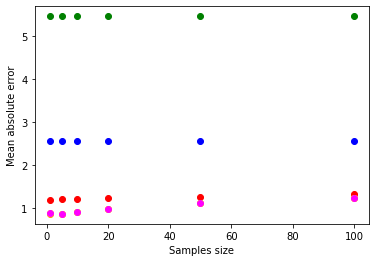

In [79]:

#decision tree
depth=[1, 5, 10, 20, 40, 100]
samples=[1, 5, 10, 20, 50, 100]
for d in depth:
    if d==1:
        co='green'
    elif d==5:
        co='blue'
    elif d==10:
        co='red'
    elif d==20:
        co='orange'
    elif d==40:
        co='yellow'
    elif d==100:
        co='magenta'
    for s in samples:
        dtree = DecisionTreeRegressor(max_depth=d, min_samples_leaf=s, random_state=1)
        dtree.fit(train_X1, train_y1)
        dec_preds= dtree.predict(val_X1)
        plt.xlabel('Samples size')
        plt.ylabel('Mean absolute error')
        plt.scatter(s, mean_absolute_error(val_y1, dec_preds), c=co)

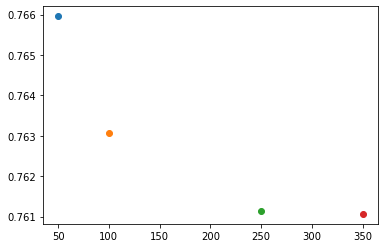

In [80]:
n_estimators=[50,100, 250, 350]
for n in n_estimators:
    forest_model1 = RandomForestRegressor(n_estimators=n, random_state=1)
    forest_model1.fit(train_X1, train_y1)
    forest1_preds = forest_model1.predict(val_X1)
    plt.scatter(n, mean_absolute_error(val_y1, forest1_preds))

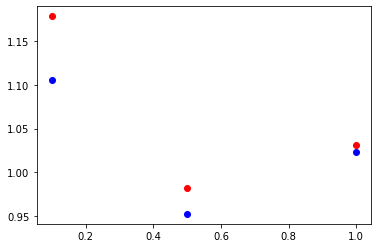

In [85]:
#gradient boost
nest=[1200, 1800]
lra=[ 0.1, 0.5, 1]
for nes in nest:
    if nes==1200:
        co='red'
    elif nes==1800:
        co='blue'
    #elif nes==1000:
       # co='orange'        
    for lr in lra:    
        grad=GradientBoostingRegressor(learning_rate=lr, n_estimators=nes, subsample=1)
        grad.fit(train_X1, train_y1)
        grad1_preds=grad.predict(val_X1)
        plt.scatter(lr, mean_absolute_error(val_y1, grad1_preds), c=co)

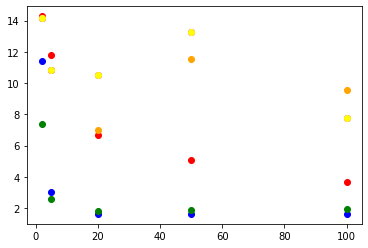

In [82]:
#light       
lnes=[1, 5, 10, 50, 100, 500]
leaves=[2, 5, 20, 50, 100]
for lne in lnes:
    if lne==1:
        co='red'
    elif lne==5:
        co='blue'
    elif lne==10:
        co='green'
    elif lne==50:
        co='orange'
    elif lne==100:
        co='magenta'
    elif lne==500:
        co='yellow'
    
    for le in leaves:
        light = lgm.LGBMClassifier(num_leaves=le, n_estimators=lne)
        light.fit(train_X1, train_y1)
        lpreds1=light.predict(val_X1)
        plt.scatter(le, mean_absolute_error(val_y1, lpreds1), c=co)

Epoch 1/100
1728/1728 [==============================] - 7s 4ms/step - loss: 8.2267 - val_loss: 8.7674
Epoch 2/100
1728/1728 [==============================] - 6s 3ms/step - loss: 4.8400 - val_loss: 4.1201
Epoch 3/100
1728/1728 [==============================] - 6s 3ms/step - loss: 4.3514 - val_loss: 5.4043
Epoch 4/100
1728/1728 [==============================] - 6s 3ms/step - loss: 4.1486 - val_loss: 4.4758
Epoch 5/100
1728/1728 [==============================] - 6s 3ms/step - loss: 3.4504 - val_loss: 3.3984
Epoch 6/100
1728/1728 [==============================] - 6s 3ms/step - loss: 2.9700 - val_loss: 3.0865
Epoch 7/100
1728/1728 [==============================] - 6s 4ms/step - loss: 2.8158 - val_loss: 2.5598
Epoch 8/100
1728/1728 [==============================] - 6s 3ms/step - loss: 2.6692 - val_loss: 2.9249
Epoch 9/100
1728/1728 [==============================] - 6s 4ms/step - loss: 2.6141 - val_loss: 2.7094
Epoch 10/100
1728/1728 [==============================] - 6s 4ms/step - l

Epoch 80/100
1728/1728 [==============================] - 6s 3ms/step - loss: 1.9251 - val_loss: 1.9078
Epoch 81/100
1728/1728 [==============================] - 6s 3ms/step - loss: 1.9169 - val_loss: 1.8388
Epoch 82/100
1728/1728 [==============================] - 6s 3ms/step - loss: 1.9026 - val_loss: 2.1683
Epoch 83/100
1728/1728 [==============================] - 6s 3ms/step - loss: 1.9107 - val_loss: 2.1837
Epoch 84/100
1728/1728 [==============================] - 13s 7ms/step - loss: 1.9018 - val_loss: 1.8391
Epoch 85/100
1728/1728 [==============================] - 9s 5ms/step - loss: 1.8992 - val_loss: 1.8990
Epoch 86/100
1728/1728 [==============================] - 9s 5ms/step - loss: 1.8993 - val_loss: 1.9334
Epoch 87/100
1728/1728 [==============================] - 12s 7ms/step - loss: 1.8984 - val_loss: 1.9356
Epoch 88/100
1728/1728 [==============================] - 8s 4ms/step - loss: 1.9009 - val_loss: 1.9511
Epoch 89/100
1728/1728 [==============================] - 8s 5

No handles with labels found to put in legend.


1.8447104136392014
0.9411786398789679
Epoch 1/100
864/864 [==============================] - 6s 7ms/step - loss: 8.0810 - val_loss: 4.1653
Epoch 2/100
864/864 [==============================] - 5s 5ms/step - loss: 5.2646 - val_loss: 4.6258
Epoch 3/100
864/864 [==============================] - 5s 6ms/step - loss: 4.5375 - val_loss: 4.0130
Epoch 4/100
864/864 [==============================] - 5s 6ms/step - loss: 4.3731 - val_loss: 3.9575
Epoch 5/100
864/864 [==============================] - 5s 6ms/step - loss: 4.1853 - val_loss: 3.9199
Epoch 6/100
864/864 [==============================] - 5s 6ms/step - loss: 4.1479 - val_loss: 3.7322
Epoch 7/100
864/864 [==============================] - 5s 5ms/step - loss: 3.6080 - val_loss: 3.2497
Epoch 8/100
864/864 [==============================] - 5s 5ms/step - loss: 3.2477 - val_loss: 4.1665
Epoch 9/100
864/864 [==============================] - 5s 5ms/step - loss: 3.0932 - val_loss: 2.8786
Epoch 10/100
864/864 [==============================]

864/864 [==============================] - 5s 6ms/step - loss: 1.8798 - val_loss: 1.9004
Epoch 82/100
864/864 [==============================] - 5s 6ms/step - loss: 1.8793 - val_loss: 1.9525
Epoch 83/100
864/864 [==============================] - 5s 6ms/step - loss: 1.8749 - val_loss: 1.9085
Epoch 84/100
864/864 [==============================] - 5s 5ms/step - loss: 1.8683 - val_loss: 1.8580
Epoch 85/100
864/864 [==============================] - 5s 5ms/step - loss: 1.8752 - val_loss: 1.8192
Epoch 86/100
864/864 [==============================] - 5s 6ms/step - loss: 1.8712 - val_loss: 1.8553
Epoch 87/100
864/864 [==============================] - 5s 5ms/step - loss: 1.8703 - val_loss: 1.8135
Epoch 88/100
864/864 [==============================] - 5s 6ms/step - loss: 1.8466 - val_loss: 1.8154
Epoch 89/100
864/864 [==============================] - 5s 5ms/step - loss: 1.8598 - val_loss: 1.8149
Epoch 90/100
864/864 [==============================] - 5s 5ms/step - loss: 1.8262 - val_loss: 

No handles with labels found to put in legend.


1.8565135457126565
0.939331409091977
Epoch 1/100
576/576 [==============================] - 5s 9ms/step - loss: 8.4456 - val_loss: 7.6771
Epoch 2/100
576/576 [==============================] - 4s 8ms/step - loss: 4.9846 - val_loss: 5.4548
Epoch 3/100
576/576 [==============================] - 5s 8ms/step - loss: 4.6802 - val_loss: 3.9556
Epoch 4/100
576/576 [==============================] - 4s 8ms/step - loss: 4.5332 - val_loss: 4.4911
Epoch 5/100
576/576 [==============================] - 5s 8ms/step - loss: 4.3784 - val_loss: 5.8528
Epoch 6/100
576/576 [==============================] - 4s 8ms/step - loss: 4.3246 - val_loss: 3.9474
Epoch 7/100
576/576 [==============================] - 5s 8ms/step - loss: 4.1843 - val_loss: 3.7792
Epoch 8/100
576/576 [==============================] - 5s 8ms/step - loss: 4.0239 - val_loss: 4.1384
Epoch 9/100
576/576 [==============================] - 4s 8ms/step - loss: 3.8014 - val_loss: 3.2890
Epoch 10/100
576/576 [==============================] 

576/576 [==============================] - 5s 8ms/step - loss: 1.8203 - val_loss: 1.8702
Epoch 82/100
576/576 [==============================] - 4s 7ms/step - loss: 1.8222 - val_loss: 1.8540
Epoch 83/100
576/576 [==============================] - 4s 8ms/step - loss: 1.8127 - val_loss: 1.8531
Epoch 84/100
576/576 [==============================] - 4s 7ms/step - loss: 1.8064 - val_loss: 1.7772
Epoch 85/100
576/576 [==============================] - 4s 8ms/step - loss: 1.8098 - val_loss: 1.8152
Epoch 86/100
576/576 [==============================] - 4s 8ms/step - loss: 1.7970 - val_loss: 1.8820
Epoch 87/100
576/576 [==============================] - 4s 8ms/step - loss: 1.8172 - val_loss: 1.7435
Epoch 88/100
576/576 [==============================] - 4s 8ms/step - loss: 1.7979 - val_loss: 1.9273
Epoch 89/100
576/576 [==============================] - 4s 8ms/step - loss: 1.7935 - val_loss: 1.8210
Epoch 90/100
576/576 [==============================] - 4s 8ms/step - loss: 1.7986 - val_loss: 

No handles with labels found to put in legend.


1.6980741124783532
0.9526073226098646
Epoch 1/100
432/432 [==============================] - 5s 11ms/step - loss: 10.3837 - val_loss: 4.9676
Epoch 2/100
432/432 [==============================] - 5s 11ms/step - loss: 6.2189 - val_loss: 4.3325
Epoch 3/100
432/432 [==============================] - 4s 10ms/step - loss: 4.6225 - val_loss: 4.7715
Epoch 4/100
432/432 [==============================] - 4s 9ms/step - loss: 5.0095 - val_loss: 3.9475
Epoch 5/100
432/432 [==============================] - 4s 9ms/step - loss: 4.2232 - val_loss: 4.1706
Epoch 6/100
432/432 [==============================] - 4s 10ms/step - loss: 4.3323 - val_loss: 3.9911
Epoch 7/100
432/432 [==============================] - 4s 10ms/step - loss: 4.3424 - val_loss: 3.7784
Epoch 8/100
432/432 [==============================] - 4s 10ms/step - loss: 4.0828 - val_loss: 3.6124
Epoch 9/100
432/432 [==============================] - 5s 11ms/step - loss: 3.8672 - val_loss: 3.4289
Epoch 10/100
432/432 [=======================

No handles with labels found to put in legend.


1.7926951128957238
0.9469110819196762
Epoch 1/100
346/346 [==============================] - 5s 14ms/step - loss: 12.4741 - val_loss: 4.8871
Epoch 2/100
346/346 [==============================] - 4s 12ms/step - loss: 7.1339 - val_loss: 6.7387
Epoch 3/100
346/346 [==============================] - 4s 11ms/step - loss: 5.4880 - val_loss: 6.2892
Epoch 4/100
346/346 [==============================] - 4s 12ms/step - loss: 4.8263 - val_loss: 5.8520
Epoch 5/100
346/346 [==============================] - 4s 12ms/step - loss: 4.8869 - val_loss: 4.3572
Epoch 6/100
346/346 [==============================] - 4s 12ms/step - loss: 5.2159 - val_loss: 5.3077
Epoch 7/100
346/346 [==============================] - 5s 13ms/step - loss: 4.3951 - val_loss: 4.5943
Epoch 8/100
346/346 [==============================] - 4s 12ms/step - loss: 4.7323 - val_loss: 5.9757
Epoch 9/100
346/346 [==============================] - 4s 11ms/step - loss: 4.4364 - val_loss: 6.5135
Epoch 10/100
346/346 [=====================

No handles with labels found to put in legend.


1.8721303422903441
0.9435188213980233
Epoch 1/100
288/288 [==============================] - 5s 16ms/step - loss: 13.7341 - val_loss: 20.0349
Epoch 2/100
288/288 [==============================] - 4s 14ms/step - loss: 6.7362 - val_loss: 6.3968
Epoch 3/100
288/288 [==============================] - 4s 13ms/step - loss: 8.0700 - val_loss: 3.9814
Epoch 4/100
288/288 [==============================] - 4s 13ms/step - loss: 4.5150 - val_loss: 5.1544
Epoch 5/100
288/288 [==============================] - 4s 13ms/step - loss: 6.2097 - val_loss: 4.3338
Epoch 6/100
288/288 [==============================] - 4s 13ms/step - loss: 5.0204 - val_loss: 3.9438
Epoch 7/100
288/288 [==============================] - 4s 13ms/step - loss: 4.2430 - val_loss: 4.2326
Epoch 8/100
288/288 [==============================] - 4s 14ms/step - loss: 4.2394 - val_loss: 6.3246
Epoch 9/100
288/288 [==============================] - 5s 16ms/step - loss: 4.2942 - val_loss: 5.4393
Epoch 10/100
288/288 [====================

No handles with labels found to put in legend.


1.8114886091990163
0.9440774407700155
Epoch 1/300
1728/1728 [==============================] - 6s 4ms/step - loss: 6.7658 - val_loss: 11.2191
Epoch 2/300
1728/1728 [==============================] - 6s 3ms/step - loss: 4.6004 - val_loss: 3.7136
Epoch 3/300
1728/1728 [==============================] - 6s 3ms/step - loss: 3.9587 - val_loss: 3.5757
Epoch 4/300
1728/1728 [==============================] - 6s 4ms/step - loss: 3.5021 - val_loss: 3.4980
Epoch 5/300
1728/1728 [==============================] - 6s 3ms/step - loss: 3.2129 - val_loss: 2.8699
Epoch 6/300
1728/1728 [==============================] - 6s 3ms/step - loss: 2.9855 - val_loss: 2.9917
Epoch 7/300
1728/1728 [==============================] - 6s 3ms/step - loss: 2.8586 - val_loss: 2.5877
Epoch 8/300
1728/1728 [==============================] - 6s 3ms/step - loss: 2.7558 - val_loss: 2.5684
Epoch 9/300
1728/1728 [==============================] - 6s 3ms/step - loss: 2.6580 - val_loss: 2.5979
Epoch 10/300
1728/1728 [==========

1728/1728 [==============================] - 6s 4ms/step - loss: 1.8256 - val_loss: 1.8593
Epoch 158/300
1728/1728 [==============================] - 6s 3ms/step - loss: 1.8275 - val_loss: 1.8867
Epoch 159/300
1728/1728 [==============================] - 6s 3ms/step - loss: 1.8248 - val_loss: 1.8236
Epoch 160/300
1728/1728 [==============================] - 6s 3ms/step - loss: 1.8190 - val_loss: 1.8917
Epoch 161/300
1728/1728 [==============================] - 6s 4ms/step - loss: 1.8217 - val_loss: 1.9063
Epoch 162/300
1728/1728 [==============================] - 6s 3ms/step - loss: 1.8172 - val_loss: 1.8653
Epoch 163/300
1728/1728 [==============================] - 6s 3ms/step - loss: 1.8212 - val_loss: 1.8409
Epoch 164/300
1728/1728 [==============================] - 6s 3ms/step - loss: 1.8204 - val_loss: 1.9405
Epoch 165/300
1728/1728 [==============================] - 6s 3ms/step - loss: 1.8226 - val_loss: 1.7631
Epoch 166/300
1728/1728 [==============================] - 6s 3ms/ste

No handles with labels found to put in legend.


1.8259610709842924
0.9493466859861599
Epoch 1/300
864/864 [==============================] - 5s 6ms/step - loss: 8.2130 - val_loss: 4.1387
Epoch 2/300
864/864 [==============================] - 5s 5ms/step - loss: 4.6437 - val_loss: 4.1208
Epoch 3/300
864/864 [==============================] - 5s 5ms/step - loss: 4.3492 - val_loss: 4.2298
Epoch 4/300
864/864 [==============================] - 5s 5ms/step - loss: 4.0236 - val_loss: 3.2601
Epoch 5/300
864/864 [==============================] - 5s 6ms/step - loss: 3.5436 - val_loss: 3.0788
Epoch 6/300
864/864 [==============================] - 5s 6ms/step - loss: 3.2368 - val_loss: 2.9274
Epoch 7/300
864/864 [==============================] - 5s 6ms/step - loss: 3.0984 - val_loss: 2.9336
Epoch 8/300
864/864 [==============================] - 5s 6ms/step - loss: 2.9792 - val_loss: 2.9060
Epoch 9/300
864/864 [==============================] - 5s 6ms/step - loss: 2.9209 - val_loss: 2.7921
Epoch 10/300
864/864 [==============================]

864/864 [==============================] - 5s 6ms/step - loss: 1.8173 - val_loss: 1.9085
Epoch 82/300
864/864 [==============================] - 5s 5ms/step - loss: 1.8093 - val_loss: 1.7513
Epoch 83/300
864/864 [==============================] - 5s 5ms/step - loss: 1.8011 - val_loss: 1.7814
Epoch 84/300
864/864 [==============================] - 5s 5ms/step - loss: 1.8007 - val_loss: 1.7687
Epoch 85/300
864/864 [==============================] - 5s 6ms/step - loss: 1.8010 - val_loss: 1.8376
Epoch 86/300
864/864 [==============================] - 5s 6ms/step - loss: 1.7874 - val_loss: 1.7496
Epoch 87/300
864/864 [==============================] - 5s 6ms/step - loss: 1.7939 - val_loss: 1.7945
Epoch 88/300
864/864 [==============================] - 5s 5ms/step - loss: 1.7853 - val_loss: 1.7653
Epoch 89/300
864/864 [==============================] - 5s 5ms/step - loss: 1.7938 - val_loss: 1.7830
Epoch 90/300
864/864 [==============================] - 5s 5ms/step - loss: 1.7846 - val_loss: 

Epoch 161/300
864/864 [==============================] - 5s 5ms/step - loss: 1.6379 - val_loss: 1.6809
Epoch 162/300
864/864 [==============================] - 5s 5ms/step - loss: 1.6420 - val_loss: 1.6554
Epoch 163/300
864/864 [==============================] - 5s 5ms/step - loss: 1.6420 - val_loss: 1.6359
Epoch 164/300
864/864 [==============================] - 5s 5ms/step - loss: 1.6379 - val_loss: 1.6133
Epoch 165/300
864/864 [==============================] - 5s 5ms/step - loss: 1.6384 - val_loss: 1.6037
Epoch 166/300
864/864 [==============================] - 5s 5ms/step - loss: 1.6335 - val_loss: 1.5987
Epoch 167/300
864/864 [==============================] - 5s 5ms/step - loss: 1.6374 - val_loss: 1.6458
Epoch 168/300
864/864 [==============================] - 5s 5ms/step - loss: 1.6294 - val_loss: 1.6526
Epoch 169/300
864/864 [==============================] - 5s 6ms/step - loss: 1.6339 - val_loss: 1.6782
Epoch 170/300
864/864 [==============================] - 5s 6ms/step - lo

No handles with labels found to put in legend.


1.5232383426271194
0.9633224203878082
Epoch 1/300
576/576 [==============================] - 5s 9ms/step - loss: 11.4031 - val_loss: 4.2456
Epoch 2/300
576/576 [==============================] - 4s 8ms/step - loss: 5.0085 - val_loss: 3.9639
Epoch 3/300
576/576 [==============================] - 4s 8ms/step - loss: 4.9706 - val_loss: 3.9787
Epoch 4/300
576/576 [==============================] - 4s 8ms/step - loss: 4.4927 - val_loss: 5.3679
Epoch 5/300
576/576 [==============================] - 4s 8ms/step - loss: 4.4891 - val_loss: 4.3512
Epoch 6/300
576/576 [==============================] - 5s 10ms/step - loss: 4.2530 - val_loss: 4.1514
Epoch 7/300
576/576 [==============================] - 4s 8ms/step - loss: 4.2739 - val_loss: 3.6456
Epoch 8/300
576/576 [==============================] - 5s 8ms/step - loss: 3.7969 - val_loss: 3.3192
Epoch 9/300
576/576 [==============================] - 4s 8ms/step - loss: 3.4298 - val_loss: 3.2386
Epoch 10/300
576/576 [=============================

576/576 [==============================] - 4s 8ms/step - loss: 1.8130 - val_loss: 1.8235
Epoch 82/300
576/576 [==============================] - 4s 8ms/step - loss: 1.8079 - val_loss: 1.7974
Epoch 83/300
576/576 [==============================] - 6s 10ms/step - loss: 1.8152 - val_loss: 1.8728
Epoch 84/300
576/576 [==============================] - 5s 8ms/step - loss: 1.8069 - val_loss: 1.8226
Epoch 85/300
576/576 [==============================] - 4s 8ms/step - loss: 1.8040 - val_loss: 1.8022
Epoch 86/300
576/576 [==============================] - 4s 8ms/step - loss: 1.7972 - val_loss: 1.8081
Epoch 87/300
576/576 [==============================] - 4s 8ms/step - loss: 1.8114 - val_loss: 1.7732
Epoch 88/300
576/576 [==============================] - 4s 8ms/step - loss: 1.7969 - val_loss: 1.7646
Epoch 89/300
576/576 [==============================] - 4s 8ms/step - loss: 1.7999 - val_loss: 1.8267
Epoch 90/300
576/576 [==============================] - 5s 8ms/step - loss: 1.7941 - val_loss:

Epoch 161/300
576/576 [==============================] - 4s 7ms/step - loss: 1.6127 - val_loss: 1.6658
Epoch 162/300
576/576 [==============================] - 4s 8ms/step - loss: 1.6208 - val_loss: 1.6138
Epoch 163/300
576/576 [==============================] - 4s 7ms/step - loss: 1.6118 - val_loss: 1.6005
Epoch 164/300
576/576 [==============================] - 4s 7ms/step - loss: 1.5966 - val_loss: 1.6592
Epoch 165/300
576/576 [==============================] - 4s 7ms/step - loss: 1.6144 - val_loss: 1.6451
Epoch 166/300
576/576 [==============================] - 4s 7ms/step - loss: 1.5950 - val_loss: 1.6449
Epoch 167/300
576/576 [==============================] - 4s 7ms/step - loss: 1.5988 - val_loss: 1.6825
Epoch 168/300
576/576 [==============================] - 4s 7ms/step - loss: 1.5889 - val_loss: 1.6011
Epoch 169/300
576/576 [==============================] - 4s 7ms/step - loss: 1.6048 - val_loss: 1.6811
Epoch 170/300
576/576 [==============================] - 4s 7ms/step - lo

No handles with labels found to put in legend.


1.4914851337893849
0.9647872339613185
Epoch 1/300
432/432 [==============================] - 5s 11ms/step - loss: 14.0727 - val_loss: 9.1203
Epoch 2/300
432/432 [==============================] - 4s 10ms/step - loss: 6.6893 - val_loss: 8.7571
Epoch 3/300
432/432 [==============================] - 4s 10ms/step - loss: 5.2983 - val_loss: 3.9507
Epoch 4/300
432/432 [==============================] - 4s 10ms/step - loss: 5.2777 - val_loss: 10.7316
Epoch 5/300
432/432 [==============================] - 4s 10ms/step - loss: 4.6523 - val_loss: 4.3692
Epoch 6/300
432/432 [==============================] - 4s 9ms/step - loss: 5.0265 - val_loss: 3.8021
Epoch 7/300
432/432 [==============================] - 4s 9ms/step - loss: 4.3406 - val_loss: 3.6451
Epoch 8/300
432/432 [==============================] - 4s 9ms/step - loss: 4.7003 - val_loss: 3.3296
Epoch 9/300
432/432 [==============================] - 4s 10ms/step - loss: 3.7581 - val_loss: 3.4714
Epoch 10/300
432/432 [=======================

432/432 [==============================] - 4s 10ms/step - loss: 1.5663 - val_loss: 1.5998
Epoch 160/300
432/432 [==============================] - 4s 9ms/step - loss: 1.5688 - val_loss: 1.6383
Epoch 161/300
432/432 [==============================] - 4s 10ms/step - loss: 1.5605 - val_loss: 1.6351
Epoch 162/300
432/432 [==============================] - 4s 9ms/step - loss: 1.5588 - val_loss: 1.5856
Epoch 163/300
432/432 [==============================] - 4s 10ms/step - loss: 1.5683 - val_loss: 1.6462
Epoch 164/300
432/432 [==============================] - 4s 10ms/step - loss: 1.5593 - val_loss: 1.6029
Epoch 165/300
432/432 [==============================] - 5s 11ms/step - loss: 1.5571 - val_loss: 1.6267
Epoch 166/300
432/432 [==============================] - 4s 10ms/step - loss: 1.5583 - val_loss: 1.6484
Epoch 167/300
432/432 [==============================] - 4s 10ms/step - loss: 1.5557 - val_loss: 1.6176
Epoch 168/300
432/432 [==============================] - 4s 9ms/step - loss: 1.5

432/432 [==============================] - 4s 10ms/step - loss: 1.4520 - val_loss: 1.4926
Epoch 239/300
432/432 [==============================] - 4s 9ms/step - loss: 1.4694 - val_loss: 1.5496
Epoch 240/300
432/432 [==============================] - 4s 10ms/step - loss: 1.4747 - val_loss: 1.4832
Epoch 241/300
432/432 [==============================] - 4s 10ms/step - loss: 1.4509 - val_loss: 1.6013
Epoch 242/300
432/432 [==============================] - 5s 11ms/step - loss: 1.4656 - val_loss: 1.5895
Epoch 243/300
432/432 [==============================] - 4s 9ms/step - loss: 1.4521 - val_loss: 1.5067
Epoch 244/300
432/432 [==============================] - 4s 9ms/step - loss: 1.4462 - val_loss: 1.5097
Epoch 245/300
432/432 [==============================] - 4s 9ms/step - loss: 1.4623 - val_loss: 1.4836
Epoch 246/300
432/432 [==============================] - 4s 10ms/step - loss: 1.4542 - val_loss: 1.5409
Epoch 247/300
432/432 [==============================] - 4s 9ms/step - loss: 1.446

No handles with labels found to put in legend.


1.4256968903530798
0.9678807180287757
Epoch 1/300
346/346 [==============================] - 5s 14ms/step - loss: 12.8936 - val_loss: 4.0555
Epoch 2/300
346/346 [==============================] - 5s 14ms/step - loss: 5.4157 - val_loss: 4.1113
Epoch 3/300
346/346 [==============================] - 4s 12ms/step - loss: 6.1016 - val_loss: 3.9840
Epoch 4/300
346/346 [==============================] - 4s 12ms/step - loss: 4.4173 - val_loss: 3.9267
Epoch 5/300
346/346 [==============================] - 4s 12ms/step - loss: 4.9147 - val_loss: 4.1881
Epoch 6/300
346/346 [==============================] - 4s 11ms/step - loss: 4.5939 - val_loss: 4.0592
Epoch 7/300
346/346 [==============================] - 4s 12ms/step - loss: 4.3338 - val_loss: 6.5607
Epoch 8/300
346/346 [==============================] - 4s 12ms/step - loss: 3.7254 - val_loss: 3.7320
Epoch 9/300
346/346 [==============================] - 4s 12ms/step - loss: 4.0406 - val_loss: 3.2615
Epoch 10/300
346/346 [=====================

346/346 [==============================] - 4s 12ms/step - loss: 1.6871 - val_loss: 1.7612
Epoch 160/300
346/346 [==============================] - 4s 12ms/step - loss: 1.6846 - val_loss: 1.6837
Epoch 161/300
346/346 [==============================] - 4s 12ms/step - loss: 1.7074 - val_loss: 1.7371
Epoch 162/300
346/346 [==============================] - 4s 13ms/step - loss: 1.6734 - val_loss: 1.7401
Epoch 163/300
346/346 [==============================] - 4s 12ms/step - loss: 1.6967 - val_loss: 1.7289
Epoch 164/300
346/346 [==============================] - 4s 12ms/step - loss: 1.6907 - val_loss: 1.6756
Epoch 165/300
346/346 [==============================] - 4s 12ms/step - loss: 1.6660 - val_loss: 1.7214
Epoch 166/300
346/346 [==============================] - 4s 12ms/step - loss: 1.6760 - val_loss: 1.7211
Epoch 167/300
346/346 [==============================] - 4s 12ms/step - loss: 1.6539 - val_loss: 1.7703
Epoch 168/300
346/346 [==============================] - 4s 12ms/step - loss: 

Epoch 238/300
346/346 [==============================] - 4s 12ms/step - loss: 1.5400 - val_loss: 1.5663
Epoch 239/300
346/346 [==============================] - 4s 12ms/step - loss: 1.5374 - val_loss: 1.5642
Epoch 240/300
346/346 [==============================] - 4s 12ms/step - loss: 1.5339 - val_loss: 1.5712
Epoch 241/300
346/346 [==============================] - 4s 12ms/step - loss: 1.5330 - val_loss: 1.5592
Epoch 242/300
346/346 [==============================] - 5s 14ms/step - loss: 1.5308 - val_loss: 1.7113
Epoch 243/300
346/346 [==============================] - 4s 12ms/step - loss: 1.5377 - val_loss: 1.6349
Epoch 244/300
346/346 [==============================] - 4s 12ms/step - loss: 1.5261 - val_loss: 1.5278
Epoch 245/300
346/346 [==============================] - 4s 11ms/step - loss: 1.5366 - val_loss: 1.5036
Epoch 246/300
346/346 [==============================] - 4s 12ms/step - loss: 1.5413 - val_loss: 1.5699
Epoch 247/300
346/346 [==============================] - 4s 11ms

No handles with labels found to put in legend.


1.5217136508986437
0.9660859302607405
Epoch 1/300
288/288 [==============================] - 5s 16ms/step - loss: 14.8560 - val_loss: 8.1260
Epoch 2/300
288/288 [==============================] - 4s 14ms/step - loss: 8.2187 - val_loss: 6.6392
Epoch 3/300
288/288 [==============================] - 4s 14ms/step - loss: 5.6885 - val_loss: 4.2571
Epoch 4/300
288/288 [==============================] - 4s 15ms/step - loss: 5.3401 - val_loss: 4.3081
Epoch 5/300
288/288 [==============================] - 4s 14ms/step - loss: 4.8859 - val_loss: 4.0072
Epoch 6/300
288/288 [==============================] - 4s 13ms/step - loss: 4.6523 - val_loss: 5.9750
Epoch 7/300
288/288 [==============================] - 4s 13ms/step - loss: 4.4273 - val_loss: 4.1464
Epoch 8/300
288/288 [==============================] - 4s 14ms/step - loss: 4.3414 - val_loss: 4.8030
Epoch 9/300
288/288 [==============================] - 4s 14ms/step - loss: 4.4077 - val_loss: 4.0815
Epoch 10/300
288/288 [=====================

288/288 [==============================] - 4s 14ms/step - loss: 1.6838 - val_loss: 1.7399
Epoch 160/300
288/288 [==============================] - 4s 14ms/step - loss: 1.6726 - val_loss: 1.7357
Epoch 161/300
288/288 [==============================] - 4s 13ms/step - loss: 1.6621 - val_loss: 1.7208
Epoch 162/300
288/288 [==============================] - 4s 14ms/step - loss: 1.6759 - val_loss: 1.7071
Epoch 163/300
288/288 [==============================] - 4s 13ms/step - loss: 1.6404 - val_loss: 1.6898
Epoch 164/300
288/288 [==============================] - 4s 14ms/step - loss: 1.6595 - val_loss: 1.6597
Epoch 165/300
288/288 [==============================] - 4s 14ms/step - loss: 1.6682 - val_loss: 1.6876
Epoch 166/300
288/288 [==============================] - 5s 17ms/step - loss: 1.6404 - val_loss: 1.6794
Epoch 167/300
288/288 [==============================] - 4s 14ms/step - loss: 1.6402 - val_loss: 1.6458
Epoch 168/300
288/288 [==============================] - 4s 14ms/step - loss: 

Epoch 238/300
288/288 [==============================] - 4s 13ms/step - loss: 1.5066 - val_loss: 1.5435
Epoch 239/300
288/288 [==============================] - 4s 13ms/step - loss: 1.5018 - val_loss: 1.5645
Epoch 240/300
288/288 [==============================] - 4s 14ms/step - loss: 1.5045 - val_loss: 1.5009
Epoch 241/300
288/288 [==============================] - 4s 14ms/step - loss: 1.4964 - val_loss: 1.5969
Epoch 242/300
288/288 [==============================] - 4s 14ms/step - loss: 1.5219 - val_loss: 1.5361
Epoch 243/300
288/288 [==============================] - 4s 14ms/step - loss: 1.4956 - val_loss: 1.5000
Epoch 244/300
288/288 [==============================] - 4s 13ms/step - loss: 1.4948 - val_loss: 1.5177
Epoch 245/300
288/288 [==============================] - 4s 14ms/step - loss: 1.4849 - val_loss: 1.5330
Epoch 246/300
288/288 [==============================] - 4s 14ms/step - loss: 1.5075 - val_loss: 1.5019
Epoch 247/300
288/288 [==============================] - 4s 14ms

No handles with labels found to put in legend.


1.5475981103371446
0.9655067570121497
Epoch 1/500
1728/1728 [==============================] - 7s 4ms/step - loss: 7.0694 - val_loss: 7.2340
Epoch 2/500
1728/1728 [==============================] - 6s 4ms/step - loss: 4.7697 - val_loss: 4.0353
Epoch 3/500
1728/1728 [==============================] - 6s 3ms/step - loss: 4.2585 - val_loss: 3.9615
Epoch 4/500
1728/1728 [==============================] - 7s 4ms/step - loss: 3.9694 - val_loss: 3.9855
Epoch 5/500
1728/1728 [==============================] - 6s 4ms/step - loss: 3.2911 - val_loss: 2.9397
Epoch 6/500
1728/1728 [==============================] - 6s 4ms/step - loss: 2.9744 - val_loss: 3.1006
Epoch 7/500
1728/1728 [==============================] - 7s 4ms/step - loss: 2.8126 - val_loss: 2.8348
Epoch 8/500
1728/1728 [==============================] - 6s 4ms/step - loss: 2.6930 - val_loss: 2.5814
Epoch 9/500
1728/1728 [==============================] - 6s 3ms/step - loss: 2.6342 - val_loss: 2.8005
Epoch 10/500
1728/1728 [===========

1728/1728 [==============================] - 6s 4ms/step - loss: 1.8359 - val_loss: 1.8217
Epoch 156/500
1728/1728 [==============================] - 7s 4ms/step - loss: 1.8268 - val_loss: 1.9100
Epoch 157/500
1728/1728 [==============================] - 7s 4ms/step - loss: 1.8393 - val_loss: 2.0080
Epoch 158/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.8364 - val_loss: 1.9380
Epoch 159/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.8383 - val_loss: 1.8264
Epoch 160/500
1728/1728 [==============================] - 6s 3ms/step - loss: 1.8399 - val_loss: 1.8260
Epoch 161/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.8313 - val_loss: 1.8602
Epoch 162/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.8351 - val_loss: 1.8263
Epoch 163/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.8273 - val_loss: 1.8095
Epoch 164/500
1728/1728 [==============================] - 6s 4ms/ste

1728/1728 [==============================] - 7s 4ms/step - loss: 1.7384 - val_loss: 1.7729
Epoch 312/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.7463 - val_loss: 1.8676
Epoch 313/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.7330 - val_loss: 1.8400
Epoch 314/500
1728/1728 [==============================] - 6s 3ms/step - loss: 1.7376 - val_loss: 1.8105
Epoch 315/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.7402 - val_loss: 1.7412
Epoch 316/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.7380 - val_loss: 1.7235
Epoch 317/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.7385 - val_loss: 1.7125
Epoch 318/500
1728/1728 [==============================] - 6s 3ms/step - loss: 1.7376 - val_loss: 1.8150
Epoch 319/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.7335 - val_loss: 1.7188
Epoch 320/500
1728/1728 [==============================] - 6s 4ms/ste

1728/1728 [==============================] - 6s 4ms/step - loss: 1.6902 - val_loss: 1.6916
Epoch 468/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6888 - val_loss: 1.6929
Epoch 469/500
1728/1728 [==============================] - 6s 3ms/step - loss: 1.7003 - val_loss: 1.6926
Epoch 470/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6911 - val_loss: 1.7125
Epoch 471/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6897 - val_loss: 1.7168
Epoch 472/500
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6958 - val_loss: 1.6887
Epoch 473/500
1728/1728 [==============================] - 6s 3ms/step - loss: 1.6874 - val_loss: 1.7351
Epoch 474/500
1728/1728 [==============================] - 7s 4ms/step - loss: 1.6908 - val_loss: 1.7123
Epoch 475/500
1728/1728 [==============================] - 7s 4ms/step - loss: 1.6896 - val_loss: 1.6933
Epoch 476/500
1728/1728 [==============================] - 6s 4ms/ste

No handles with labels found to put in legend.


1.7306646953638947
0.9501702448933367
Epoch 1/500
864/864 [==============================] - 6s 6ms/step - loss: 8.5203 - val_loss: 4.0567
Epoch 2/500
864/864 [==============================] - 5s 6ms/step - loss: 4.9045 - val_loss: 5.8170
Epoch 3/500
864/864 [==============================] - 5s 6ms/step - loss: 4.4450 - val_loss: 5.3851
Epoch 4/500
864/864 [==============================] - 5s 6ms/step - loss: 4.2699 - val_loss: 3.6851
Epoch 5/500
864/864 [==============================] - 6s 6ms/step - loss: 3.7767 - val_loss: 3.4129
Epoch 6/500
864/864 [==============================] - 5s 6ms/step - loss: 3.3512 - val_loss: 3.3417
Epoch 7/500
864/864 [==============================] - 5s 6ms/step - loss: 3.2509 - val_loss: 2.9496
Epoch 8/500
864/864 [==============================] - 5s 6ms/step - loss: 3.0973 - val_loss: 2.9704
Epoch 9/500
864/864 [==============================] - 5s 6ms/step - loss: 3.0195 - val_loss: 2.8579
Epoch 10/500
864/864 [==============================]

864/864 [==============================] - 5s 6ms/step - loss: 1.8472 - val_loss: 1.8502
Epoch 82/500
864/864 [==============================] - 5s 6ms/step - loss: 1.8280 - val_loss: 1.9792
Epoch 83/500
864/864 [==============================] - 7s 8ms/step - loss: 1.8273 - val_loss: 1.8630
Epoch 84/500
864/864 [==============================] - 5s 6ms/step - loss: 1.8089 - val_loss: 1.8307
Epoch 85/500
864/864 [==============================] - 5s 6ms/step - loss: 1.8348 - val_loss: 2.1703
Epoch 86/500
864/864 [==============================] - 5s 6ms/step - loss: 1.8114 - val_loss: 1.8024
Epoch 87/500
864/864 [==============================] - 5s 6ms/step - loss: 1.8048 - val_loss: 1.8320
Epoch 88/500
864/864 [==============================] - 5s 6ms/step - loss: 1.8090 - val_loss: 1.7616
Epoch 89/500
864/864 [==============================] - 5s 6ms/step - loss: 1.7981 - val_loss: 1.8257
Epoch 90/500
864/864 [==============================] - 5s 6ms/step - loss: 1.7921 - val_loss: 

Epoch 161/500
864/864 [==============================] - 5s 6ms/step - loss: 1.6511 - val_loss: 1.6596
Epoch 162/500
864/864 [==============================] - 5s 6ms/step - loss: 1.6611 - val_loss: 1.6178
Epoch 163/500
864/864 [==============================] - 5s 6ms/step - loss: 1.6510 - val_loss: 1.7869
Epoch 164/500
864/864 [==============================] - 5s 6ms/step - loss: 1.6581 - val_loss: 1.6765
Epoch 165/500
864/864 [==============================] - 5s 6ms/step - loss: 1.6543 - val_loss: 1.6622
Epoch 166/500
864/864 [==============================] - 5s 6ms/step - loss: 1.6539 - val_loss: 1.6852
Epoch 167/500
864/864 [==============================] - 5s 6ms/step - loss: 1.6471 - val_loss: 1.7081
Epoch 168/500
864/864 [==============================] - 5s 6ms/step - loss: 1.6478 - val_loss: 1.6743
Epoch 169/500
864/864 [==============================] - 5s 6ms/step - loss: 1.6389 - val_loss: 1.6120
Epoch 170/500
864/864 [==============================] - 5s 6ms/step - lo

864/864 [==============================] - 5s 6ms/step - loss: 1.5227 - val_loss: 1.5645
Epoch 320/500
864/864 [==============================] - 5s 6ms/step - loss: 1.5225 - val_loss: 1.5556
Epoch 321/500
864/864 [==============================] - 5s 6ms/step - loss: 1.5232 - val_loss: 1.5551
Epoch 322/500
864/864 [==============================] - 5s 6ms/step - loss: 1.5200 - val_loss: 1.6030
Epoch 323/500
864/864 [==============================] - 5s 6ms/step - loss: 1.5197 - val_loss: 1.5727
Epoch 324/500
864/864 [==============================] - 5s 6ms/step - loss: 1.5238 - val_loss: 1.5540
Epoch 325/500
864/864 [==============================] - 5s 6ms/step - loss: 1.5274 - val_loss: 1.5547
Epoch 326/500
864/864 [==============================] - 5s 6ms/step - loss: 1.5120 - val_loss: 1.5082
Epoch 327/500
864/864 [==============================] - 5s 6ms/step - loss: 1.5094 - val_loss: 1.5460
Epoch 328/500
864/864 [==============================] - 6s 7ms/step - loss: 1.5142 - v

864/864 [==============================] - 5s 6ms/step - loss: 1.4576 - val_loss: 1.4733
Epoch 478/500
864/864 [==============================] - 5s 6ms/step - loss: 1.4637 - val_loss: 1.5296
Epoch 479/500
864/864 [==============================] - 5s 6ms/step - loss: 1.4611 - val_loss: 1.5047
Epoch 480/500
864/864 [==============================] - 5s 6ms/step - loss: 1.4709 - val_loss: 1.4855
Epoch 481/500
864/864 [==============================] - 5s 6ms/step - loss: 1.4620 - val_loss: 1.5555
Epoch 482/500
864/864 [==============================] - 5s 6ms/step - loss: 1.4573 - val_loss: 1.5016
Epoch 483/500
864/864 [==============================] - 5s 6ms/step - loss: 1.4626 - val_loss: 1.4681
Epoch 484/500
864/864 [==============================] - 5s 6ms/step - loss: 1.4617 - val_loss: 1.4870
Epoch 485/500
864/864 [==============================] - 5s 6ms/step - loss: 1.4571 - val_loss: 1.4682
Epoch 486/500
864/864 [==============================] - 5s 6ms/step - loss: 1.4609 - v

No handles with labels found to put in legend.


1.4987921657391323
0.96483997728315
Epoch 1/500
576/576 [==============================] - 5s 9ms/step - loss: 8.5015 - val_loss: 4.1636
Epoch 2/500
576/576 [==============================] - 5s 8ms/step - loss: 5.5755 - val_loss: 8.5603
Epoch 3/500
576/576 [==============================] - 5s 8ms/step - loss: 4.8817 - val_loss: 4.4850
Epoch 4/500
576/576 [==============================] - 4s 8ms/step - loss: 4.6611 - val_loss: 4.1999
Epoch 5/500
576/576 [==============================] - 5s 8ms/step - loss: 4.5343 - val_loss: 4.4610
Epoch 6/500
576/576 [==============================] - 5s 8ms/step - loss: 4.2452 - val_loss: 3.3540
Epoch 7/500
576/576 [==============================] - 5s 8ms/step - loss: 3.7293 - val_loss: 3.2970
Epoch 8/500
576/576 [==============================] - 5s 9ms/step - loss: 3.5208 - val_loss: 3.9812
Epoch 9/500
576/576 [==============================] - 5s 8ms/step - loss: 3.4023 - val_loss: 4.0727
Epoch 10/500
576/576 [==============================] -

576/576 [==============================] - 4s 7ms/step - loss: 1.8096 - val_loss: 1.9294
Epoch 82/500
576/576 [==============================] - 4s 7ms/step - loss: 1.8094 - val_loss: 1.8753
Epoch 83/500
576/576 [==============================] - 4s 7ms/step - loss: 1.8068 - val_loss: 1.8126
Epoch 84/500
576/576 [==============================] - 4s 7ms/step - loss: 1.8068 - val_loss: 1.8217
Epoch 85/500
576/576 [==============================] - 5s 9ms/step - loss: 1.7998 - val_loss: 1.9081
Epoch 86/500
576/576 [==============================] - 4s 7ms/step - loss: 1.7835 - val_loss: 1.7970
Epoch 87/500
576/576 [==============================] - 4s 7ms/step - loss: 1.7931 - val_loss: 1.7630
Epoch 88/500
576/576 [==============================] - 4s 7ms/step - loss: 1.7894 - val_loss: 1.8091
Epoch 89/500
576/576 [==============================] - 4s 7ms/step - loss: 1.7790 - val_loss: 1.8224
Epoch 90/500
576/576 [==============================] - 4s 7ms/step - loss: 1.7853 - val_loss: 

Epoch 161/500
576/576 [==============================] - 4s 7ms/step - loss: 1.5865 - val_loss: 1.6046
Epoch 162/500
576/576 [==============================] - 4s 7ms/step - loss: 1.5857 - val_loss: 1.7063
Epoch 163/500
576/576 [==============================] - 5s 8ms/step - loss: 1.5772 - val_loss: 1.6235
Epoch 164/500
576/576 [==============================] - 4s 8ms/step - loss: 1.5720 - val_loss: 1.5834
Epoch 165/500
576/576 [==============================] - 4s 7ms/step - loss: 1.5847 - val_loss: 1.6247
Epoch 166/500
576/576 [==============================] - 4s 7ms/step - loss: 1.5728 - val_loss: 1.6342
Epoch 167/500
576/576 [==============================] - 4s 7ms/step - loss: 1.5612 - val_loss: 1.5695
Epoch 168/500
576/576 [==============================] - 4s 7ms/step - loss: 1.5703 - val_loss: 1.6077
Epoch 169/500
576/576 [==============================] - 4s 7ms/step - loss: 1.5808 - val_loss: 1.5458
Epoch 170/500
576/576 [==============================] - 4s 7ms/step - lo

576/576 [==============================] - 4s 7ms/step - loss: 1.4160 - val_loss: 1.4064
Epoch 320/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4162 - val_loss: 1.4951
Epoch 321/500
576/576 [==============================] - 5s 8ms/step - loss: 1.4189 - val_loss: 1.4591
Epoch 322/500
576/576 [==============================] - 4s 8ms/step - loss: 1.4134 - val_loss: 1.4537
Epoch 323/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4166 - val_loss: 1.4780
Epoch 324/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4185 - val_loss: 1.4742
Epoch 325/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4260 - val_loss: 1.4977
Epoch 326/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4130 - val_loss: 1.5014
Epoch 327/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4157 - val_loss: 1.4824
Epoch 328/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4142 - v

576/576 [==============================] - 4s 7ms/step - loss: 1.3426 - val_loss: 1.3633
Epoch 478/500
576/576 [==============================] - 4s 8ms/step - loss: 1.3393 - val_loss: 1.4247
Epoch 479/500
576/576 [==============================] - 5s 8ms/step - loss: 1.3442 - val_loss: 1.4817
Epoch 480/500
576/576 [==============================] - 4s 7ms/step - loss: 1.3444 - val_loss: 1.3888
Epoch 481/500
576/576 [==============================] - 4s 7ms/step - loss: 1.3424 - val_loss: 1.4000
Epoch 482/500
576/576 [==============================] - 4s 7ms/step - loss: 1.3464 - val_loss: 1.4514
Epoch 483/500
576/576 [==============================] - 4s 7ms/step - loss: 1.3473 - val_loss: 1.4400
Epoch 484/500
576/576 [==============================] - 4s 7ms/step - loss: 1.3495 - val_loss: 1.3994
Epoch 485/500
576/576 [==============================] - 4s 7ms/step - loss: 1.3326 - val_loss: 1.3955
Epoch 486/500
576/576 [==============================] - 4s 7ms/step - loss: 1.3331 - v

No handles with labels found to put in legend.


1.3914454879043225
0.9711139617569924
Epoch 1/500
432/432 [==============================] - 4s 10ms/step - loss: 10.9676 - val_loss: 4.4209
Epoch 2/500
432/432 [==============================] - 4s 9ms/step - loss: 5.6418 - val_loss: 4.9061
Epoch 3/500
432/432 [==============================] - 4s 9ms/step - loss: 4.8396 - val_loss: 3.9659
Epoch 4/500
432/432 [==============================] - 4s 9ms/step - loss: 4.5007 - val_loss: 4.5319
Epoch 5/500
432/432 [==============================] - 4s 9ms/step - loss: 4.4130 - val_loss: 4.2218
Epoch 6/500
432/432 [==============================] - 4s 9ms/step - loss: 4.3690 - val_loss: 4.4415
Epoch 7/500
432/432 [==============================] - 4s 9ms/step - loss: 4.3520 - val_loss: 3.6545
Epoch 8/500
432/432 [==============================] - 4s 10ms/step - loss: 3.8951 - val_loss: 4.1172
Epoch 9/500
432/432 [==============================] - 4s 10ms/step - loss: 3.7979 - val_loss: 3.4361
Epoch 10/500
432/432 [===========================

Epoch 81/500
432/432 [==============================] - 4s 9ms/step - loss: 1.8261 - val_loss: 1.8185
Epoch 82/500
432/432 [==============================] - 4s 9ms/step - loss: 1.8214 - val_loss: 1.8539
Epoch 83/500
432/432 [==============================] - 4s 9ms/step - loss: 1.8229 - val_loss: 1.9042
Epoch 84/500
432/432 [==============================] - 4s 9ms/step - loss: 1.8080 - val_loss: 1.9007
Epoch 85/500
432/432 [==============================] - 4s 9ms/step - loss: 1.8383 - val_loss: 1.8416
Epoch 86/500
432/432 [==============================] - 4s 9ms/step - loss: 1.8038 - val_loss: 1.8629
Epoch 87/500
432/432 [==============================] - 4s 9ms/step - loss: 1.8176 - val_loss: 1.9222
Epoch 88/500
432/432 [==============================] - 4s 9ms/step - loss: 1.8151 - val_loss: 1.7634
Epoch 89/500
432/432 [==============================] - 4s 9ms/step - loss: 1.7985 - val_loss: 1.8187
Epoch 90/500
432/432 [==============================] - 4s 9ms/step - loss: 1.7946

432/432 [==============================] - 4s 9ms/step - loss: 1.4706 - val_loss: 1.4740
Epoch 240/500
432/432 [==============================] - 4s 9ms/step - loss: 1.4573 - val_loss: 1.5395
Epoch 241/500
432/432 [==============================] - 4s 9ms/step - loss: 1.4525 - val_loss: 1.4822
Epoch 242/500
432/432 [==============================] - 4s 9ms/step - loss: 1.4535 - val_loss: 1.5113
Epoch 243/500
432/432 [==============================] - 4s 10ms/step - loss: 1.4563 - val_loss: 1.4768
Epoch 244/500
432/432 [==============================] - 4s 9ms/step - loss: 1.4495 - val_loss: 1.4231
Epoch 245/500
432/432 [==============================] - 4s 9ms/step - loss: 1.4683 - val_loss: 1.4543
Epoch 246/500
432/432 [==============================] - 4s 9ms/step - loss: 1.4552 - val_loss: 1.5437
Epoch 247/500
432/432 [==============================] - 4s 9ms/step - loss: 1.4497 - val_loss: 1.4326
Epoch 248/500
432/432 [==============================] - 4s 9ms/step - loss: 1.4402 - 

432/432 [==============================] - 4s 9ms/step - loss: 1.3430 - val_loss: 1.3741
Epoch 398/500
432/432 [==============================] - 4s 9ms/step - loss: 1.3467 - val_loss: 1.4448
Epoch 399/500
432/432 [==============================] - 4s 9ms/step - loss: 1.3389 - val_loss: 1.3756
Epoch 400/500
432/432 [==============================] - 4s 9ms/step - loss: 1.3309 - val_loss: 1.3978
Epoch 401/500
432/432 [==============================] - 4s 9ms/step - loss: 1.3455 - val_loss: 1.3720
Epoch 402/500
432/432 [==============================] - 4s 9ms/step - loss: 1.3305 - val_loss: 1.3765
Epoch 403/500
432/432 [==============================] - 4s 9ms/step - loss: 1.3455 - val_loss: 1.3520
Epoch 404/500
432/432 [==============================] - 4s 9ms/step - loss: 1.3337 - val_loss: 1.3987
Epoch 405/500
432/432 [==============================] - 4s 9ms/step - loss: 1.3396 - val_loss: 1.3620
Epoch 406/500
432/432 [==============================] - 4s 9ms/step - loss: 1.3387 - v

No handles with labels found to put in legend.


1.4626626916044165
0.969285996531378
Epoch 1/500
346/346 [==============================] - 4s 13ms/step - loss: 12.1535 - val_loss: 5.9690
Epoch 2/500
346/346 [==============================] - 4s 11ms/step - loss: 6.3841 - val_loss: 7.3649
Epoch 3/500
346/346 [==============================] - 4s 10ms/step - loss: 4.6589 - val_loss: 7.5215
Epoch 4/500
346/346 [==============================] - 3s 10ms/step - loss: 4.8815 - val_loss: 4.2616
Epoch 5/500
346/346 [==============================] - 3s 10ms/step - loss: 4.3696 - val_loss: 9.3889
Epoch 6/500
346/346 [==============================] - 4s 10ms/step - loss: 4.4851 - val_loss: 4.3932
Epoch 7/500
346/346 [==============================] - 4s 10ms/step - loss: 4.7940 - val_loss: 3.5759
Epoch 8/500
346/346 [==============================] - 4s 10ms/step - loss: 4.6123 - val_loss: 3.8566
Epoch 9/500
346/346 [==============================] - 5s 13ms/step - loss: 3.6124 - val_loss: 3.2641
Epoch 10/500
346/346 [======================

346/346 [==============================] - 4s 12ms/step - loss: 1.6382 - val_loss: 1.6329
Epoch 160/500
346/346 [==============================] - 4s 12ms/step - loss: 1.6301 - val_loss: 1.6922
Epoch 161/500
346/346 [==============================] - 4s 12ms/step - loss: 1.6472 - val_loss: 1.6894
Epoch 162/500
346/346 [==============================] - 5s 14ms/step - loss: 1.6176 - val_loss: 1.7318
Epoch 163/500
346/346 [==============================] - 4s 12ms/step - loss: 1.6188 - val_loss: 1.8103
Epoch 164/500
346/346 [==============================] - 4s 12ms/step - loss: 1.6337 - val_loss: 1.6134
Epoch 165/500
346/346 [==============================] - 4s 12ms/step - loss: 1.6247 - val_loss: 1.6178
Epoch 166/500
346/346 [==============================] - 4s 12ms/step - loss: 1.6164 - val_loss: 1.6629
Epoch 167/500
346/346 [==============================] - 4s 12ms/step - loss: 1.6011 - val_loss: 1.7519
Epoch 168/500
346/346 [==============================] - 4s 12ms/step - loss: 

Epoch 238/500
346/346 [==============================] - 4s 12ms/step - loss: 1.5036 - val_loss: 1.6061
Epoch 239/500
346/346 [==============================] - 4s 12ms/step - loss: 1.5112 - val_loss: 1.5392
Epoch 240/500
346/346 [==============================] - 4s 13ms/step - loss: 1.5008 - val_loss: 1.5285
Epoch 241/500
346/346 [==============================] - 5s 13ms/step - loss: 1.4989 - val_loss: 1.5303
Epoch 242/500
346/346 [==============================] - 4s 11ms/step - loss: 1.4980 - val_loss: 1.5294
Epoch 243/500
346/346 [==============================] - 4s 12ms/step - loss: 1.5064 - val_loss: 1.6876
Epoch 244/500
346/346 [==============================] - 4s 12ms/step - loss: 1.5075 - val_loss: 1.5859
Epoch 245/500
346/346 [==============================] - 4s 12ms/step - loss: 1.4931 - val_loss: 1.4966
Epoch 246/500
346/346 [==============================] - 5s 13ms/step - loss: 1.4915 - val_loss: 1.5135
Epoch 247/500
346/346 [==============================] - 4s 13ms

Epoch 317/500
346/346 [==============================] - 4s 11ms/step - loss: 1.4189 - val_loss: 1.4814
Epoch 318/500
346/346 [==============================] - 4s 12ms/step - loss: 1.4229 - val_loss: 1.4855
Epoch 319/500
346/346 [==============================] - 5s 14ms/step - loss: 1.4252 - val_loss: 1.6670
Epoch 320/500
346/346 [==============================] - 4s 12ms/step - loss: 1.4263 - val_loss: 1.4545
Epoch 321/500
346/346 [==============================] - 4s 12ms/step - loss: 1.4291 - val_loss: 1.4550
Epoch 322/500
346/346 [==============================] - 4s 12ms/step - loss: 1.4148 - val_loss: 1.4808
Epoch 323/500
346/346 [==============================] - 4s 12ms/step - loss: 1.4174 - val_loss: 1.5601
Epoch 324/500
346/346 [==============================] - 4s 12ms/step - loss: 1.4212 - val_loss: 1.4726
Epoch 325/500
346/346 [==============================] - 4s 12ms/step - loss: 1.4282 - val_loss: 1.5132
Epoch 326/500
346/346 [==============================] - 4s 12ms

Epoch 396/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3714 - val_loss: 1.4592
Epoch 397/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3644 - val_loss: 1.3899
Epoch 398/500
346/346 [==============================] - 5s 14ms/step - loss: 1.3649 - val_loss: 1.4189
Epoch 399/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3647 - val_loss: 1.3942
Epoch 400/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3724 - val_loss: 1.4028
Epoch 401/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3558 - val_loss: 1.4652
Epoch 402/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3699 - val_loss: 1.4063
Epoch 403/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3769 - val_loss: 1.4310
Epoch 404/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3754 - val_loss: 1.3996
Epoch 405/500
346/346 [==============================] - 4s 11ms

Epoch 475/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3320 - val_loss: 1.3907
Epoch 476/500
346/346 [==============================] - 5s 14ms/step - loss: 1.3254 - val_loss: 1.3327
Epoch 477/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3343 - val_loss: 1.4162
Epoch 478/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3391 - val_loss: 1.4487
Epoch 479/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3329 - val_loss: 1.3530
Epoch 480/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3294 - val_loss: 1.3956
Epoch 481/500
346/346 [==============================] - 4s 11ms/step - loss: 1.3331 - val_loss: 1.3494
Epoch 482/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3235 - val_loss: 1.4033
Epoch 483/500
346/346 [==============================] - 4s 12ms/step - loss: 1.3275 - val_loss: 1.3756
Epoch 484/500
346/346 [==============================] - 4s 12ms

No handles with labels found to put in legend.


1.3797889843336213
0.9720065688362883
Epoch 1/500
288/288 [==============================] - 5s 17ms/step - loss: 12.9497 - val_loss: 16.3766
Epoch 2/500
288/288 [==============================] - 4s 14ms/step - loss: 6.9623 - val_loss: 4.8636
Epoch 3/500
288/288 [==============================] - 4s 13ms/step - loss: 5.1911 - val_loss: 4.5141
Epoch 4/500
288/288 [==============================] - 4s 14ms/step - loss: 4.8028 - val_loss: 5.9760
Epoch 5/500
288/288 [==============================] - 4s 14ms/step - loss: 4.5447 - val_loss: 3.9113
Epoch 6/500
288/288 [==============================] - 5s 17ms/step - loss: 4.5615 - val_loss: 3.9475
Epoch 7/500
288/288 [==============================] - 4s 14ms/step - loss: 5.0026 - val_loss: 4.0380
Epoch 8/500
288/288 [==============================] - 4s 13ms/step - loss: 4.2196 - val_loss: 3.8333
Epoch 9/500
288/288 [==============================] - 4s 14ms/step - loss: 4.1736 - val_loss: 4.5117
Epoch 10/500
288/288 [====================

288/288 [==============================] - 4s 13ms/step - loss: 1.5797 - val_loss: 1.6388
Epoch 160/500
288/288 [==============================] - 4s 14ms/step - loss: 1.5902 - val_loss: 1.5750
Epoch 161/500
288/288 [==============================] - 4s 13ms/step - loss: 1.5743 - val_loss: 1.5717
Epoch 162/500
288/288 [==============================] - 4s 14ms/step - loss: 1.5793 - val_loss: 1.6252
Epoch 163/500
288/288 [==============================] - 4s 13ms/step - loss: 1.5773 - val_loss: 1.6271
Epoch 164/500
288/288 [==============================] - 4s 13ms/step - loss: 1.5797 - val_loss: 1.6062
Epoch 165/500
288/288 [==============================] - 4s 14ms/step - loss: 1.5879 - val_loss: 1.5720
Epoch 166/500
288/288 [==============================] - 4s 14ms/step - loss: 1.5640 - val_loss: 1.5874
Epoch 167/500
288/288 [==============================] - 4s 15ms/step - loss: 1.5589 - val_loss: 1.5821
Epoch 168/500
288/288 [==============================] - 5s 16ms/step - loss: 

Epoch 238/500
288/288 [==============================] - 5s 17ms/step - loss: 1.4513 - val_loss: 1.4762
Epoch 239/500
288/288 [==============================] - 4s 15ms/step - loss: 1.4473 - val_loss: 1.4253
Epoch 240/500
288/288 [==============================] - 4s 14ms/step - loss: 1.4352 - val_loss: 1.4737
Epoch 241/500
288/288 [==============================] - 4s 14ms/step - loss: 1.4309 - val_loss: 1.4380
Epoch 242/500
288/288 [==============================] - 4s 14ms/step - loss: 1.4459 - val_loss: 1.4694
Epoch 243/500
288/288 [==============================] - 4s 13ms/step - loss: 1.4286 - val_loss: 1.5265
Epoch 244/500
288/288 [==============================] - 4s 14ms/step - loss: 1.4516 - val_loss: 1.5662
Epoch 245/500
288/288 [==============================] - 4s 14ms/step - loss: 1.4229 - val_loss: 1.5147
Epoch 246/500
288/288 [==============================] - 4s 14ms/step - loss: 1.4441 - val_loss: 1.5301
Epoch 247/500
288/288 [==============================] - 4s 15ms

Epoch 317/500
288/288 [==============================] - 4s 14ms/step - loss: 1.3483 - val_loss: 1.4962
Epoch 318/500
288/288 [==============================] - 4s 14ms/step - loss: 1.3417 - val_loss: 1.3920
Epoch 319/500
288/288 [==============================] - 4s 14ms/step - loss: 1.3559 - val_loss: 1.4048
Epoch 320/500
288/288 [==============================] - 4s 14ms/step - loss: 1.3478 - val_loss: 1.4002
Epoch 321/500
288/288 [==============================] - 4s 13ms/step - loss: 1.3571 - val_loss: 1.4257
Epoch 322/500
288/288 [==============================] - 4s 14ms/step - loss: 1.3451 - val_loss: 1.5031
Epoch 323/500
288/288 [==============================] - 4s 14ms/step - loss: 1.3378 - val_loss: 1.3998
Epoch 324/500
288/288 [==============================] - 4s 14ms/step - loss: 1.3345 - val_loss: 1.3674
Epoch 325/500
288/288 [==============================] - 4s 13ms/step - loss: 1.3564 - val_loss: 1.3681
Epoch 326/500
288/288 [==============================] - 4s 13ms

Epoch 396/500
288/288 [==============================] - 4s 14ms/step - loss: 1.2897 - val_loss: 1.3484
Epoch 397/500
288/288 [==============================] - 4s 14ms/step - loss: 1.2944 - val_loss: 1.3342
Epoch 398/500
288/288 [==============================] - 4s 15ms/step - loss: 1.3001 - val_loss: 1.3912
Epoch 399/500
288/288 [==============================] - 4s 15ms/step - loss: 1.2862 - val_loss: 1.3838
Epoch 400/500
288/288 [==============================] - 4s 14ms/step - loss: 1.3076 - val_loss: 1.3440
Epoch 401/500
288/288 [==============================] - 4s 14ms/step - loss: 1.2966 - val_loss: 1.3537
Epoch 402/500
288/288 [==============================] - 4s 14ms/step - loss: 1.3089 - val_loss: 1.4744
Epoch 403/500
288/288 [==============================] - 4s 14ms/step - loss: 1.2880 - val_loss: 1.3640
Epoch 404/500
288/288 [==============================] - 4s 14ms/step - loss: 1.2962 - val_loss: 1.4299
Epoch 405/500
288/288 [==============================] - 4s 14ms

Epoch 475/500
288/288 [==============================] - 4s 14ms/step - loss: 1.2615 - val_loss: 1.2807
Epoch 476/500
288/288 [==============================] - 4s 14ms/step - loss: 1.2655 - val_loss: 1.2875
Epoch 477/500
288/288 [==============================] - 4s 14ms/step - loss: 1.2597 - val_loss: 1.2611
Epoch 478/500
288/288 [==============================] - 4s 13ms/step - loss: 1.2449 - val_loss: 1.2742
Epoch 479/500
288/288 [==============================] - 4s 15ms/step - loss: 1.2565 - val_loss: 1.2871
Epoch 480/500
288/288 [==============================] - 5s 16ms/step - loss: 1.2592 - val_loss: 1.3488
Epoch 481/500
288/288 [==============================] - 4s 14ms/step - loss: 1.2520 - val_loss: 1.2823
Epoch 482/500
288/288 [==============================] - 4s 14ms/step - loss: 1.2564 - val_loss: 1.3235
Epoch 483/500
288/288 [==============================] - 4s 13ms/step - loss: 1.2628 - val_loss: 1.3080
Epoch 484/500
288/288 [==============================] - 4s 13ms

No handles with labels found to put in legend.


1.2859053921528094
0.975503762091122
Epoch 1/700
1728/1728 [==============================] - 7s 4ms/step - loss: 6.3345 - val_loss: 4.3762
Epoch 2/700
1728/1728 [==============================] - 6s 3ms/step - loss: 4.5065 - val_loss: 5.3379
Epoch 3/700
1728/1728 [==============================] - 6s 3ms/step - loss: 4.0916 - val_loss: 5.6172
Epoch 4/700
1728/1728 [==============================] - 6s 3ms/step - loss: 3.3162 - val_loss: 3.0279
Epoch 5/700
1728/1728 [==============================] - 6s 3ms/step - loss: 3.0742 - val_loss: 2.9794
Epoch 6/700
1728/1728 [==============================] - 6s 3ms/step - loss: 2.8605 - val_loss: 2.6298
Epoch 7/700
1728/1728 [==============================] - 7s 4ms/step - loss: 2.7444 - val_loss: 2.7325
Epoch 8/700
1728/1728 [==============================] - 6s 3ms/step - loss: 2.6503 - val_loss: 2.5648
Epoch 9/700
1728/1728 [==============================] - 6s 3ms/step - loss: 2.5750 - val_loss: 2.7638
Epoch 10/700
1728/1728 [============

1728/1728 [==============================] - 6s 4ms/step - loss: 1.7796 - val_loss: 1.7954
Epoch 158/700
1728/1728 [==============================] - 6s 4ms/step - loss: 1.7869 - val_loss: 1.8134
Epoch 159/700
1728/1728 [==============================] - 6s 4ms/step - loss: 1.7883 - val_loss: 1.7713
Epoch 160/700
1728/1728 [==============================] - 7s 4ms/step - loss: 1.7771 - val_loss: 1.8247
Epoch 161/700
1728/1728 [==============================] - 6s 3ms/step - loss: 1.7826 - val_loss: 1.7926
Epoch 162/700
1728/1728 [==============================] - 6s 3ms/step - loss: 1.7819 - val_loss: 1.7743
Epoch 163/700
1728/1728 [==============================] - 6s 3ms/step - loss: 1.7775 - val_loss: 1.7811
Epoch 164/700
1728/1728 [==============================] - 6s 3ms/step - loss: 1.7796 - val_loss: 1.7840
Epoch 165/700
1728/1728 [==============================] - 6s 3ms/step - loss: 1.7750 - val_loss: 1.8287
Epoch 166/700
1728/1728 [==============================] - 6s 3ms/ste

1728/1728 [==============================] - 8s 4ms/step - loss: 1.6808 - val_loss: 1.7185
Epoch 314/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6927 - val_loss: 1.6734
Epoch 315/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6815 - val_loss: 1.7419
Epoch 316/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6838 - val_loss: 1.6654
Epoch 317/700
1728/1728 [==============================] - 6s 3ms/step - loss: 1.6830 - val_loss: 1.6809
Epoch 318/700
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6847 - val_loss: 1.6642
Epoch 319/700
1728/1728 [==============================] - 6s 3ms/step - loss: 1.6829 - val_loss: 1.7286
Epoch 320/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6888 - val_loss: 1.7751
Epoch 321/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6803 - val_loss: 1.6610
Epoch 322/700
1728/1728 [==============================] - 5s 3ms/ste

1728/1728 [==============================] - 5s 3ms/step - loss: 1.6403 - val_loss: 1.6155
Epoch 470/700
1728/1728 [==============================] - 6s 3ms/step - loss: 1.6425 - val_loss: 1.7136
Epoch 471/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6416 - val_loss: 1.6340
Epoch 472/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6486 - val_loss: 1.6407
Epoch 473/700
1728/1728 [==============================] - 6s 3ms/step - loss: 1.6360 - val_loss: 1.6392
Epoch 474/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6369 - val_loss: 1.6169
Epoch 475/700
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6380 - val_loss: 1.6907
Epoch 476/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6418 - val_loss: 1.6287
Epoch 477/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6373 - val_loss: 1.6558
Epoch 478/700
1728/1728 [==============================] - 5s 3ms/ste

1728/1728 [==============================] - 5s 3ms/step - loss: 1.6147 - val_loss: 1.6036
Epoch 626/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6127 - val_loss: 1.7042
Epoch 627/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6144 - val_loss: 1.5868
Epoch 628/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6174 - val_loss: 1.6256
Epoch 629/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6085 - val_loss: 1.6386
Epoch 630/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6156 - val_loss: 1.5915
Epoch 631/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6164 - val_loss: 1.6125
Epoch 632/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6113 - val_loss: 1.7183
Epoch 633/700
1728/1728 [==============================] - 5s 3ms/step - loss: 1.6069 - val_loss: 1.6241
Epoch 634/700
1728/1728 [==============================] - 5s 3ms/ste

No handles with labels found to put in legend.


1.609481814794664
0.960460571735543
Epoch 1/700
864/864 [==============================] - 5s 6ms/step - loss: 8.5919 - val_loss: 6.3431
Epoch 2/700
864/864 [==============================] - 4s 5ms/step - loss: 4.6957 - val_loss: 4.1284
Epoch 3/700
864/864 [==============================] - 4s 5ms/step - loss: 4.6393 - val_loss: 4.0395
Epoch 4/700
864/864 [==============================] - 4s 5ms/step - loss: 4.3754 - val_loss: 5.6308
Epoch 5/700
864/864 [==============================] - 4s 5ms/step - loss: 4.1894 - val_loss: 4.0937
Epoch 6/700
864/864 [==============================] - 4s 5ms/step - loss: 4.0651 - val_loss: 3.9920
Epoch 7/700
864/864 [==============================] - 4s 5ms/step - loss: 3.4396 - val_loss: 3.0696
Epoch 8/700
864/864 [==============================] - 5s 6ms/step - loss: 3.1817 - val_loss: 3.0490
Epoch 9/700
864/864 [==============================] - 4s 5ms/step - loss: 3.0088 - val_loss: 3.4093
Epoch 10/700
864/864 [==============================] -

864/864 [==============================] - 4s 5ms/step - loss: 1.8179 - val_loss: 1.8285
Epoch 82/700
864/864 [==============================] - 4s 5ms/step - loss: 1.8132 - val_loss: 1.8812
Epoch 83/700
864/864 [==============================] - 4s 5ms/step - loss: 1.8037 - val_loss: 1.8584
Epoch 84/700
864/864 [==============================] - 4s 5ms/step - loss: 1.8074 - val_loss: 1.7742
Epoch 85/700
864/864 [==============================] - 4s 5ms/step - loss: 1.7997 - val_loss: 1.8077
Epoch 86/700
864/864 [==============================] - 5s 5ms/step - loss: 1.7954 - val_loss: 1.8400
Epoch 87/700
864/864 [==============================] - 5s 6ms/step - loss: 1.7970 - val_loss: 1.7653
Epoch 88/700
864/864 [==============================] - 4s 5ms/step - loss: 1.7935 - val_loss: 1.9197
Epoch 89/700
864/864 [==============================] - 4s 5ms/step - loss: 1.7907 - val_loss: 1.8231
Epoch 90/700
864/864 [==============================] - 4s 5ms/step - loss: 1.7881 - val_loss: 

Epoch 161/700
864/864 [==============================] - 4s 5ms/step - loss: 1.6198 - val_loss: 1.6518
Epoch 162/700
864/864 [==============================] - 5s 6ms/step - loss: 1.6203 - val_loss: 1.6203
Epoch 163/700
864/864 [==============================] - 5s 5ms/step - loss: 1.6197 - val_loss: 1.6787
Epoch 164/700
864/864 [==============================] - 4s 5ms/step - loss: 1.6178 - val_loss: 1.6059
Epoch 165/700
864/864 [==============================] - 4s 5ms/step - loss: 1.6161 - val_loss: 1.6805
Epoch 166/700
864/864 [==============================] - 4s 5ms/step - loss: 1.6100 - val_loss: 1.7155
Epoch 167/700
864/864 [==============================] - 4s 5ms/step - loss: 1.6050 - val_loss: 1.6516
Epoch 168/700
864/864 [==============================] - 4s 5ms/step - loss: 1.6036 - val_loss: 1.6379
Epoch 169/700
864/864 [==============================] - 4s 5ms/step - loss: 1.6008 - val_loss: 1.7187
Epoch 170/700
864/864 [==============================] - 4s 5ms/step - lo

864/864 [==============================] - 4s 5ms/step - loss: 1.4633 - val_loss: 1.5415
Epoch 320/700
864/864 [==============================] - 4s 5ms/step - loss: 1.4661 - val_loss: 1.4939
Epoch 321/700
864/864 [==============================] - 4s 5ms/step - loss: 1.4598 - val_loss: 1.4832
Epoch 322/700
864/864 [==============================] - 4s 5ms/step - loss: 1.4606 - val_loss: 1.5433
Epoch 323/700
864/864 [==============================] - 4s 5ms/step - loss: 1.4640 - val_loss: 1.5531
Epoch 324/700
864/864 [==============================] - 4s 5ms/step - loss: 1.4493 - val_loss: 1.5350
Epoch 325/700
864/864 [==============================] - 4s 5ms/step - loss: 1.4655 - val_loss: 1.4978
Epoch 326/700
864/864 [==============================] - 4s 5ms/step - loss: 1.4606 - val_loss: 1.5562
Epoch 327/700
864/864 [==============================] - 4s 5ms/step - loss: 1.4537 - val_loss: 1.5045
Epoch 328/700
864/864 [==============================] - 4s 5ms/step - loss: 1.4503 - v

864/864 [==============================] - 4s 5ms/step - loss: 1.3862 - val_loss: 1.4343
Epoch 478/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3928 - val_loss: 1.3660
Epoch 479/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3914 - val_loss: 1.4164
Epoch 480/700
864/864 [==============================] - 4s 5ms/step - loss: 1.4002 - val_loss: 1.4015
Epoch 481/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3858 - val_loss: 1.4223
Epoch 482/700
864/864 [==============================] - 5s 5ms/step - loss: 1.3934 - val_loss: 1.4694
Epoch 483/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3942 - val_loss: 1.4047
Epoch 484/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3803 - val_loss: 1.4506
Epoch 485/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3901 - val_loss: 1.5691
Epoch 486/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3867 - v

864/864 [==============================] - 4s 5ms/step - loss: 1.3494 - val_loss: 1.4242
Epoch 636/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3551 - val_loss: 1.4361
Epoch 637/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3523 - val_loss: 1.4058
Epoch 638/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3448 - val_loss: 1.3914
Epoch 639/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3604 - val_loss: 1.3801
Epoch 640/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3585 - val_loss: 1.4546
Epoch 641/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3462 - val_loss: 1.4289
Epoch 642/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3661 - val_loss: 1.3624
Epoch 643/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3539 - val_loss: 1.3852
Epoch 644/700
864/864 [==============================] - 4s 5ms/step - loss: 1.3526 - v

No handles with labels found to put in legend.


1.380042593718246
0.9719515262877162
Epoch 1/700
576/576 [==============================] - 5s 8ms/step - loss: 8.4175 - val_loss: 10.1551
Epoch 2/700
576/576 [==============================] - 4s 7ms/step - loss: 4.6142 - val_loss: 4.0050
Epoch 3/700
576/576 [==============================] - 4s 7ms/step - loss: 5.1367 - val_loss: 4.5430
Epoch 4/700
576/576 [==============================] - 4s 7ms/step - loss: 4.3551 - val_loss: 3.9124
Epoch 5/700
576/576 [==============================] - 4s 7ms/step - loss: 4.2995 - val_loss: 4.0131
Epoch 6/700
576/576 [==============================] - 4s 7ms/step - loss: 3.9897 - val_loss: 3.9784
Epoch 7/700
576/576 [==============================] - 4s 7ms/step - loss: 3.4931 - val_loss: 3.0081
Epoch 8/700
576/576 [==============================] - 4s 7ms/step - loss: 3.4341 - val_loss: 3.0342
Epoch 9/700
576/576 [==============================] - 5s 8ms/step - loss: 3.2339 - val_loss: 4.2703
Epoch 10/700
576/576 [==============================]

576/576 [==============================] - 4s 7ms/step - loss: 1.8107 - val_loss: 1.7726
Epoch 82/700
576/576 [==============================] - 4s 7ms/step - loss: 1.8193 - val_loss: 1.8368
Epoch 83/700
576/576 [==============================] - 4s 7ms/step - loss: 1.8212 - val_loss: 1.7929
Epoch 84/700
576/576 [==============================] - 4s 7ms/step - loss: 1.8063 - val_loss: 1.8193
Epoch 85/700
576/576 [==============================] - 4s 7ms/step - loss: 1.8079 - val_loss: 1.8086
Epoch 86/700
576/576 [==============================] - 4s 7ms/step - loss: 1.7916 - val_loss: 1.8665
Epoch 87/700
576/576 [==============================] - 4s 7ms/step - loss: 1.8095 - val_loss: 2.0749
Epoch 88/700
576/576 [==============================] - 4s 7ms/step - loss: 1.7974 - val_loss: 1.7562
Epoch 89/700
576/576 [==============================] - 4s 7ms/step - loss: 1.7891 - val_loss: 1.7749
Epoch 90/700
576/576 [==============================] - 4s 7ms/step - loss: 1.7877 - val_loss: 

Epoch 161/700
576/576 [==============================] - 4s 7ms/step - loss: 1.6196 - val_loss: 1.6596
Epoch 162/700
576/576 [==============================] - 4s 7ms/step - loss: 1.6107 - val_loss: 1.6134
Epoch 163/700
576/576 [==============================] - 4s 7ms/step - loss: 1.5956 - val_loss: 1.6774
Epoch 164/700
576/576 [==============================] - 4s 6ms/step - loss: 1.6171 - val_loss: 1.6374
Epoch 165/700
576/576 [==============================] - 4s 7ms/step - loss: 1.6036 - val_loss: 1.7478
Epoch 166/700
576/576 [==============================] - 4s 7ms/step - loss: 1.6177 - val_loss: 1.6030
Epoch 167/700
576/576 [==============================] - 4s 7ms/step - loss: 1.5960 - val_loss: 1.6357
Epoch 168/700
576/576 [==============================] - 4s 7ms/step - loss: 1.6086 - val_loss: 1.6804
Epoch 169/700
576/576 [==============================] - 4s 7ms/step - loss: 1.5990 - val_loss: 1.6469
Epoch 170/700
576/576 [==============================] - 4s 7ms/step - lo

576/576 [==============================] - 4s 7ms/step - loss: 1.4539 - val_loss: 1.4579
Epoch 320/700
576/576 [==============================] - 4s 7ms/step - loss: 1.4461 - val_loss: 1.4721
Epoch 321/700
576/576 [==============================] - 5s 8ms/step - loss: 1.4503 - val_loss: 1.4895
Epoch 322/700
576/576 [==============================] - 4s 7ms/step - loss: 1.4567 - val_loss: 1.4648
Epoch 323/700
576/576 [==============================] - 4s 7ms/step - loss: 1.4540 - val_loss: 1.5424
Epoch 324/700
576/576 [==============================] - 4s 7ms/step - loss: 1.4435 - val_loss: 1.4445
Epoch 325/700
576/576 [==============================] - 4s 7ms/step - loss: 1.4515 - val_loss: 1.5064
Epoch 326/700
576/576 [==============================] - 4s 7ms/step - loss: 1.4525 - val_loss: 1.4901
Epoch 327/700
576/576 [==============================] - 4s 7ms/step - loss: 1.4506 - val_loss: 1.5303
Epoch 328/700
576/576 [==============================] - 4s 7ms/step - loss: 1.4493 - v

576/576 [==============================] - 4s 7ms/step - loss: 1.3784 - val_loss: 1.4119
Epoch 478/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3750 - val_loss: 1.4095
Epoch 479/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3683 - val_loss: 1.4293
Epoch 480/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3695 - val_loss: 1.4558
Epoch 481/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3778 - val_loss: 1.4259
Epoch 482/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3798 - val_loss: 1.4876
Epoch 483/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3860 - val_loss: 1.3907
Epoch 484/700
576/576 [==============================] - 5s 8ms/step - loss: 1.3812 - val_loss: 1.4749
Epoch 485/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3681 - val_loss: 1.4899
Epoch 486/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3796 - v

576/576 [==============================] - 4s 7ms/step - loss: 1.3269 - val_loss: 1.3744
Epoch 636/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3434 - val_loss: 1.3981
Epoch 637/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3344 - val_loss: 1.4180
Epoch 638/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3454 - val_loss: 1.4177
Epoch 639/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3289 - val_loss: 1.3828
Epoch 640/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3376 - val_loss: 1.5076
Epoch 641/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3318 - val_loss: 1.4166
Epoch 642/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3366 - val_loss: 1.4238
Epoch 643/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3332 - val_loss: 1.4326
Epoch 644/700
576/576 [==============================] - 4s 7ms/step - loss: 1.3403 - v

No handles with labels found to put in legend.


1.4027082559908288
0.9710260422058659
Epoch 1/700
432/432 [==============================] - 4s 10ms/step - loss: 15.5962 - val_loss: 26.3928
Epoch 2/700
432/432 [==============================] - 4s 9ms/step - loss: 6.7670 - val_loss: 4.2031
Epoch 3/700
432/432 [==============================] - 4s 8ms/step - loss: 5.2923 - val_loss: 4.8093
Epoch 4/700
432/432 [==============================] - 4s 9ms/step - loss: 4.8672 - val_loss: 5.1834
Epoch 5/700
432/432 [==============================] - 4s 9ms/step - loss: 4.7289 - val_loss: 3.8615
Epoch 6/700
432/432 [==============================] - 4s 9ms/step - loss: 4.5716 - val_loss: 4.6315
Epoch 7/700
432/432 [==============================] - 4s 9ms/step - loss: 4.2792 - val_loss: 3.6589
Epoch 8/700
432/432 [==============================] - 4s 9ms/step - loss: 4.2689 - val_loss: 3.3169
Epoch 9/700
432/432 [==============================] - 4s 8ms/step - loss: 3.6916 - val_loss: 3.5520
Epoch 10/700
432/432 [============================

Epoch 81/700
432/432 [==============================] - 4s 9ms/step - loss: 1.8274 - val_loss: 1.9322
Epoch 82/700
432/432 [==============================] - 4s 8ms/step - loss: 1.8261 - val_loss: 1.7887
Epoch 83/700
432/432 [==============================] - 4s 9ms/step - loss: 1.8249 - val_loss: 1.7826
Epoch 84/700
432/432 [==============================] - 4s 9ms/step - loss: 1.8072 - val_loss: 1.8716
Epoch 85/700
432/432 [==============================] - 4s 9ms/step - loss: 1.8108 - val_loss: 1.8248
Epoch 86/700
432/432 [==============================] - 4s 9ms/step - loss: 1.7989 - val_loss: 1.8452
Epoch 87/700
432/432 [==============================] - 4s 9ms/step - loss: 1.8077 - val_loss: 1.9506
Epoch 88/700
432/432 [==============================] - 4s 9ms/step - loss: 1.7858 - val_loss: 1.7675
Epoch 89/700
432/432 [==============================] - 4s 9ms/step - loss: 1.7946 - val_loss: 1.7811
Epoch 90/700
432/432 [==============================] - 4s 9ms/step - loss: 1.7643

432/432 [==============================] - 4s 9ms/step - loss: 1.4439 - val_loss: 1.5226
Epoch 240/700
432/432 [==============================] - 4s 8ms/step - loss: 1.4362 - val_loss: 1.4607
Epoch 241/700
432/432 [==============================] - 4s 8ms/step - loss: 1.4432 - val_loss: 1.4303
Epoch 242/700
432/432 [==============================] - 4s 9ms/step - loss: 1.4511 - val_loss: 1.4621
Epoch 243/700
432/432 [==============================] - 4s 8ms/step - loss: 1.4250 - val_loss: 1.5127
Epoch 244/700
432/432 [==============================] - 4s 9ms/step - loss: 1.4354 - val_loss: 1.4177
Epoch 245/700
432/432 [==============================] - 4s 9ms/step - loss: 1.4362 - val_loss: 1.4612
Epoch 246/700
432/432 [==============================] - 4s 9ms/step - loss: 1.4156 - val_loss: 1.4690
Epoch 247/700
432/432 [==============================] - 4s 9ms/step - loss: 1.4470 - val_loss: 1.4712
Epoch 248/700
432/432 [==============================] - 4s 9ms/step - loss: 1.4296 - v

432/432 [==============================] - 4s 9ms/step - loss: 1.3146 - val_loss: 1.3620
Epoch 398/700
432/432 [==============================] - 4s 9ms/step - loss: 1.3314 - val_loss: 1.3617
Epoch 399/700
432/432 [==============================] - 4s 8ms/step - loss: 1.3188 - val_loss: 1.3944
Epoch 400/700
432/432 [==============================] - 4s 9ms/step - loss: 1.3170 - val_loss: 1.3598
Epoch 401/700
432/432 [==============================] - 4s 9ms/step - loss: 1.3114 - val_loss: 1.3829
Epoch 402/700
432/432 [==============================] - 4s 8ms/step - loss: 1.3287 - val_loss: 1.3924
Epoch 403/700
432/432 [==============================] - 4s 9ms/step - loss: 1.3122 - val_loss: 1.3933
Epoch 404/700
432/432 [==============================] - 4s 9ms/step - loss: 1.3088 - val_loss: 1.3566
Epoch 405/700
432/432 [==============================] - 4s 9ms/step - loss: 1.3079 - val_loss: 1.3723
Epoch 406/700
432/432 [==============================] - 4s 10ms/step - loss: 1.3083 - 

432/432 [==============================] - 4s 9ms/step - loss: 1.2631 - val_loss: 1.2767
Epoch 556/700
432/432 [==============================] - 4s 9ms/step - loss: 1.2528 - val_loss: 1.3291
Epoch 557/700
432/432 [==============================] - 5s 11ms/step - loss: 1.2574 - val_loss: 1.2993
Epoch 558/700
432/432 [==============================] - 4s 10ms/step - loss: 1.2563 - val_loss: 1.2718
Epoch 559/700
432/432 [==============================] - 4s 9ms/step - loss: 1.2581 - val_loss: 1.2828
Epoch 560/700
432/432 [==============================] - 4s 9ms/step - loss: 1.2567 - val_loss: 1.3317
Epoch 561/700
432/432 [==============================] - 4s 9ms/step - loss: 1.2576 - val_loss: 1.3382
Epoch 562/700
432/432 [==============================] - 4s 8ms/step - loss: 1.2517 - val_loss: 1.4143
Epoch 563/700
432/432 [==============================] - 4s 9ms/step - loss: 1.2523 - val_loss: 1.3508
Epoch 564/700
432/432 [==============================] - 4s 9ms/step - loss: 1.2568 -

No handles with labels found to put in legend.


1.2678021115076423
0.9769125935161681
Epoch 1/700
346/346 [==============================] - 4s 13ms/step - loss: 9.3025 - val_loss: 4.1411
Epoch 2/700
346/346 [==============================] - 3s 10ms/step - loss: 5.4440 - val_loss: 4.9067
Epoch 3/700
346/346 [==============================] - 4s 11ms/step - loss: 4.7304 - val_loss: 4.0526
Epoch 4/700
346/346 [==============================] - 4s 10ms/step - loss: 4.5598 - val_loss: 4.0305
Epoch 5/700
346/346 [==============================] - 4s 11ms/step - loss: 4.3356 - val_loss: 5.0820
Epoch 6/700
346/346 [==============================] - 4s 10ms/step - loss: 4.3541 - val_loss: 4.1450
Epoch 7/700
346/346 [==============================] - 3s 10ms/step - loss: 4.2742 - val_loss: 4.3790
Epoch 8/700
346/346 [==============================] - 4s 10ms/step - loss: 4.3711 - val_loss: 3.9020
Epoch 9/700
346/346 [==============================] - 3s 10ms/step - loss: 4.1576 - val_loss: 3.9432
Epoch 10/700
346/346 [======================

346/346 [==============================] - 4s 10ms/step - loss: 1.9076 - val_loss: 1.8886
Epoch 81/700
346/346 [==============================] - 4s 11ms/step - loss: 1.8779 - val_loss: 1.8550
Epoch 82/700
346/346 [==============================] - 4s 12ms/step - loss: 1.8796 - val_loss: 1.9043
Epoch 83/700
346/346 [==============================] - 4s 11ms/step - loss: 1.8732 - val_loss: 1.8519
Epoch 84/700
346/346 [==============================] - 4s 10ms/step - loss: 1.8960 - val_loss: 1.9773
Epoch 85/700
346/346 [==============================] - 4s 10ms/step - loss: 1.8683 - val_loss: 1.9382
Epoch 86/700
346/346 [==============================] - 3s 10ms/step - loss: 1.8609 - val_loss: 1.9045
Epoch 87/700
346/346 [==============================] - 4s 10ms/step - loss: 1.8482 - val_loss: 1.8340
Epoch 88/700
346/346 [==============================] - 4s 10ms/step - loss: 1.8496 - val_loss: 2.0184
Epoch 89/700
346/346 [==============================] - 4s 11ms/step - loss: 1.8722 - 

346/346 [==============================] - 4s 10ms/step - loss: 1.6020 - val_loss: 1.5996
Epoch 160/700
346/346 [==============================] - 4s 11ms/step - loss: 1.6050 - val_loss: 1.6218
Epoch 161/700
346/346 [==============================] - 4s 10ms/step - loss: 1.5940 - val_loss: 1.5944
Epoch 162/700
346/346 [==============================] - 4s 10ms/step - loss: 1.5860 - val_loss: 1.6270
Epoch 163/700
346/346 [==============================] - 4s 11ms/step - loss: 1.6002 - val_loss: 1.6729
Epoch 164/700
346/346 [==============================] - 4s 10ms/step - loss: 1.5842 - val_loss: 1.7446
Epoch 165/700
346/346 [==============================] - 4s 10ms/step - loss: 1.5963 - val_loss: 1.6163
Epoch 166/700
346/346 [==============================] - 4s 11ms/step - loss: 1.5920 - val_loss: 1.5698
Epoch 167/700
346/346 [==============================] - 4s 11ms/step - loss: 1.5772 - val_loss: 1.6594
Epoch 168/700
346/346 [==============================] - 4s 10ms/step - loss: 

Epoch 238/700
346/346 [==============================] - 4s 11ms/step - loss: 1.4798 - val_loss: 1.5290
Epoch 239/700
346/346 [==============================] - 4s 10ms/step - loss: 1.4934 - val_loss: 1.5416
Epoch 240/700
346/346 [==============================] - 4s 10ms/step - loss: 1.4794 - val_loss: 1.5823
Epoch 241/700
346/346 [==============================] - 4s 10ms/step - loss: 1.4883 - val_loss: 1.6483
Epoch 242/700
346/346 [==============================] - 4s 11ms/step - loss: 1.4877 - val_loss: 1.5836
Epoch 243/700
346/346 [==============================] - 4s 12ms/step - loss: 1.4769 - val_loss: 1.6445
Epoch 244/700
346/346 [==============================] - 4s 12ms/step - loss: 1.4689 - val_loss: 1.5048
Epoch 245/700
346/346 [==============================] - 4s 10ms/step - loss: 1.4617 - val_loss: 1.4965
Epoch 246/700
346/346 [==============================] - 4s 11ms/step - loss: 1.4628 - val_loss: 1.5003
Epoch 247/700
346/346 [==============================] - 4s 11ms

Epoch 317/700
346/346 [==============================] - 4s 10ms/step - loss: 1.4054 - val_loss: 1.4652
Epoch 318/700
346/346 [==============================] - 4s 11ms/step - loss: 1.4082 - val_loss: 1.5317
Epoch 319/700
346/346 [==============================] - 4s 11ms/step - loss: 1.4027 - val_loss: 1.4440
Epoch 320/700
346/346 [==============================] - 4s 10ms/step - loss: 1.4050 - val_loss: 1.4751
Epoch 321/700
346/346 [==============================] - 4s 11ms/step - loss: 1.4050 - val_loss: 1.4455
Epoch 322/700
346/346 [==============================] - 4s 10ms/step - loss: 1.3941 - val_loss: 1.4278
Epoch 323/700
346/346 [==============================] - 4s 10ms/step - loss: 1.4054 - val_loss: 1.4559
Epoch 324/700
346/346 [==============================] - 4s 11ms/step - loss: 1.3902 - val_loss: 1.4292
Epoch 325/700
346/346 [==============================] - 4s 11ms/step - loss: 1.3978 - val_loss: 1.5778
Epoch 326/700
346/346 [==============================] - 4s 10ms

Epoch 474/700
346/346 [==============================] - 4s 11ms/step - loss: 1.3034 - val_loss: 1.3512
Epoch 475/700
346/346 [==============================] - 3s 10ms/step - loss: 1.3097 - val_loss: 1.3553
Epoch 476/700
346/346 [==============================] - 4s 10ms/step - loss: 1.3049 - val_loss: 1.3432
Epoch 477/700
346/346 [==============================] - 3s 10ms/step - loss: 1.3100 - val_loss: 1.3375
Epoch 478/700
346/346 [==============================] - 4s 10ms/step - loss: 1.3096 - val_loss: 1.3563
Epoch 479/700
346/346 [==============================] - 4s 11ms/step - loss: 1.3135 - val_loss: 1.3381
Epoch 480/700
346/346 [==============================] - 3s 10ms/step - loss: 1.3139 - val_loss: 1.3735
Epoch 481/700
346/346 [==============================] - 4s 11ms/step - loss: 1.2995 - val_loss: 1.3472
Epoch 482/700
346/346 [==============================] - 3s 10ms/step - loss: 1.3107 - val_loss: 1.3341
Epoch 483/700
346/346 [==============================] - 3s 10ms

Epoch 553/700
346/346 [==============================] - 4s 12ms/step - loss: 1.2884 - val_loss: 1.3096
Epoch 554/700
346/346 [==============================] - 4s 11ms/step - loss: 1.2672 - val_loss: 1.3174
Epoch 555/700
346/346 [==============================] - 4s 11ms/step - loss: 1.2767 - val_loss: 1.2913
Epoch 556/700
346/346 [==============================] - 4s 12ms/step - loss: 1.2796 - val_loss: 1.2813
Epoch 557/700
346/346 [==============================] - 4s 11ms/step - loss: 1.2737 - val_loss: 1.3612
Epoch 558/700
346/346 [==============================] - 4s 12ms/step - loss: 1.2848 - val_loss: 1.3372
Epoch 559/700
346/346 [==============================] - 4s 12ms/step - loss: 1.2806 - val_loss: 1.4236
Epoch 560/700
346/346 [==============================] - 5s 14ms/step - loss: 1.2788 - val_loss: 1.3493
Epoch 561/700
346/346 [==============================] - 4s 12ms/step - loss: 1.2661 - val_loss: 1.3783
Epoch 562/700
346/346 [==============================] - 4s 12ms

Epoch 632/700
346/346 [==============================] - 4s 12ms/step - loss: 1.2469 - val_loss: 1.2467
Epoch 633/700
346/346 [==============================] - 4s 12ms/step - loss: 1.2418 - val_loss: 1.2740
Epoch 634/700
346/346 [==============================] - 4s 12ms/step - loss: 1.2499 - val_loss: 1.3373
Epoch 635/700
346/346 [==============================] - 4s 12ms/step - loss: 1.2514 - val_loss: 1.3276
Epoch 636/700
346/346 [==============================] - 4s 12ms/step - loss: 1.2593 - val_loss: 1.3229
Epoch 637/700
346/346 [==============================] - 4s 12ms/step - loss: 1.2442 - val_loss: 1.3092
Epoch 638/700
346/346 [==============================] - 4s 13ms/step - loss: 1.2540 - val_loss: 1.2687
Epoch 639/700
346/346 [==============================] - 5s 13ms/step - loss: 1.2715 - val_loss: 1.3011
Epoch 640/700
346/346 [==============================] - 4s 11ms/step - loss: 1.2507 - val_loss: 1.3326
Epoch 641/700
346/346 [==============================] - 4s 12ms

No handles with labels found to put in legend.


1.302521669606683
0.9758319525355773
Epoch 1/700
288/288 [==============================] - 5s 16ms/step - loss: 11.2104 - val_loss: 6.8906
Epoch 2/700
288/288 [==============================] - 4s 14ms/step - loss: 8.9424 - val_loss: 8.5822
Epoch 3/700
288/288 [==============================] - 4s 14ms/step - loss: 5.6202 - val_loss: 3.9684
Epoch 4/700
288/288 [==============================] - 4s 13ms/step - loss: 4.3877 - val_loss: 5.3162
Epoch 5/700
288/288 [==============================] - 4s 14ms/step - loss: 4.5549 - val_loss: 3.9616
Epoch 6/700
288/288 [==============================] - 4s 13ms/step - loss: 5.3778 - val_loss: 4.1002
Epoch 7/700
288/288 [==============================] - 4s 14ms/step - loss: 4.2300 - val_loss: 4.1818
Epoch 8/700
288/288 [==============================] - 4s 13ms/step - loss: 4.5544 - val_loss: 6.5666
Epoch 9/700
288/288 [==============================] - 4s 14ms/step - loss: 5.7678 - val_loss: 3.8070
Epoch 10/700
288/288 [======================

288/288 [==============================] - 4s 13ms/step - loss: 1.6268 - val_loss: 1.6953
Epoch 160/700
288/288 [==============================] - 4s 14ms/step - loss: 1.6552 - val_loss: 1.6839
Epoch 161/700
288/288 [==============================] - 4s 13ms/step - loss: 1.6397 - val_loss: 1.7382
Epoch 162/700
288/288 [==============================] - 4s 14ms/step - loss: 1.6367 - val_loss: 1.5992
Epoch 163/700
288/288 [==============================] - 5s 16ms/step - loss: 1.6262 - val_loss: 1.6841
Epoch 164/700
288/288 [==============================] - 4s 14ms/step - loss: 1.6359 - val_loss: 1.7004
Epoch 165/700
288/288 [==============================] - 4s 14ms/step - loss: 1.6216 - val_loss: 1.6311
Epoch 166/700
288/288 [==============================] - 4s 14ms/step - loss: 1.6276 - val_loss: 1.6370
Epoch 167/700
288/288 [==============================] - 4s 14ms/step - loss: 1.6153 - val_loss: 1.6251
Epoch 168/700
288/288 [==============================] - 4s 13ms/step - loss: 

Epoch 238/700
288/288 [==============================] - 4s 14ms/step - loss: 1.4807 - val_loss: 1.5059
Epoch 239/700
288/288 [==============================] - 4s 14ms/step - loss: 1.4846 - val_loss: 1.5554
Epoch 240/700
288/288 [==============================] - 4s 14ms/step - loss: 1.4848 - val_loss: 1.5284
Epoch 241/700
288/288 [==============================] - 4s 15ms/step - loss: 1.4919 - val_loss: 1.5050
Epoch 242/700
288/288 [==============================] - 4s 14ms/step - loss: 1.4830 - val_loss: 1.5892
Epoch 243/700
288/288 [==============================] - 4s 14ms/step - loss: 1.4804 - val_loss: 1.5050
Epoch 244/700
288/288 [==============================] - 5s 16ms/step - loss: 1.4770 - val_loss: 1.4894
Epoch 245/700
288/288 [==============================] - 4s 14ms/step - loss: 1.4793 - val_loss: 1.5222
Epoch 246/700
288/288 [==============================] - 4s 13ms/step - loss: 1.4803 - val_loss: 1.5236
Epoch 247/700
288/288 [==============================] - 4s 14ms

Epoch 317/700
288/288 [==============================] - 4s 14ms/step - loss: 1.4158 - val_loss: 1.3898
Epoch 318/700
288/288 [==============================] - 4s 14ms/step - loss: 1.4054 - val_loss: 1.4055
Epoch 319/700
288/288 [==============================] - 4s 14ms/step - loss: 1.4110 - val_loss: 1.4354
Epoch 320/700
288/288 [==============================] - 4s 14ms/step - loss: 1.4073 - val_loss: 1.4445
Epoch 321/700
288/288 [==============================] - 4s 13ms/step - loss: 1.3925 - val_loss: 1.4450
Epoch 322/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3912 - val_loss: 1.4575
Epoch 323/700
288/288 [==============================] - 4s 13ms/step - loss: 1.3941 - val_loss: 1.4449
Epoch 324/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3894 - val_loss: 1.4125
Epoch 325/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3887 - val_loss: 1.3705
Epoch 326/700
288/288 [==============================] - 5s 17ms

Epoch 396/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3587 - val_loss: 1.3530
Epoch 397/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3451 - val_loss: 1.3655
Epoch 398/700
288/288 [==============================] - 4s 13ms/step - loss: 1.3473 - val_loss: 1.3500
Epoch 399/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3411 - val_loss: 1.3726
Epoch 400/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3459 - val_loss: 1.4568
Epoch 401/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3457 - val_loss: 1.3764
Epoch 402/700
288/288 [==============================] - 4s 13ms/step - loss: 1.3446 - val_loss: 1.3596
Epoch 403/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3402 - val_loss: 1.3954
Epoch 404/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3333 - val_loss: 1.3985
Epoch 405/700
288/288 [==============================] - 4s 14ms

Epoch 475/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3021 - val_loss: 1.3297
Epoch 476/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3047 - val_loss: 1.3417
Epoch 477/700
288/288 [==============================] - 4s 13ms/step - loss: 1.2859 - val_loss: 1.3891
Epoch 478/700
288/288 [==============================] - 4s 13ms/step - loss: 1.3204 - val_loss: 1.3558
Epoch 479/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3060 - val_loss: 1.3560
Epoch 480/700
288/288 [==============================] - 4s 13ms/step - loss: 1.2980 - val_loss: 1.3993
Epoch 481/700
288/288 [==============================] - 4s 13ms/step - loss: 1.3087 - val_loss: 1.4052
Epoch 482/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2897 - val_loss: 1.3343
Epoch 483/700
288/288 [==============================] - 4s 14ms/step - loss: 1.3137 - val_loss: 1.3323
Epoch 484/700
288/288 [==============================] - 4s 13ms

Epoch 554/700
288/288 [==============================] - 4s 15ms/step - loss: 1.2690 - val_loss: 1.3118
Epoch 555/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2750 - val_loss: 1.3390
Epoch 556/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2764 - val_loss: 1.3721
Epoch 557/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2775 - val_loss: 1.2878
Epoch 558/700
288/288 [==============================] - 4s 13ms/step - loss: 1.2784 - val_loss: 1.3533
Epoch 559/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2920 - val_loss: 1.3366
Epoch 560/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2737 - val_loss: 1.3156
Epoch 561/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2845 - val_loss: 1.2921
Epoch 562/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2658 - val_loss: 1.3529
Epoch 563/700
288/288 [==============================] - 4s 13ms

Epoch 633/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2614 - val_loss: 1.3536
Epoch 634/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2489 - val_loss: 1.2946
Epoch 635/700
288/288 [==============================] - 5s 16ms/step - loss: 1.2528 - val_loss: 1.3073
Epoch 636/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2494 - val_loss: 1.2960
Epoch 637/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2454 - val_loss: 1.2648
Epoch 638/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2574 - val_loss: 1.3805
Epoch 639/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2406 - val_loss: 1.3080
Epoch 640/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2549 - val_loss: 1.3101
Epoch 641/700
288/288 [==============================] - 4s 14ms/step - loss: 1.2553 - val_loss: 1.3011
Epoch 642/700
288/288 [==============================] - 4s 13ms

No handles with labels found to put in legend.


1.3207925168482997
0.9748507126162422
Epoch 1/900
1728/1728 [==============================] - 7s 4ms/step - loss: 6.8026 - val_loss: 4.1201
Epoch 2/900
1728/1728 [==============================] - 6s 3ms/step - loss: 4.5721 - val_loss: 4.3288
Epoch 3/900
1728/1728 [==============================] - 6s 3ms/step - loss: 4.3730 - val_loss: 3.9897
Epoch 4/900
1728/1728 [==============================] - 6s 3ms/step - loss: 3.9256 - val_loss: 3.3224
Epoch 5/900
1728/1728 [==============================] - 6s 4ms/step - loss: 3.2974 - val_loss: 3.0041
Epoch 6/900
1728/1728 [==============================] - 6s 3ms/step - loss: 3.0032 - val_loss: 2.9008
Epoch 7/900
1728/1728 [==============================] - 6s 4ms/step - loss: 2.8036 - val_loss: 2.9395
Epoch 8/900
1728/1728 [==============================] - 6s 4ms/step - loss: 2.7092 - val_loss: 2.5990
Epoch 9/900
1728/1728 [==============================] - 7s 4ms/step - loss: 2.6324 - val_loss: 2.8369
Epoch 10/900
1728/1728 [===========

1728/1728 [==============================] - 6s 4ms/step - loss: 1.7655 - val_loss: 1.7599
Epoch 158/900
1728/1728 [==============================] - 6s 3ms/step - loss: 1.7649 - val_loss: 1.7758
Epoch 159/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.7606 - val_loss: 1.7705
Epoch 160/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.7682 - val_loss: 1.8255
Epoch 161/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.7520 - val_loss: 1.7299
Epoch 162/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.7571 - val_loss: 1.7692
Epoch 163/900
1728/1728 [==============================] - 6s 3ms/step - loss: 1.7558 - val_loss: 1.7533
Epoch 164/900
1728/1728 [==============================] - 7s 4ms/step - loss: 1.7662 - val_loss: 1.7880
Epoch 165/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.7598 - val_loss: 1.7639
Epoch 166/900
1728/1728 [==============================] - 7s 4ms/ste

1728/1728 [==============================] - 6s 4ms/step - loss: 1.6577 - val_loss: 1.6589
Epoch 314/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6591 - val_loss: 1.6253
Epoch 315/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6557 - val_loss: 1.6790
Epoch 316/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6591 - val_loss: 1.7057
Epoch 317/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6538 - val_loss: 1.6899
Epoch 318/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6533 - val_loss: 1.6869
Epoch 319/900
1728/1728 [==============================] - 6s 3ms/step - loss: 1.6516 - val_loss: 1.6922
Epoch 320/900
1728/1728 [==============================] - 7s 4ms/step - loss: 1.6527 - val_loss: 1.7280
Epoch 321/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6632 - val_loss: 1.8409
Epoch 322/900
1728/1728 [==============================] - 6s 4ms/ste

1728/1728 [==============================] - 6s 4ms/step - loss: 1.6041 - val_loss: 1.6656
Epoch 470/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6020 - val_loss: 1.7913
Epoch 471/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6046 - val_loss: 1.7047
Epoch 472/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6032 - val_loss: 1.6114
Epoch 473/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6074 - val_loss: 1.6350
Epoch 474/900
1728/1728 [==============================] - 6s 3ms/step - loss: 1.5979 - val_loss: 1.6733
Epoch 475/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5965 - val_loss: 1.6898
Epoch 476/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.6047 - val_loss: 1.6039
Epoch 477/900
1728/1728 [==============================] - 7s 4ms/step - loss: 1.5962 - val_loss: 1.6736
Epoch 478/900
1728/1728 [==============================] - 6s 3ms/ste

1728/1728 [==============================] - 6s 4ms/step - loss: 1.5621 - val_loss: 1.5562
Epoch 626/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5596 - val_loss: 1.6011
Epoch 627/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5563 - val_loss: 1.5655
Epoch 628/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5672 - val_loss: 1.5664
Epoch 629/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5551 - val_loss: 1.6547
Epoch 630/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5746 - val_loss: 1.5597
Epoch 631/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5610 - val_loss: 1.5780
Epoch 632/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5613 - val_loss: 1.6449
Epoch 633/900
1728/1728 [==============================] - 7s 4ms/step - loss: 1.5658 - val_loss: 1.5816
Epoch 634/900
1728/1728 [==============================] - 6s 4ms/ste

1728/1728 [==============================] - 6s 4ms/step - loss: 1.5417 - val_loss: 1.5438
Epoch 782/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5409 - val_loss: 1.5606
Epoch 783/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5459 - val_loss: 1.5278
Epoch 784/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5380 - val_loss: 1.5144
Epoch 785/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5424 - val_loss: 1.5522
Epoch 786/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5377 - val_loss: 1.5544
Epoch 787/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5428 - val_loss: 1.5805
Epoch 788/900
1728/1728 [==============================] - 7s 4ms/step - loss: 1.5436 - val_loss: 1.5716
Epoch 789/900
1728/1728 [==============================] - 6s 4ms/step - loss: 1.5401 - val_loss: 1.5469
Epoch 790/900
1728/1728 [==============================] - 6s 4ms/ste

No handles with labels found to put in legend.


1.6725517662216887
0.9592552111750746
Epoch 1/900
864/864 [==============================] - 5s 6ms/step - loss: 8.3188 - val_loss: 5.6651
Epoch 2/900
864/864 [==============================] - 4s 5ms/step - loss: 4.8764 - val_loss: 6.0445
Epoch 3/900
864/864 [==============================] - 5s 6ms/step - loss: 5.0390 - val_loss: 4.8543
Epoch 4/900
864/864 [==============================] - 5s 6ms/step - loss: 3.9874 - val_loss: 5.1834
Epoch 5/900
864/864 [==============================] - 5s 5ms/step - loss: 3.6954 - val_loss: 3.1777
Epoch 6/900
864/864 [==============================] - 4s 5ms/step - loss: 3.4480 - val_loss: 3.0853
Epoch 7/900
864/864 [==============================] - 4s 5ms/step - loss: 3.2584 - val_loss: 3.5631
Epoch 8/900
864/864 [==============================] - 5s 5ms/step - loss: 3.1323 - val_loss: 2.8745
Epoch 9/900
864/864 [==============================] - 5s 5ms/step - loss: 3.0714 - val_loss: 2.9226
Epoch 10/900
864/864 [==============================]

864/864 [==============================] - 5s 6ms/step - loss: 1.8619 - val_loss: 1.8677
Epoch 82/900
864/864 [==============================] - 5s 6ms/step - loss: 1.8801 - val_loss: 1.8626
Epoch 83/900
864/864 [==============================] - 5s 6ms/step - loss: 1.8663 - val_loss: 1.8483
Epoch 84/900
864/864 [==============================] - 5s 6ms/step - loss: 1.8549 - val_loss: 1.9046
Epoch 85/900
864/864 [==============================] - 5s 5ms/step - loss: 1.8532 - val_loss: 1.7852
Epoch 86/900
864/864 [==============================] - 5s 6ms/step - loss: 1.8349 - val_loss: 1.8473
Epoch 87/900
864/864 [==============================] - 5s 6ms/step - loss: 1.8382 - val_loss: 1.8224
Epoch 88/900
864/864 [==============================] - 5s 6ms/step - loss: 1.8514 - val_loss: 1.7758
Epoch 89/900
864/864 [==============================] - 5s 6ms/step - loss: 1.8467 - val_loss: 1.7647
Epoch 90/900
864/864 [==============================] - 5s 6ms/step - loss: 1.8328 - val_loss: 

Epoch 161/900
864/864 [==============================] - 5s 6ms/step - loss: 1.7007 - val_loss: 1.6802
Epoch 162/900
864/864 [==============================] - 5s 6ms/step - loss: 1.6892 - val_loss: 1.7436
Epoch 163/900
864/864 [==============================] - 5s 6ms/step - loss: 1.6955 - val_loss: 1.7351
Epoch 164/900
864/864 [==============================] - 5s 6ms/step - loss: 1.6882 - val_loss: 1.7637
Epoch 165/900
864/864 [==============================] - 5s 6ms/step - loss: 1.6878 - val_loss: 1.7298
Epoch 166/900
864/864 [==============================] - 5s 6ms/step - loss: 1.6887 - val_loss: 1.6958
Epoch 167/900
864/864 [==============================] - 5s 6ms/step - loss: 1.6892 - val_loss: 1.8285
Epoch 168/900
864/864 [==============================] - 5s 6ms/step - loss: 1.6869 - val_loss: 1.6982
Epoch 169/900
864/864 [==============================] - 5s 6ms/step - loss: 1.6886 - val_loss: 1.6979
Epoch 170/900
864/864 [==============================] - 5s 6ms/step - lo

864/864 [==============================] - 5s 6ms/step - loss: 1.5437 - val_loss: 1.6488
Epoch 320/900
864/864 [==============================] - 5s 6ms/step - loss: 1.5623 - val_loss: 1.6582
Epoch 321/900
864/864 [==============================] - 5s 6ms/step - loss: 1.5404 - val_loss: 1.5401
Epoch 322/900
864/864 [==============================] - 5s 6ms/step - loss: 1.5577 - val_loss: 1.6567
Epoch 323/900
864/864 [==============================] - 5s 6ms/step - loss: 1.5464 - val_loss: 1.5700
Epoch 324/900
864/864 [==============================] - 5s 6ms/step - loss: 1.5511 - val_loss: 1.5487
Epoch 325/900
864/864 [==============================] - 5s 6ms/step - loss: 1.5444 - val_loss: 1.6801
Epoch 326/900
864/864 [==============================] - 5s 6ms/step - loss: 1.5610 - val_loss: 1.5900
Epoch 327/900
864/864 [==============================] - 5s 6ms/step - loss: 1.5535 - val_loss: 1.5338
Epoch 328/900
864/864 [==============================] - 5s 6ms/step - loss: 1.5479 - v

864/864 [==============================] - 5s 6ms/step - loss: 1.4649 - val_loss: 1.5162
Epoch 478/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4710 - val_loss: 1.4934
Epoch 479/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4739 - val_loss: 1.5232
Epoch 480/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4596 - val_loss: 1.5621
Epoch 481/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4685 - val_loss: 1.4535
Epoch 482/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4713 - val_loss: 1.4608
Epoch 483/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4689 - val_loss: 1.5506
Epoch 484/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4740 - val_loss: 1.5136
Epoch 485/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4572 - val_loss: 1.5173
Epoch 486/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4684 - v

864/864 [==============================] - 5s 6ms/step - loss: 1.4154 - val_loss: 1.4170
Epoch 636/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4216 - val_loss: 1.4804
Epoch 637/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4240 - val_loss: 1.4928
Epoch 638/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4141 - val_loss: 1.4566
Epoch 639/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4279 - val_loss: 1.4082
Epoch 640/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4207 - val_loss: 1.4241
Epoch 641/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4191 - val_loss: 1.4521
Epoch 642/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4165 - val_loss: 1.4206
Epoch 643/900
864/864 [==============================] - 5s 5ms/step - loss: 1.4237 - val_loss: 1.4769
Epoch 644/900
864/864 [==============================] - 5s 6ms/step - loss: 1.4136 - v

864/864 [==============================] - 5s 6ms/step - loss: 1.3735 - val_loss: 1.4038
Epoch 794/900
864/864 [==============================] - 5s 6ms/step - loss: 1.3863 - val_loss: 1.4087
Epoch 795/900
864/864 [==============================] - 5s 6ms/step - loss: 1.3863 - val_loss: 1.3845
Epoch 796/900
864/864 [==============================] - 5s 6ms/step - loss: 1.3825 - val_loss: 1.5098
Epoch 797/900
864/864 [==============================] - 5s 6ms/step - loss: 1.3751 - val_loss: 1.4007
Epoch 798/900
864/864 [==============================] - 5s 6ms/step - loss: 1.3831 - val_loss: 1.4404
Epoch 799/900
864/864 [==============================] - 5s 6ms/step - loss: 1.3781 - val_loss: 1.4230
Epoch 800/900
864/864 [==============================] - 5s 6ms/step - loss: 1.3740 - val_loss: 1.4200
Epoch 801/900
864/864 [==============================] - 5s 6ms/step - loss: 1.3858 - val_loss: 1.4096
Epoch 802/900
864/864 [==============================] - 5s 6ms/step - loss: 1.3785 - v

No handles with labels found to put in legend.


1.4751341580773174
0.9691166584423421
Epoch 1/900
576/576 [==============================] - 5s 9ms/step - loss: 10.4195 - val_loss: 5.5270
Epoch 2/900
576/576 [==============================] - 5s 8ms/step - loss: 5.2542 - val_loss: 4.8959
Epoch 3/900
576/576 [==============================] - 4s 8ms/step - loss: 4.6501 - val_loss: 4.5158
Epoch 4/900
576/576 [==============================] - 4s 8ms/step - loss: 4.5090 - val_loss: 6.1353
Epoch 5/900
576/576 [==============================] - 5s 8ms/step - loss: 4.3504 - val_loss: 3.6596
Epoch 6/900
576/576 [==============================] - 4s 8ms/step - loss: 4.3406 - val_loss: 3.6868
Epoch 7/900
576/576 [==============================] - 5s 8ms/step - loss: 3.7221 - val_loss: 3.3408
Epoch 8/900
576/576 [==============================] - 5s 9ms/step - loss: 3.5696 - val_loss: 4.0098
Epoch 9/900
576/576 [==============================] - 4s 8ms/step - loss: 3.3813 - val_loss: 3.2526
Epoch 10/900
576/576 [==============================

576/576 [==============================] - 4s 8ms/step - loss: 1.8250 - val_loss: 1.8227
Epoch 82/900
576/576 [==============================] - 5s 8ms/step - loss: 1.8272 - val_loss: 1.8682
Epoch 83/900
576/576 [==============================] - 4s 7ms/step - loss: 1.8097 - val_loss: 1.9573
Epoch 84/900
576/576 [==============================] - 4s 8ms/step - loss: 1.8311 - val_loss: 1.7786
Epoch 85/900
576/576 [==============================] - 4s 8ms/step - loss: 1.8254 - val_loss: 1.8645
Epoch 86/900
576/576 [==============================] - 4s 8ms/step - loss: 1.8076 - val_loss: 1.8349
Epoch 87/900
576/576 [==============================] - 4s 8ms/step - loss: 1.8024 - val_loss: 1.8682
Epoch 88/900
576/576 [==============================] - 4s 8ms/step - loss: 1.8082 - val_loss: 1.7776
Epoch 89/900
576/576 [==============================] - 5s 8ms/step - loss: 1.7922 - val_loss: 1.8451
Epoch 90/900
576/576 [==============================] - 4s 8ms/step - loss: 1.7967 - val_loss: 

Epoch 161/900
576/576 [==============================] - 4s 8ms/step - loss: 1.6227 - val_loss: 1.6446
Epoch 162/900
576/576 [==============================] - 4s 8ms/step - loss: 1.6151 - val_loss: 1.6920
Epoch 163/900
576/576 [==============================] - 5s 8ms/step - loss: 1.6111 - val_loss: 1.6172
Epoch 164/900
576/576 [==============================] - 5s 8ms/step - loss: 1.6112 - val_loss: 1.5947
Epoch 165/900
576/576 [==============================] - 5s 9ms/step - loss: 1.6101 - val_loss: 1.6046
Epoch 166/900
576/576 [==============================] - 5s 9ms/step - loss: 1.6044 - val_loss: 1.5890
Epoch 167/900
576/576 [==============================] - 5s 8ms/step - loss: 1.6126 - val_loss: 1.6502
Epoch 168/900
576/576 [==============================] - 5s 8ms/step - loss: 1.5959 - val_loss: 1.6385
Epoch 169/900
576/576 [==============================] - 5s 8ms/step - loss: 1.6154 - val_loss: 1.6269
Epoch 170/900
576/576 [==============================] - 4s 8ms/step - lo

576/576 [==============================] - 4s 7ms/step - loss: 1.4628 - val_loss: 1.4730
Epoch 320/900
576/576 [==============================] - 5s 8ms/step - loss: 1.4539 - val_loss: 1.4613
Epoch 321/900
576/576 [==============================] - 5s 8ms/step - loss: 1.4543 - val_loss: 1.5368
Epoch 322/900
576/576 [==============================] - 5s 8ms/step - loss: 1.4507 - val_loss: 1.5041
Epoch 323/900
576/576 [==============================] - 5s 8ms/step - loss: 1.4336 - val_loss: 1.4962
Epoch 324/900
576/576 [==============================] - 4s 8ms/step - loss: 1.4435 - val_loss: 1.4255
Epoch 325/900
576/576 [==============================] - 4s 7ms/step - loss: 1.4434 - val_loss: 1.4987
Epoch 326/900
576/576 [==============================] - 5s 8ms/step - loss: 1.4520 - val_loss: 1.4649
Epoch 327/900
576/576 [==============================] - 4s 8ms/step - loss: 1.4420 - val_loss: 1.5236
Epoch 328/900
576/576 [==============================] - 5s 9ms/step - loss: 1.4472 - v

576/576 [==============================] - 4s 8ms/step - loss: 1.3829 - val_loss: 1.4250
Epoch 478/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3847 - val_loss: 1.4130
Epoch 479/900
576/576 [==============================] - 5s 9ms/step - loss: 1.3778 - val_loss: 1.4277
Epoch 480/900
576/576 [==============================] - 5s 10ms/step - loss: 1.3740 - val_loss: 1.3980
Epoch 481/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3857 - val_loss: 1.3870
Epoch 482/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3804 - val_loss: 1.4092
Epoch 483/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3827 - val_loss: 1.4436
Epoch 484/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3829 - val_loss: 1.4042
Epoch 485/900
576/576 [==============================] - 4s 8ms/step - loss: 1.3824 - val_loss: 1.4219
Epoch 486/900
576/576 [==============================] - 4s 8ms/step - loss: 1.3845 - 

576/576 [==============================] - 5s 8ms/step - loss: 1.3395 - val_loss: 1.4488
Epoch 636/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3468 - val_loss: 1.3476
Epoch 637/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3347 - val_loss: 1.4208
Epoch 638/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3394 - val_loss: 1.3543
Epoch 639/900
576/576 [==============================] - 4s 8ms/step - loss: 1.3311 - val_loss: 1.4108
Epoch 640/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3436 - val_loss: 1.3775
Epoch 641/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3389 - val_loss: 1.3584
Epoch 642/900
576/576 [==============================] - 4s 8ms/step - loss: 1.3480 - val_loss: 1.3780
Epoch 643/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3419 - val_loss: 1.3895
Epoch 644/900
576/576 [==============================] - 7s 12ms/step - loss: 1.3312 - 

576/576 [==============================] - 4s 8ms/step - loss: 1.2986 - val_loss: 1.3775
Epoch 794/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3094 - val_loss: 1.3713
Epoch 795/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3084 - val_loss: 1.3280
Epoch 796/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3069 - val_loss: 1.3811
Epoch 797/900
576/576 [==============================] - 4s 8ms/step - loss: 1.3088 - val_loss: 1.3659
Epoch 798/900
576/576 [==============================] - 5s 8ms/step - loss: 1.3083 - val_loss: 1.3711
Epoch 799/900
576/576 [==============================] - 5s 9ms/step - loss: 1.3043 - val_loss: 1.4742
Epoch 800/900
576/576 [==============================] - 4s 8ms/step - loss: 1.3137 - val_loss: 1.4128
Epoch 801/900
576/576 [==============================] - 5s 8ms/step - loss: 1.2997 - val_loss: 1.3674
Epoch 802/900
576/576 [==============================] - 5s 8ms/step - loss: 1.2992 - v

No handles with labels found to put in legend.


1.3894839045230336
0.9722834139443178
Epoch 1/900
432/432 [==============================] - 5s 12ms/step - loss: 10.9575 - val_loss: 4.5142
Epoch 2/900
432/432 [==============================] - 4s 10ms/step - loss: 5.1179 - val_loss: 4.3676
Epoch 3/900
432/432 [==============================] - 4s 9ms/step - loss: 5.3240 - val_loss: 4.0071
Epoch 4/900
432/432 [==============================] - 4s 10ms/step - loss: 4.5170 - val_loss: 5.2405
Epoch 5/900
432/432 [==============================] - 4s 10ms/step - loss: 4.7989 - val_loss: 4.0830
Epoch 6/900
432/432 [==============================] - 4s 10ms/step - loss: 4.2713 - val_loss: 3.9040
Epoch 7/900
432/432 [==============================] - 4s 10ms/step - loss: 4.3526 - val_loss: 3.9191
Epoch 8/900
432/432 [==============================] - 4s 10ms/step - loss: 4.3610 - val_loss: 3.5985
Epoch 9/900
432/432 [==============================] - 4s 10ms/step - loss: 3.8460 - val_loss: 4.0678
Epoch 10/900
432/432 [======================

432/432 [==============================] - 5s 11ms/step - loss: 1.6255 - val_loss: 1.6219
Epoch 160/900
432/432 [==============================] - 5s 11ms/step - loss: 1.6093 - val_loss: 1.6962
Epoch 161/900
432/432 [==============================] - 4s 10ms/step - loss: 1.6153 - val_loss: 1.7144
Epoch 162/900
432/432 [==============================] - 4s 10ms/step - loss: 1.6256 - val_loss: 1.7006
Epoch 163/900
432/432 [==============================] - 4s 10ms/step - loss: 1.6149 - val_loss: 1.6498
Epoch 164/900
432/432 [==============================] - 4s 10ms/step - loss: 1.6202 - val_loss: 1.6066
Epoch 165/900
432/432 [==============================] - 4s 10ms/step - loss: 1.6085 - val_loss: 1.5758
Epoch 166/900
432/432 [==============================] - 4s 10ms/step - loss: 1.6044 - val_loss: 1.6146
Epoch 167/900
432/432 [==============================] - 4s 10ms/step - loss: 1.6083 - val_loss: 1.6398
Epoch 168/900
432/432 [==============================] - 4s 10ms/step - loss: 

Epoch 238/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4885 - val_loss: 1.5416
Epoch 239/900
432/432 [==============================] - 4s 10ms/step - loss: 1.5006 - val_loss: 1.5275
Epoch 240/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4886 - val_loss: 1.5149
Epoch 241/900
432/432 [==============================] - 4s 10ms/step - loss: 1.5092 - val_loss: 1.5193
Epoch 242/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4899 - val_loss: 1.5491
Epoch 243/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4898 - val_loss: 1.6151
Epoch 244/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4919 - val_loss: 1.5985
Epoch 245/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4900 - val_loss: 1.5567
Epoch 246/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4893 - val_loss: 1.5625
Epoch 247/900
432/432 [==============================] - 4s 10ms

Epoch 317/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4313 - val_loss: 1.4812
Epoch 318/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4316 - val_loss: 1.4631
Epoch 319/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4300 - val_loss: 1.5675
Epoch 320/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4206 - val_loss: 1.5445
Epoch 321/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4490 - val_loss: 1.4902
Epoch 322/900
432/432 [==============================] - 5s 11ms/step - loss: 1.4150 - val_loss: 1.4398
Epoch 323/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4161 - val_loss: 1.5045
Epoch 324/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4262 - val_loss: 1.4681
Epoch 325/900
432/432 [==============================] - 4s 10ms/step - loss: 1.4171 - val_loss: 1.4856
Epoch 326/900
432/432 [==============================] - 4s 10ms

Epoch 396/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3731 - val_loss: 1.4151
Epoch 397/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3746 - val_loss: 1.4457
Epoch 398/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3645 - val_loss: 1.4652
Epoch 399/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3622 - val_loss: 1.4295
Epoch 400/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3681 - val_loss: 1.4071
Epoch 401/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3691 - val_loss: 1.4147
Epoch 402/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3668 - val_loss: 1.4376
Epoch 403/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3754 - val_loss: 1.4381
Epoch 404/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3711 - val_loss: 1.4082
Epoch 405/900
432/432 [==============================] - 4s 10ms

Epoch 475/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3436 - val_loss: 1.4053
Epoch 476/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3182 - val_loss: 1.4507
Epoch 477/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3388 - val_loss: 1.4117
Epoch 478/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3330 - val_loss: 1.4444
Epoch 479/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3320 - val_loss: 1.3431
Epoch 480/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3239 - val_loss: 1.3262
Epoch 481/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3292 - val_loss: 1.3530
Epoch 482/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3341 - val_loss: 1.3860
Epoch 483/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3318 - val_loss: 1.3657
Epoch 484/900
432/432 [==============================] - 4s 10ms

Epoch 554/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2998 - val_loss: 1.3479
Epoch 555/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3008 - val_loss: 1.3465
Epoch 556/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3027 - val_loss: 1.3190
Epoch 557/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2914 - val_loss: 1.3422
Epoch 558/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3051 - val_loss: 1.3532
Epoch 559/900
432/432 [==============================] - 5s 10ms/step - loss: 1.3038 - val_loss: 1.3435
Epoch 560/900
432/432 [==============================] - 5s 11ms/step - loss: 1.2980 - val_loss: 1.3431
Epoch 561/900
432/432 [==============================] - 5s 11ms/step - loss: 1.3063 - val_loss: 1.3539
Epoch 562/900
432/432 [==============================] - 4s 10ms/step - loss: 1.3001 - val_loss: 1.3146
Epoch 563/900
432/432 [==============================] - 4s 10ms

Epoch 633/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2786 - val_loss: 1.3431
Epoch 634/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2781 - val_loss: 1.3162
Epoch 635/900
432/432 [==============================] - 5s 12ms/step - loss: 1.2848 - val_loss: 1.3777
Epoch 636/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2689 - val_loss: 1.3576
Epoch 637/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2765 - val_loss: 1.4006
Epoch 638/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2686 - val_loss: 1.3451
Epoch 639/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2725 - val_loss: 1.2998
Epoch 640/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2685 - val_loss: 1.2817
Epoch 641/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2768 - val_loss: 1.3560
Epoch 642/900
432/432 [==============================] - 4s 10ms

Epoch 712/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2465 - val_loss: 1.3362
Epoch 713/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2626 - val_loss: 1.2720
Epoch 714/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2523 - val_loss: 1.3041
Epoch 715/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2587 - val_loss: 1.3604
Epoch 716/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2546 - val_loss: 1.3396
Epoch 717/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2711 - val_loss: 1.3211
Epoch 718/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2526 - val_loss: 1.2910
Epoch 719/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2644 - val_loss: 1.3314
Epoch 720/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2594 - val_loss: 1.3061
Epoch 721/900
432/432 [==============================] - 4s 10ms

Epoch 791/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2367 - val_loss: 1.3024
Epoch 792/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2451 - val_loss: 1.2810
Epoch 793/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2438 - val_loss: 1.3590
Epoch 794/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2476 - val_loss: 1.3132
Epoch 795/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2507 - val_loss: 1.3016
Epoch 796/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2417 - val_loss: 1.3055
Epoch 797/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2477 - val_loss: 1.3180
Epoch 798/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2330 - val_loss: 1.3012
Epoch 799/900
432/432 [==============================] - 5s 12ms/step - loss: 1.2401 - val_loss: 1.3203
Epoch 800/900
432/432 [==============================] - 5s 11ms

Epoch 870/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2221 - val_loss: 1.2685
Epoch 871/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2293 - val_loss: 1.3471
Epoch 872/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2243 - val_loss: 1.2821
Epoch 873/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2193 - val_loss: 1.2652
Epoch 874/900
432/432 [==============================] - 5s 11ms/step - loss: 1.2422 - val_loss: 1.2576
Epoch 875/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2240 - val_loss: 1.2692
Epoch 876/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2248 - val_loss: 1.3090
Epoch 877/900
432/432 [==============================] - 4s 10ms/step - loss: 1.2272 - val_loss: 1.2790
Epoch 878/900
432/432 [==============================] - 4s 9ms/step - loss: 1.2318 - val_loss: 1.3232
Epoch 879/900
432/432 [==============================] - 4s 9ms/s

No handles with labels found to put in legend.


1.283568118370446
0.9757421479853203
Epoch 1/900
346/346 [==============================] - 5s 14ms/step - loss: 11.0485 - val_loss: 5.4415
Epoch 2/900
346/346 [==============================] - 4s 12ms/step - loss: 5.2747 - val_loss: 4.4416
Epoch 3/900
346/346 [==============================] - 4s 12ms/step - loss: 5.1600 - val_loss: 4.8662
Epoch 4/900
346/346 [==============================] - 4s 12ms/step - loss: 4.4751 - val_loss: 4.9257
Epoch 5/900
346/346 [==============================] - 4s 12ms/step - loss: 4.3918 - val_loss: 3.9120
Epoch 6/900
346/346 [==============================] - 4s 12ms/step - loss: 4.4461 - val_loss: 3.9383
Epoch 7/900
346/346 [==============================] - 4s 12ms/step - loss: 4.3417 - val_loss: 6.5064
Epoch 8/900
346/346 [==============================] - 4s 12ms/step - loss: 4.0243 - val_loss: 3.6172
Epoch 9/900
346/346 [==============================] - 4s 12ms/step - loss: 3.9293 - val_loss: 3.4518
Epoch 10/900
346/346 [======================

346/346 [==============================] - 4s 12ms/step - loss: 1.6315 - val_loss: 1.6404
Epoch 160/900
346/346 [==============================] - 4s 12ms/step - loss: 1.6330 - val_loss: 1.6397
Epoch 161/900
346/346 [==============================] - 4s 12ms/step - loss: 1.6085 - val_loss: 1.6522
Epoch 162/900
346/346 [==============================] - 4s 12ms/step - loss: 1.6215 - val_loss: 1.6917
Epoch 163/900
346/346 [==============================] - 4s 12ms/step - loss: 1.6255 - val_loss: 1.6897
Epoch 164/900
346/346 [==============================] - 4s 11ms/step - loss: 1.6118 - val_loss: 1.6219
Epoch 165/900
346/346 [==============================] - 4s 12ms/step - loss: 1.6123 - val_loss: 1.5575
Epoch 166/900
346/346 [==============================] - 4s 12ms/step - loss: 1.6101 - val_loss: 1.7621
Epoch 167/900
346/346 [==============================] - 4s 12ms/step - loss: 1.5840 - val_loss: 1.6285
Epoch 168/900
346/346 [==============================] - 4s 12ms/step - loss: 

Epoch 238/900
346/346 [==============================] - 4s 12ms/step - loss: 1.4915 - val_loss: 1.4980
Epoch 239/900
346/346 [==============================] - 4s 12ms/step - loss: 1.4896 - val_loss: 1.5657
Epoch 240/900
346/346 [==============================] - 4s 13ms/step - loss: 1.5042 - val_loss: 1.5634
Epoch 241/900
346/346 [==============================] - 4s 12ms/step - loss: 1.4877 - val_loss: 1.5202
Epoch 242/900
346/346 [==============================] - 4s 13ms/step - loss: 1.4877 - val_loss: 1.5838
Epoch 243/900
346/346 [==============================] - 4s 12ms/step - loss: 1.4846 - val_loss: 1.5021
Epoch 244/900
346/346 [==============================] - 4s 12ms/step - loss: 1.4868 - val_loss: 1.5386
Epoch 245/900
346/346 [==============================] - 4s 12ms/step - loss: 1.4983 - val_loss: 1.5539
Epoch 246/900
346/346 [==============================] - 4s 11ms/step - loss: 1.4990 - val_loss: 1.5783
Epoch 247/900
346/346 [==============================] - 4s 12ms

Epoch 317/900
346/346 [==============================] - 4s 12ms/step - loss: 1.4197 - val_loss: 1.4989
Epoch 318/900
346/346 [==============================] - 4s 10ms/step - loss: 1.4251 - val_loss: 1.4446
Epoch 319/900
346/346 [==============================] - 4s 10ms/step - loss: 1.4191 - val_loss: 1.4402
Epoch 320/900
346/346 [==============================] - 4s 10ms/step - loss: 1.4265 - val_loss: 1.4721
Epoch 321/900
346/346 [==============================] - 4s 11ms/step - loss: 1.4197 - val_loss: 1.5028
Epoch 322/900
346/346 [==============================] - 4s 10ms/step - loss: 1.4231 - val_loss: 1.4759
Epoch 323/900
346/346 [==============================] - 4s 10ms/step - loss: 1.4192 - val_loss: 1.4820
Epoch 324/900
346/346 [==============================] - 4s 10ms/step - loss: 1.4153 - val_loss: 1.5669
Epoch 325/900
346/346 [==============================] - 4s 10ms/step - loss: 1.4086 - val_loss: 1.4940
Epoch 326/900
346/346 [==============================] - 4s 10ms

Epoch 396/900
346/346 [==============================] - 4s 10ms/step - loss: 1.3565 - val_loss: 1.3945
Epoch 397/900
346/346 [==============================] - 4s 10ms/step - loss: 1.3595 - val_loss: 1.3982
Epoch 398/900
346/346 [==============================] - 4s 10ms/step - loss: 1.3535 - val_loss: 1.4021
Epoch 399/900
346/346 [==============================] - 4s 10ms/step - loss: 1.3451 - val_loss: 1.4596
Epoch 400/900
346/346 [==============================] - 4s 10ms/step - loss: 1.3569 - val_loss: 1.3732
Epoch 401/900
346/346 [==============================] - 4s 10ms/step - loss: 1.3562 - val_loss: 1.6190
Epoch 402/900
346/346 [==============================] - 4s 10ms/step - loss: 1.3563 - val_loss: 1.3702
Epoch 403/900
346/346 [==============================] - 4s 10ms/step - loss: 1.3610 - val_loss: 1.4858
Epoch 404/900
346/346 [==============================] - 4s 12ms/step - loss: 1.3650 - val_loss: 1.4510
Epoch 405/900
346/346 [==============================] - 4s 12ms

Epoch 475/900
346/346 [==============================] - 4s 12ms/step - loss: 1.3069 - val_loss: 1.4432
Epoch 476/900
346/346 [==============================] - 4s 12ms/step - loss: 1.3010 - val_loss: 1.4068
Epoch 477/900
346/346 [==============================] - 4s 12ms/step - loss: 1.3182 - val_loss: 1.3656
Epoch 478/900
346/346 [==============================] - 4s 12ms/step - loss: 1.3104 - val_loss: 1.4179
Epoch 479/900
346/346 [==============================] - 4s 12ms/step - loss: 1.3079 - val_loss: 1.3576
Epoch 480/900
346/346 [==============================] - 4s 12ms/step - loss: 1.3184 - val_loss: 1.3821
Epoch 481/900
346/346 [==============================] - 4s 12ms/step - loss: 1.3122 - val_loss: 1.3423
Epoch 482/900
346/346 [==============================] - 4s 12ms/step - loss: 1.3100 - val_loss: 1.3488
Epoch 483/900
346/346 [==============================] - 4s 12ms/step - loss: 1.3153 - val_loss: 1.3474
Epoch 484/900
346/346 [==============================] - 4s 12ms

Epoch 554/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2779 - val_loss: 1.3880
Epoch 555/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2822 - val_loss: 1.3892
Epoch 556/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2847 - val_loss: 1.3669
Epoch 557/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2900 - val_loss: 1.3870
Epoch 558/900
346/346 [==============================] - 4s 11ms/step - loss: 1.2823 - val_loss: 1.3597
Epoch 559/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2937 - val_loss: 1.3741
Epoch 560/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2935 - val_loss: 1.3284
Epoch 561/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2863 - val_loss: 1.3220
Epoch 562/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2829 - val_loss: 1.3389
Epoch 563/900
346/346 [==============================] - 4s 11ms

Epoch 633/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2556 - val_loss: 1.3060
Epoch 634/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2497 - val_loss: 1.2966
Epoch 635/900
346/346 [==============================] - 4s 11ms/step - loss: 1.2601 - val_loss: 1.3882
Epoch 636/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2675 - val_loss: 1.2970
Epoch 637/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2640 - val_loss: 1.2955
Epoch 638/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2519 - val_loss: 1.3193
Epoch 639/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2650 - val_loss: 1.3390
Epoch 640/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2716 - val_loss: 1.3031
Epoch 641/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2591 - val_loss: 1.3067
Epoch 642/900
346/346 [==============================] - 4s 12ms

Epoch 712/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2461 - val_loss: 1.2629
Epoch 713/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2327 - val_loss: 1.3046
Epoch 714/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2286 - val_loss: 1.3138
Epoch 715/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2392 - val_loss: 1.3303
Epoch 716/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2425 - val_loss: 1.2997
Epoch 717/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2372 - val_loss: 1.3017
Epoch 718/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2281 - val_loss: 1.2961
Epoch 719/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2480 - val_loss: 1.4946
Epoch 720/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2388 - val_loss: 1.3238
Epoch 721/900
346/346 [==============================] - 5s 13ms

Epoch 791/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2165 - val_loss: 1.2952
Epoch 792/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2263 - val_loss: 1.3108
Epoch 793/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2215 - val_loss: 1.2775
Epoch 794/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2290 - val_loss: 1.2895
Epoch 795/900
346/346 [==============================] - 5s 13ms/step - loss: 1.2212 - val_loss: 1.2935
Epoch 796/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2186 - val_loss: 1.2902
Epoch 797/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2239 - val_loss: 1.3447
Epoch 798/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2221 - val_loss: 1.2727
Epoch 799/900
346/346 [==============================] - 4s 13ms/step - loss: 1.2113 - val_loss: 1.3933
Epoch 800/900
346/346 [==============================] - 5s 14ms

Epoch 870/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2120 - val_loss: 1.4193
Epoch 871/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2033 - val_loss: 1.2927
Epoch 872/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2008 - val_loss: 1.3112
Epoch 873/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2151 - val_loss: 1.2542
Epoch 874/900
346/346 [==============================] - 4s 12ms/step - loss: 1.1966 - val_loss: 1.3327
Epoch 875/900
346/346 [==============================] - 4s 12ms/step - loss: 1.1996 - val_loss: 1.2831
Epoch 876/900
346/346 [==============================] - 5s 16ms/step - loss: 1.2070 - val_loss: 1.2739
Epoch 877/900
346/346 [==============================] - 5s 15ms/step - loss: 1.2141 - val_loss: 1.3256
Epoch 878/900
346/346 [==============================] - 4s 12ms/step - loss: 1.2143 - val_loss: 1.2949
Epoch 879/900
346/346 [==============================] - 4s 12ms

No handles with labels found to put in legend.


1.2830542717195632
0.9769971155575917
Epoch 1/900
288/288 [==============================] - 5s 16ms/step - loss: 15.6690 - val_loss: 6.2157
Epoch 2/900
288/288 [==============================] - 4s 14ms/step - loss: 6.3372 - val_loss: 4.2622
Epoch 3/900
288/288 [==============================] - 4s 14ms/step - loss: 5.2595 - val_loss: 5.4028
Epoch 4/900
288/288 [==============================] - 4s 14ms/step - loss: 4.5023 - val_loss: 3.9857
Epoch 5/900
288/288 [==============================] - 4s 15ms/step - loss: 4.6841 - val_loss: 4.3314
Epoch 6/900
288/288 [==============================] - 5s 16ms/step - loss: 4.5204 - val_loss: 4.5032
Epoch 7/900
288/288 [==============================] - 4s 14ms/step - loss: 4.3476 - val_loss: 4.0708
Epoch 8/900
288/288 [==============================] - 4s 15ms/step - loss: 4.3134 - val_loss: 3.9206
Epoch 9/900
288/288 [==============================] - 4s 14ms/step - loss: 4.2909 - val_loss: 3.8960
Epoch 10/900
288/288 [=====================

288/288 [==============================] - 4s 14ms/step - loss: 1.6653 - val_loss: 1.6370
Epoch 160/900
288/288 [==============================] - 4s 14ms/step - loss: 1.6760 - val_loss: 1.6876
Epoch 161/900
288/288 [==============================] - 4s 15ms/step - loss: 1.6733 - val_loss: 1.6726
Epoch 162/900
288/288 [==============================] - 4s 14ms/step - loss: 1.6568 - val_loss: 1.7501
Epoch 163/900
288/288 [==============================] - 4s 14ms/step - loss: 1.6545 - val_loss: 1.6455
Epoch 164/900
288/288 [==============================] - 4s 14ms/step - loss: 1.6513 - val_loss: 1.7223
Epoch 165/900
288/288 [==============================] - 4s 14ms/step - loss: 1.6607 - val_loss: 1.7171
Epoch 166/900
288/288 [==============================] - 4s 15ms/step - loss: 1.6582 - val_loss: 1.7029
Epoch 167/900
288/288 [==============================] - 4s 15ms/step - loss: 1.6522 - val_loss: 1.6493
Epoch 168/900
288/288 [==============================] - 4s 14ms/step - loss: 

Epoch 238/900
288/288 [==============================] - 4s 14ms/step - loss: 1.4964 - val_loss: 1.5516
Epoch 239/900
288/288 [==============================] - 4s 14ms/step - loss: 1.5031 - val_loss: 1.5530
Epoch 240/900
288/288 [==============================] - 4s 14ms/step - loss: 1.5214 - val_loss: 1.5940
Epoch 241/900
288/288 [==============================] - 4s 14ms/step - loss: 1.4920 - val_loss: 1.4746
Epoch 242/900
288/288 [==============================] - 4s 14ms/step - loss: 1.5151 - val_loss: 1.5696
Epoch 243/900
288/288 [==============================] - 4s 14ms/step - loss: 1.5007 - val_loss: 1.5742
Epoch 244/900
288/288 [==============================] - 4s 14ms/step - loss: 1.5067 - val_loss: 1.5535
Epoch 245/900
288/288 [==============================] - 4s 14ms/step - loss: 1.5078 - val_loss: 1.7436
Epoch 246/900
288/288 [==============================] - 4s 15ms/step - loss: 1.5027 - val_loss: 1.5473
Epoch 247/900
288/288 [==============================] - 4s 16ms

Epoch 317/900
288/288 [==============================] - 4s 14ms/step - loss: 1.4357 - val_loss: 1.4744
Epoch 318/900
288/288 [==============================] - 4s 14ms/step - loss: 1.4257 - val_loss: 1.4864
Epoch 319/900
288/288 [==============================] - 4s 14ms/step - loss: 1.4191 - val_loss: 1.4466
Epoch 320/900
288/288 [==============================] - 4s 14ms/step - loss: 1.4113 - val_loss: 1.4723
Epoch 321/900
288/288 [==============================] - 4s 14ms/step - loss: 1.4073 - val_loss: 1.4672
Epoch 322/900
288/288 [==============================] - 4s 14ms/step - loss: 1.4071 - val_loss: 1.4880
Epoch 323/900
288/288 [==============================] - 4s 14ms/step - loss: 1.4121 - val_loss: 1.4445
Epoch 324/900
288/288 [==============================] - 4s 14ms/step - loss: 1.4078 - val_loss: 1.4969
Epoch 325/900
288/288 [==============================] - 4s 14ms/step - loss: 1.4016 - val_loss: 1.4819
Epoch 326/900
288/288 [==============================] - 4s 15ms

Epoch 396/900
288/288 [==============================] - 4s 14ms/step - loss: 1.3664 - val_loss: 1.4105
Epoch 397/900
288/288 [==============================] - 4s 14ms/step - loss: 1.3390 - val_loss: 1.3867
Epoch 398/900
288/288 [==============================] - 4s 13ms/step - loss: 1.3619 - val_loss: 1.4114
Epoch 399/900
288/288 [==============================] - 4s 13ms/step - loss: 1.3600 - val_loss: 1.3882
Epoch 400/900
288/288 [==============================] - 4s 14ms/step - loss: 1.3502 - val_loss: 1.4225
Epoch 401/900
288/288 [==============================] - 4s 14ms/step - loss: 1.3475 - val_loss: 1.3616
Epoch 402/900
288/288 [==============================] - 4s 14ms/step - loss: 1.3679 - val_loss: 1.4068
Epoch 403/900
288/288 [==============================] - 4s 14ms/step - loss: 1.3605 - val_loss: 1.3723
Epoch 404/900
288/288 [==============================] - 4s 14ms/step - loss: 1.3580 - val_loss: 1.4064
Epoch 405/900
288/288 [==============================] - 4s 14ms

Epoch 475/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2988 - val_loss: 1.3927
Epoch 476/900
288/288 [==============================] - 4s 15ms/step - loss: 1.3259 - val_loss: 1.3492
Epoch 477/900
288/288 [==============================] - 4s 15ms/step - loss: 1.3085 - val_loss: 1.3292
Epoch 478/900
288/288 [==============================] - 4s 15ms/step - loss: 1.3107 - val_loss: 1.3788
Epoch 479/900
288/288 [==============================] - 4s 14ms/step - loss: 1.3100 - val_loss: 1.3230
Epoch 480/900
288/288 [==============================] - 4s 14ms/step - loss: 1.3189 - val_loss: 1.3657
Epoch 481/900
288/288 [==============================] - 4s 14ms/step - loss: 1.3317 - val_loss: 1.4337
Epoch 482/900
288/288 [==============================] - 4s 14ms/step - loss: 1.3167 - val_loss: 1.3978
Epoch 483/900
288/288 [==============================] - 4s 14ms/step - loss: 1.3101 - val_loss: 1.3263
Epoch 484/900
288/288 [==============================] - 4s 14ms

Epoch 554/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2840 - val_loss: 1.3736
Epoch 555/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2752 - val_loss: 1.3634
Epoch 556/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2836 - val_loss: 1.3422
Epoch 557/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2762 - val_loss: 1.3421
Epoch 558/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2754 - val_loss: 1.3512
Epoch 559/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2712 - val_loss: 1.3352
Epoch 560/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2714 - val_loss: 1.4580
Epoch 561/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2837 - val_loss: 1.3182
Epoch 562/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2736 - val_loss: 1.3667
Epoch 563/900
288/288 [==============================] - 4s 14ms

Epoch 633/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2538 - val_loss: 1.3665
Epoch 634/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2595 - val_loss: 1.3003
Epoch 635/900
288/288 [==============================] - 4s 15ms/step - loss: 1.2532 - val_loss: 1.2762
Epoch 636/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2489 - val_loss: 1.3205
Epoch 637/900
288/288 [==============================] - 4s 15ms/step - loss: 1.2662 - val_loss: 1.2905
Epoch 638/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2489 - val_loss: 1.2978
Epoch 639/900
288/288 [==============================] - 4s 15ms/step - loss: 1.2625 - val_loss: 1.3255
Epoch 640/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2493 - val_loss: 1.3018
Epoch 641/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2498 - val_loss: 1.2934
Epoch 642/900
288/288 [==============================] - 4s 14ms

Epoch 712/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2403 - val_loss: 1.2859
Epoch 713/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2437 - val_loss: 1.3126
Epoch 714/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2245 - val_loss: 1.2866
Epoch 715/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2426 - val_loss: 1.2686
Epoch 716/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2466 - val_loss: 1.3145
Epoch 717/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2316 - val_loss: 1.2508
Epoch 718/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2296 - val_loss: 1.3341
Epoch 719/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2359 - val_loss: 1.2804
Epoch 720/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2375 - val_loss: 1.2918
Epoch 721/900
288/288 [==============================] - 4s 14ms

Epoch 791/900
288/288 [==============================] - 5s 16ms/step - loss: 1.2228 - val_loss: 1.2881
Epoch 792/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2157 - val_loss: 1.2555
Epoch 793/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2154 - val_loss: 1.3425
Epoch 794/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2242 - val_loss: 1.3135
Epoch 795/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2276 - val_loss: 1.2430
Epoch 796/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2144 - val_loss: 1.2405
Epoch 797/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2184 - val_loss: 1.2999
Epoch 798/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2097 - val_loss: 1.2879
Epoch 799/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2109 - val_loss: 1.2610
Epoch 800/900
288/288 [==============================] - 4s 13ms

Epoch 870/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2060 - val_loss: 1.3121
Epoch 871/900
288/288 [==============================] - 5s 17ms/step - loss: 1.2032 - val_loss: 1.2573
Epoch 872/900
288/288 [==============================] - 4s 14ms/step - loss: 1.1932 - val_loss: 1.3005
Epoch 873/900
288/288 [==============================] - 4s 13ms/step - loss: 1.1976 - val_loss: 1.2606
Epoch 874/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2088 - val_loss: 1.2573
Epoch 875/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2088 - val_loss: 1.2706
Epoch 876/900
288/288 [==============================] - 4s 14ms/step - loss: 1.2121 - val_loss: 1.2873
Epoch 877/900
288/288 [==============================] - 4s 14ms/step - loss: 1.1913 - val_loss: 1.2602
Epoch 878/900
288/288 [==============================] - 4s 14ms/step - loss: 1.1841 - val_loss: 1.2442
Epoch 879/900
288/288 [==============================] - 4s 14ms

No handles with labels found to put in legend.


1.2347355906971382
0.9784086398212167


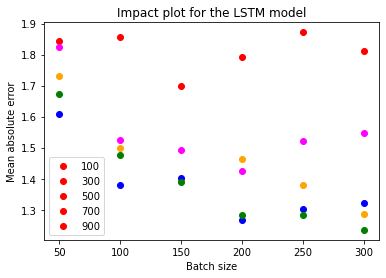

In [49]:
#lstm model
epoc=[100,300,500,700,900]
batch=[50, 100, 150, 200, 250, 300]

for e in epoc:
    if e==100:
        co='red'
    elif e==300:
        co='magenta'
    elif e==500:
        co='orange'
    elif e==700:
        co='blue'
    elif e==900:
        co='green'
     
    for b in batch:
        lstm1_model = keras.Sequential([
                # the hidden ReLU layers
                layers.Dense(units=250, activation='relu', input_shape=[37]),
                layers.Dense(units=250, activation='relu'),
                # the linear output layer 
                layers.Dense(units=1),
            ])
        lstm1_model.compile(
            optimizer="adam",
            loss="mae",)
        lstm1_model.fit(
            train_X5, train_y5,
            validation_data=(val_X5, val_y5),
            batch_size=b,
            epochs=e,)

        lstm1_preds=lstm1_model.predict(val_X5)
        lstm1_model.reset_states()
        print(mean_absolute_error(val_y5, lstm1_preds))
        print(r2_score(val_y5, lstm1_preds))
        plt.xlabel('Batch size')
        plt.ylabel('Mean absolute error')
        plt.legend(title='Number of epochs')
        plt.legend(['100', '300', '500', '700', '900'])
        plt.title('Impact plot for the LSTM model')
        plt.scatter(b, mean_absolute_error(val_y5, lstm1_preds), c=co)

In [86]:

reg1=LinearRegression()     #initiating linear regression
reg1.fit(train_X1,train_y1)
reg1_preds=reg1.predict(val_X1)

dtree = DecisionTreeRegressor(max_depth=40, min_samples_leaf=5, random_state=1)
dtree.fit(train_X1, train_y1)
dec1_preds= dtree.predict(val_X1)
        
forest_model1 = RandomForestRegressor(n_estimators=350, random_state=1)
forest_model1.fit(train_X1, train_y1)
forest1_preds = forest_model1.predict(val_X1)

grad=GradientBoostingRegressor(learning_rate=lr, n_estimators=nes, subsample=1)
grad.fit(train_X1, train_y1)
grad1_preds=grad.predict(val_X1)

light = lgm.LGBMClassifier(num_leaves=20, n_estimators=5)
light.fit(train_X1, train_y1)
lpreds1=light.predict(val_X1)

lstm1_model = keras.Sequential([
    # the hidden ReLU layers
    layers.Dense(units=250, activation='relu', input_shape=[37]),
    layers.Dense(units=250, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1)
])
lstm1_model.compile(
    optimizer="adam",
    loss="mae")

lstm1_model.fit(
            train_X1, train_y1,
            validation_data=(val_X1, val_y1),
            batch_size=210,
            epochs=950)
lstm1_preds=lstm1_model.predict(val_X1)


compare1={'model':['multiple regression', 'decision tree', 'random forest', 'gradient boosting regressor', 'lightgbm', 'lstm'],
        'MAE':[mean_absolute_error(val_y1, reg1_preds), mean_absolute_error(val_y1, dec1_preds), mean_absolute_error(val_y1, ran1_preds),
              mean_absolute_error(val_y1, grad1_preds), mean_absolute_error(val_y1, lpreds1), mean_absolute_error(val_y1, lstm1_preds)],
        'R^2':[r2_score(val_y1, reg1_preds), r2_score(val_y1, dec1_preds), r2_score(val_y1, ran1_preds), 
               r2_score(val_y1, grad1_preds), r2_score(val_y1, lpreds1), r2_score(val_y1, lstm1_preds)]}
compare1_df=pd.DataFrame(compare1, columns=['model', 'MAE', 'R^2'])
compare1_df=compare1_df.sort_values(by=['MAE'])
compare1_df.head(8)

Epoch 1/950
413/413 [==============================] - 4s 9ms/step - loss: 11.9054 - val_loss: 5.2460
Epoch 2/950
413/413 [==============================] - 3s 8ms/step - loss: 6.1536 - val_loss: 3.7787
Epoch 3/950
413/413 [==============================] - 3s 8ms/step - loss: 5.5994 - val_loss: 4.1951
Epoch 4/950
413/413 [==============================] - 3s 7ms/step - loss: 4.4845 - val_loss: 4.3274
Epoch 5/950
413/413 [==============================] - 3s 8ms/step - loss: 4.5264 - val_loss: 5.6620
Epoch 6/950
413/413 [==============================] - 4s 10ms/step - loss: 4.9335 - val_loss: 6.5179
Epoch 7/950
413/413 [==============================] - 3s 8ms/step - loss: 4.2324 - val_loss: 5.7334
Epoch 8/950
413/413 [==============================] - 3s 8ms/step - loss: 4.4312 - val_loss: 5.0034
Epoch 9/950
413/413 [==============================] - 3s 8ms/step - loss: 3.7308 - val_loss: 3.1383
Epoch 10/950
413/413 [==============================] - 3s 8ms/step - loss: 3.8913 - val_

413/413 [==============================] - 5s 11ms/step - loss: 1.3184 - val_loss: 1.4957
Epoch 82/950
413/413 [==============================] - 5s 11ms/step - loss: 1.3047 - val_loss: 1.3571
Epoch 83/950
413/413 [==============================] - 5s 11ms/step - loss: 1.3082 - val_loss: 1.2717
Epoch 84/950
413/413 [==============================] - 4s 11ms/step - loss: 1.3031 - val_loss: 1.2665
Epoch 85/950
413/413 [==============================] - 4s 11ms/step - loss: 1.2883 - val_loss: 1.3380
Epoch 86/950
413/413 [==============================] - 5s 12ms/step - loss: 1.2861 - val_loss: 1.2343
Epoch 87/950
413/413 [==============================] - 5s 12ms/step - loss: 1.2855 - val_loss: 1.2436
Epoch 88/950
413/413 [==============================] - 5s 11ms/step - loss: 1.2796 - val_loss: 1.4261
Epoch 89/950
413/413 [==============================] - 5s 11ms/step - loss: 1.2808 - val_loss: 1.2412
Epoch 90/950
413/413 [==============================] - 5s 11ms/step - loss: 1.2909 - 

413/413 [==============================] - 5s 12ms/step - loss: 1.1681 - val_loss: 1.2072
Epoch 161/950
413/413 [==============================] - 5s 11ms/step - loss: 1.1756 - val_loss: 1.1890
Epoch 162/950
413/413 [==============================] - 4s 11ms/step - loss: 1.1829 - val_loss: 1.2019
Epoch 163/950
413/413 [==============================] - 5s 12ms/step - loss: 1.1717 - val_loss: 1.1878
Epoch 164/950
413/413 [==============================] - 5s 12ms/step - loss: 1.1809 - val_loss: 1.1908
Epoch 165/950
413/413 [==============================] - 5s 11ms/step - loss: 1.1787 - val_loss: 1.1689
Epoch 166/950
413/413 [==============================] - 5s 11ms/step - loss: 1.1709 - val_loss: 1.2242
Epoch 167/950
413/413 [==============================] - 5s 11ms/step - loss: 1.1826 - val_loss: 1.2273
Epoch 168/950
413/413 [==============================] - 5s 11ms/step - loss: 1.1613 - val_loss: 1.1475
Epoch 169/950
413/413 [==============================] - 5s 11ms/step - loss: 

413/413 [==============================] - 5s 12ms/step - loss: 1.1019 - val_loss: 1.1191
Epoch 319/950
413/413 [==============================] - 5s 11ms/step - loss: 1.0896 - val_loss: 1.0918
Epoch 320/950
413/413 [==============================] - 5s 11ms/step - loss: 1.0786 - val_loss: 1.1825
Epoch 321/950
413/413 [==============================] - 5s 11ms/step - loss: 1.0915 - val_loss: 1.1509
Epoch 322/950
413/413 [==============================] - 5s 11ms/step - loss: 1.0905 - val_loss: 1.1886
Epoch 323/950
413/413 [==============================] - 5s 11ms/step - loss: 1.0889 - val_loss: 1.0737
Epoch 324/950
413/413 [==============================] - 5s 11ms/step - loss: 1.0959 - val_loss: 1.1228
Epoch 325/950
413/413 [==============================] - 5s 11ms/step - loss: 1.0912 - val_loss: 1.1039
Epoch 326/950
413/413 [==============================] - 5s 11ms/step - loss: 1.0913 - val_loss: 1.1130
Epoch 327/950
413/413 [==============================] - 4s 11ms/step - loss: 

Epoch 397/950
413/413 [==============================] - 4s 10ms/step - loss: 1.0620 - val_loss: 1.0946
Epoch 398/950
413/413 [==============================] - 4s 10ms/step - loss: 1.0740 - val_loss: 1.0887
Epoch 399/950
413/413 [==============================] - 4s 11ms/step - loss: 1.0689 - val_loss: 1.0937
Epoch 400/950
413/413 [==============================] - 4s 10ms/step - loss: 1.0762 - val_loss: 1.0827
Epoch 401/950
413/413 [==============================] - 4s 10ms/step - loss: 1.0607 - val_loss: 1.1081
Epoch 402/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0731 - val_loss: 1.0985
Epoch 403/950
413/413 [==============================] - 4s 9ms/step - loss: 1.0593 - val_loss: 1.0765
Epoch 404/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0642 - val_loss: 1.1166
Epoch 405/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0684 - val_loss: 1.0814
Epoch 406/950
413/413 [==============================] - 3s 8ms/step

413/413 [==============================] - 3s 8ms/step - loss: 1.0386 - val_loss: 1.0764
Epoch 556/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0339 - val_loss: 1.0540
Epoch 557/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0399 - val_loss: 1.0466
Epoch 558/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0336 - val_loss: 1.0828
Epoch 559/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0407 - val_loss: 1.0543
Epoch 560/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0427 - val_loss: 1.0536
Epoch 561/950
413/413 [==============================] - 3s 7ms/step - loss: 1.0342 - val_loss: 1.0752
Epoch 562/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0383 - val_loss: 1.1076
Epoch 563/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0359 - val_loss: 1.1315
Epoch 564/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0438 - v

413/413 [==============================] - 3s 8ms/step - loss: 1.0158 - val_loss: 1.0615
Epoch 714/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0270 - val_loss: 1.0862
Epoch 715/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0266 - val_loss: 1.0660
Epoch 716/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0206 - val_loss: 1.0392
Epoch 717/950
413/413 [==============================] - 3s 7ms/step - loss: 1.0237 - val_loss: 1.0547
Epoch 718/950
413/413 [==============================] - 3s 7ms/step - loss: 1.0144 - val_loss: 1.0932
Epoch 719/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0178 - val_loss: 1.0539
Epoch 720/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0179 - val_loss: 1.0426
Epoch 721/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0274 - val_loss: 1.0614
Epoch 722/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0192 - v

413/413 [==============================] - 3s 8ms/step - loss: 1.0014 - val_loss: 1.1116
Epoch 872/950
413/413 [==============================] - 4s 9ms/step - loss: 1.0044 - val_loss: 1.0278
Epoch 873/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0081 - val_loss: 1.0635
Epoch 874/950
413/413 [==============================] - 4s 9ms/step - loss: 1.0107 - val_loss: 1.0465
Epoch 875/950
413/413 [==============================] - 4s 9ms/step - loss: 1.0108 - val_loss: 1.0524
Epoch 876/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0086 - val_loss: 1.0997
Epoch 877/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0091 - val_loss: 1.0429
Epoch 878/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0066 - val_loss: 1.0404
Epoch 879/950
413/413 [==============================] - 3s 8ms/step - loss: 1.0056 - val_loss: 1.0652
Epoch 880/950
413/413 [==============================] - 3s 7ms/step - loss: 1.0082 - v

NameError: name 'dec1_preds' is not defined

In [89]:
dtree = DecisionTreeRegressor(max_depth=40, min_samples_leaf=5, random_state=1)
dtree.fit(train_X1, train_y1)
dec1_preds= dtree.predict(val_X1)
compare1={'model':['multiple regression', 'decision tree', 'random forest', 'gradient boosting regressor', 'lightgbm', 'lstm'],
        'MAE':[mean_absolute_error(val_y1, reg1_preds), mean_absolute_error(val_y1, dec1_preds), mean_absolute_error(val_y1, forest1_preds),
              mean_absolute_error(val_y1, grad1_preds), mean_absolute_error(val_y1, lpreds1), mean_absolute_error(val_y1, lstm1_preds)],
        'R^2':[r2_score(val_y1, reg1_preds), r2_score(val_y1, dec1_preds), r2_score(val_y1, forest1_preds), 
               r2_score(val_y1, grad1_preds), r2_score(val_y1, lpreds1), r2_score(val_y1, lstm1_preds)]}
compare1_df=pd.DataFrame(compare1, columns=['model', 'MAE', 'R^2'])
compare1_df=compare1_df.sort_values(by=['MAE'])
compare1_df.head(8)

,model,MAE,R^2
2,random forest,0.761064,0.992570
1,decision tree,0.876403,0.989248
3,gradient boosting regressor,1.024178,0.986555
5,lstm,1.066999,0.984511
4,lightgbm,1.634464,0.902756
0,multiple regression,3.661538,0.859880


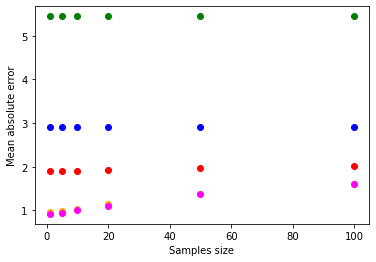

In [91]:
#decision tree
depth=[1, 5, 10, 20, 40, 100]
samples=[1, 5, 10, 20, 50, 100]
for d in depth:
    if d==1:
        co='green'
    elif d==5:
        co='blue'
    elif d==10:
        co='red'
    elif d==20:
        co='orange'
    elif d==40:
        co='yellow'
    elif d==100:
        co='magenta'
    for s in samples:
        dtree5 = DecisionTreeRegressor(max_depth=d, min_samples_leaf=s, random_state=1)
        dtree5.fit(train_X5, train_y5)
        dec_preds5= dtree5.predict(val_X5)
        plt.xlabel('Samples size')
        plt.ylabel('Mean absolute error')
        plt.scatter(s, mean_absolute_error(val_y5, dec_preds5), c=co)

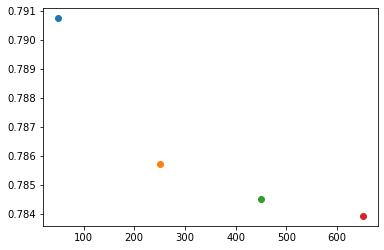

In [6]:
n_estimators=[50, 250, 450, 650]
for n in n_estimators:
    forest_model5 = RandomForestRegressor(n_estimators=n, random_state=1)
    forest_model5.fit(train_X5, train_y5)
    forest5_preds = forest_model5.predict(val_X5)
    plt.scatter(n, mean_absolute_error(val_y5, forest5_preds))

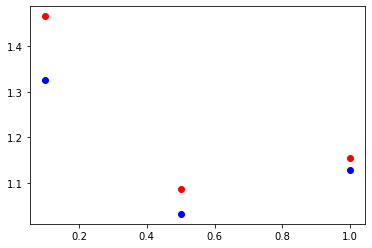

In [93]:
#gradient boost
nest=[1200, 1800]
lra=[0.1, 0.5, 1]
for nes in nest:
    if nes==1200:
        co='red'
    elif nes==1800:
        co='blue'
            
    for lr in lra:    
        grad5=GradientBoostingRegressor(learning_rate=lr, n_estimators=nes, subsample=1)
        grad5.fit(train_X5, train_y5)
        grad5_preds=grad5.predict(val_X5)
        plt.scatter(lr, mean_absolute_error(val_y5, grad5_preds), c=co)

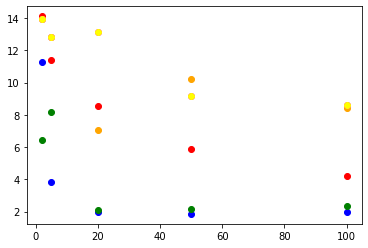

In [94]:
#light       
lnes=[1, 5, 10, 50, 100, 500]
leaves=[2, 5, 20, 50, 100]
for lne in lnes:
    if lne==1:
        co='red'
    elif lne==5:
        co='blue'
    elif lne==10:
        co='green'
    elif lne==50:
        co='orange'
    elif lne==100:
        co='magenta'
    elif lne==500:
        co='yellow'
    
    for le in leaves:
        light5 = lgm.LGBMClassifier(num_leaves=le, n_estimators=lne)
        light5.fit(train_X5, train_y5)
        lpreds5=light5.predict(val_X5)
        plt.scatter(le, mean_absolute_error(val_y5, lpreds5), c=co)

In [ ]:
#lstm model
epoc=[500,750,900]
batch=[100, 150, 200]

for e in epoc:
    if e==500:
        co='orange'
    elif e==750:
        co='blue'
    elif e==900:
        co='green'
     
    for b in batch:
        lstm5_model = keras.Sequential([
                # the hidden ReLU layers
                layers.Dense(units=250, activation='relu', input_shape=[37]),
                layers.Dense(units=250, activation='relu'),
                # the linear output layer 
                layers.Dense(units=1),
            ])
        lstm5_model.compile(
            optimizer="adam",
            loss="mae",)
        lstm5_model.fit(
            train_X5, train_y5,
            validation_data=(val_X5, val_y5),
            batch_size=b,
            epochs=e,)

        lstm5_preds=lstm5_model.predict(val_X5)
        lstm5_model.reset_states()
        print(mean_absolute_error(val_y5, lstm5_preds))
        print(r2_score(val_y5, lstm5_preds))
        plt.xlabel('Batch size')
        plt.ylabel('Mean absolute error')
        plt.scatter(b, mean_absolute_error(val_y5, lstm5_preds), c=co)

Epoch 1/500
864/864 [==============================] - 5s 6ms/step - loss: 9.6139 - val_loss: 3.9981
Epoch 2/500
864/864 [==============================] - 5s 5ms/step - loss: 5.0128 - val_loss: 5.9820
Epoch 3/500
864/864 [==============================] - 4s 5ms/step - loss: 4.8768 - val_loss: 5.2168
Epoch 4/500
864/864 [==============================] - 5s 5ms/step - loss: 4.4232 - val_loss: 5.8479
Epoch 5/500
864/864 [==============================] - 5s 6ms/step - loss: 4.0936 - val_loss: 3.7988
Epoch 6/500
864/864 [==============================] - 4s 5ms/step - loss: 3.7211 - val_loss: 3.2685
Epoch 7/500
864/864 [==============================] - 5s 5ms/step - loss: 3.3945 - val_loss: 3.1938
Epoch 8/500
864/864 [==============================] - 5s 5ms/step - loss: 3.2320 - val_loss: 3.0880
Epoch 9/500
864/864 [==============================] - 4s 5ms/step - loss: 3.1932 - val_loss: 2.9636
Epoch 10/500
864/864 [==============================] - 4s 5ms/step - loss: 2.9920 - val_lo

Epoch 161/500
864/864 [==============================] - 6s 7ms/step - loss: 1.6661 - val_loss: 1.6912
Epoch 162/500
864/864 [==============================] - 5s 6ms/step - loss: 1.6680 - val_loss: 1.6920
Epoch 163/500
864/864 [==============================] - 5s 6ms/step - loss: 1.6656 - val_loss: 1.7154
Epoch 164/500
864/864 [==============================] - 6s 6ms/step - loss: 1.6656 - val_loss: 1.6865
Epoch 165/500
864/864 [==============================] - 6s 6ms/step - loss: 1.6585 - val_loss: 1.6819
Epoch 166/500
864/864 [==============================] - 5s 6ms/step - loss: 1.6628 - val_loss: 1.6573
Epoch 167/500
864/864 [==============================] - 6s 6ms/step - loss: 1.6541 - val_loss: 1.6948
Epoch 168/500
864/864 [==============================] - 6s 6ms/step - loss: 1.6486 - val_loss: 1.7532
Epoch 169/500
864/864 [==============================] - 6s 6ms/step - loss: 1.6509 - val_loss: 1.7014
Epoch 170/500
864/864 [==============================] - 6s 6ms/step - lo

864/864 [==============================] - 4s 5ms/step - loss: 1.5311 - val_loss: 1.7279
Epoch 320/500
864/864 [==============================] - 4s 5ms/step - loss: 1.5187 - val_loss: 1.5459
Epoch 321/500
864/864 [==============================] - 4s 5ms/step - loss: 1.5223 - val_loss: 1.5206
Epoch 322/500
864/864 [==============================] - 4s 5ms/step - loss: 1.5253 - val_loss: 1.5570
Epoch 323/500
864/864 [==============================] - 4s 5ms/step - loss: 1.5288 - val_loss: 1.5376
Epoch 324/500
864/864 [==============================] - 4s 5ms/step - loss: 1.5265 - val_loss: 1.5481
Epoch 325/500
864/864 [==============================] - 5s 6ms/step - loss: 1.5233 - val_loss: 1.6301
Epoch 326/500
864/864 [==============================] - 4s 5ms/step - loss: 1.5219 - val_loss: 1.5469
Epoch 327/500
864/864 [==============================] - 4s 5ms/step - loss: 1.5239 - val_loss: 1.6779
Epoch 328/500
864/864 [==============================] - 4s 5ms/step - loss: 1.5265 - v

864/864 [==============================] - 6s 6ms/step - loss: 1.4537 - val_loss: 1.4471
Epoch 478/500
864/864 [==============================] - 6s 7ms/step - loss: 1.4496 - val_loss: 1.5139
Epoch 479/500
864/864 [==============================] - 7s 8ms/step - loss: 1.4573 - val_loss: 1.4944
Epoch 480/500
864/864 [==============================] - 6s 7ms/step - loss: 1.4474 - val_loss: 1.4936
Epoch 481/500
864/864 [==============================] - 6s 7ms/step - loss: 1.4518 - val_loss: 1.5249
Epoch 482/500
864/864 [==============================] - 6s 6ms/step - loss: 1.4462 - val_loss: 1.5305
Epoch 483/500
864/864 [==============================] - 6s 7ms/step - loss: 1.4515 - val_loss: 1.5281
Epoch 484/500
864/864 [==============================] - 6s 7ms/step - loss: 1.4551 - val_loss: 1.5076
Epoch 485/500
864/864 [==============================] - 6s 7ms/step - loss: 1.4446 - val_loss: 1.5035
Epoch 486/500
864/864 [==============================] - 6s 6ms/step - loss: 1.4487 - v

Epoch 57/500
576/576 [==============================] - 5s 9ms/step - loss: 1.9699 - val_loss: 2.0533
Epoch 58/500
576/576 [==============================] - 4s 8ms/step - loss: 1.9914 - val_loss: 1.9757
Epoch 59/500
576/576 [==============================] - 6s 10ms/step - loss: 1.9767 - val_loss: 2.0398
Epoch 60/500
576/576 [==============================] - 5s 9ms/step - loss: 1.9612 - val_loss: 1.9780
Epoch 61/500
576/576 [==============================] - 5s 9ms/step - loss: 1.9536 - val_loss: 2.0519
Epoch 62/500
576/576 [==============================] - 5s 9ms/step - loss: 1.9506 - val_loss: 2.0060
Epoch 63/500
576/576 [==============================] - 5s 9ms/step - loss: 1.9409 - val_loss: 2.1695
Epoch 64/500
576/576 [==============================] - 5s 9ms/step - loss: 1.9307 - val_loss: 1.8882
Epoch 65/500
576/576 [==============================] - 5s 9ms/step - loss: 1.9416 - val_loss: 2.1133
Epoch 66/500
576/576 [==============================] - 5s 9ms/step - loss: 1.930

Epoch 137/500
576/576 [==============================] - 5s 9ms/step - loss: 1.6452 - val_loss: 1.7799
Epoch 138/500
576/576 [==============================] - 5s 9ms/step - loss: 1.6502 - val_loss: 1.7308
Epoch 139/500
576/576 [==============================] - 5s 9ms/step - loss: 1.6669 - val_loss: 1.6245
Epoch 140/500
576/576 [==============================] - 5s 9ms/step - loss: 1.6333 - val_loss: 1.6339
Epoch 141/500
576/576 [==============================] - 5s 9ms/step - loss: 1.6303 - val_loss: 1.6494
Epoch 142/500
576/576 [==============================] - 6s 10ms/step - loss: 1.6399 - val_loss: 1.7034
Epoch 143/500
576/576 [==============================] - 5s 9ms/step - loss: 1.6593 - val_loss: 1.6003
Epoch 144/500
576/576 [==============================] - 5s 9ms/step - loss: 1.6281 - val_loss: 1.6482
Epoch 145/500
576/576 [==============================] - 5s 9ms/step - loss: 1.6316 - val_loss: 1.6163
Epoch 146/500
576/576 [==============================] - 5s 9ms/step - l

576/576 [==============================] - 4s 7ms/step - loss: 1.4536 - val_loss: 1.5197
Epoch 296/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4445 - val_loss: 1.4866
Epoch 297/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4350 - val_loss: 1.5738
Epoch 298/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4558 - val_loss: 1.5005
Epoch 299/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4520 - val_loss: 1.4794
Epoch 300/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4368 - val_loss: 1.4853
Epoch 301/500
576/576 [==============================] - 5s 9ms/step - loss: 1.4364 - val_loss: 1.4460
Epoch 302/500
576/576 [==============================] - 4s 8ms/step - loss: 1.4389 - val_loss: 1.4399
Epoch 303/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4329 - val_loss: 1.5055
Epoch 304/500
576/576 [==============================] - 4s 7ms/step - loss: 1.4301 - v

576/576 [==============================] - 5s 9ms/step - loss: 1.3629 - val_loss: 1.4510
Epoch 454/500
576/576 [==============================] - 5s 9ms/step - loss: 1.3597 - val_loss: 1.3871
Epoch 455/500
576/576 [==============================] - 5s 9ms/step - loss: 1.3650 - val_loss: 1.4068
Epoch 456/500
576/576 [==============================] - 5s 9ms/step - loss: 1.3577 - val_loss: 1.4005
Epoch 457/500
576/576 [==============================] - 6s 10ms/step - loss: 1.3602 - val_loss: 1.3757
Epoch 458/500
576/576 [==============================] - 6s 10ms/step - loss: 1.3623 - val_loss: 1.4177
Epoch 459/500
576/576 [==============================] - 5s 9ms/step - loss: 1.3497 - val_loss: 1.3797
Epoch 460/500
576/576 [==============================] - 5s 9ms/step - loss: 1.3566 - val_loss: 1.3902
Epoch 461/500
576/576 [==============================] - 5s 9ms/step - loss: 1.3588 - val_loss: 1.4383
Epoch 462/500
576/576 [==============================] - 5s 9ms/step - loss: 1.3491 -

432/432 [==============================] - 4s 10ms/step - loss: 1.7364 - val_loss: 1.7104
Epoch 113/500
432/432 [==============================] - 4s 9ms/step - loss: 1.7386 - val_loss: 1.7848
Epoch 114/500
432/432 [==============================] - 3s 8ms/step - loss: 1.7284 - val_loss: 1.7647
Epoch 115/500
432/432 [==============================] - 4s 9ms/step - loss: 1.7359 - val_loss: 1.7509
Epoch 116/500
432/432 [==============================] - 4s 9ms/step - loss: 1.7422 - val_loss: 1.6881
Epoch 117/500
432/432 [==============================] - 3s 8ms/step - loss: 1.7073 - val_loss: 1.7188
Epoch 118/500
432/432 [==============================] - 3s 8ms/step - loss: 1.7328 - val_loss: 1.6755
Epoch 119/500
432/432 [==============================] - 3s 8ms/step - loss: 1.7005 - val_loss: 1.7391
Epoch 120/500
432/432 [==============================] - 3s 8ms/step - loss: 1.7079 - val_loss: 1.7735
Epoch 121/500
432/432 [==============================] - 3s 8ms/step - loss: 1.7012 - 

Epoch 270/500
432/432 [==============================] - 5s 11ms/step - loss: 1.4463 - val_loss: 1.6252
Epoch 271/500
432/432 [==============================] - 5s 11ms/step - loss: 1.4613 - val_loss: 1.5838
Epoch 272/500
432/432 [==============================] - 5s 12ms/step - loss: 1.4331 - val_loss: 1.4581
Epoch 273/500
432/432 [==============================] - 5s 11ms/step - loss: 1.4295 - val_loss: 1.5336
Epoch 274/500
432/432 [==============================] - 5s 11ms/step - loss: 1.4477 - val_loss: 1.4824
Epoch 275/500
432/432 [==============================] - 5s 11ms/step - loss: 1.4435 - val_loss: 1.5193
Epoch 276/500
432/432 [==============================] - 5s 11ms/step - loss: 1.4539 - val_loss: 1.5013
Epoch 277/500
432/432 [==============================] - 5s 11ms/step - loss: 1.4345 - val_loss: 1.4710
Epoch 278/500
432/432 [==============================] - 5s 11ms/step - loss: 1.4230 - val_loss: 1.4532
Epoch 279/500
432/432 [==============================] - 5s 11ms

Epoch 349/500
432/432 [==============================] - 5s 11ms/step - loss: 1.3698 - val_loss: 1.4601
Epoch 350/500
432/432 [==============================] - 5s 11ms/step - loss: 1.3962 - val_loss: 1.3949
Epoch 351/500
432/432 [==============================] - 5s 11ms/step - loss: 1.3792 - val_loss: 1.4678
Epoch 352/500
432/432 [==============================] - 5s 13ms/step - loss: 1.3811 - val_loss: 1.4838
Epoch 353/500
432/432 [==============================] - 5s 12ms/step - loss: 1.3804 - val_loss: 1.5143
Epoch 354/500
432/432 [==============================] - 5s 11ms/step - loss: 1.3847 - val_loss: 1.4614
Epoch 355/500
432/432 [==============================] - 5s 11ms/step - loss: 1.3726 - val_loss: 1.4079
Epoch 356/500
432/432 [==============================] - 5s 11ms/step - loss: 1.3816 - val_loss: 1.4079
Epoch 357/500
432/432 [==============================] - 5s 11ms/step - loss: 1.3855 - val_loss: 1.5581
Epoch 358/500
432/432 [==============================] - 5s 11ms

Epoch 428/500
432/432 [==============================] - 3s 8ms/step - loss: 1.3390 - val_loss: 1.3419
Epoch 429/500
432/432 [==============================] - 4s 8ms/step - loss: 1.3275 - val_loss: 1.3995
Epoch 430/500
432/432 [==============================] - 3s 8ms/step - loss: 1.3375 - val_loss: 1.4006
Epoch 431/500
432/432 [==============================] - 3s 8ms/step - loss: 1.3314 - val_loss: 1.3802
Epoch 432/500
432/432 [==============================] - 3s 8ms/step - loss: 1.3499 - val_loss: 1.3624
Epoch 433/500
432/432 [==============================] - 3s 8ms/step - loss: 1.3336 - val_loss: 1.3907
Epoch 434/500
432/432 [==============================] - 3s 8ms/step - loss: 1.3307 - val_loss: 1.3382
Epoch 435/500
432/432 [==============================] - 3s 8ms/step - loss: 1.3368 - val_loss: 1.3861
Epoch 436/500
432/432 [==============================] - 3s 8ms/step - loss: 1.3455 - val_loss: 1.4207
Epoch 437/500
432/432 [==============================] - 3s 8ms/step - lo

864/864 [==============================] - 6s 7ms/step - loss: 1.8251 - val_loss: 1.8014
Epoch 88/750
864/864 [==============================] - 5s 6ms/step - loss: 1.8187 - val_loss: 1.7700
Epoch 89/750
864/864 [==============================] - 6s 7ms/step - loss: 1.8108 - val_loss: 1.8316
Epoch 90/750
864/864 [==============================] - 6s 7ms/step - loss: 1.8030 - val_loss: 1.7997
Epoch 91/750
864/864 [==============================] - 6s 7ms/step - loss: 1.8265 - val_loss: 1.8836
Epoch 92/750
864/864 [==============================] - 6s 6ms/step - loss: 1.8208 - val_loss: 1.8221
Epoch 93/750
864/864 [==============================] - 6s 6ms/step - loss: 1.7992 - val_loss: 1.8424
Epoch 94/750
864/864 [==============================] - 6s 7ms/step - loss: 1.8045 - val_loss: 1.8299
Epoch 95/750
864/864 [==============================] - 6s 6ms/step - loss: 1.7965 - val_loss: 1.7802
Epoch 96/750
864/864 [==============================] - 6s 6ms/step - loss: 1.7979 - val_loss: 

Epoch 167/750
864/864 [==============================] - 6s 6ms/step - loss: 1.6722 - val_loss: 1.8191
Epoch 168/750
864/864 [==============================] - 6s 6ms/step - loss: 1.6708 - val_loss: 1.6750
Epoch 169/750
864/864 [==============================] - 6s 7ms/step - loss: 1.6671 - val_loss: 1.7513
Epoch 170/750
864/864 [==============================] - 6s 6ms/step - loss: 1.6620 - val_loss: 1.6626
Epoch 171/750
864/864 [==============================] - 6s 7ms/step - loss: 1.6447 - val_loss: 1.6851
Epoch 172/750
864/864 [==============================] - 6s 6ms/step - loss: 1.6643 - val_loss: 1.7092
Epoch 173/750
864/864 [==============================] - 6s 7ms/step - loss: 1.6633 - val_loss: 1.8124
Epoch 174/750
864/864 [==============================] - 5s 5ms/step - loss: 1.6522 - val_loss: 1.7023
Epoch 175/750
864/864 [==============================] - 4s 5ms/step - loss: 1.6601 - val_loss: 1.6773
Epoch 176/750
864/864 [==============================] - 4s 5ms/step - lo

864/864 [==============================] - 6s 6ms/step - loss: 1.5444 - val_loss: 1.5392
Epoch 326/750
864/864 [==============================] - 6s 7ms/step - loss: 1.5478 - val_loss: 1.5121
Epoch 327/750
864/864 [==============================] - 6s 6ms/step - loss: 1.5341 - val_loss: 1.7114
Epoch 328/750
864/864 [==============================] - 6s 7ms/step - loss: 1.5352 - val_loss: 1.5377
Epoch 329/750
864/864 [==============================] - 6s 7ms/step - loss: 1.5511 - val_loss: 1.6328
Epoch 330/750
864/864 [==============================] - 6s 7ms/step - loss: 1.5388 - val_loss: 1.5396
Epoch 331/750
864/864 [==============================] - 6s 7ms/step - loss: 1.5426 - val_loss: 1.5763
Epoch 332/750
864/864 [==============================] - 6s 6ms/step - loss: 1.5342 - val_loss: 1.5764
Epoch 333/750
864/864 [==============================] - 6s 7ms/step - loss: 1.5443 - val_loss: 1.5235
Epoch 334/750
864/864 [==============================] - 6s 7ms/step - loss: 1.5357 - v

864/864 [==============================] - 6s 7ms/step - loss: 1.4787 - val_loss: 1.4830
Epoch 484/750
864/864 [==============================] - 5s 6ms/step - loss: 1.4707 - val_loss: 1.5045
Epoch 485/750
864/864 [==============================] - 6s 7ms/step - loss: 1.4806 - val_loss: 1.5294
Epoch 486/750
864/864 [==============================] - 6s 7ms/step - loss: 1.4728 - val_loss: 1.5506
Epoch 487/750
864/864 [==============================] - 6s 6ms/step - loss: 1.4764 - val_loss: 1.4768
Epoch 488/750
864/864 [==============================] - 6s 7ms/step - loss: 1.4773 - val_loss: 1.4740
Epoch 489/750
864/864 [==============================] - 6s 6ms/step - loss: 1.4821 - val_loss: 1.4871
Epoch 490/750
864/864 [==============================] - 5s 6ms/step - loss: 1.4704 - val_loss: 1.4943
Epoch 491/750
864/864 [==============================] - 6s 7ms/step - loss: 1.4745 - val_loss: 1.5112
Epoch 492/750
864/864 [==============================] - 7s 8ms/step - loss: 1.4680 - v

864/864 [==============================] - 6s 7ms/step - loss: 1.4358 - val_loss: 1.4540
Epoch 642/750
864/864 [==============================] - 6s 7ms/step - loss: 1.4386 - val_loss: 1.4932
Epoch 643/750
864/864 [==============================] - 6s 7ms/step - loss: 1.4323 - val_loss: 1.4237
Epoch 644/750
864/864 [==============================] - 6s 7ms/step - loss: 1.4322 - val_loss: 1.4652
Epoch 645/750
864/864 [==============================] - 6s 7ms/step - loss: 1.4506 - val_loss: 1.5088
Epoch 646/750
864/864 [==============================] - 5s 6ms/step - loss: 1.4284 - val_loss: 1.4597
Epoch 647/750
864/864 [==============================] - 6s 6ms/step - loss: 1.4388 - val_loss: 1.5739
Epoch 648/750
864/864 [==============================] - 6s 7ms/step - loss: 1.4374 - val_loss: 1.4686
Epoch 649/750
864/864 [==============================] - 6s 7ms/step - loss: 1.4304 - val_loss: 1.5585
Epoch 650/750
864/864 [==============================] - 6s 6ms/step - loss: 1.4421 - v

Epoch 50/750
576/576 [==============================] - 5s 8ms/step - loss: 2.0298 - val_loss: 2.0029
Epoch 51/750
576/576 [==============================] - 5s 8ms/step - loss: 2.0191 - val_loss: 1.9501
Epoch 52/750
576/576 [==============================] - 5s 8ms/step - loss: 1.9949 - val_loss: 1.9525
Epoch 53/750
576/576 [==============================] - 5s 8ms/step - loss: 2.0025 - val_loss: 1.9910
Epoch 54/750
576/576 [==============================] - 5s 8ms/step - loss: 1.9929 - val_loss: 1.9779
Epoch 55/750
576/576 [==============================] - 5s 8ms/step - loss: 1.9820 - val_loss: 2.0510
Epoch 56/750
576/576 [==============================] - 5s 8ms/step - loss: 1.9798 - val_loss: 1.9517
Epoch 57/750
576/576 [==============================] - 5s 8ms/step - loss: 1.9564 - val_loss: 2.0071
Epoch 58/750
576/576 [==============================] - 5s 8ms/step - loss: 1.9497 - val_loss: 1.9657
Epoch 59/750
576/576 [==============================] - 5s 8ms/step - loss: 1.9532

576/576 [==============================] - 4s 6ms/step - loss: 1.6528 - val_loss: 1.5912
Epoch 131/750
576/576 [==============================] - 4s 6ms/step - loss: 1.6515 - val_loss: 1.7708
Epoch 132/750
576/576 [==============================] - 3s 6ms/step - loss: 1.6617 - val_loss: 1.7154
Epoch 133/750
576/576 [==============================] - 3s 6ms/step - loss: 1.6335 - val_loss: 1.5973
Epoch 134/750
576/576 [==============================] - 3s 6ms/step - loss: 1.6313 - val_loss: 1.6443
Epoch 135/750
576/576 [==============================] - 4s 6ms/step - loss: 1.6387 - val_loss: 1.6337
Epoch 136/750
576/576 [==============================] - 3s 6ms/step - loss: 1.6448 - val_loss: 1.5999
Epoch 137/750
576/576 [==============================] - 3s 6ms/step - loss: 1.6236 - val_loss: 1.6590
Epoch 138/750
576/576 [==============================] - 3s 6ms/step - loss: 1.6252 - val_loss: 1.6511
Epoch 139/750
576/576 [==============================] - 4s 6ms/step - loss: 1.6366 - v

576/576 [==============================] - 4s 6ms/step - loss: 1.4452 - val_loss: 1.4495
Epoch 289/750
576/576 [==============================] - 3s 6ms/step - loss: 1.4435 - val_loss: 1.4568
Epoch 290/750
576/576 [==============================] - 3s 6ms/step - loss: 1.4378 - val_loss: 1.4820
Epoch 291/750
576/576 [==============================] - 3s 6ms/step - loss: 1.4471 - val_loss: 1.6029
Epoch 292/750
576/576 [==============================] - 4s 7ms/step - loss: 1.4289 - val_loss: 1.4983
Epoch 293/750
576/576 [==============================] - 4s 7ms/step - loss: 1.4499 - val_loss: 1.5005
Epoch 294/750
576/576 [==============================] - 4s 6ms/step - loss: 1.4255 - val_loss: 1.5585
Epoch 295/750
576/576 [==============================] - 3s 6ms/step - loss: 1.4326 - val_loss: 1.4404
Epoch 296/750
576/576 [==============================] - 4s 6ms/step - loss: 1.4386 - val_loss: 1.4811
Epoch 297/750
576/576 [==============================] - 4s 6ms/step - loss: 1.4396 - v

576/576 [==============================] - 4s 6ms/step - loss: 1.3458 - val_loss: 1.3972
Epoch 447/750
576/576 [==============================] - 4s 6ms/step - loss: 1.3471 - val_loss: 1.4221
Epoch 448/750
576/576 [==============================] - 3s 6ms/step - loss: 1.3557 - val_loss: 1.4561
Epoch 449/750
576/576 [==============================] - 4s 6ms/step - loss: 1.3638 - val_loss: 1.3898
Epoch 450/750
576/576 [==============================] - 3s 6ms/step - loss: 1.3455 - val_loss: 1.5793
Epoch 451/750
576/576 [==============================] - 3s 6ms/step - loss: 1.3616 - val_loss: 1.4241
Epoch 452/750
576/576 [==============================] - 4s 6ms/step - loss: 1.3390 - val_loss: 1.3818
Epoch 453/750
576/576 [==============================] - 3s 6ms/step - loss: 1.3536 - val_loss: 1.3770
Epoch 454/750
576/576 [==============================] - 3s 6ms/step - loss: 1.3448 - val_loss: 1.3449
Epoch 455/750
576/576 [==============================] - 3s 6ms/step - loss: 1.3525 - v

576/576 [==============================] - 3s 6ms/step - loss: 1.2945 - val_loss: 1.3204
Epoch 605/750
576/576 [==============================] - 3s 6ms/step - loss: 1.2931 - val_loss: 1.3600
Epoch 606/750
576/576 [==============================] - 3s 6ms/step - loss: 1.3036 - val_loss: 1.3472
Epoch 607/750
576/576 [==============================] - 4s 7ms/step - loss: 1.2875 - val_loss: 1.3133
Epoch 608/750
576/576 [==============================] - 4s 7ms/step - loss: 1.3067 - val_loss: 1.3586
Epoch 609/750
576/576 [==============================] - 4s 6ms/step - loss: 1.2953 - val_loss: 1.3072
Epoch 610/750
576/576 [==============================] - 3s 6ms/step - loss: 1.2954 - val_loss: 1.3077
Epoch 611/750
576/576 [==============================] - 3s 6ms/step - loss: 1.2995 - val_loss: 1.4668
Epoch 612/750
576/576 [==============================] - 3s 6ms/step - loss: 1.2983 - val_loss: 1.3114
Epoch 613/750
576/576 [==============================] - 3s 6ms/step - loss: 1.2848 - v

432/432 [==============================] - 3s 7ms/step - loss: 3.2734 - val_loss: 3.1289
Epoch 13/750
432/432 [==============================] - 3s 8ms/step - loss: 3.2261 - val_loss: 2.8634
Epoch 14/750
432/432 [==============================] - 3s 7ms/step - loss: 3.1587 - val_loss: 2.7941
Epoch 15/750
432/432 [==============================] - 3s 8ms/step - loss: 3.0011 - val_loss: 2.9278
Epoch 16/750
432/432 [==============================] - 4s 9ms/step - loss: 3.0182 - val_loss: 2.9639
Epoch 17/750
432/432 [==============================] - 3s 7ms/step - loss: 2.8702 - val_loss: 3.1480
Epoch 18/750
432/432 [==============================] - 3s 7ms/step - loss: 2.8068 - val_loss: 2.7845
Epoch 19/750
432/432 [==============================] - 3s 8ms/step - loss: 2.8818 - val_loss: 2.6029
Epoch 20/750
432/432 [==============================] - 3s 8ms/step - loss: 2.7572 - val_loss: 2.6196
Epoch 21/750
432/432 [==============================] - 4s 9ms/step - loss: 2.7376 - val_loss: 

432/432 [==============================] - 3s 7ms/step - loss: 1.5843 - val_loss: 1.6177
Epoch 172/750
432/432 [==============================] - 3s 7ms/step - loss: 1.5771 - val_loss: 1.5979
Epoch 173/750
432/432 [==============================] - 3s 8ms/step - loss: 1.5870 - val_loss: 1.6190
Epoch 174/750
432/432 [==============================] - 3s 7ms/step - loss: 1.5728 - val_loss: 1.5898
Epoch 175/750
432/432 [==============================] - 3s 7ms/step - loss: 1.5766 - val_loss: 1.7818
Epoch 176/750
432/432 [==============================] - 3s 7ms/step - loss: 1.5681 - val_loss: 1.6477
Epoch 177/750
432/432 [==============================] - 3s 7ms/step - loss: 1.5583 - val_loss: 1.5878
Epoch 178/750
432/432 [==============================] - 3s 8ms/step - loss: 1.5553 - val_loss: 1.6284
Epoch 179/750
432/432 [==============================] - 3s 8ms/step - loss: 1.5559 - val_loss: 1.5446
Epoch 180/750
432/432 [==============================] - 3s 7ms/step - loss: 1.5588 - v

432/432 [==============================] - 3s 8ms/step - loss: 1.4090 - val_loss: 1.4552
Epoch 330/750
432/432 [==============================] - 3s 8ms/step - loss: 1.4156 - val_loss: 1.4964
Epoch 331/750
432/432 [==============================] - 3s 8ms/step - loss: 1.3997 - val_loss: 1.4579
Epoch 332/750
432/432 [==============================] - 3s 7ms/step - loss: 1.3953 - val_loss: 1.4584
Epoch 333/750
432/432 [==============================] - 3s 7ms/step - loss: 1.4026 - val_loss: 1.4860
Epoch 334/750
432/432 [==============================] - 3s 8ms/step - loss: 1.4044 - val_loss: 1.5928
Epoch 335/750
432/432 [==============================] - 3s 8ms/step - loss: 1.4070 - val_loss: 1.4406
Epoch 336/750
432/432 [==============================] - 3s 8ms/step - loss: 1.4113 - val_loss: 1.4844
Epoch 337/750
432/432 [==============================] - 4s 8ms/step - loss: 1.4068 - val_loss: 1.4779
Epoch 338/750
432/432 [==============================] - 3s 7ms/step - loss: 1.3971 - v

432/432 [==============================] - 3s 7ms/step - loss: 1.3276 - val_loss: 1.4452
Epoch 488/750
432/432 [==============================] - 3s 8ms/step - loss: 1.3396 - val_loss: 1.4218
Epoch 489/750
432/432 [==============================] - 3s 8ms/step - loss: 1.3254 - val_loss: 1.3690
Epoch 490/750
432/432 [==============================] - 3s 8ms/step - loss: 1.3181 - val_loss: 1.5534
Epoch 491/750
432/432 [==============================] - 3s 8ms/step - loss: 1.3364 - val_loss: 1.4188
Epoch 492/750
432/432 [==============================] - 3s 8ms/step - loss: 1.3240 - val_loss: 1.4241
Epoch 493/750
432/432 [==============================] - 3s 8ms/step - loss: 1.3211 - val_loss: 1.3711
Epoch 494/750
432/432 [==============================] - 3s 8ms/step - loss: 1.3247 - val_loss: 1.3656
Epoch 495/750
432/432 [==============================] - 3s 7ms/step - loss: 1.3185 - val_loss: 1.4192
Epoch 496/750
432/432 [==============================] - 3s 8ms/step - loss: 1.3312 - v

432/432 [==============================] - 3s 8ms/step - loss: 1.2701 - val_loss: 1.4487
Epoch 646/750
432/432 [==============================] - 3s 7ms/step - loss: 1.2877 - val_loss: 1.3007
Epoch 647/750
432/432 [==============================] - 3s 8ms/step - loss: 1.2863 - val_loss: 1.3630
Epoch 648/750
432/432 [==============================] - 3s 8ms/step - loss: 1.2963 - val_loss: 1.3326
Epoch 649/750
432/432 [==============================] - 3s 8ms/step - loss: 1.2929 - val_loss: 1.3024
Epoch 650/750
432/432 [==============================] - 3s 8ms/step - loss: 1.2721 - val_loss: 1.3185
Epoch 651/750
432/432 [==============================] - 3s 8ms/step - loss: 1.2858 - val_loss: 1.4166
Epoch 652/750
432/432 [==============================] - 3s 7ms/step - loss: 1.2816 - val_loss: 1.3334
Epoch 653/750
432/432 [==============================] - 3s 7ms/step - loss: 1.2866 - val_loss: 1.3395
Epoch 654/750
432/432 [==============================] - 3s 8ms/step - loss: 1.2860 - v

Epoch 54/900
864/864 [==============================] - 4s 5ms/step - loss: 1.9751 - val_loss: 1.9015
Epoch 55/900
864/864 [==============================] - 4s 5ms/step - loss: 1.9589 - val_loss: 1.9520
Epoch 56/900
864/864 [==============================] - 4s 4ms/step - loss: 1.9609 - val_loss: 1.9649
Epoch 57/900
864/864 [==============================] - 4s 4ms/step - loss: 1.9470 - val_loss: 1.9961
Epoch 58/900
864/864 [==============================] - 4s 4ms/step - loss: 1.9631 - val_loss: 1.9443
Epoch 59/900
864/864 [==============================] - 4s 4ms/step - loss: 1.9215 - val_loss: 1.9493
Epoch 60/900
864/864 [==============================] - 4s 4ms/step - loss: 1.9313 - val_loss: 1.9610
Epoch 61/900
864/864 [==============================] - 4s 4ms/step - loss: 1.9397 - val_loss: 1.9005
Epoch 62/900
864/864 [==============================] - 4s 4ms/step - loss: 1.9346 - val_loss: 1.9222
Epoch 63/900
864/864 [==============================] - 4s 4ms/step - loss: 1.9285

Epoch 134/900
864/864 [==============================] - 4s 4ms/step - loss: 1.7267 - val_loss: 1.6922
Epoch 135/900
864/864 [==============================] - 4s 4ms/step - loss: 1.7250 - val_loss: 1.6526
Epoch 136/900
864/864 [==============================] - 4s 4ms/step - loss: 1.7196 - val_loss: 1.7580
Epoch 137/900
864/864 [==============================] - 4s 4ms/step - loss: 1.7194 - val_loss: 1.7242
Epoch 138/900
864/864 [==============================] - 4s 4ms/step - loss: 1.7336 - val_loss: 1.6844
Epoch 139/900
864/864 [==============================] - 4s 5ms/step - loss: 1.7175 - val_loss: 1.8084
Epoch 140/900
864/864 [==============================] - 4s 5ms/step - loss: 1.7236 - val_loss: 1.7441
Epoch 141/900
864/864 [==============================] - 4s 5ms/step - loss: 1.7203 - val_loss: 1.7230
Epoch 142/900
864/864 [==============================] - 4s 4ms/step - loss: 1.7199 - val_loss: 1.6985
Epoch 143/900
864/864 [==============================] - 4s 4ms/step - lo

864/864 [==============================] - 4s 4ms/step - loss: 1.5751 - val_loss: 1.7534
Epoch 293/900
864/864 [==============================] - 4s 4ms/step - loss: 1.5709 - val_loss: 1.5876
Epoch 294/900
864/864 [==============================] - 4s 4ms/step - loss: 1.5741 - val_loss: 1.6346
Epoch 295/900
864/864 [==============================] - 4s 5ms/step - loss: 1.5663 - val_loss: 1.5934
Epoch 296/900
864/864 [==============================] - 4s 5ms/step - loss: 1.5679 - val_loss: 1.6208
Epoch 297/900
864/864 [==============================] - 4s 4ms/step - loss: 1.5612 - val_loss: 1.5766
Epoch 298/900
864/864 [==============================] - 4s 4ms/step - loss: 1.5621 - val_loss: 1.6549
Epoch 299/900
864/864 [==============================] - 4s 4ms/step - loss: 1.5684 - val_loss: 1.7052
Epoch 300/900
864/864 [==============================] - 4s 4ms/step - loss: 1.5669 - val_loss: 1.6181
Epoch 301/900
864/864 [==============================] - 4s 4ms/step - loss: 1.5636 - v

864/864 [==============================] - 4s 5ms/step - loss: 1.4884 - val_loss: 1.5046
Epoch 451/900
864/864 [==============================] - 4s 5ms/step - loss: 1.4812 - val_loss: 1.5991
Epoch 452/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4782 - val_loss: 1.4824
Epoch 453/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4712 - val_loss: 1.5185
Epoch 454/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4681 - val_loss: 1.4946
Epoch 455/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4886 - val_loss: 1.5860
Epoch 456/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4823 - val_loss: 1.4775
Epoch 457/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4708 - val_loss: 1.4868
Epoch 458/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4783 - val_loss: 1.4840
Epoch 459/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4868 - v

864/864 [==============================] - 4s 4ms/step - loss: 1.4140 - val_loss: 1.4878
Epoch 609/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4187 - val_loss: 1.4285
Epoch 610/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4211 - val_loss: 1.4189
Epoch 611/900
864/864 [==============================] - 4s 5ms/step - loss: 1.4209 - val_loss: 1.4166
Epoch 612/900
864/864 [==============================] - 4s 5ms/step - loss: 1.4221 - val_loss: 1.4864
Epoch 613/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4169 - val_loss: 1.4420
Epoch 614/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4175 - val_loss: 1.5239
Epoch 615/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4241 - val_loss: 1.5527
Epoch 616/900
864/864 [==============================] - 4s 5ms/step - loss: 1.4245 - val_loss: 1.5061
Epoch 617/900
864/864 [==============================] - 4s 4ms/step - loss: 1.4256 - v

864/864 [==============================] - 4s 4ms/step - loss: 1.3885 - val_loss: 1.4645
Epoch 767/900
864/864 [==============================] - 4s 4ms/step - loss: 1.3787 - val_loss: 1.4585
Epoch 768/900
864/864 [==============================] - 4s 4ms/step - loss: 1.3710 - val_loss: 1.3685
Epoch 769/900
864/864 [==============================] - 4s 4ms/step - loss: 1.3851 - val_loss: 1.4542
Epoch 770/900
864/864 [==============================] - 4s 4ms/step - loss: 1.3811 - val_loss: 1.4359
Epoch 771/900
864/864 [==============================] - 4s 4ms/step - loss: 1.3777 - val_loss: 1.4175
Epoch 772/900
864/864 [==============================] - 4s 4ms/step - loss: 1.3823 - val_loss: 1.4838
Epoch 773/900
864/864 [==============================] - 4s 4ms/step - loss: 1.3848 - val_loss: 1.4017
Epoch 774/900
864/864 [==============================] - 4s 4ms/step - loss: 1.3834 - val_loss: 1.3780
Epoch 775/900
864/864 [==============================] - 4s 4ms/step - loss: 1.3735 - v

576/576 [==============================] - 3s 6ms/step - loss: 2.5078 - val_loss: 2.4320
Epoch 25/900
576/576 [==============================] - 3s 6ms/step - loss: 2.4780 - val_loss: 2.3987
Epoch 26/900
576/576 [==============================] - 3s 6ms/step - loss: 2.4631 - val_loss: 2.5524
Epoch 27/900
576/576 [==============================] - 3s 6ms/step - loss: 2.4224 - val_loss: 2.8668
Epoch 28/900
576/576 [==============================] - 3s 6ms/step - loss: 2.4126 - val_loss: 2.8067
Epoch 29/900
576/576 [==============================] - 3s 6ms/step - loss: 2.3881 - val_loss: 2.3262
Epoch 30/900
576/576 [==============================] - 3s 6ms/step - loss: 2.3580 - val_loss: 2.3879
Epoch 31/900
576/576 [==============================] - 3s 6ms/step - loss: 2.3300 - val_loss: 2.3496
Epoch 32/900
576/576 [==============================] - 3s 6ms/step - loss: 2.3238 - val_loss: 2.2142
Epoch 33/900
576/576 [==============================] - 3s 6ms/step - loss: 2.3172 - val_loss: 

576/576 [==============================] - 4s 7ms/step - loss: 1.5352 - val_loss: 1.5872
Epoch 184/900
576/576 [==============================] - 4s 8ms/step - loss: 1.5573 - val_loss: 1.5653
Epoch 185/900
576/576 [==============================] - 4s 6ms/step - loss: 1.5388 - val_loss: 1.5784
Epoch 186/900
576/576 [==============================] - 3s 6ms/step - loss: 1.5375 - val_loss: 1.5689
Epoch 187/900
576/576 [==============================] - 3s 6ms/step - loss: 1.5298 - val_loss: 1.6094
Epoch 188/900
576/576 [==============================] - 3s 6ms/step - loss: 1.5300 - val_loss: 1.7486
Epoch 189/900
576/576 [==============================] - 4s 6ms/step - loss: 1.5284 - val_loss: 1.5756
Epoch 190/900
576/576 [==============================] - 3s 6ms/step - loss: 1.5350 - val_loss: 1.5918
Epoch 191/900
576/576 [==============================] - 3s 6ms/step - loss: 1.5245 - val_loss: 1.6071
Epoch 192/900
576/576 [==============================] - 3s 6ms/step - loss: 1.5336 - v

576/576 [==============================] - 4s 6ms/step - loss: 1.4097 - val_loss: 1.4711
Epoch 342/900
576/576 [==============================] - 3s 6ms/step - loss: 1.4016 - val_loss: 1.4506
Epoch 343/900
576/576 [==============================] - 4s 6ms/step - loss: 1.4059 - val_loss: 1.4867
Epoch 344/900
576/576 [==============================] - 3s 6ms/step - loss: 1.4126 - val_loss: 1.4932
Epoch 345/900
576/576 [==============================] - 3s 6ms/step - loss: 1.4032 - val_loss: 1.4329
Epoch 346/900
576/576 [==============================] - 3s 6ms/step - loss: 1.4073 - val_loss: 1.4217
Epoch 347/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3997 - val_loss: 1.4352
Epoch 348/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3980 - val_loss: 1.4314
Epoch 349/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3985 - val_loss: 1.4305
Epoch 350/900
576/576 [==============================] - 3s 6ms/step - loss: 1.4099 - v

576/576 [==============================] - 4s 6ms/step - loss: 1.3600 - val_loss: 1.3858
Epoch 500/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3513 - val_loss: 1.3983
Epoch 501/900
576/576 [==============================] - 4s 7ms/step - loss: 1.3635 - val_loss: 1.3756
Epoch 502/900
576/576 [==============================] - 4s 6ms/step - loss: 1.3466 - val_loss: 1.4284
Epoch 503/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3503 - val_loss: 1.3957
Epoch 504/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3449 - val_loss: 1.4521
Epoch 505/900
576/576 [==============================] - 4s 6ms/step - loss: 1.3533 - val_loss: 1.3659
Epoch 506/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3500 - val_loss: 1.3675
Epoch 507/900
576/576 [==============================] - 4s 6ms/step - loss: 1.3464 - val_loss: 1.5179
Epoch 508/900
576/576 [==============================] - 4s 6ms/step - loss: 1.3483 - v

576/576 [==============================] - 4s 6ms/step - loss: 1.3141 - val_loss: 1.3865
Epoch 658/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3194 - val_loss: 1.4091
Epoch 659/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3045 - val_loss: 1.3539
Epoch 660/900
576/576 [==============================] - 4s 6ms/step - loss: 1.3118 - val_loss: 1.4593
Epoch 661/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3207 - val_loss: 1.4195
Epoch 662/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3162 - val_loss: 1.4104
Epoch 663/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3180 - val_loss: 1.2911
Epoch 664/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3198 - val_loss: 1.4100
Epoch 665/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3087 - val_loss: 1.3297
Epoch 666/900
576/576 [==============================] - 3s 6ms/step - loss: 1.3098 - v

576/576 [==============================] - 3s 6ms/step - loss: 1.2899 - val_loss: 1.3600
Epoch 816/900
576/576 [==============================] - 3s 6ms/step - loss: 1.2902 - val_loss: 1.3546
Epoch 817/900
576/576 [==============================] - 3s 6ms/step - loss: 1.2871 - val_loss: 1.3296
Epoch 818/900
576/576 [==============================] - 3s 6ms/step - loss: 1.2773 - val_loss: 1.3185
Epoch 819/900
576/576 [==============================] - 4s 7ms/step - loss: 1.2909 - val_loss: 1.3616
Epoch 820/900
576/576 [==============================] - 4s 7ms/step - loss: 1.2820 - val_loss: 1.2904
Epoch 821/900
576/576 [==============================] - 3s 6ms/step - loss: 1.2899 - val_loss: 1.3528
Epoch 822/900
576/576 [==============================] - 3s 6ms/step - loss: 1.2952 - val_loss: 1.3838
Epoch 823/900
576/576 [==============================] - 4s 6ms/step - loss: 1.2830 - val_loss: 1.3224
Epoch 824/900
576/576 [==============================] - 4s 6ms/step - loss: 1.2803 - v

432/432 [==============================] - 3s 7ms/step - loss: 1.8775 - val_loss: 1.8853
Epoch 75/900
432/432 [==============================] - 3s 8ms/step - loss: 1.8577 - val_loss: 1.8313
Epoch 76/900
432/432 [==============================] - 3s 8ms/step - loss: 1.8501 - val_loss: 1.8927
Epoch 77/900
432/432 [==============================] - 3s 8ms/step - loss: 1.8507 - val_loss: 2.0181
Epoch 78/900
432/432 [==============================] - 3s 7ms/step - loss: 1.8356 - val_loss: 1.8693
Epoch 79/900
432/432 [==============================] - 3s 7ms/step - loss: 1.8322 - val_loss: 1.8575
Epoch 80/900
432/432 [==============================] - 3s 8ms/step - loss: 1.8509 - val_loss: 1.8441
Epoch 81/900
432/432 [==============================] - 3s 8ms/step - loss: 1.8249 - val_loss: 1.8498
Epoch 82/900
432/432 [==============================] - 3s 8ms/step - loss: 1.8480 - val_loss: 1.7609
Epoch 83/900
432/432 [==============================] - 3s 7ms/step - loss: 1.8186 - val_loss: 

Epoch 154/900
432/432 [==============================] - 3s 7ms/step - loss: 1.5976 - val_loss: 1.5769
Epoch 155/900
432/432 [==============================] - 3s 8ms/step - loss: 1.5887 - val_loss: 1.7976
Epoch 156/900
432/432 [==============================] - 3s 7ms/step - loss: 1.5989 - val_loss: 1.6269
Epoch 157/900
432/432 [==============================] - 3s 7ms/step - loss: 1.5822 - val_loss: 1.6103
Epoch 158/900
432/432 [==============================] - 3s 7ms/step - loss: 1.6007 - val_loss: 1.6191
Epoch 159/900
432/432 [==============================] - 3s 7ms/step - loss: 1.5839 - val_loss: 1.5904
Epoch 160/900
432/432 [==============================] - 3s 8ms/step - loss: 1.5695 - val_loss: 1.5690
Epoch 161/900
432/432 [==============================] - 3s 8ms/step - loss: 1.5767 - val_loss: 1.6264
Epoch 162/900
432/432 [==============================] - 3s 7ms/step - loss: 1.5791 - val_loss: 1.5874
Epoch 163/900
432/432 [==============================] - 3s 7ms/step - lo

432/432 [==============================] - 4s 10ms/step - loss: 1.3964 - val_loss: 1.4291
Epoch 313/900
432/432 [==============================] - 3s 8ms/step - loss: 1.4129 - val_loss: 1.5024
Epoch 314/900
432/432 [==============================] - 3s 7ms/step - loss: 1.4074 - val_loss: 1.4258
Epoch 315/900
432/432 [==============================] - 3s 7ms/step - loss: 1.3967 - val_loss: 1.4444
Epoch 316/900
432/432 [==============================] - 3s 8ms/step - loss: 1.4127 - val_loss: 1.4543
Epoch 317/900
432/432 [==============================] - 3s 7ms/step - loss: 1.3918 - val_loss: 1.4101
Epoch 318/900
432/432 [==============================] - 3s 7ms/step - loss: 1.3947 - val_loss: 1.4178
Epoch 319/900
432/432 [==============================] - 3s 7ms/step - loss: 1.3939 - val_loss: 1.4194
Epoch 320/900
432/432 [==============================] - 3s 7ms/step - loss: 1.4024 - val_loss: 1.4757
Epoch 321/900
432/432 [==============================] - 3s 7ms/step - loss: 1.3938 - 

432/432 [==============================] - 3s 8ms/step - loss: 1.3168 - val_loss: 1.4294
Epoch 471/900
432/432 [==============================] - 4s 9ms/step - loss: 1.3239 - val_loss: 1.4026
Epoch 472/900
432/432 [==============================] - 4s 9ms/step - loss: 1.3262 - val_loss: 1.3758
Epoch 473/900
432/432 [==============================] - 3s 7ms/step - loss: 1.3304 - val_loss: 1.4219
Epoch 474/900
432/432 [==============================] - 3s 7ms/step - loss: 1.3328 - val_loss: 1.4128
Epoch 475/900
432/432 [==============================] - 3s 8ms/step - loss: 1.3286 - val_loss: 1.3725
Epoch 476/900
432/432 [==============================] - 3s 8ms/step - loss: 1.3255 - val_loss: 1.3792
Epoch 477/900
432/432 [==============================] - 3s 7ms/step - loss: 1.3292 - val_loss: 1.3779
Epoch 478/900
432/432 [==============================] - 3s 7ms/step - loss: 1.3281 - val_loss: 1.4302
Epoch 479/900
432/432 [==============================] - 3s 7ms/step - loss: 1.3231 - v

432/432 [==============================] - 3s 7ms/step - loss: 1.2728 - val_loss: 1.3166
Epoch 629/900
432/432 [==============================] - 3s 8ms/step - loss: 1.2715 - val_loss: 1.3012
Epoch 630/900
432/432 [==============================] - 3s 7ms/step - loss: 1.2719 - val_loss: 1.3447
Epoch 631/900
432/432 [==============================] - 3s 8ms/step - loss: 1.2791 - val_loss: 1.3634
Epoch 632/900
432/432 [==============================] - 4s 9ms/step - loss: 1.2791 - val_loss: 1.3276
Epoch 633/900
432/432 [==============================] - 3s 7ms/step - loss: 1.2756 - val_loss: 1.3402
Epoch 634/900
432/432 [==============================] - 3s 7ms/step - loss: 1.2700 - val_loss: 1.2977
Epoch 635/900
432/432 [==============================] - 3s 7ms/step - loss: 1.2771 - val_loss: 1.3209
Epoch 636/900
432/432 [==============================] - 3s 8ms/step - loss: 1.2813 - val_loss: 1.4207
Epoch 637/900
432/432 [==============================] - 3s 7ms/step - loss: 1.2821 - v

In [1]:
reg5=LinearRegression()     #initiating linear regression
reg5.fit(train_X5,train_y5)
reg5_preds=reg5.predict(val_X5)

dtree5 = DecisionTreeRegressor(max_depth=40, min_samples_leaf=5, random_state=1)
dtree5.fit(train_X5, train_y5)
dec5_preds= dtree5.predict(val_X5)
        
forest_model5 = RandomForestRegressor(n_estimators=350, random_state=1)
forest_model5.fit(train_X5, train_y5)
forest5_preds = forest_model5.predict(val_X5)

grad5=GradientBoostingRegressor(learning_rate=lr, n_estimators=nes, subsample=1)
grad5.fit(train_X5, train_y5)
grad5_preds=grad5.predict(val_X5)

light5 = lgm.LGBMClassifier(num_leaves=50, n_estimators=5)
light5.fit(train_X5, train_y5)
lpreds5=light5.predict(val_X5)

lstm5_model = keras.Sequential([
    # the hidden ReLU layers
    layers.Dense(units=250, activation='relu', input_shape=[37]),
    layers.Dense(units=250, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1)
])
lstm5_model.compile(
    optimizer="adam",
    loss="mae")

lstm5_model.fit(
            train_X5, train_y5,
            validation_data=(val_X5, val_y5),
            batch_size=210,
            epochs=950)
lstm5_preds=lstm5_model.predict(val_X5)


compare5={'model':['multiple regression', 'decision tree', 'random forest', 'gradient boosting regressor', 'lightgbm', 'lstm'],
        'MAE':[mean_absolute_error(val_y5, reg5_preds), mean_absolute_error(val_y5, dec5_preds), mean_absolute_error(val_y5, forest5_preds),
              mean_absolute_error(val_y5, grad5_preds), mean_absolute_error(val_y5, lpreds5), mean_absolute_error(val_y5, lstm5_preds)],
        'R^2':[r2_score(val_y5, reg5_preds), r2_score(val_y5, dec5_preds), r2_score(val_y15, forest5_preds), 
               r2_score(val_y5, grad5_preds), r2_score(val_y5, lpreds5), r2_score(val_y5, lstm5_preds)]}
compare5_df=pd.DataFrame(compare5, columns=['model', 'MAE', 'R^2'])
compare5_df=compare1_df.sort_values(by=['MAE'])
compare5_df.head(8)

NameError: name 'LinearRegression' is not defined

In [34]:
def predictions(synetica_data, meter_ID, building, start_predictions_timestamp, prediction_interval, end_predictions_timestamp, check, check_data):


    #import all libraries needed
    import pandas as pd
    from sklearn.metrics import mean_absolute_error
    import numpy as np
    import holidays
    import datetime
    from datetime import datetime
    import statistics
    import pickle
    #read the synetica data that includes the data needed for input to the model
    synetica=pd.read_csv(synetica_data)
    synetica=synetica.drop(columns={'units', 'device_id'})
    synetica=synetica.rename(columns={'name':'Meter_ID'})
    #Read meter sensor information data
    meter_list=pd.read_csv('Synetica_meter_list.csv')
    meter_list=meter_list.drop(columns={'Unnamed: 6', 'class'})#drop useless columns 
    meter_list=meter_list.rename(columns={'Meter ID':'Meter_ID'})
    #merge the synetica and meter sensor information data based on the meter_id
    past_data= pd.merge(synetica, meter_list, how='inner', left_on='Meter_ID', right_on='Meter_ID')#join meter and time series data
    #select only the rows which include the data corresponding to the chosen meter id
    past_data=past_data.loc[(past_data['Meter_ID']==meter_ID)]
    if past_data.shape[0] < 50:
        print('Inadequate previous data available')
    else:

        past_data_df=past_data.reset_index()
        past_data_df['Day']=past_data_df['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%A'))#Create a day of the week column
        past_data_df['Date']=past_data_df['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d'))#create a date column
        past_data_df['Time']=past_data_df['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%H:%M:%S'))#create a time column
        past_data_df['Date']=past_data_df['Date'].astype('str')#change the data type of the date column to string



        past_data_df['Date_Hour']=past_data_df['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d %H'))
        #read the occupancy dataframe
        occ_df=pd.read_csv('occupancy_dataframe.csv')
        #select only the rows which include the chosen building
        build_occ=occ_df.loc[(occ_df['Building']==building)]
        #add the counts with the same timestamps in the case of multiple floors
        build_occ_total=build_occ.groupby(["time"])[['Associated Client Count', 'Authenticated Client Count']].sum()
        build_occ_df=pd.DataFrame(data=build_occ_total).reset_index()
        #create a date hour and minute number and take the average of the counts if the minute is rounded to the same
        build_occ_df['Date_Hour']=build_occ_df['time'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d %H'))
        build_occ_df['min']=build_occ_df['time'].apply(lambda x:pd.Timestamp(x).strftime('%M'))
        build_occ_df['min']=build_occ_df['min'].astype(int)
        build_occ_df['min']=round(build_occ_df['min']/10)*10
        build_occ_df=build_occ_df.groupby(['Date_Hour','min'], as_index=False)[['Associated Client Count', 'Authenticated Client Count']].mean()

        past_data_df['min']=past_data_df['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M'))
        past_data_df['min']=past_data_df['min'].astype(int)
        past_data_df['min']=round(past_data_df['min']/10)*10
        #merge the occupancy and synetica data based on the date, hour and minute rounded to the nearest 10 minutes
        past_data_with_occ=pd.merge(build_occ_df, past_data_df, left_on=['Date_Hour','min'], right_on = ['Date_Hour','min'], how='right')
        #read the weather data
        weather=pd.read_csv('LA14YW.csv')
        weather['Date_Hour']=weather['date_time'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d %H'))
        #merge the datasets based on the date and hour
        complete_past_data= pd.merge(weather, past_data_with_occ, how='right', left_on='Date_Hour', right_on='Date_Hour')
        #create float values of the timestamps
        complete_past_data["Year"] = complete_past_data['Date'].apply(lambda x:pd.Timestamp(x).strftime('%Y')).astype(float)
        complete_past_data["Month"] = complete_past_data['Date'].apply(lambda x:pd.Timestamp(x).strftime('%m')).astype(float)
        complete_past_data["Day"] = complete_past_data['Date'].apply(lambda x:pd.Timestamp(x).strftime('%d')).astype(float)

        complete_past_data["hour"] = complete_past_data['Time'].apply(lambda x:pd.Timestamp(x).strftime('%H')).astype(float)
        complete_past_data["minute"] = complete_past_data['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M')).astype(float)
        complete_past_data["second"] = complete_past_data['Time'].apply(lambda x:pd.Timestamp(x).strftime('%S')).astype(float)

        complete_past_data["hour"] = complete_past_data['Time'].apply(lambda x:pd.Timestamp(x).strftime('%H')).astype(float)
        complete_past_data["minute"] = complete_past_data['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M')).astype(float)
        complete_past_data["second"] = complete_past_data['Time'].apply(lambda x:pd.Timestamp(x).strftime('%S')).astype(float)

        complete_past_data["sunrise"]=pd.to_datetime(complete_past_data["sunrise"])
        complete_past_data["sunrise_hour"] = complete_past_data['sunrise'].dt.strftime('%H').astype(float)
        complete_past_data["sunrise_minute"] = complete_past_data['sunrise'].dt.strftime('%M').astype(float)

        complete_past_data["sunset"]=pd.to_datetime(complete_past_data["sunset"])
        complete_past_data["sunset_hour"] = complete_past_data['sunset'].dt.strftime('%H').astype(float)
        complete_past_data["sunset_minute"] = complete_past_data['sunset'].dt.strftime('%M').astype(float)

        complete_past_data['previous_mintempC'] = complete_past_data.groupby(['Meter Type'])['mintempC'].ffill()
        complete_past_data['previous_maxtempC'] = complete_past_data.groupby(['Meter Type'])['maxtempC'].ffill()
        complete_past_data['previous_totalSnow_cm'] = complete_past_data.groupby(['Meter Type'])['totalSnow_cm'].ffill()
        complete_past_data['previous_sunHour'] = complete_past_data.groupby(['Meter Type'])['sunHour'].ffill()
        complete_past_data['previous_uvIndex'] = complete_past_data.groupby(['Meter Type'])['uvIndex'].ffill()
        complete_past_data['previous_moon_illumination'] = complete_past_data.groupby(['Meter Type'])['moon_illumination'].ffill()
        complete_past_data['previous_sunrise_hour'] = complete_past_data.groupby(['Meter Type'])['sunrise_hour'].ffill()
        complete_past_data['previous_sunrise_minute'] = complete_past_data.groupby(['Meter Type'])['sunrise_hour'].ffill()
        complete_past_data['previous_sunset_hour'] = complete_past_data.groupby(['Meter Type'])['sunset_hour'].ffill()
        complete_past_data['previous_sunset_minute'] = complete_past_data.groupby(['Meter Type'])['sunset_minute'].ffill()
        complete_past_data['previous_DewPointC'] = complete_past_data.groupby(['Meter Type'])['DewPointC'].ffill()
        complete_past_data['previous_FeelsLikeC'] = complete_past_data.groupby(['Meter Type'])['FeelsLikeC'].ffill()
        complete_past_data['previous_HeatIndexC'] = complete_past_data.groupby(['Meter Type'])['HeatIndexC'].ffill()
        complete_past_data['previous_WindChillC'] = complete_past_data.groupby(['Meter Type'])['WindChillC'].ffill()
        complete_past_data['previous_WindGustKmph'] = complete_past_data.groupby(['Meter Type'])['WindGustKmph'].ffill()
        complete_past_data['previous_cloudcover'] = complete_past_data.groupby(['Meter Type'])['cloudcover'].ffill()
        complete_past_data['previous_humidity'] = complete_past_data.groupby(['Meter Type'])['humidity'].ffill()
        complete_past_data['previous_precipMM'] = complete_past_data.groupby(['Meter Type'])['precipMM'].ffill()
        complete_past_data['previous_pressure'] = complete_past_data.groupby(['Meter Type'])['pressure'].ffill()
        complete_past_data['previous_tempC'] = complete_past_data.groupby(['Meter Type'])['tempC'].ffill()
        complete_past_data['previous_visibility'] = complete_past_data.groupby(['Meter Type'])['visibility'].ffill()
        complete_past_data['previous_winddirDegree'] = complete_past_data.groupby(['Meter Type'])['winddirDegree'].ffill()
        complete_past_data['previous_mintempC'] = complete_past_data.groupby(['Meter Type'])['mintempC'].ffill()
        complete_past_data['previous_windspeedKmph'] = complete_past_data.groupby(['Meter Type'])['windspeedKmph'].ffill()
        complete_past_data['previous_Associated Client Count'] = complete_past_data.groupby(['Meter Type'])['Associated Client Count'].ffill()
        complete_past_data['previous_Authenticated Client Count'] = complete_past_data.groupby(['Meter Type'])['Authenticated Client Count'].ffill()

        #create the dataframe of the future timestamps that predictions are required for
        future_data=[]
        for i in range(0, int(((end_predictions_timestamp-start_predictions_timestamp)/prediction_interval)+1)):
            future_data.append(start_predictions_timestamp+(prediction_interval*i))
        future_data_df=pd.DataFrame(future_data, columns=['future_date'])
        #find the most recent date that data is available from
        last_past_date=complete_past_data.timestamp[complete_past_data.index.max()]
        #calculate the maximum forecast horizon between the most recent recorded data and the last future timestamp required
        maximum_forecast_horizon=pd.to_datetime(future_data_df.future_date[future_data_df.index.max()])-pd.to_datetime(last_past_date)

        future_data_df['Day']=future_data_df['future_date'].apply(lambda x:pd.Timestamp(x).strftime('%A'))#Create a day of the week column
        future_data_df['Date']=future_data_df['future_date'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d'))#Create a date column
        future_data_df['Time']=future_data_df['future_date'].apply(lambda x:pd.Timestamp(x).strftime('%H:%M:%S'))#create a time column
        future_data_df['Date']=future_data_df['Date'].astype('str')

        future_data_df["Year"] = future_data_df['Date'].apply(lambda x:pd.Timestamp(x).strftime('%Y')).astype(float)
        future_data_df["Month"] = future_data_df['Date'].apply(lambda x:pd.Timestamp(x).strftime('%m')).astype(float)
        future_data_df["Day"] = future_data_df['Date'].apply(lambda x:pd.Timestamp(x).strftime('%d')).astype(float)

        future_data_df["hour"] = future_data_df['Time'].apply(lambda x:pd.Timestamp(x).strftime('%H')).astype(float)
        future_data_df["minute"] = future_data_df['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M')).astype(float)
        future_data_df["second"] = future_data_df['Time'].apply(lambda x:pd.Timestamp(x).strftime('%S')).astype(float)

        #create term dates calander
        rng = pd.date_range('2018-01-11', periods=1200, freq='D')
        term_dates = pd.DataFrame({'Date': rng}) 
        term=[]
        term_as_int=[]
        welcome_week_int=0
        term_int=1
        holiday_int=2


        for i in range(0, (term_dates.index.max()+1)):
            if np.datetime64('2018-10-01')<=term_dates.Date[i]<=np.datetime64('2018-10-07') or np.datetime64('2019-09-30')<=term_dates.Date[i]<np.datetime64('2019-10-05') or np.datetime64('2020-09-21')<=term_dates.Date[i]<=np.datetime64('2020-10-02'):
                term.append('welcome_week')
                term_as_int.append(welcome_week_int)
            elif np.datetime64('2018-10-07')<term_dates.Date[i]<=np.datetime64('2018-12-14') or np.datetime64('2019-10-05')<=term_dates.Date[i]<=np.datetime64('2019-12-14') or np.datetime64('2020-10-02')<=term_dates.Date[i]<=np.datetime64('2020-12-11'):
                term.append('michelmas_term')
                term_as_int.append(term_int)       
            elif np.datetime64('2017-12-15')<=term_dates.Date[i]<=np.datetime64('2018-01-15') or np.datetime64('2018-12-14')<term_dates.Date[i]<np.datetime64('2019-01-14') or np.datetime64('2019-12-14')<term_dates.Date[i]<np.datetime64('2020-01-13') or np.datetime64('2020-12-11')<=term_dates.Date[i]<=np.datetime64('2021-01-08'):
                term.append('Christmas_break')
                term_as_int.append(holiday_int)
            elif np.datetime64('2018-01-15')<term_dates.Date[i]<=np.datetime64('2018-03-30') or np.datetime64('2019-01-14')<=term_dates.Date[i]<=np.datetime64('2019-03-29') or np.datetime64('2020-01-13')<=term_dates.Date[i]<=np.datetime64('2020-03-20') or np.datetime64('2021-01-08')<=term_dates.Date[i]<=np.datetime64('2021-03-19'):
                term.append('lent_term')
                term_as_int.append(term_int)
            elif np.datetime64('2018-03-30')<term_dates.Date[i]<np.datetime64('2018-04-23') or np.datetime64('2019-03-29')<=term_dates.Date[i]<np.datetime64('2019-04-29') or np.datetime64('2020-03-20')<term_dates.Date[i]<np.datetime64('2020-04-20') or np.datetime64('2021-03-19')<term_dates.Date[i]<np.datetime64('2021-04-16'):
                term.append('Easter_break')
                term_as_int.append(holiday_int)
            elif np.datetime64('2018-04-23')<=term_dates.Date[i]<=np.datetime64('2018-06-29') or np.datetime64('2019-04-29')<=term_dates.Date[i]<=np.datetime64('2019-06-28') or np.datetime64('2020-04-20')<=term_dates.Date[i]<=np.datetime64('2020-06-26') or  np.datetime64('2021-04-16')<=term_dates.Date[i]<=np.datetime64('2025-06-25'):
                term.append('summer_term')
                term_as_int.append(term_int)
            elif np.datetime64('2018-06-29')<term_dates.Date[i]<=np.datetime64('2018-10-01') or np.datetime64('2019-06-28')<term_dates.Date[i]<=np.datetime64('2019-09-30') or np.datetime64('2020-06-26')<term_dates.Date[i]<np.datetime64('2020-09-21'):
                term.append('summer_break')
                term_as_int.append(holiday_int)
            else:
                term.append(None)

        term_dates['Term']=term        
        term_dates.Term.unique()       
        term_dates['Term_as_int']=term_as_int
        term_dates["Date"]=pd.to_datetime(term_dates["Date"])
        term_dates['Date']=term_dates['Date'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d'))



        uk_holidays=holidays.UnitedKingdom()


        future_holidaydf=[]
        for i in range((future_data_df.index.min()), (future_data_df.index.max()+1)):
            date=str(future_data_df.Date[i])
            holiday=uk_holidays.get(date)
            future_holidaydf.append(holiday)

        future_data_df['Holiday']=future_holidaydf

        #create a type of day column where 0=workday, 1=weekend, 2=bank holiday
        f_day_type_int=[]
        f_day_type=[]
        bank_holiday=2
        weekend=1
        weekday=0

        for i in range((future_data_df.index.min()), (future_data_df.index.max()+1)):
            if future_data_df['Holiday'][i]=="New Year's Day" or future_data_df['Holiday'][i]== "Good Friday" or future_data_df['Holiday'][i]== "Easter Monday [England, Wales, Northern Ireland]" or future_data_df['Holiday'][i]== "May Day" or future_data_df['Holiday'][i]=="Spring Bank Holiday" or future_data_df['Holiday'][i]=="Late Summer Bank Holiday [England, Wales, Northern Ireland]" or future_data_df['Holiday'][i]== "Christmas Day" or future_data_df['Holiday'][i]== "Boxing Day" or future_data_df['Holiday'][i]=="Boxing Day (Observed)" :
                f_day_type_int.append(bank_holiday)
                f_day_type.append('Bank_holiday')
            else: #post_office_df['Holiday'][i]== None or post_office_df['Holiday'][i]=='New Year Holiday [Scotland] (Observed)' or post_office_df['Holiday'][i]=='New Year Holiday [Scotland]' or post_office_df['Holiday'][i]=="St. Patrick's Day [Northern Ireland]" or post_office_df['Holiday'][i]=="Battle of the Boyne [Northern Ireland]" or post_office_df['Holiday'][i]=="Summer Bank Holiday [Scotland]" or post_office_df['Holiday'][i]=="St. Andrew's Day [Scotland]":
                if future_data_df.Day[i]=='Saturday' or future_data_df.Day[i]=='Sunday':
                    f_day_type_int.append(weekend)
                    f_day_type.append('Weekend')
                else:
                    f_day_type_int.append(weekday)
                    f_day_type.append('Weekday')

        future_data_df['Day_type_as_int']=f_day_type_int
        future_data_df['Day_type']=f_day_type

        complete_future_data= pd.merge(future_data_df, term_dates, how='inner', left_on='Date', right_on='Date')
        input_future_data=complete_future_data[['Day', 'Day_type_as_int', 'Year', 'Month', 'hour', 'minute', 'Term_as_int']]

        past_features=['timestamp','reading','previous_maxtempC','previous_mintempC','previous_totalSnow_cm',
                    'previous_sunHour','previous_uvIndex','previous_moon_illumination','previous_sunrise_hour','previous_sunrise_minute',
                    'previous_sunset_hour','previous_sunset_minute','previous_DewPointC','previous_FeelsLikeC','previous_HeatIndexC','previous_WindChillC',
                    'previous_WindGustKmph','previous_cloudcover','previous_humidity','previous_precipMM','previous_pressure',
                    'previous_tempC','previous_visibility','previous_winddirDegree','previous_windspeedKmph',
                    'previous_Associated Client Count','previous_Authenticated Client Count']
        complete_past_data=complete_past_data[past_features]
        complete_future_data['future_date']=complete_future_data['future_date'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
        #merged_past_future= pd.merge(complete_past_data, complete_future_data, how='outer', left_on='timestamp', right_on='future_date')

        day_avg_reading=statistics.mean(complete_past_data.reading[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_reading'] = pd.Series([day_avg_reading for x in range(len(input_future_data.index))])
        week_avg_reading=statistics.mean(complete_past_data.reading[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_reading'] = pd.Series([week_avg_reading for x in range(len(input_future_data.index))]) 

        day_avg_maxtemp=statistics.mean(complete_past_data.previous_maxtempC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_maxtemp'] = pd.Series([day_avg_maxtemp for x in range(len(input_future_data.index))])
        week_avg_maxtemp=statistics.mean(complete_past_data.previous_maxtempC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_maxtemp'] = pd.Series([week_avg_maxtemp for x in range(len(input_future_data.index))])

        day_avg_mintemp=statistics.mean(complete_past_data.previous_mintempC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_mintemp'] = pd.Series([day_avg_mintemp for x in range(len(input_future_data.index))])
        week_avg_mintemp=statistics.mean(complete_past_data.previous_mintempC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_mintemp'] = pd.Series([week_avg_mintemp for x in range(len(input_future_data.index))])

        day_avg_maxtemp=statistics.mean(complete_past_data.previous_maxtempC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_maxtemp'] = pd.Series([day_avg_maxtemp for x in range(len(input_future_data.index))])
        week_avg_maxtemp=statistics.mean(complete_past_data.previous_maxtempC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_maxtemp'] = pd.Series([week_avg_maxtemp for x in range(len(input_future_data.index))])

        day_avg_snow=statistics.mean(complete_past_data.previous_totalSnow_cm[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_snow'] = pd.Series([day_avg_snow for x in range(len(input_future_data.index))])
        week_avg_snow=statistics.mean(complete_past_data.previous_totalSnow_cm[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_snow'] = pd.Series([week_avg_snow for x in range(len(input_future_data.index))])

        day_avg_sunhour=statistics.mean(complete_past_data.previous_sunHour[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_sunhour'] = pd.Series([day_avg_sunhour for x in range(len(input_future_data.index))])
        week_avg_sunhour=statistics.mean(complete_past_data.previous_sunHour[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_sunhour'] = pd.Series([week_avg_sunhour for x in range(len(input_future_data.index))])

        day_avg_uvindex=statistics.mean(complete_past_data.previous_uvIndex[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_uvindex'] = pd.Series([day_avg_uvindex for x in range(len(input_future_data.index))])
        week_avg_uvindex=statistics.mean(complete_past_data.previous_uvIndex[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_uvindex'] = pd.Series([week_avg_uvindex for x in range(len(input_future_data.index))])

        day_avg_moonillumination=statistics.mean(complete_past_data.previous_moon_illumination[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_moonillumination'] = pd.Series([day_avg_moonillumination for x in range(len(input_future_data.index))])
        week_avg_moonillumination=statistics.mean(complete_past_data.previous_moon_illumination[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_moonillumination'] = pd.Series([week_avg_moonillumination for x in range(len(input_future_data.index))])

        day_avg_sunrise_hr=statistics.mean(complete_past_data.previous_sunrise_hour[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_sunrise_hr'] = pd.Series([day_avg_sunrise_hr for x in range(len(input_future_data.index))])
        week_avg_sunrise_hr=statistics.mean(complete_past_data.previous_sunrise_hour[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_sunrise_hr'] = pd.Series([week_avg_sunrise_hr for x in range(len(input_future_data.index))])

        day_avg_sunrise_min=statistics.mean(complete_past_data.previous_sunrise_minute[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_sunrise_min'] = pd.Series([day_avg_sunrise_min for x in range(len(input_future_data.index))])
        week_avg_sunrise_min=statistics.mean(complete_past_data.previous_sunrise_minute[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_sunrise_min'] = pd.Series([week_avg_sunrise_min for x in range(len(input_future_data.index))])

        day_avg_sunset_hr=statistics.mean(complete_past_data.previous_sunset_hour[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_sunset_hr'] = pd.Series([day_avg_sunset_hr for x in range(len(input_future_data.index))])
        week_avg_sunset_hr=statistics.mean(complete_past_data.previous_sunset_hour[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_sunset_hr'] = pd.Series([week_avg_sunset_hr for x in range(len(input_future_data.index))])

        day_avg_sunset_min=statistics.mean(complete_past_data.previous_sunset_minute[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_sunset_min'] = pd.Series([day_avg_sunset_min for x in range(len(input_future_data.index))])
        week_avg_sunset_min=statistics.mean(complete_past_data.previous_sunset_minute[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_sunset_min'] = pd.Series([week_avg_sunset_min for x in range(len(input_future_data.index))])

        day_avg_dewpoint=statistics.mean(complete_past_data.previous_DewPointC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_dewpoint'] = pd.Series([day_avg_dewpoint for x in range(len(input_future_data.index))])
        week_avg_dewpoint=statistics.mean(complete_past_data.previous_DewPointC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_dewpoint'] = pd.Series([week_avg_dewpoint for x in range(len(input_future_data.index))])

        day_avg_feelslike=statistics.mean(complete_past_data.previous_FeelsLikeC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_feelslike'] = pd.Series([day_avg_feelslike for x in range(len(input_future_data.index))])
        week_avg_feelslike=statistics.mean(complete_past_data.previous_FeelsLikeC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_feelslike'] = pd.Series([week_avg_feelslike for x in range(len(input_future_data.index))])

        day_avg_heatindex=statistics.mean(complete_past_data.previous_HeatIndexC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_heatindex'] = pd.Series([day_avg_heatindex for x in range(len(input_future_data.index))])
        week_avg_heatindex=statistics.mean(complete_past_data.previous_HeatIndexC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_heatindex'] = pd.Series([week_avg_heatindex for x in range(len(input_future_data.index))])

        day_avg_windchill=statistics.mean(complete_past_data.previous_WindChillC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_windchill'] = pd.Series([day_avg_windchill for x in range(len(input_future_data.index))])
        week_avg_windchill=statistics.mean(complete_past_data.previous_WindChillC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_windchill'] = pd.Series([week_avg_windchill for x in range(len(input_future_data.index))])

        day_avg_windgust=statistics.mean(complete_past_data.previous_WindGustKmph[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_windgust'] = pd.Series([day_avg_windgust for x in range(len(input_future_data.index))])
        week_avg_windgust=statistics.mean(complete_past_data.previous_WindGustKmph[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_windgust'] = pd.Series([week_avg_windgust for x in range(len(input_future_data.index))])

        day_avg_cloud=statistics.mean(complete_past_data.previous_cloudcover[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_cloud'] = pd.Series([day_avg_cloud for x in range(len(input_future_data.index))])
        week_avg_cloud=statistics.mean(complete_past_data.previous_cloudcover[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_cloud'] = pd.Series([week_avg_cloud for x in range(len(input_future_data.index))])

        day_avg_humidity=statistics.mean(complete_past_data.previous_humidity[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_humidity'] = pd.Series([day_avg_humidity for x in range(len(input_future_data.index))])
        week_avg_humidity=statistics.mean(complete_past_data.previous_humidity[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_humidity'] = pd.Series([week_avg_humidity for x in range(len(input_future_data.index))])

        day_avg_precip=statistics.mean(complete_past_data.previous_precipMM[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_precip'] = pd.Series([day_avg_precip for x in range(len(input_future_data.index))])
        week_avg_precip=statistics.mean(complete_past_data.previous_precipMM[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_precip'] = pd.Series([week_avg_precip for x in range(len(input_future_data.index))])

        day_avg_pressure=statistics.mean(complete_past_data.previous_pressure[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_pressure'] = pd.Series([day_avg_pressure for x in range(len(input_future_data.index))])
        week_avg_pressure=statistics.mean(complete_past_data.previous_pressure[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_pressure'] = pd.Series([week_avg_pressure for x in range(len(input_future_data.index))])

        day_avg_temp=statistics.mean(complete_past_data.previous_tempC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_temp'] = pd.Series([day_avg_temp for x in range(len(input_future_data.index))])
        week_avg_temp=statistics.mean(complete_past_data.previous_tempC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_temp'] = pd.Series([week_avg_temp for x in range(len(input_future_data.index))])

        day_avg_visibility=statistics.mean(complete_past_data.previous_visibility[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_visibility'] = pd.Series([day_avg_visibility for x in range(len(input_future_data.index))])
        week_avg_visibility=statistics.mean(complete_past_data.previous_visibility[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_visibility'] = pd.Series([week_avg_visibility for x in range(len(input_future_data.index))])

        day_avg_winddir=statistics.mean(complete_past_data.previous_winddirDegree[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_winddir'] = pd.Series([day_avg_winddir for x in range(len(input_future_data.index))])
        week_avg_winddir=statistics.mean(complete_past_data.previous_winddirDegree[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_winddir'] = pd.Series([week_avg_winddir for x in range(len(input_future_data.index))])

        day_avg_windspeed=statistics.mean(complete_past_data.previous_windspeedKmph[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_windspeed'] = pd.Series([day_avg_windspeed for x in range(len(input_future_data.index))])
        week_avg_windspeed=statistics.mean(complete_past_data.previous_windspeedKmph[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_windspeed'] = pd.Series([week_avg_windspeed for x in range(len(input_future_data.index))])

        day_avg_as_client=statistics.mean(complete_past_data['previous_Associated Client Count'][(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_as_client'] = pd.Series([day_avg_as_client for x in range(len(input_future_data.index))])
        week_avg_as_client=statistics.mean(complete_past_data['previous_Associated Client Count'][(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_as_client'] = pd.Series([week_avg_as_client for x in range(len(input_future_data.index))])

        day_avg_auth_client=statistics.mean(complete_past_data['previous_Authenticated Client Count'][(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_auth_client'] = pd.Series([day_avg_auth_client for x in range(len(input_future_data.index))])
        week_avg_auth_client=statistics.mean(complete_past_data['previous_Authenticated Client Count'][(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_auth_client'] = pd.Series([week_avg_auth_client for x in range(len(input_future_data.index))])


        if (input_future_data['week_avg_as_client'].isnull().any() == True):
            features=['day_avg_reading', 'week_avg_reading', 'hour',
              'week_avg_sunset_hr', 'day_avg_sunset_hr', 'week_avg_dewpoint',
              'week_avg_windchill', 'week_avg_feelslike', 'week_avg_heatindex',
              'week_avg_temp', 'week_avg_mintemp', 'day_avg_mintemp',
              'week_avg_maxtemp', 'week_avg_uvindex', 'day_avg_windchill',
              'day_avg_feelslike', 'day_avg_heatindex', 'day_avg_temp',
              'day_avg_dewpoint', 'week_avg_sunhour', 'day_avg_maxtemp',
              'day_avg_uvindex', 'day_avg_sunhour',
              'day_avg_sunrise_hr', 'day_avg_sunrise_min', 'week_avg_sunrise_hr',
              'week_avg_sunrise_min' ,'Day_type_as_int', 
              'Month', 'Day','minute', 'Term_as_int', 'Year']
        else:

            features=['day_avg_reading', 'week_avg_reading', 'hour',
              'week_avg_sunset_hr', 'day_avg_sunset_hr', 'week_avg_dewpoint',
              'week_avg_windchill', 'week_avg_feelslike', 'week_avg_heatindex',
              'week_avg_temp', 'week_avg_mintemp', 'day_avg_mintemp',
              'week_avg_maxtemp', 'week_avg_uvindex', 'day_avg_windchill',
              'day_avg_feelslike', 'day_avg_heatindex', 'day_avg_temp',
              'day_avg_dewpoint', 'week_avg_sunhour', 'day_avg_maxtemp',
              'day_avg_uvindex', 'day_avg_sunhour',
              'day_avg_sunrise_hr', 'day_avg_sunrise_min', 'week_avg_sunrise_hr',
              'week_avg_sunrise_min' ,'day_avg_as_client','week_avg_as_client',
              'day_avg_auth_client','week_avg_auth_client','Day_type_as_int', 
              'Month', 'Day','minute', 'Term_as_int', 'Year']

        input_to_model=input_future_data[features]
        input_to_model=input_to_model.fillna(0)

        if input_future_data.week_avg_as_client.isnull().any()==True :
            if maximum_forecast_horizon/'00:10:00' < 5:
                model=pickle.load(open('forest_model1no.sav', 'rb'))
            elif 5 < maximum_forecast_horizon/'00:10:00' < 30:
                model=pickle.load(open('forest_model2no.sav', 'rb'))
            elif 30 < maximum_forecast_horizon/'00:10:00' < 70:
                model=pickle.load(open('forest_model3no.sav', 'rb'))
            elif 70 < maximum_forecast_horizon/'00:10:00' < 110:
                model=pickle.load(open('forest_model4no.sav', 'rb'))
            elif 110 < maximum_forecast_horizon/'00:10:00' < 160:
                model=pickle.load(open('forest_model5no.sav', 'rb'))
            elif 160 < maximum_forecast_horizon/'00:10:00' < 240:
                model=pickle.load(open('forest_model6no.sav', 'rb'))
            elif 240 < maximum_forecast_horizon/'00:10:00' > 310:
                model=pickle.load(open('forest_model7no.sav', 'rb'))
            elif 310 < maximum_forecast_horizon/'00:10:00' < 390:
                model=pickle.load(open('forest_model8no.sav', 'rb'))
            elif 390 < maximum_forecast_horizon/'00:10:00' :
                model=pickle.load(open('forest_model9no.sav', 'rb'))

        else:
            if maximum_forecast_horizon/'00:10:00' < 5:
                model=pickle.load(open('forest_model1.sav', 'rb'))
            elif 5 < maximum_forecast_horizon/'00:10:00' < 30:
                model=pickle.load(open('forest_model2.sav', 'rb'))
            elif 30 < maximum_forecast_horizon/'00:10:00' < 70:
                model=pickle.load(open('forest_model3.sav', 'rb'))
            elif 70 < maximum_forecast_horizon/'00:10:00' < 110:
                model=pickle.load(open('forest_model4.sav', 'rb'))
            elif 110 < maximum_forecast_horizon/'00:10:00' < 160:
                model=pickle.load(open('forest_model5.sav', 'rb'))
            elif 160 < maximum_forecast_horizon/'00:10:00' < 240:
                model=pickle.load(open('forest_model6.sav', 'rb'))
            elif 240 < maximum_forecast_horizon/'00:10:00' > 310:
                model=pickle.load(open('forest_model7.sav', 'rb'))
            elif 310 < maximum_forecast_horizon/'00:10:00' < 390:
                model=pickle.load(open('forest_model8.sav', 'rb'))
            elif 390 < maximum_forecast_horizon/'00:10:00' :
                model=pickle.load(open('forest_model9.sav', 'rb'))

        reading_predictions=model.predict(input_to_model)
        predictions_df=pd.DataFrame(reading_predictions, columns=['reading_predictions'])
        future_preds_df=future_data_df[['future_date']]
        future_preds_df=future_preds_df.reset_index(drop=True)
        future_preds_df['predicted_reading']=predictions_df['reading_predictions']

        import matplotlib.pyplot as plt
        past_data=past_data.reset_index(drop=True)
        small_past=past_data[(past_data.index.max()-50):past_data.index.max()]
        small_past.timestamp=pd.to_datetime(small_past.timestamp, format='%Y-%m-%d %H:%M:%S')

        future_preds_df.future_date=pd.to_datetime(future_preds_df.future_date, format='%Y-%m-%d %H:%M:%S')

        if check== True:
            real=pd.read_csv(check_data)
            real=real.loc[(real['name']==meter_ID)]
            real.timestamp=pd.to_datetime(real.timestamp, format='%Y-%m-%d %H:%M:%S')

            check=pd.merge(future_preds_df, real, how='left', left_on='future_date', right_on='timestamp')
            x=check['future_date']
            tickx=x.astype(str)
            labels=tickx
            plt.figure(figsize=(25, 10))

            plt.xticks(rotation='vertical')

            plt.plot(x, check['reading'], c='green')

            plt.plot(x, check['predicted_reading'], c='red')

            plt.plot(small_past.timestamp[10:(small_past.index.max()-10)], small_past.reading[10:(small_past.index.max()-10)], c='blue')
            plt.xlabel('Date time')
            plt.ylabel('Reading')
            plt.legend(['Actual readings', 'predicted readings', 'past readings'])
            plt.title('Plots of the past recorded meter readings used to in the model, the predicted readings and the real measured readings')
            plt.show()
            print(mean_absolute_error(check.reading, check.predicted_reading))
        else:
            plt.figure(figsize=(25, 10))
            plt.xticks(rotation='vertical')

            plt.plot(future_preds_df['future_date'], future_preds_df['predicted_reading'], c='red')
            plt.plot(small_past.timestamp, small_past.reading, c='blue')
            plt.xlabel('Date time')
            plt.ylabel('Reading')
            plt.legend(['predicted readings', 'past readings'])
            plt.show
    return 

<ipython-input-34-42e9306b0a7e>:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_future_data['day_avg_reading'] = pd.Series([day_avg_reading for x in range(len(input_future_data.index))])
<ipython-input-34-42e9306b0a7e>:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_future_data['week_avg_reading'] = pd.Series([week_avg_reading for x in range(len(input_future_data.index))])
<ipython-input-34-42e9306b0a7e>:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

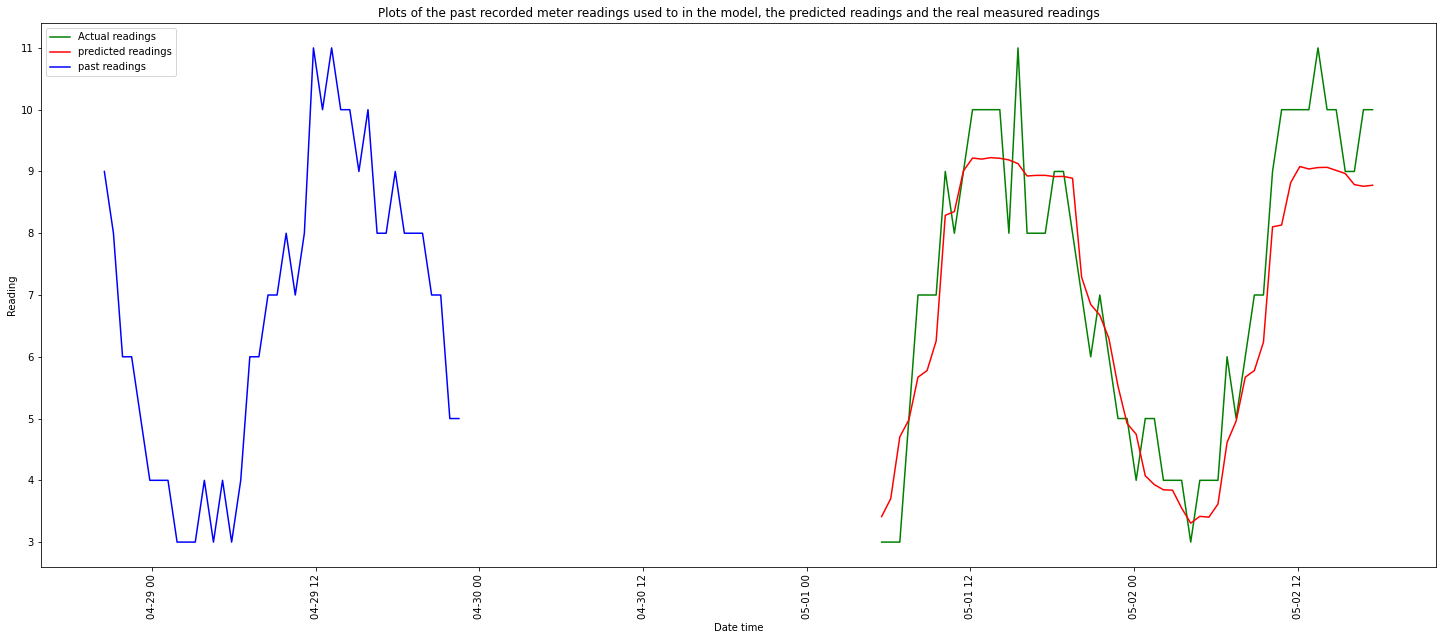

0.747878787878788


In [35]:
#import required libraries
import pandas as pd
import datetime
from datetime import datetime
start_predictions_timestamp=pd.to_datetime('2019-05-01 05:30:00') #define the timestamp that predictions are required 
                                                                    #to start from
prediction_interval=pd.to_timedelta('00:40:00') #define the interval between predictions
end_predictions_timestamp=pd.to_datetime('2019-05-02 18:00:00')#define the timestamp of the last required timestamp
synetica_data='synetica-apr-2019.zip' # provide the filename of the past data that will be used
meter_ID='MC062-L01/M7' #provide the meter ID of the meter that predictions are required for
building=' Bowland Twr (Old Bowland Annexe) '#provide the name of the building to acquire occupancy data 
check=True #set to True if the predictions can be checked by recorded data
check_data='synetica-may-2019.zip'
predictions(synetica_data, meter_ID, building, start_predictions_timestamp, prediction_interval, 
            end_predictions_timestamp, check, check_data)
#future_preds_df.head()

In [27]:
timeseries_df20.head()

,timestamp,device_id,name,reading,units
0,2020-01-01 00:00:00,{A389C592-4604-4CDA-8A03-035E14168AB3},MC043-L01/M1,0.0,MWh
1,2020-01-01 00:40:00,{A389C592-4604-4CDA-8A03-035E14168AB3},MC043-L01/M1,0.0,MWh
2,2020-01-01 01:20:00,{A389C592-4604-4CDA-8A03-035E14168AB3},MC043-L01/M1,0.0,MWh
3,2020-01-01 02:00:00,{A389C592-4604-4CDA-8A03-035E14168AB3},MC043-L01/M1,0.0,MWh
4,2020-01-01 02:40:00,{A389C592-4604-4CDA-8A03-035E14168AB3},MC043-L01/M1,0.0,MWh
